In [1]:
library(ggplot2)        # plotting & data
library(dplyr)          # data manipulation
library(tidyr)          # data re-shaping
library(magrittr)       # pipe operator
library(gridExtra)      # provides side-by-side plotting
library(dplyr)          # dplyr for pipe operations
library(moments)        # bonett.test for normality
library(ggQC)           # to create xMR and iMR charts
library(repr)           # change plot size
library(nortest)        # anderson darling test
library(climtrends)     # FindOutliersTietjenMooreTest


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘magrittr’


The following object is masked from ‘package:tidyr’:

    extract



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# Change plot size to 12 x 6
parentdir <- "rscript_data/"
options(repr.plot.width=22, repr.plot.height=12)

In [3]:
# generate well ids for x-axis 
wellIDs <- data.frame(sapply(LETTERS[1:8], function(x) {paste0(x,seq(2,8))}))
head(wellIDs)

A  B  C  D  E  F  G  H 
1 A2 B2 C2 D2 E2 F2 G2 H2
2 A3 B3 C3 D3 E3 F3 G3 H3
3 A4 B4 C4 D4 E4 F4 G4 H4
4 A5 B5 C5 D5 E5 F5 G5 H5
5 A6 B6 C6 D6 E6 F6 G6 H6
6 A7 B7 C7 D7 E7 F7 G7 H7

### Stain Index comparison of 8 old vs 8 new

In [220]:
dfcnt_new8 <- list()
dfcnt_old8 <- list()
rows <- list(c("A", "E"), c("B", "F"), c("C", "G"), c("D", "H"))
new8_file <- list.files(parentdir, pattern = "2021-07-20.*NEW8_CELLCNT.*")
old8_file <- list.files(parentdir, pattern = "2021-07-20.*OLD8_CELLCNT.*")


cnt <- 1
dfn_ls <- list()
dfo_ls <- list()
dfn_sub_ls <- list()
dfo_sub_ls <- list()

for (i in seq(1)) {
    dfn_ls[[i]] <- read.csv(paste0(parentdir, new8_file[i]))
    dfo_ls[[i]] <- read.csv(paste0(parentdir, old8_file[i]))
    for (j in seq(4)) {
          dfn_sub_ls[[cnt]] <- dfn_ls[[i]] %>%
              na.omit() %>% 
              filter(X < 9 & X > 1) %>%
              filter(grepl(paste0("[", rows[[j]][1], "|", rows[[j]][2], "]"), Y))
          dfo_sub_ls[[cnt]] <- dfo_ls[[i]] %>%
              na.omit() %>% 
              filter(X < 9 & X > 1) %>%
              filter(grepl(paste0("[", rows[[j]][1], "|", rows[[j]][2], "]"), Y))
    cnt <- cnt + 1
    }
}

#### compare two groups at a time for the variance using F test
- The p values are higher than 0.05, meaning the variances do not change from plate 1 to 3
- Run F-test when you want to perform a two samples t-test to check the equality of the variances of the two samples

#### Shapiro test
- the shapiro.test, the null hypothesis assumes that the data is drawn from a normal distribution. Since the p-value > 0.05, we fail to reject the null hypothesis, meaning that it is likely that the data is drawn from a normal distribution

#### Anderson-Darling test for normality
- a given sample of data is drawn from a given probability distribution
- has to be greater than 7 points so cannot run this test

In [221]:
# 8 chl New vs Old (A/E)
idx = c(1,5,9)
j = 1
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df_stats <- setNames(data.frame(matrix(ncol = 1, nrow = 0)), c("F_TEST" ))
df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    dff <- bind_rows(dfo[[i-1]], dfn[[i-1]])
    stat <- var.test(count ~ method, dff)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    #print("Old 8")
    #stat <- shapiro.test(dfo[[i-1]]$count)
    #df_stats[i-1, "SHAPIRO_TEST_OLD"] = formatC(stat$p.value, format = "e", digits = 2)
    #print(stat)
    #print("New 8")
    #stat <- shapiro.test(dfn[[i-1]]$count)
    #df_stats[i-1, "SHAPIRO_TEST_NEW"] = formatC(stat$p.value, format = "e", digits = 2)
    #print(stat)
}

write.csv(df_stats, paste0("8v8_stats_", pat1, "_", pat2, ".csv"), row.names = FALSE)

[1] "A - E old vs. new"
[1] "A2 - E2"

	F test to compare two variances

data:  count by method
F = 0.09558, num df = 1, denom df = 1, p-value = 0.3818
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.475482e-04 6.191573e+01
sample estimates:
ratio of variances 
        0.09558009 

[1] "A3 - E3"

	F test to compare two variances

data:  count by method
F = 1.8872, num df = 1, denom df = 1, p-value = 0.8012
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 2.913224e-03 1.222478e+03
sample estimates:
ratio of variances 
          1.887154 

[1] "A4 - E4"

	F test to compare two variances

data:  count by method
F = 15.751, num df = 1, denom df = 1, p-value = 0.3143
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 2.431498e-02 1.020331e+04
sample estimates:
ratio of variances 
          15.75098 

[1] "A5 - E5"

	F test to compare two vari

In [227]:
# 8 chl New vs Old (B/F)
idx = c(2,6,10)
j = 2
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- setNames(data.frame(matrix(ncol = 1, nrow = 0)), c("F_TEST"))

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    dff <- bind_rows(dfo[[i-1]], dfn[[i-1]])
    stat <- var.test(count ~ method, dff)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
}
write.csv(df_stats, paste0("8v8_stats_", pat1, "_", pat2, ".csv"), row.names = FALSE)

[1] "B - F old vs. new"
[1] "B2 - F2"

	F test to compare two variances

data:  count by method
F = 3.6228, num df = 1, denom df = 1, p-value = 0.6159
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 5.592538e-03 2.346800e+03
sample estimates:
ratio of variances 
          3.622784 

[1] "B3 - F3"

	F test to compare two variances

data:  count by method
F = 32.468, num df = 1, denom df = 1, p-value = 0.2212
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 5.012202e-02 2.103273e+04
sample estimates:
ratio of variances 
          32.46849 

[1] "B4 - F4"

	F test to compare two variances

data:  count by method
F = 22.495, num df = 1, denom df = 1, p-value = 0.2646
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 3.472534e-02 1.457182e+04
sample estimates:
ratio of variances 
          22.49469 

[1] "B5 - F5"

	F test to compare two varia

In [226]:
# 8 chl New vs Old (C/G)
idx = c(3,7,11)
j = 3
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df_stats <- setNames(data.frame(matrix(ncol = 1, nrow = 0)), c("F_TEST"))

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    dff <- bind_rows(dfo[[i-1]], dfn[[i-1]])
    stat <- var.test(count ~ method, dff)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
}
write.csv(df_stats, paste0("8v8_stats_", pat1, "_", pat2, ".csv"), row.names = FALSE)

[1] "C - G old vs. new"
[1] "C2 - G2"

	F test to compare two variances

data:  count by method
F = 0.44633, num df = 1, denom df = 1, p-value = 0.7499
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 6.889985e-04 2.891249e+02
sample estimates:
ratio of variances 
         0.4463257 

[1] "C3 - G3"

	F test to compare two variances

data:  count by method
F = 0.11498, num df = 1, denom df = 1, p-value = 0.4163
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 1.775022e-04 7.448536e+01
sample estimates:
ratio of variances 
          0.114984 

[1] "C4 - G4"

	F test to compare two variances

data:  count by method
F = 0.45622, num df = 1, denom df = 1, p-value = 0.7564
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 7.042683e-04 2.955326e+02
sample estimates:
ratio of variances 
         0.4562173 

[1] "C5 - G5"

	F test to compare two va

In [225]:
# 8 chl New vs Old (D/H)
idx = c(4,8,12)
j = 4
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df_stats <- setNames(data.frame(matrix(ncol = 1, nrow = 0)), c("F_TEST"))

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    dff <- bind_rows(dfo[[i-1]], dfn[[i-1]])
    stat <- var.test(count ~ method, dff)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
}
write.csv(df_stats, paste0("8v8_stats_", pat1, "_", pat2, ".csv"), row.names = FALSE)

[1] "D - H old vs. new"
[1] "D2 - H2"

	F test to compare two variances

data:  count by method
F = 0.33594, num df = 1, denom df = 1, p-value = 0.6688
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 5.186004e-04 2.176206e+02
sample estimates:
ratio of variances 
         0.3359436 

[1] "D3 - H3"

	F test to compare two variances

data:  count by method
F = 0.40562, num df = 1, denom df = 1, p-value = 0.7221
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 6.261589e-04 2.627554e+02
sample estimates:
ratio of variances 
         0.4056188 

[1] "D4 - H4"

	F test to compare two variances

data:  count by method
F = 0.39817, num df = 1, denom df = 1, p-value = 0.7167
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 6.146546e-04 2.579279e+02
sample estimates:
ratio of variances 
         0.3981665 

[1] "D5 - H5"

	F test to compare two va

### qq-plot
- Q-Q plot is a scatterplot created by plotting two sets of quantiles against one another. If both sets of quantiles came from the same distribution, we should see the points forming a line that's roughly straight

### Histogram with density line plot
- We also see similar skewness within the sample distributions.

In [55]:
# A-E
# 8 chl New vs Old (A/E)
p_qq_new8_cnt_ls <- list()
p_hst_new8_cnt_ls <- list()
idx = c(1,5,9)
j = 1
colm = 2
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
p_qq_cnt_ls <- list()
p_hst_cnt_ls <- list()


df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
}

dfo <- do.call(rbind, dfo)
dfn <- do.call(rbind, dfn)
df.t <- rbind(dfo, dfn)

p_qq_cnt_ls[[j]] <- ggplot(df.t, aes(sample = count)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(column~ method) +
            ggtitle(paste("New 8 vs. Old 8 q-q plot for each titration point dataset:", pat1, "-", pat2))

p_hst_cnt_ls[[j]] <- ggplot(data = df.t, aes(x = count)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(column~ method) +
    ggtitle(paste("New 8 vs. Old 8 histogram/density plot for each titration point dataset:", pat1, "-", pat2))

[1] "A - E old vs. new"
[1] "A2 - E2"
[1] "A3 - E3"
[1] "A4 - E4"
[1] "A5 - E5"
[1] "A6 - E6"
[1] "A7 - E7"
[1] "A8 - E8"


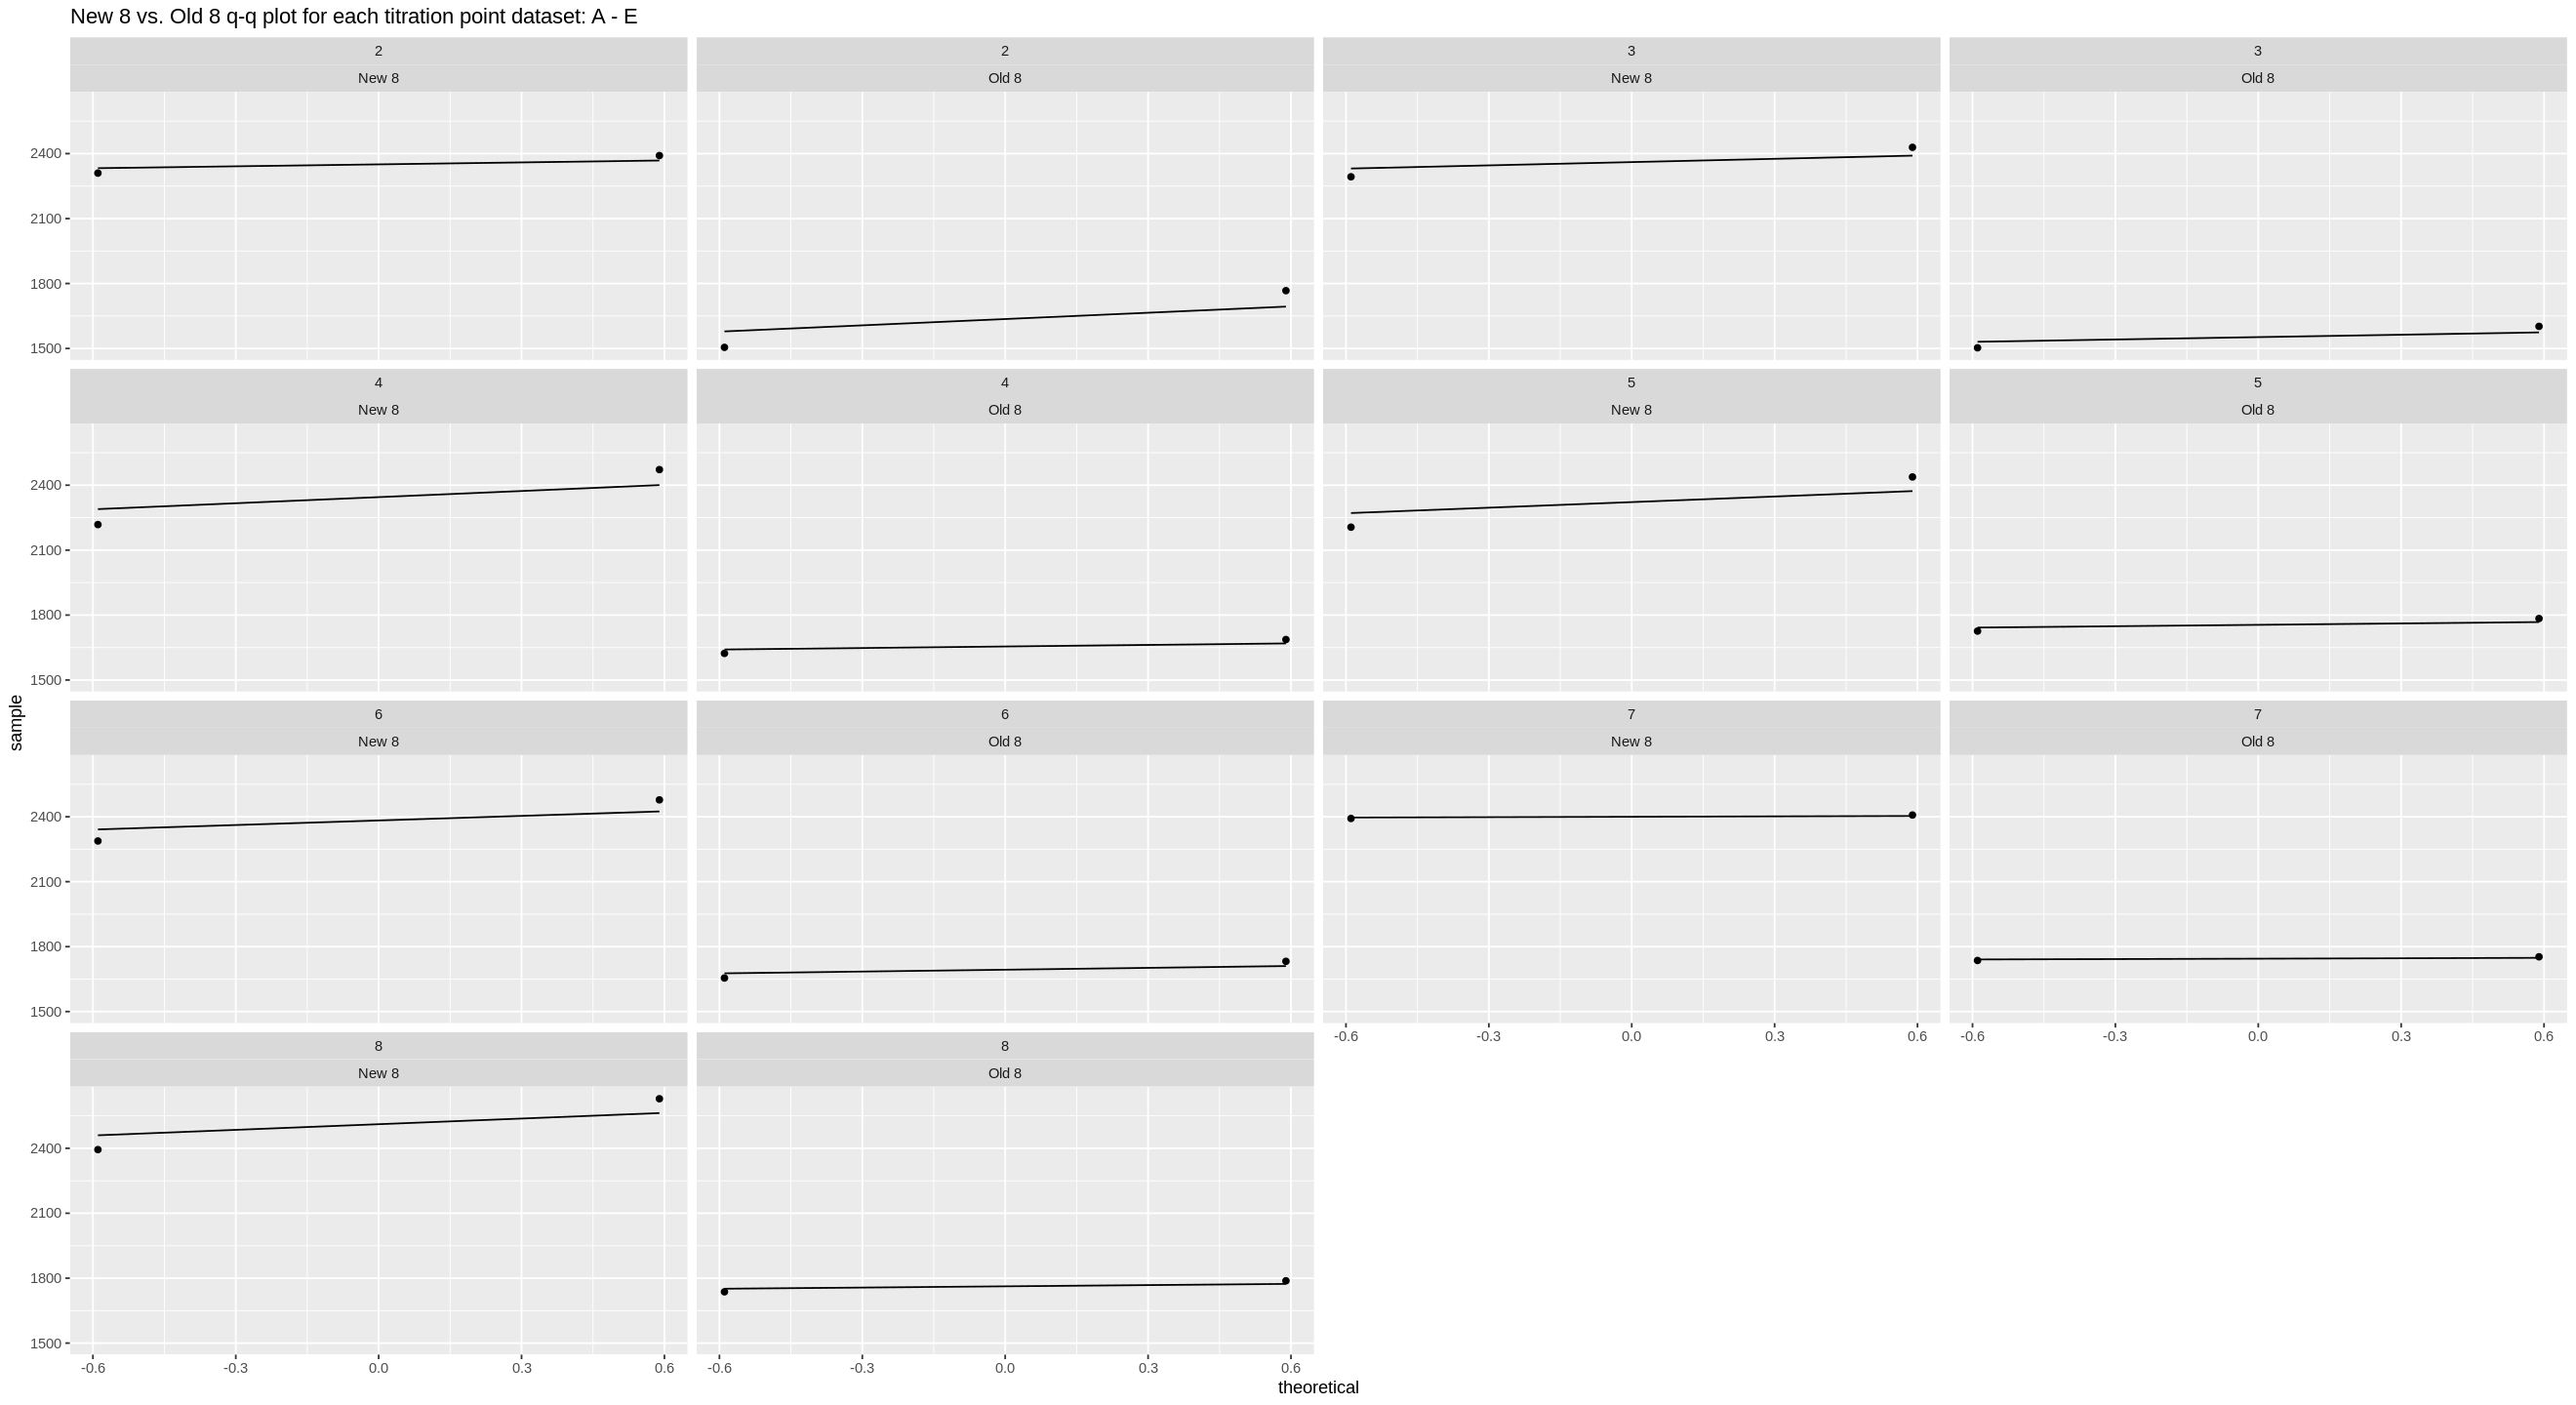

In [56]:
p_qq_cnt_ls[[1]]

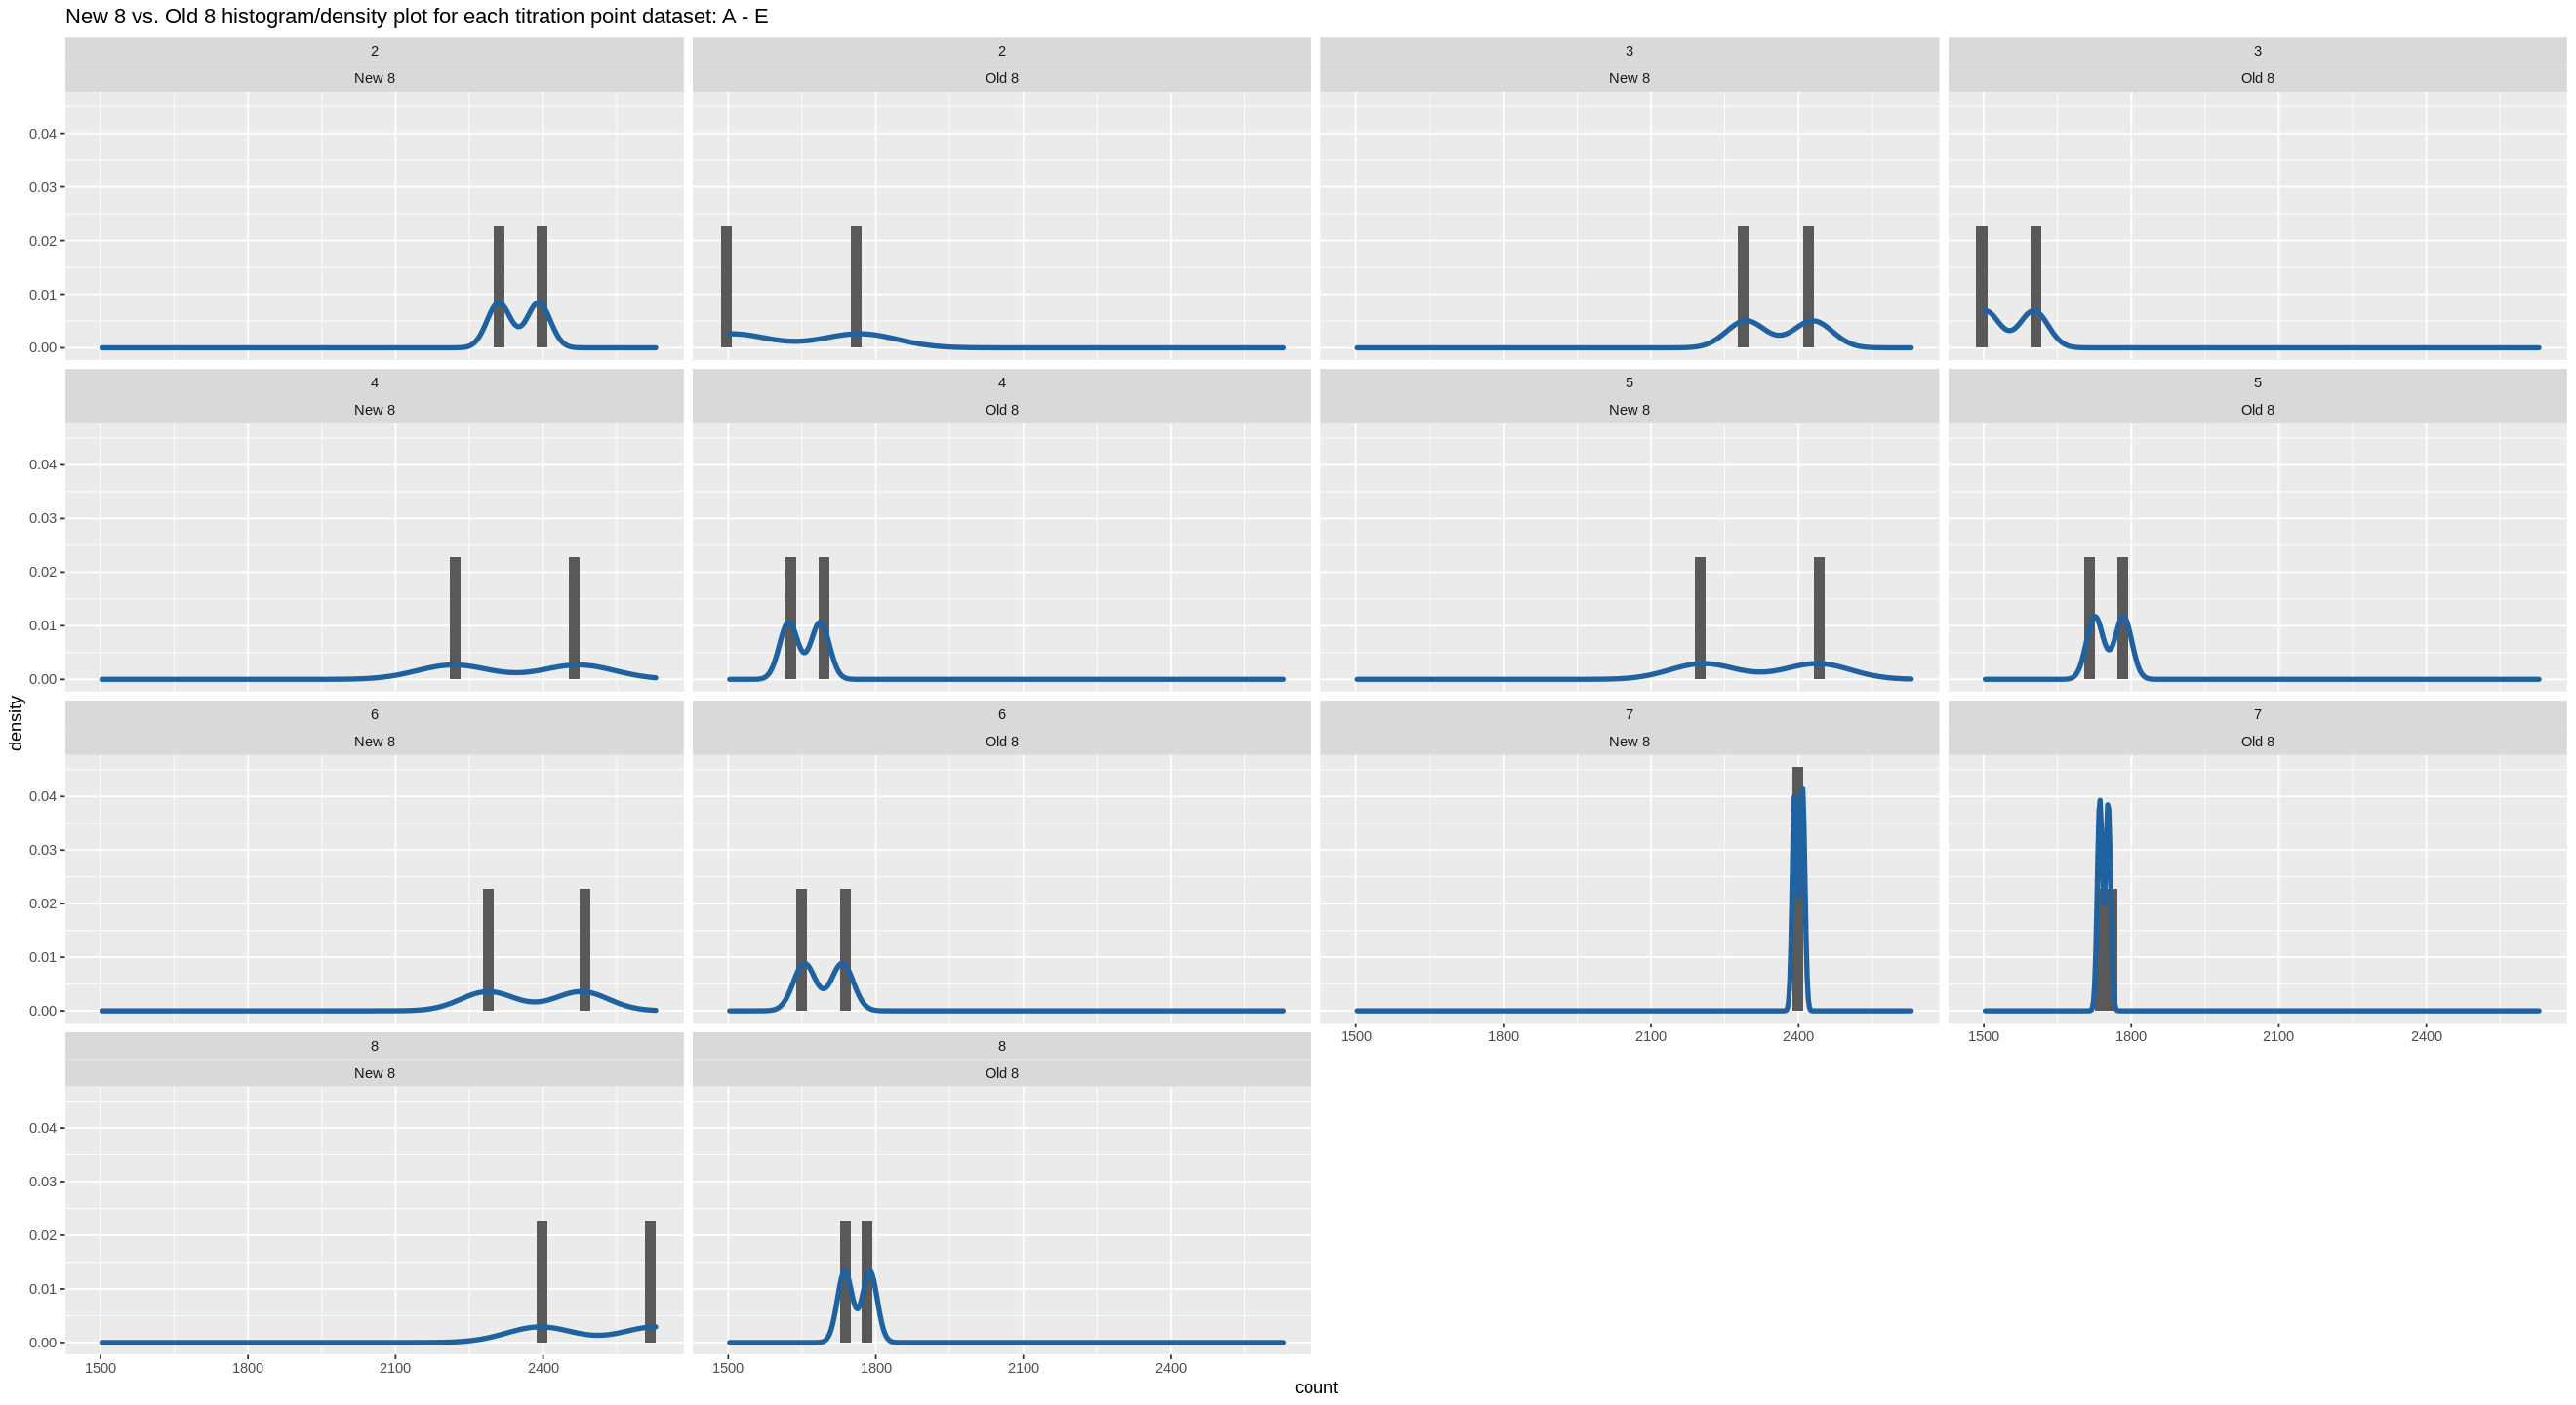

In [57]:
p_hst_cnt_ls[[1]]

In [58]:
# B-F
# 8 chl New vs Old 
idx = c(2,6,10)
j = 2
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
p_qq_cnt_ls <- list()
p_hst_cnt_ls <- list()

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
}

dfo <- do.call(rbind, dfo)
dfn <- do.call(rbind, dfn)
df.t <- rbind(dfo, dfn)

p_qq_cnt_ls[[j]] <- ggplot(df.t, aes(sample = count)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(column~ method) +
            ggtitle(paste("New 8 vs. Old 8 q-q plot for each titration point dataset:", pat1, "-", pat2))

p_hst_cnt_ls[[j]] <- ggplot(data = df.t, aes(x = count)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(column~ method) +
    ggtitle(paste("New 8 vs. Old 8 histogram/density plot for each titration point dataset:", pat1, "-", pat2))

[1] "B - F old vs. new"
[1] "B2 - F2"
[1] "B3 - F3"
[1] "B4 - F4"
[1] "B5 - F5"
[1] "B6 - F6"
[1] "B7 - F7"
[1] "B8 - F8"


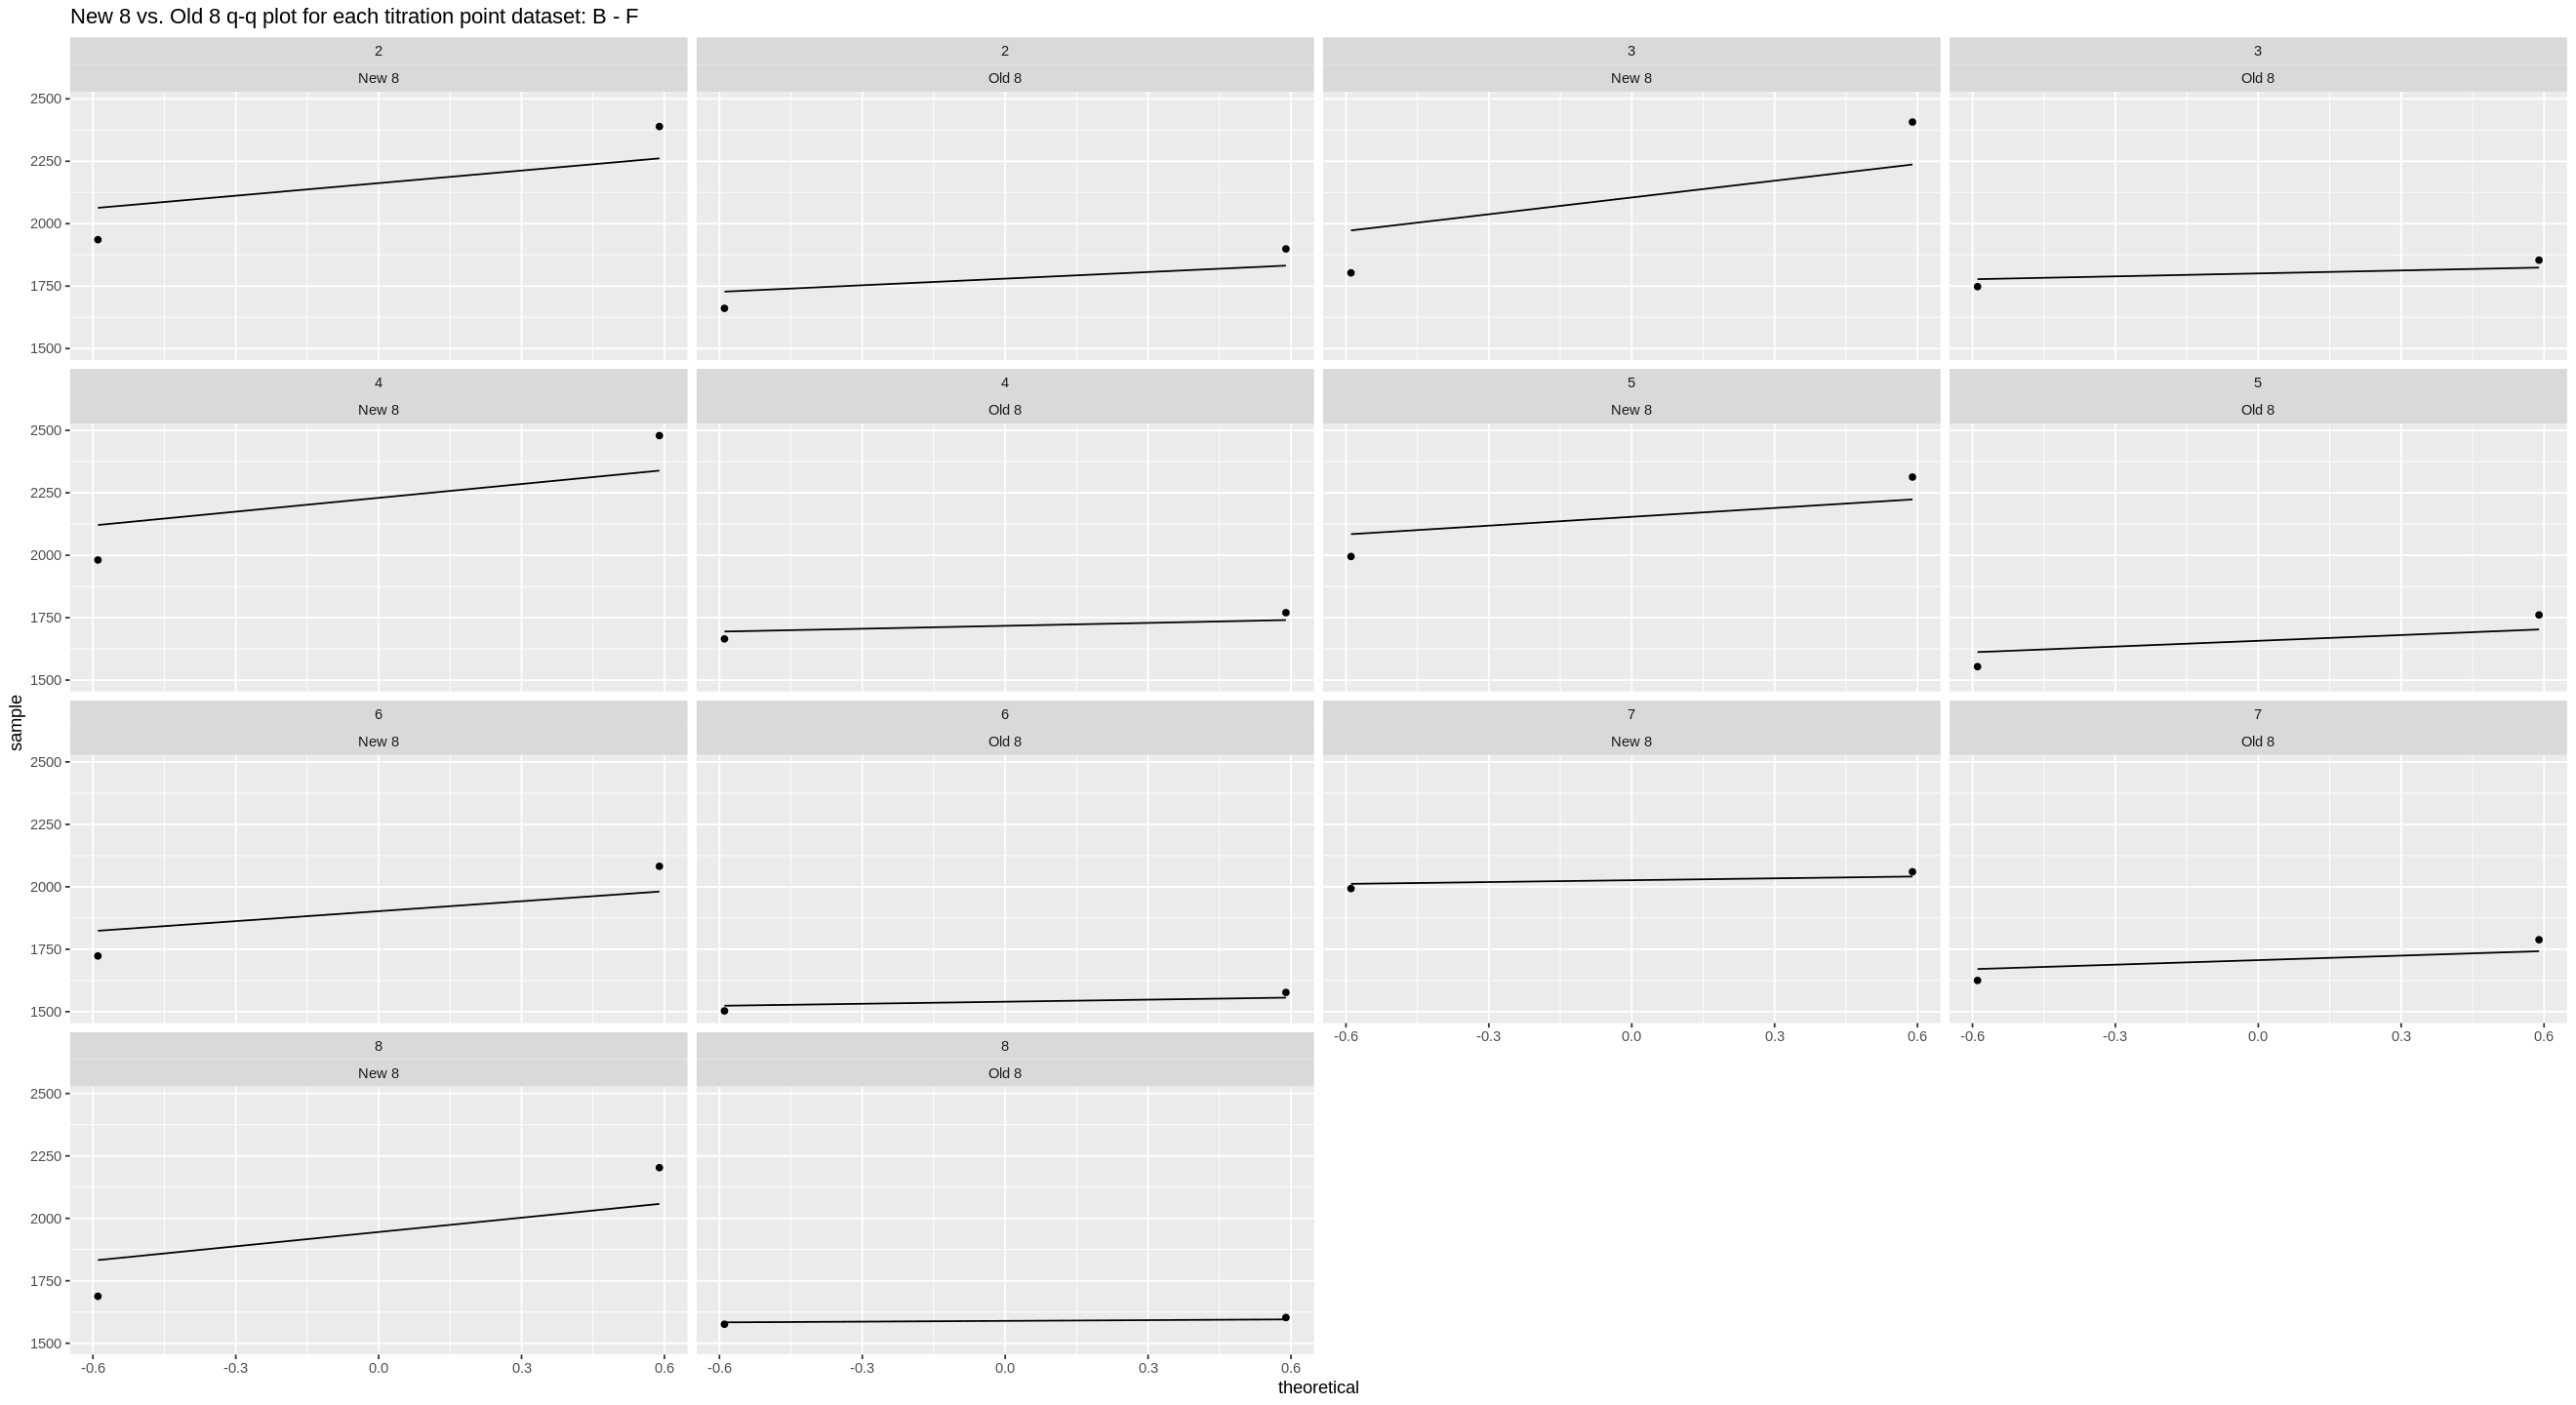

In [59]:
p_qq_cnt_ls[[2]]

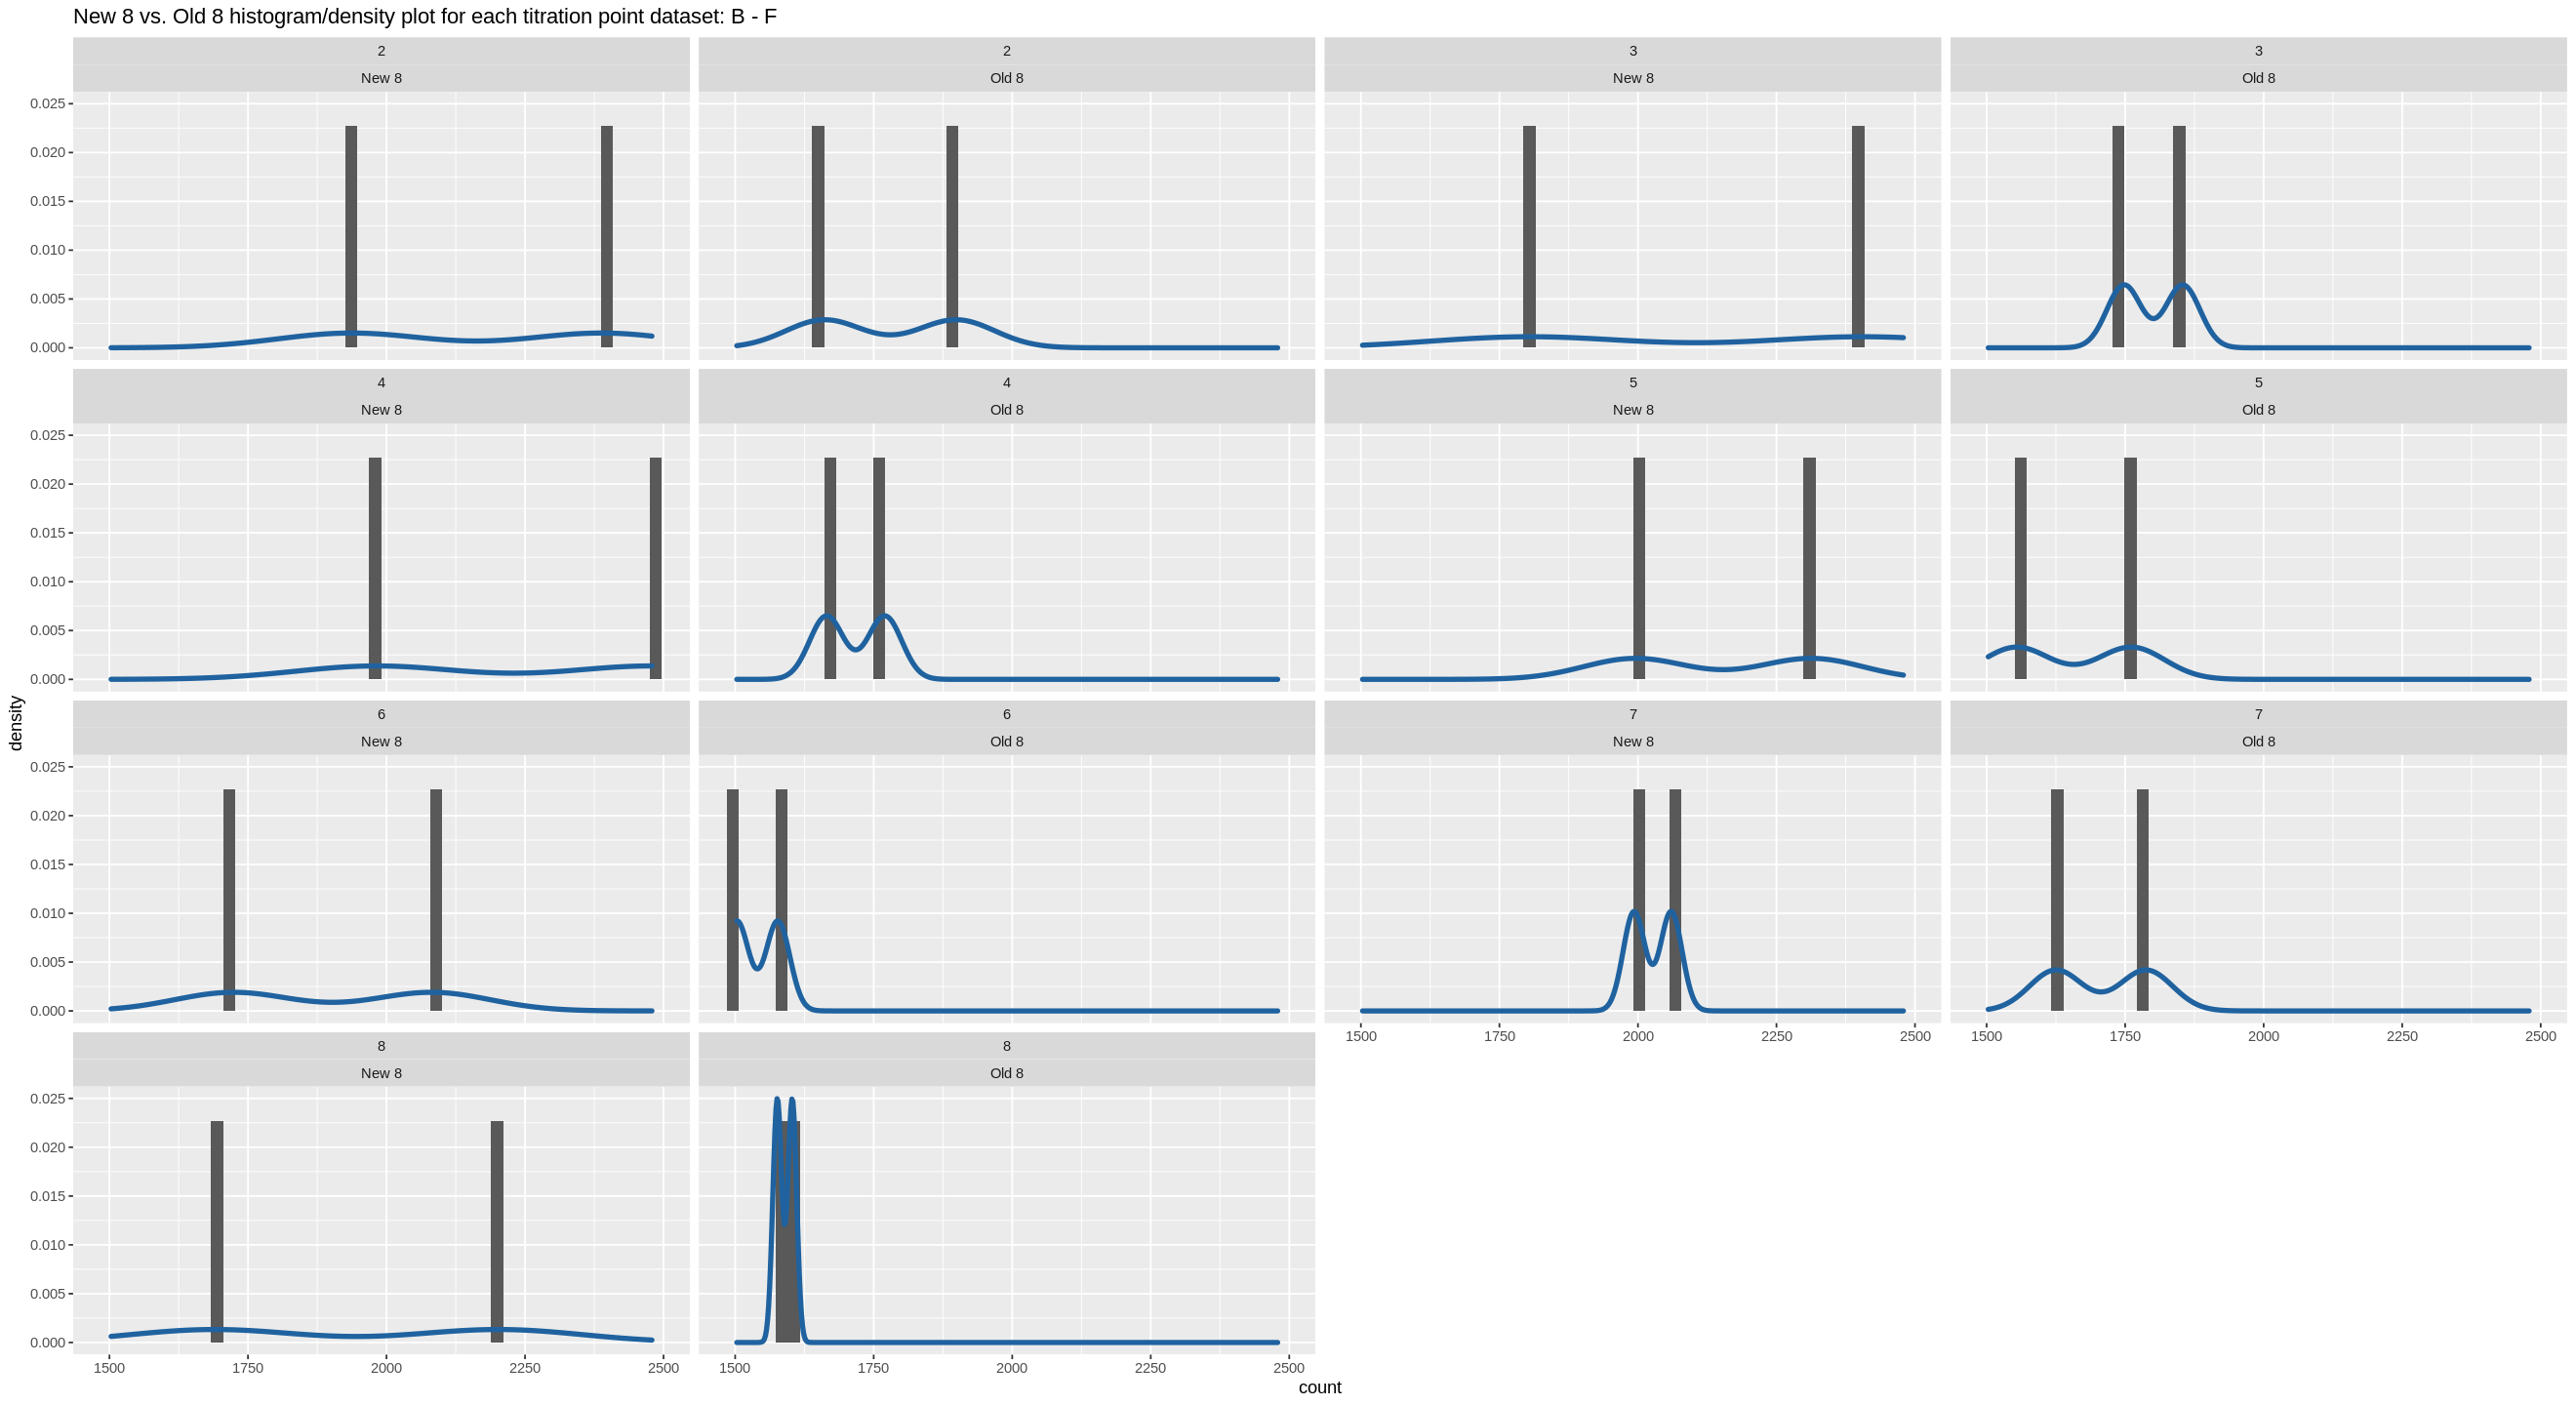

In [60]:
p_hst_cnt_ls[[2]]

In [61]:
# C-G
idx = c(3,7,11)
j = 3
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
p_qq_cnt_ls <- list()
p_hst_cnt_ls <- list()

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
}

dfo <- do.call(rbind, dfo)
dfn <- do.call(rbind, dfn)

df.t <- rbind(dfo, dfn)

p_qq_cnt_ls[[j]] <- ggplot(df.t, aes(sample = count)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(column~ method) +
            ggtitle(paste("New 8 vs. Old 8 q-q plot for each titration point dataset:", pat1, "-", pat2))

p_hst_cnt_ls[[j]] <- ggplot(data = df.t, aes(x = count)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(column~ method) +
    ggtitle(paste("New 8 vs. Old 8 histogram/density plot for each titration point dataset:", pat1, "-", pat2))

[1] "C - G old vs. new"
[1] "C2 - G2"
[1] "C3 - G3"
[1] "C4 - G4"
[1] "C5 - G5"
[1] "C6 - G6"
[1] "C7 - G7"
[1] "C8 - G8"


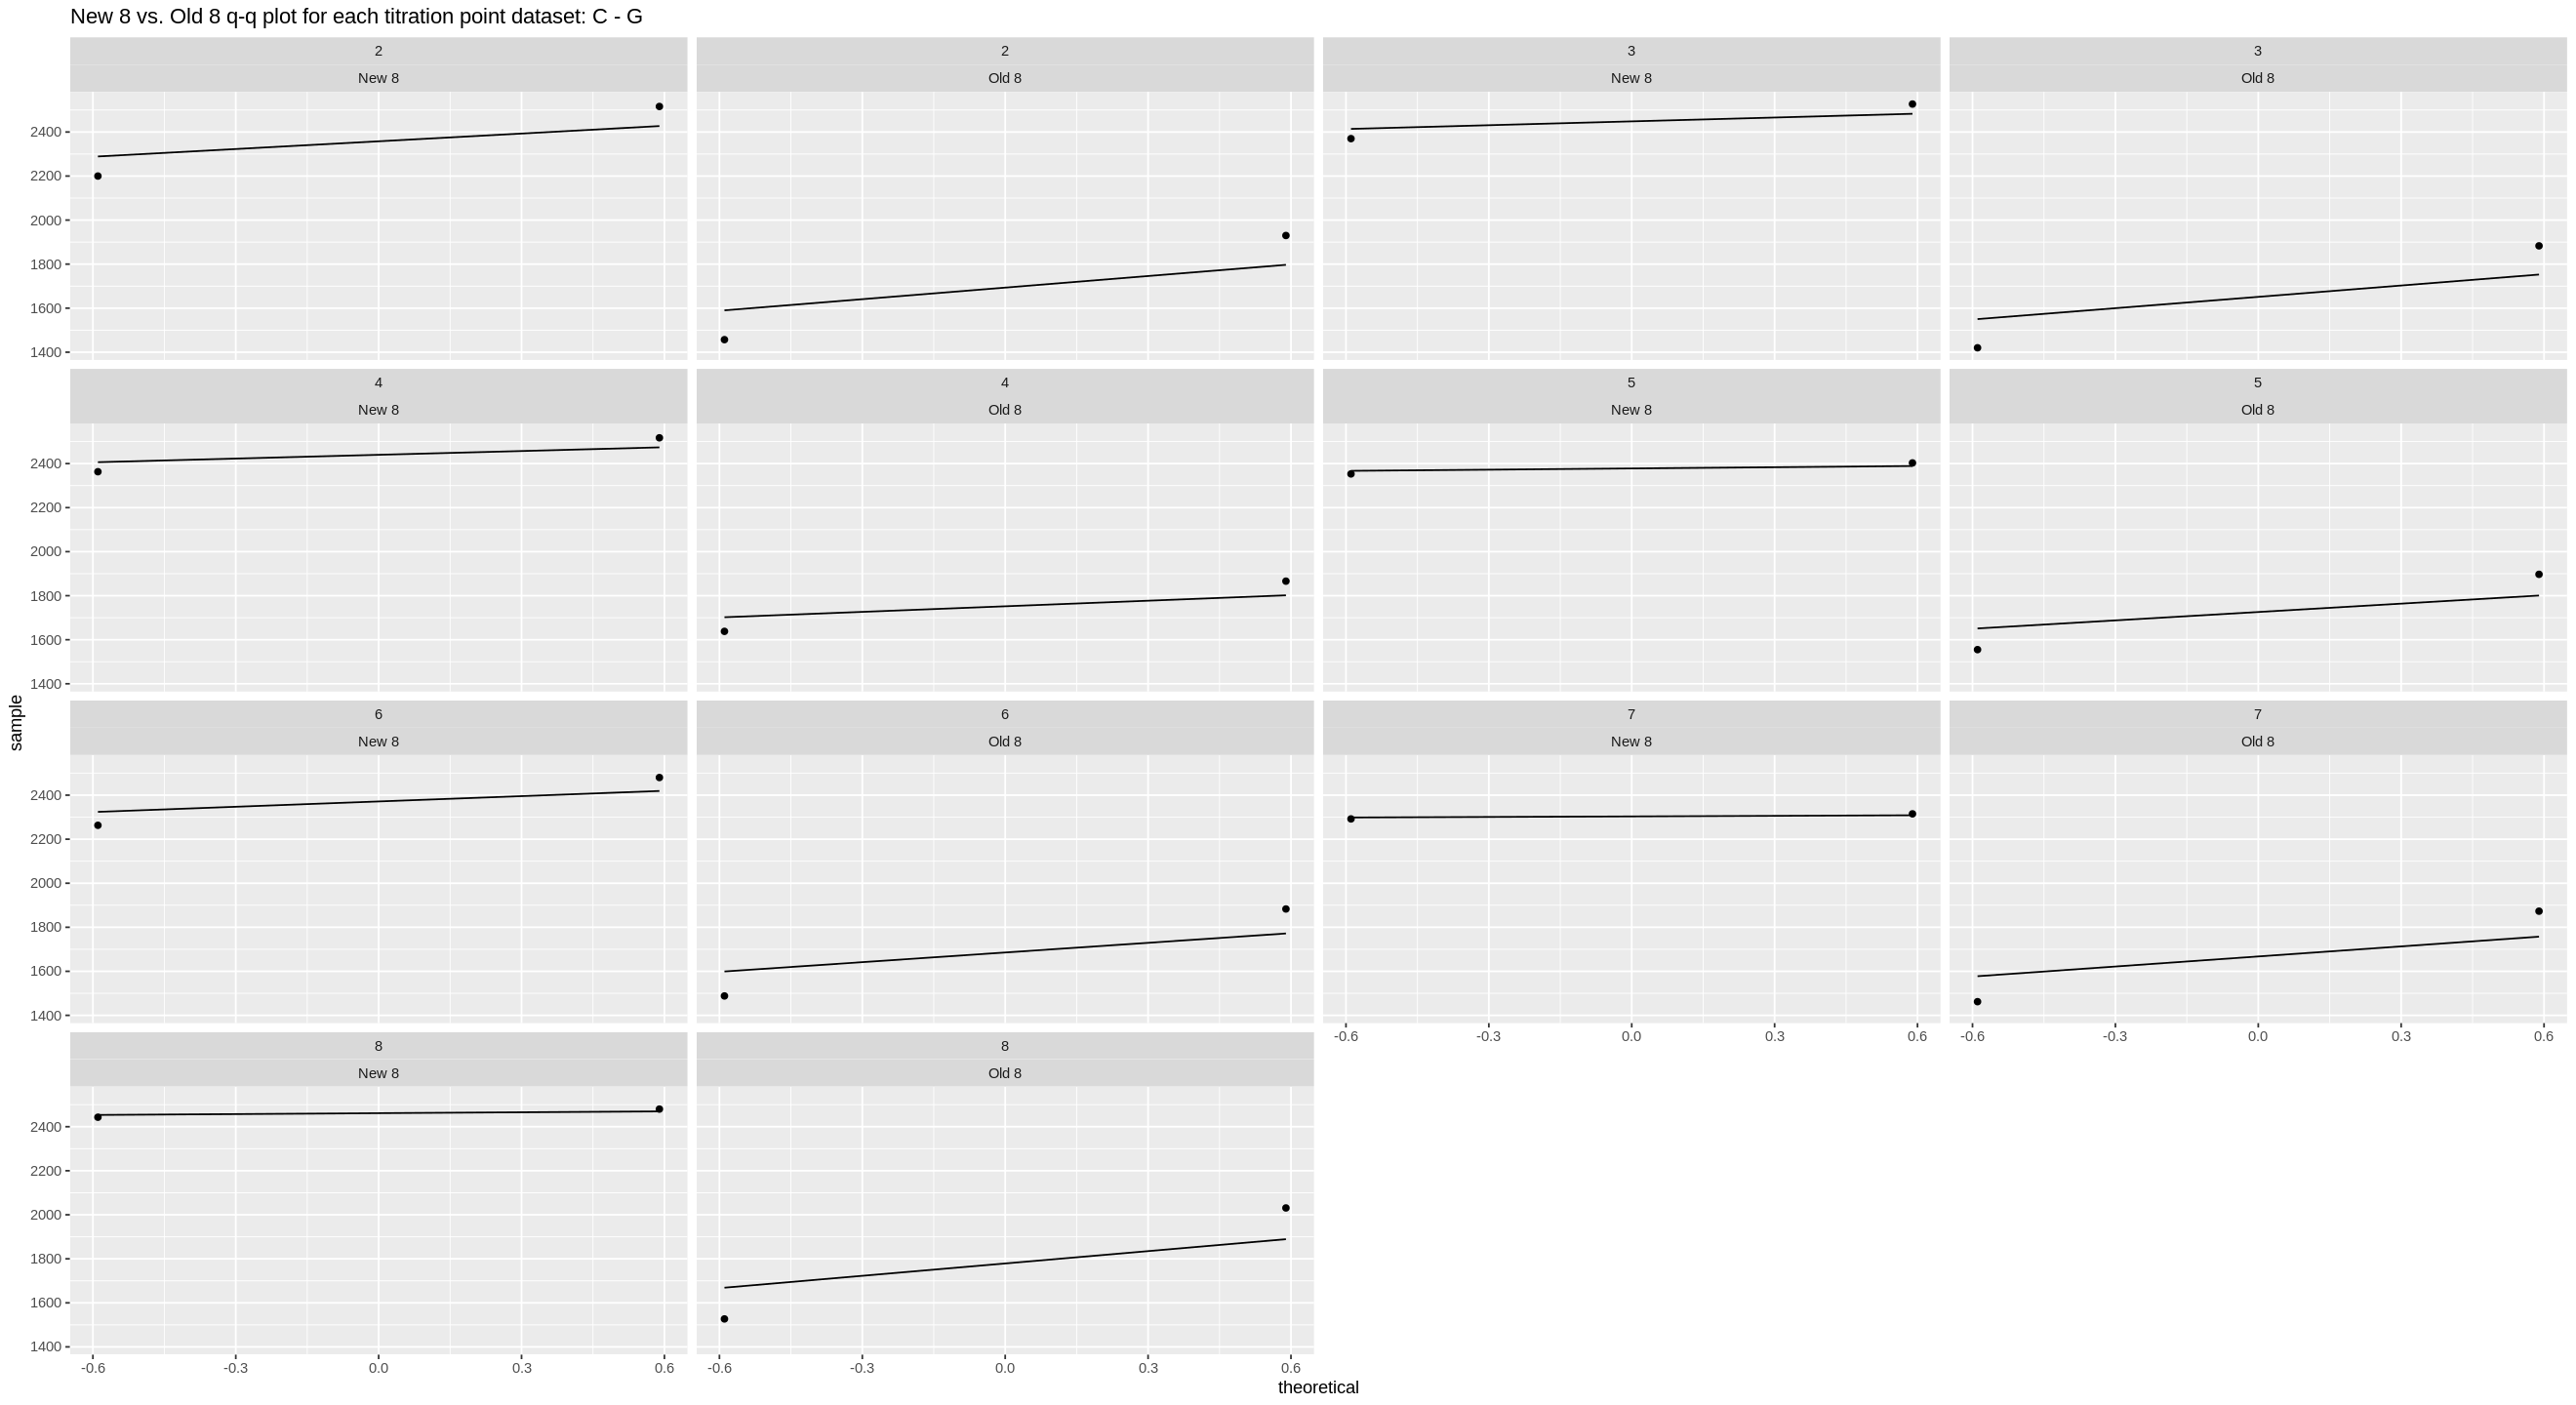

In [62]:
p_qq_cnt_ls[[3]]

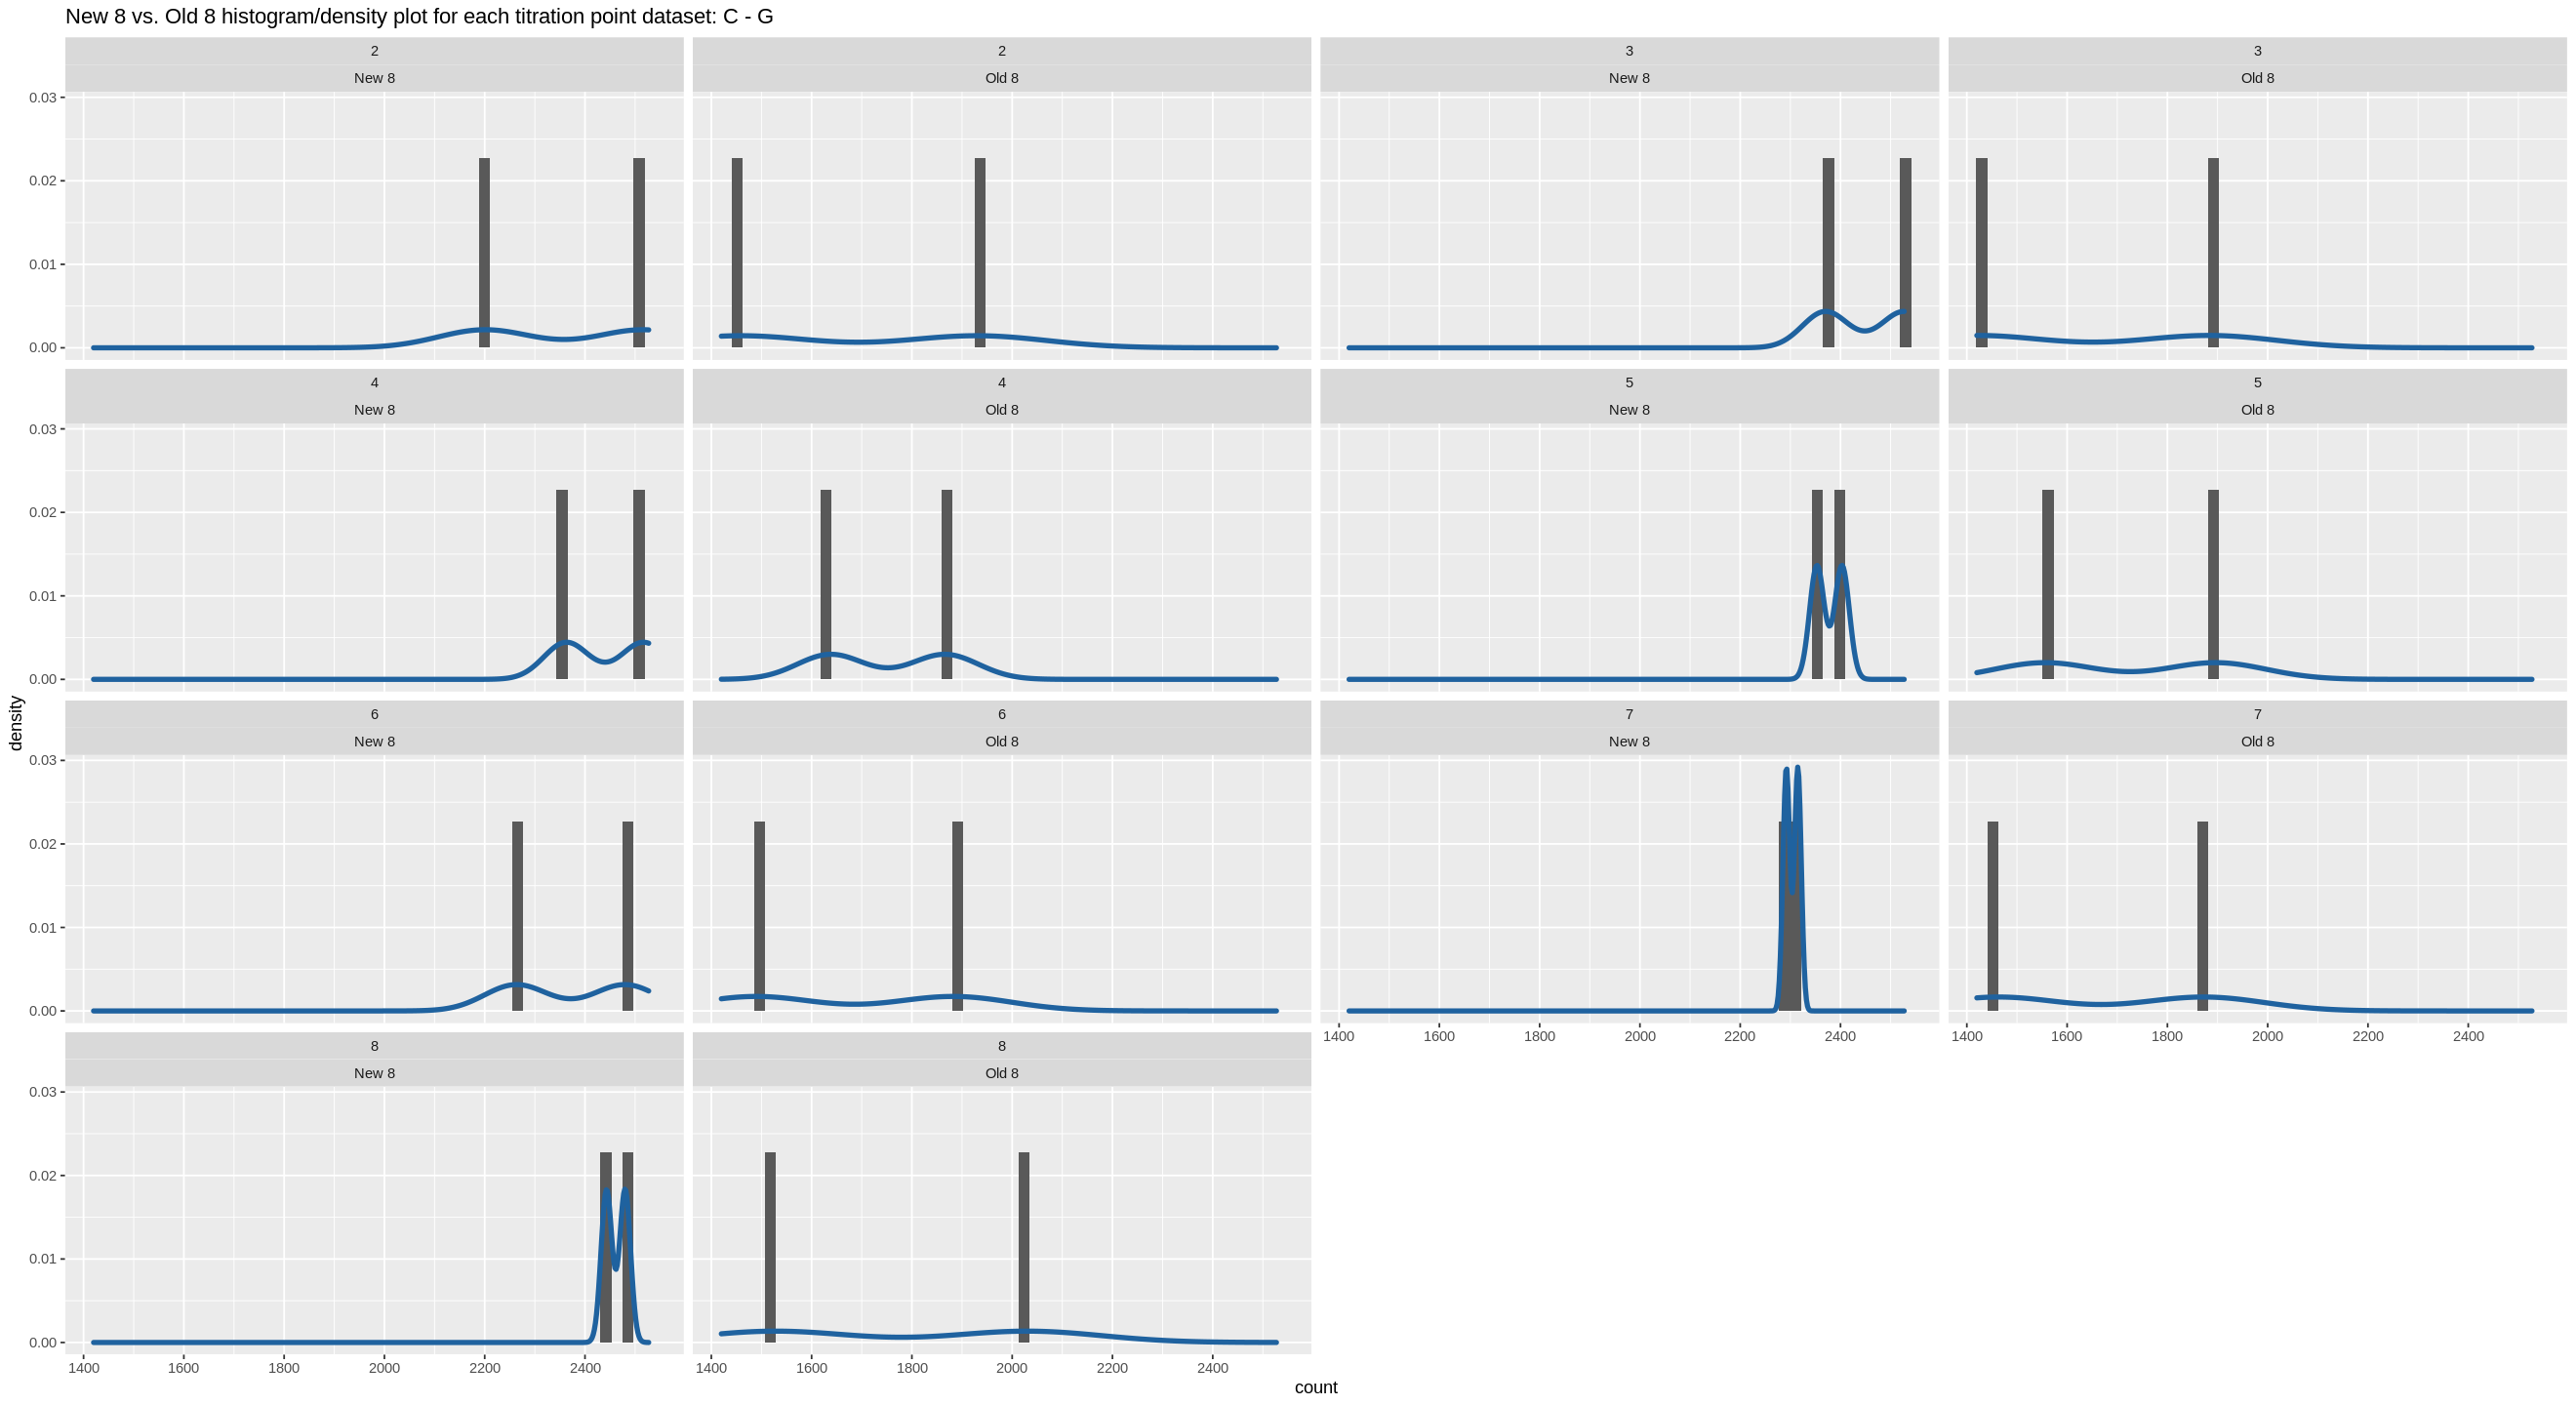

In [63]:
p_hst_cnt_ls[[3]]

In [64]:
# D-H
idx = c(4,8,12)
j = 4
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
p_qq_cnt_ls <- list()
p_hst_cnt_ls <- list()

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
}

dfo <- do.call(rbind, dfo)
dfn <- do.call(rbind, dfn)
df.t <- rbind(dfo, dfn)

p_qq_cnt_ls[[j]] <- ggplot(df.t, aes(sample = count)) + 
            stat_qq() + 
            stat_qq_line() + 
            facet_wrap(column~ method) +
            ggtitle(paste("New 8 vs. Old 8 q-q plot for each titration point dataset:", pat1, "-", pat2))

p_hst_cnt_ls[[j]] <- ggplot(data = df.t, aes(x = count)) +
    geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) +
    facet_wrap(column~ method) +
    ggtitle(paste("New 8 vs. Old 8 histogram/density plot for each titration point dataset:", pat1, "-", pat2))

[1] "D - H old vs. new"
[1] "D2 - H2"
[1] "D3 - H3"
[1] "D4 - H4"
[1] "D5 - H5"
[1] "D6 - H6"
[1] "D7 - H7"
[1] "D8 - H8"


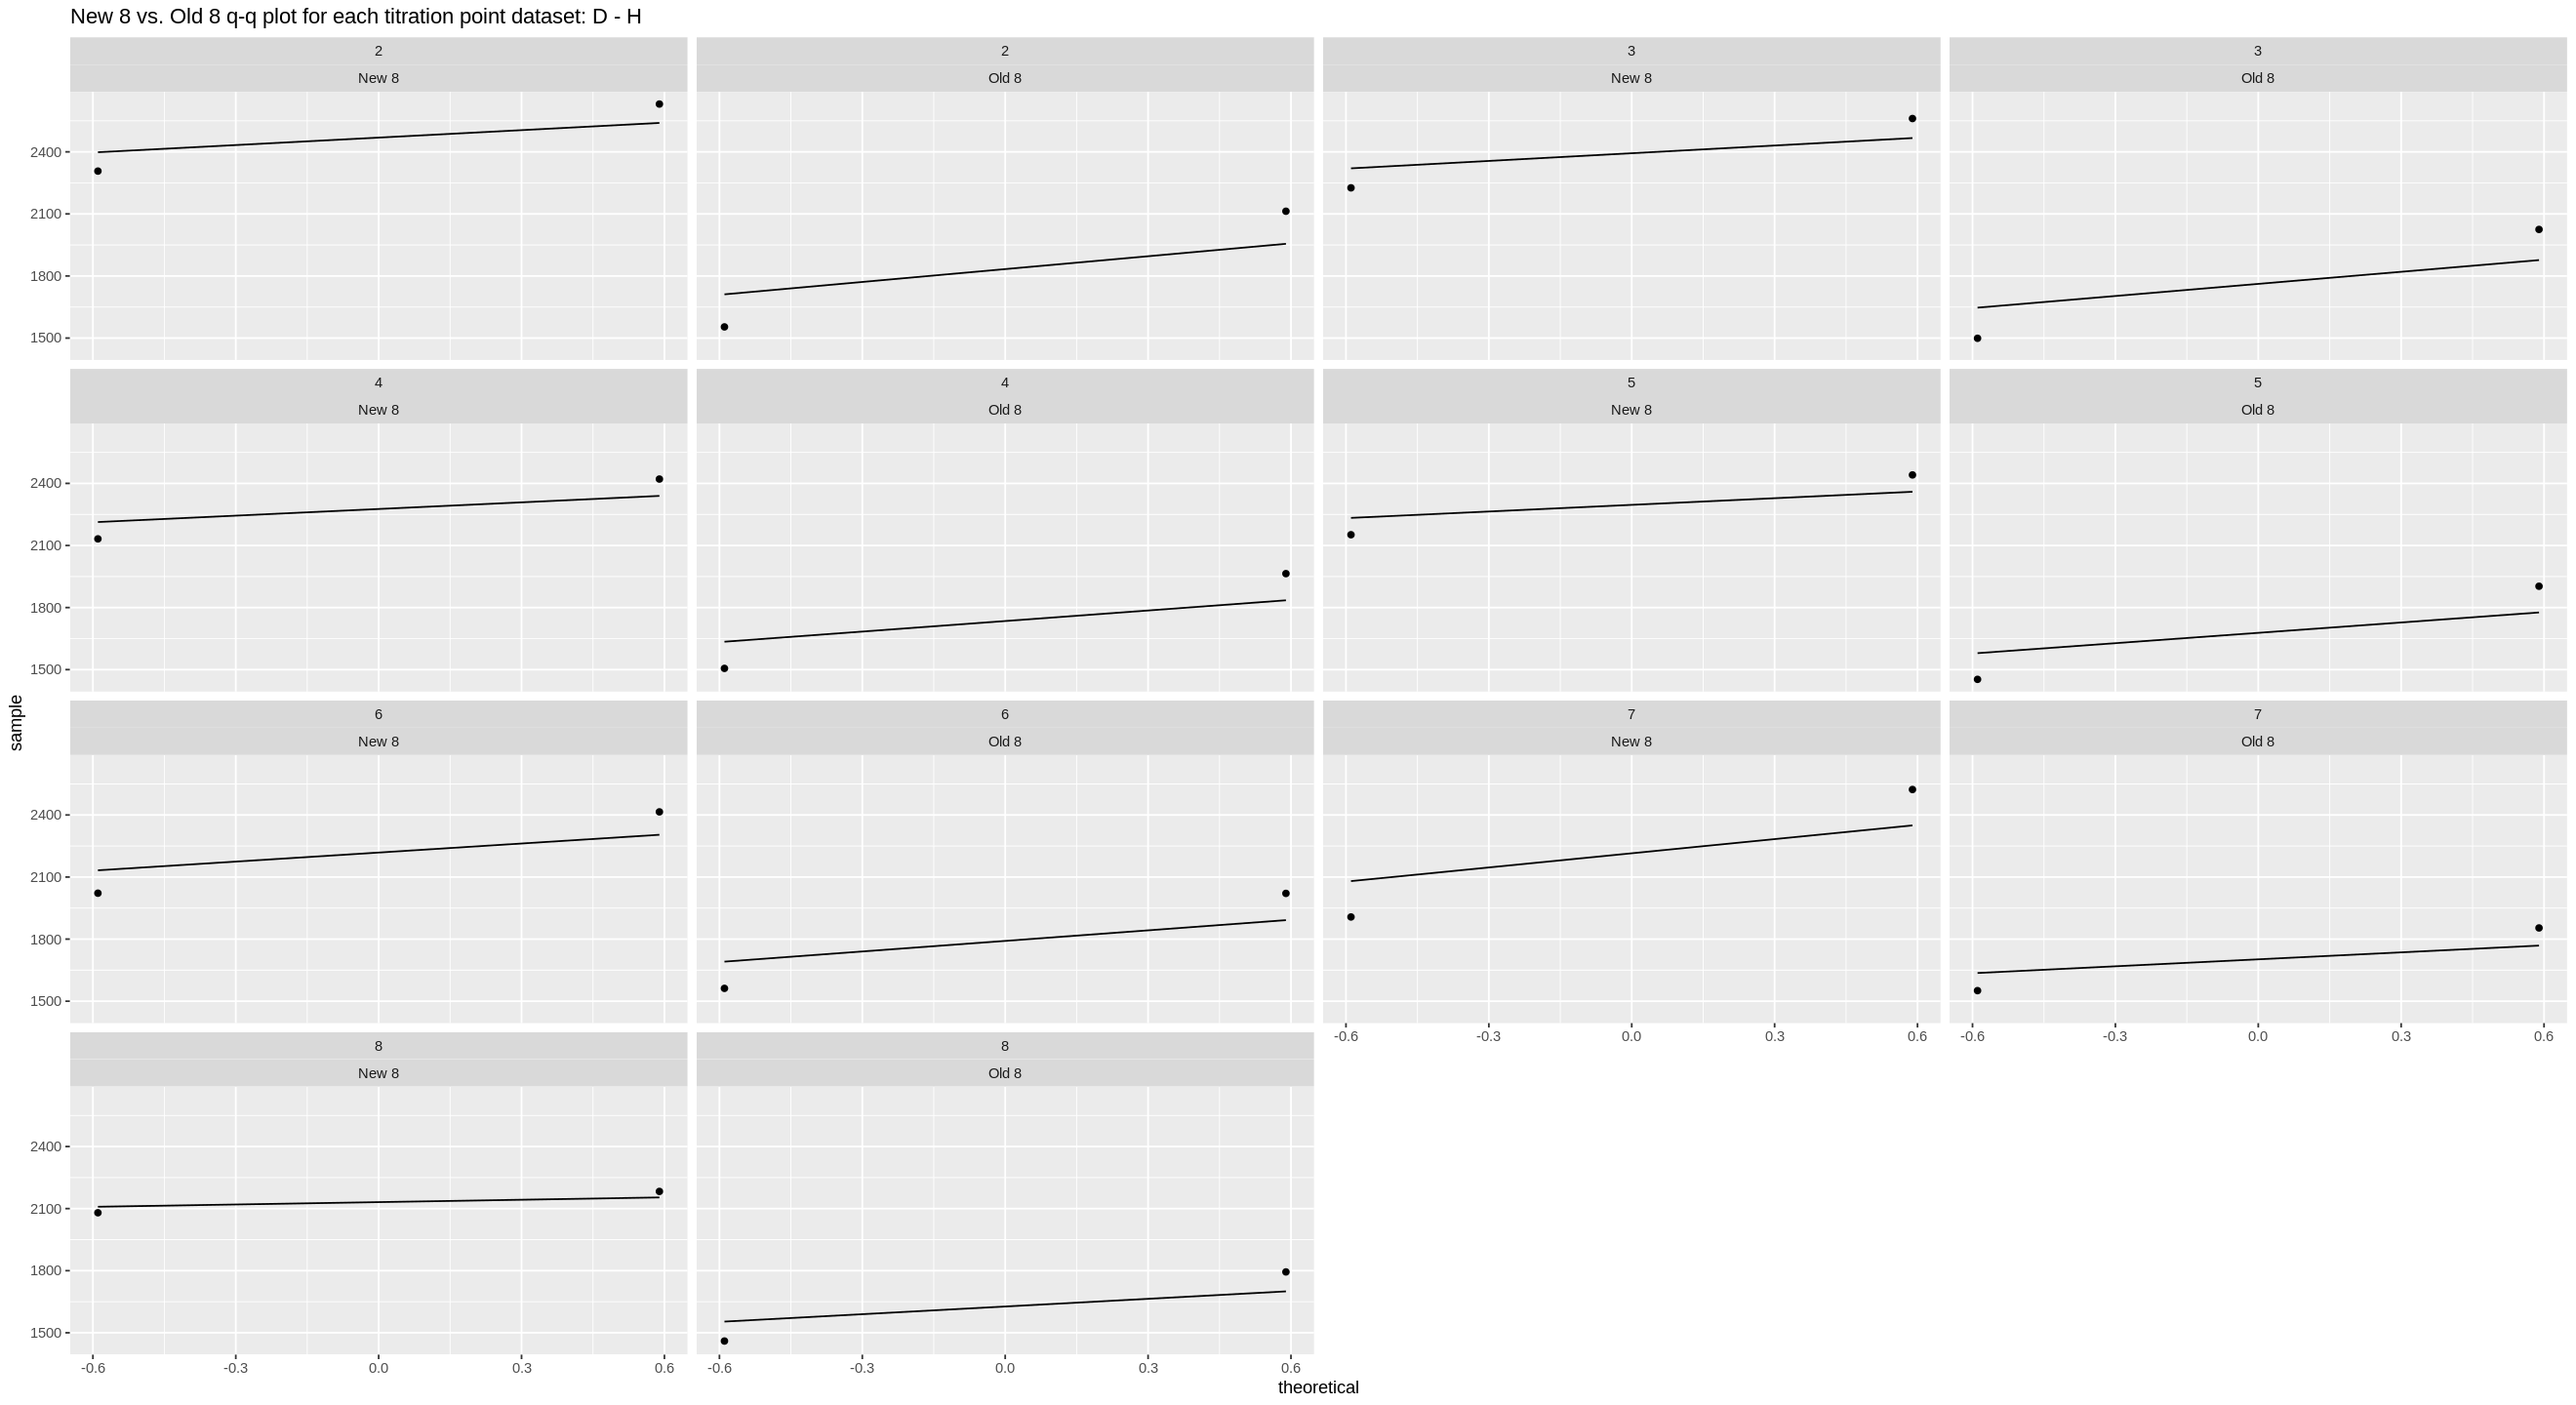

In [65]:
p_qq_cnt_ls[[4]]

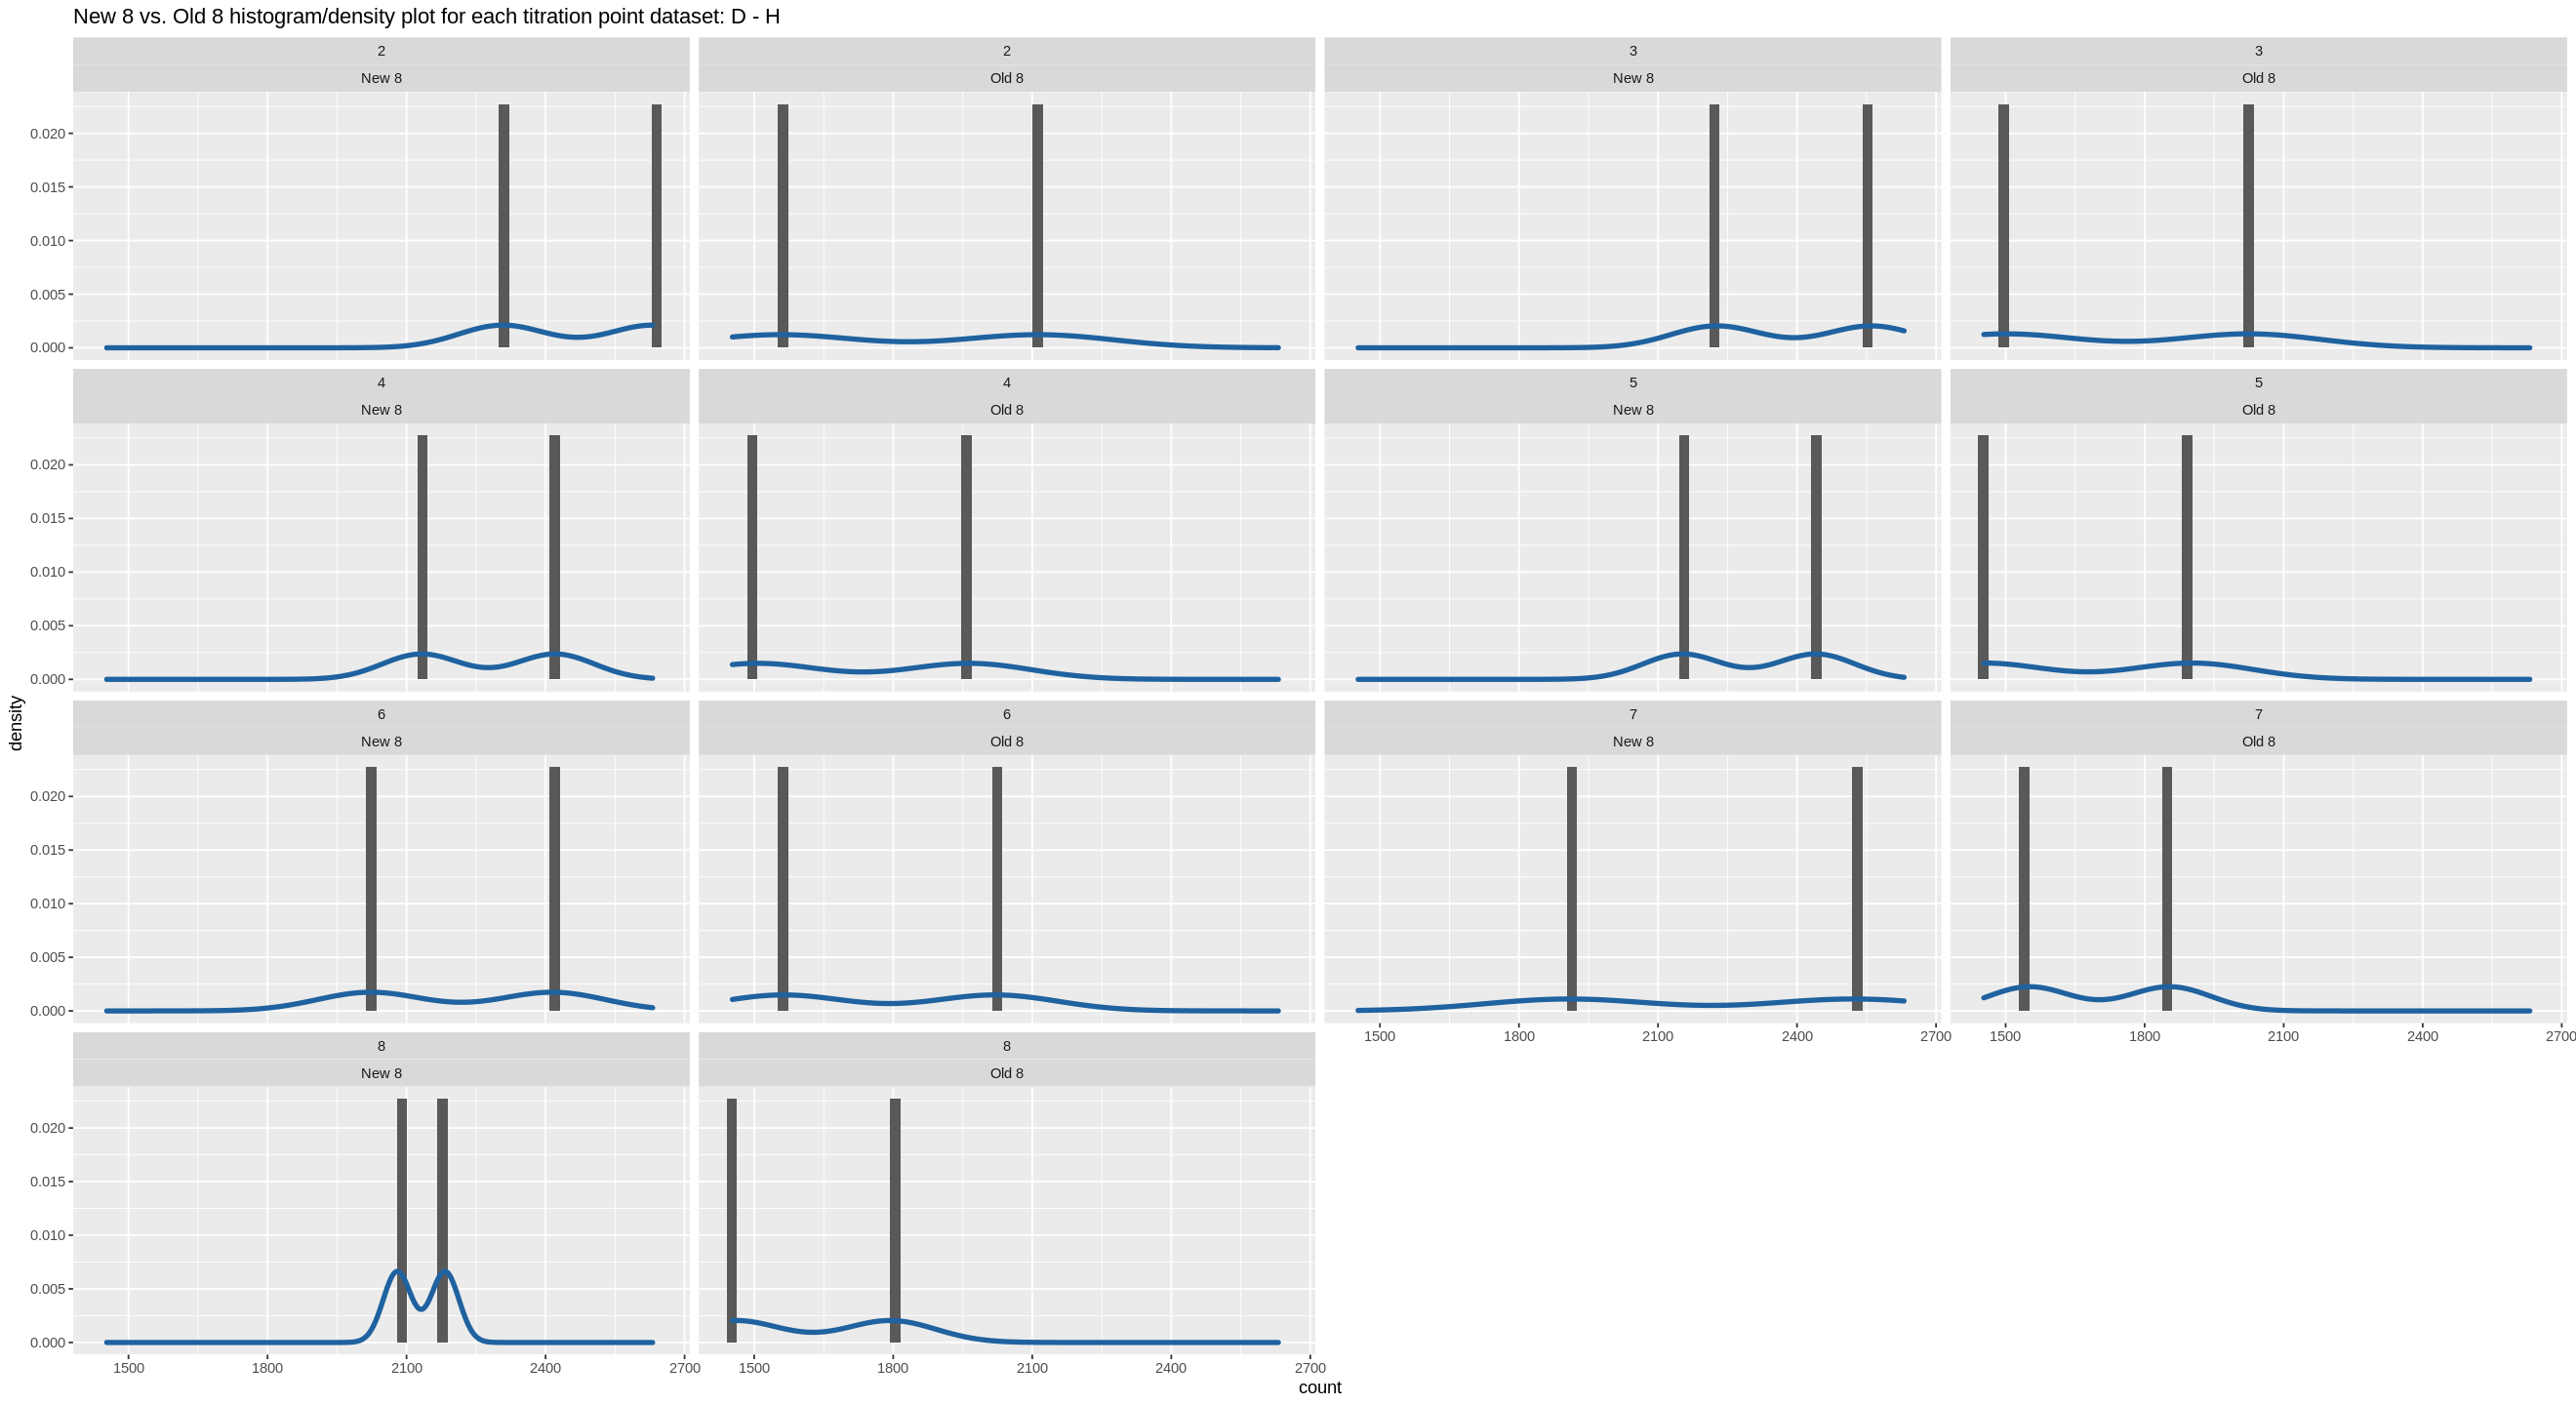

In [66]:
p_hst_cnt_ls[[4]]

In [67]:
dfn_sub_ls[[1]]

X Y Z   
1  2 A 2391
2  3 A 2429
3  4 A 2472
4  5 A 2438
5  6 A 2478
6  7 A 2392
7  8 A 2629
8  2 E 2310
9  3 E 2293
10 4 E 2218
11 5 E 2206
12 6 E 2288
13 7 E 2408
14 8 E 2394

In [68]:
p_qq_new8 <- list()
p_qq_old8 <- list()
p_hst_new8_cnt <- list()
p_hst_old8_cnt <- list()
df_pair_new8_cnt <- list()
df_pair_old8_cnt <- list()
start_seq <- seq(1,12,4)

for (i in seq(1)) {
    k = start_seq[i]
    df <- rbind(dfn_sub_ls[[k]],dfn_sub_ls[[k+1]],dfn_sub_ls[[k+2]],dfn_sub_ls[[k+3]]) %>% 
          mutate(grp = case_when(
                Y == "A" ~ "A-E",
                Y == "B" ~ "B-F",
                Y == "C" ~ "C-G",
                Y == "D" ~ "D-H",
                Y == "E" ~ "A-E",
                Y == "F" ~ "B-F",
                Y == "G" ~ "C-G",
                Y == "H" ~ "D-H"
            ))
    df_pair_new8_cnt[[i]] <- df
    p_qq_new8[[i]] <- ggplot(df, aes(sample = Z)) + 
                    stat_qq() + 
                    stat_qq_line() +
                    facet_wrap(~ grp)
    
    p_hst_new8_cnt[[i]] <- ggplot(data = df, aes(x = Z)) +
        geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
        geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
        facet_wrap(~ grp)
    
    df <- rbind(dfo_sub_ls[[k]],dfo_sub_ls[[k+1]],dfo_sub_ls[[k+2]],dfo_sub_ls[[k+3]]) %>% 
          mutate(grp = case_when(
                Y == "A" ~ "A-E",
                Y == "B" ~ "B-F",
                Y == "C" ~ "C-G",
                Y == "D" ~ "D-H",
                Y == "E" ~ "A-E",
                Y == "F" ~ "B-F",
                Y == "G" ~ "C-G",
                Y == "H" ~ "D-H"
            ))
    
    df_pair_old8_cnt[[i]] <- df
    p_qq_old8[[i]] <- ggplot(df, aes(sample = Z)) + 
                    stat_qq() + 
                    stat_qq_line() +
                    facet_wrap(~ grp)
    
    p_hst_old8_cnt[[i]] <- ggplot(data = df, aes(x = Z)) +
        geom_histogram(aes(y = ..density..), binwidth = 22, position = "identity") + 
        geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
        facet_wrap(~ grp)
    }

### Wilcoxon rank test

- check that the median of pairwise differences is different 
- non-parametric statistical test to compare 2 related samples, matched samples or repeated measurements on single sample to assess whether their population mean ranks differ 
- an alternative to t-test; this is when we can't assume the two populatios are normally distributed; determine wheterh two dependent samples were selected from populations have the same distribution
- analysis below shows using both wilcox and t-test the sample mean for intra-plate is very different
- assume not normal distribution

#### t test for new vs old plate sets
- check mean sample difference between two datasets
- requires normal and linear data

###### info
- the data will output 8 wilcoxon and t-test results for each titration point across 3 plates totalling to 6 per group since there are 2 data points per plate 

In [69]:
# print helper function
prnt_wt_test <- function(dfo, dfn) {
    stat <- wilcox.test(x = dfo %>% 
                        select(count) %>%
                        pull(), 
                    y = dfn %>%
                        select(count) %>%
                        pull(), 
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 
    print(stat)
    stat2 <- t.test(x = dfo %>% 
                        select(count) %>%
                        pull(), 
                    y = dfn %>%
                        select(count) %>%
                        pull(), 
       alternative = "two.sided",
       paired = FALSE, var.equal = FALSE,
       conf.level = 0.95) 
    return(list(stat, stat2))
        }

In [70]:
# A-E old 8 vs new 8
idx = c(1,5,9)
j = 1
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df_stats <- setNames(data.frame(matrix(ncol = 2, nrow = 0)), c("WILCOXON_TEST", "T_TEST"))

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    stat_ls <- prnt_wt_test(dfo[[i-1]], dfn[[i-1]])
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}

write.csv(df_stats, paste0("8v8_stats2_cnt_", pat1, pat2,".csv"), row.names = FALSE)

[1] "A - E old vs. new"
[1] "A2 - E2"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "A3 - E3"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "A4 - E4"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "A5 - E5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "A6 - E6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-valu

In [71]:
# B-F old 8 vs new 8

idx = c(2,6,10)
j = 2
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    stat_ls <- prnt_wt_test(dfo[[i-1]], dfn[[i-1]])
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_cnt_", pat1, pat2,".csv"), row.names = FALSE)

[1] "B - F old vs. new"
[1] "B2 - F2"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "B3 - F3"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 1, p-value = 0.6667
alternative hypothesis: true location shift is not equal to 0

[1] "B4 - F4"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "B5 - F5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "B6 - F6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-valu

In [72]:
# C-G old 8 vs new 8
idx = c(3,7,11)
j = 3
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    stat_ls <- prnt_wt_test(dfo[[i-1]], dfn[[i-1]])
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_cnt_", pat1, pat2,".csv"), row.names = FALSE)

[1] "C - G old vs. new"
[1] "C2 - G2"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "C3 - G3"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "C4 - G4"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "C5 - G5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "C6 - G6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-valu

In [73]:
# D-H old 8 vs new 8
idx = c(4,8,12)
j = 4
jj <- c(1,2,3)
dfo <- list()
dfn <- list()
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    #NEW
    df.tmp <- df.new %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfn[[i-1]] <- df.tmp
    #OLD
    df.tmp <- df.old %>% filter(X == i)
    colnames(df.tmp) = c("column", "letter", "count", "plate", "method")
    dfo[[i-1]] <- df.tmp
    stat_ls <- prnt_wt_test(dfo[[i-1]], dfn[[i-1]])
    df_stats[i-1, "WILCOXON_TEST"] = formatC(stat_ls[[1]]$p.value, format = "e", digits = 2)
    df_stats[i-1, "T_TEST"] = formatC(stat_ls[[2]]$p.value, format = "e", digits = 2)
}
write.csv(df_stats, paste0("8v8_stats2_cnt_", pat1, pat2,".csv"), row.names = FALSE)

[1] "D - H old vs. new"
[1] "D2 - H2"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "D3 - H3"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "D4 - H4"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "D5 - H5"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-value = 0.3333
alternative hypothesis: true location shift is not equal to 0

[1] "D6 - H6"

	Wilcoxon rank sum exact test

data:  dfo %>% select(count) %>% pull() and dfn %>% select(count) %>% pull()
W = 0, p-valu

#### Box plots for n=3 plates

[1] "New 8 vs. Old 8 rows: D - H"


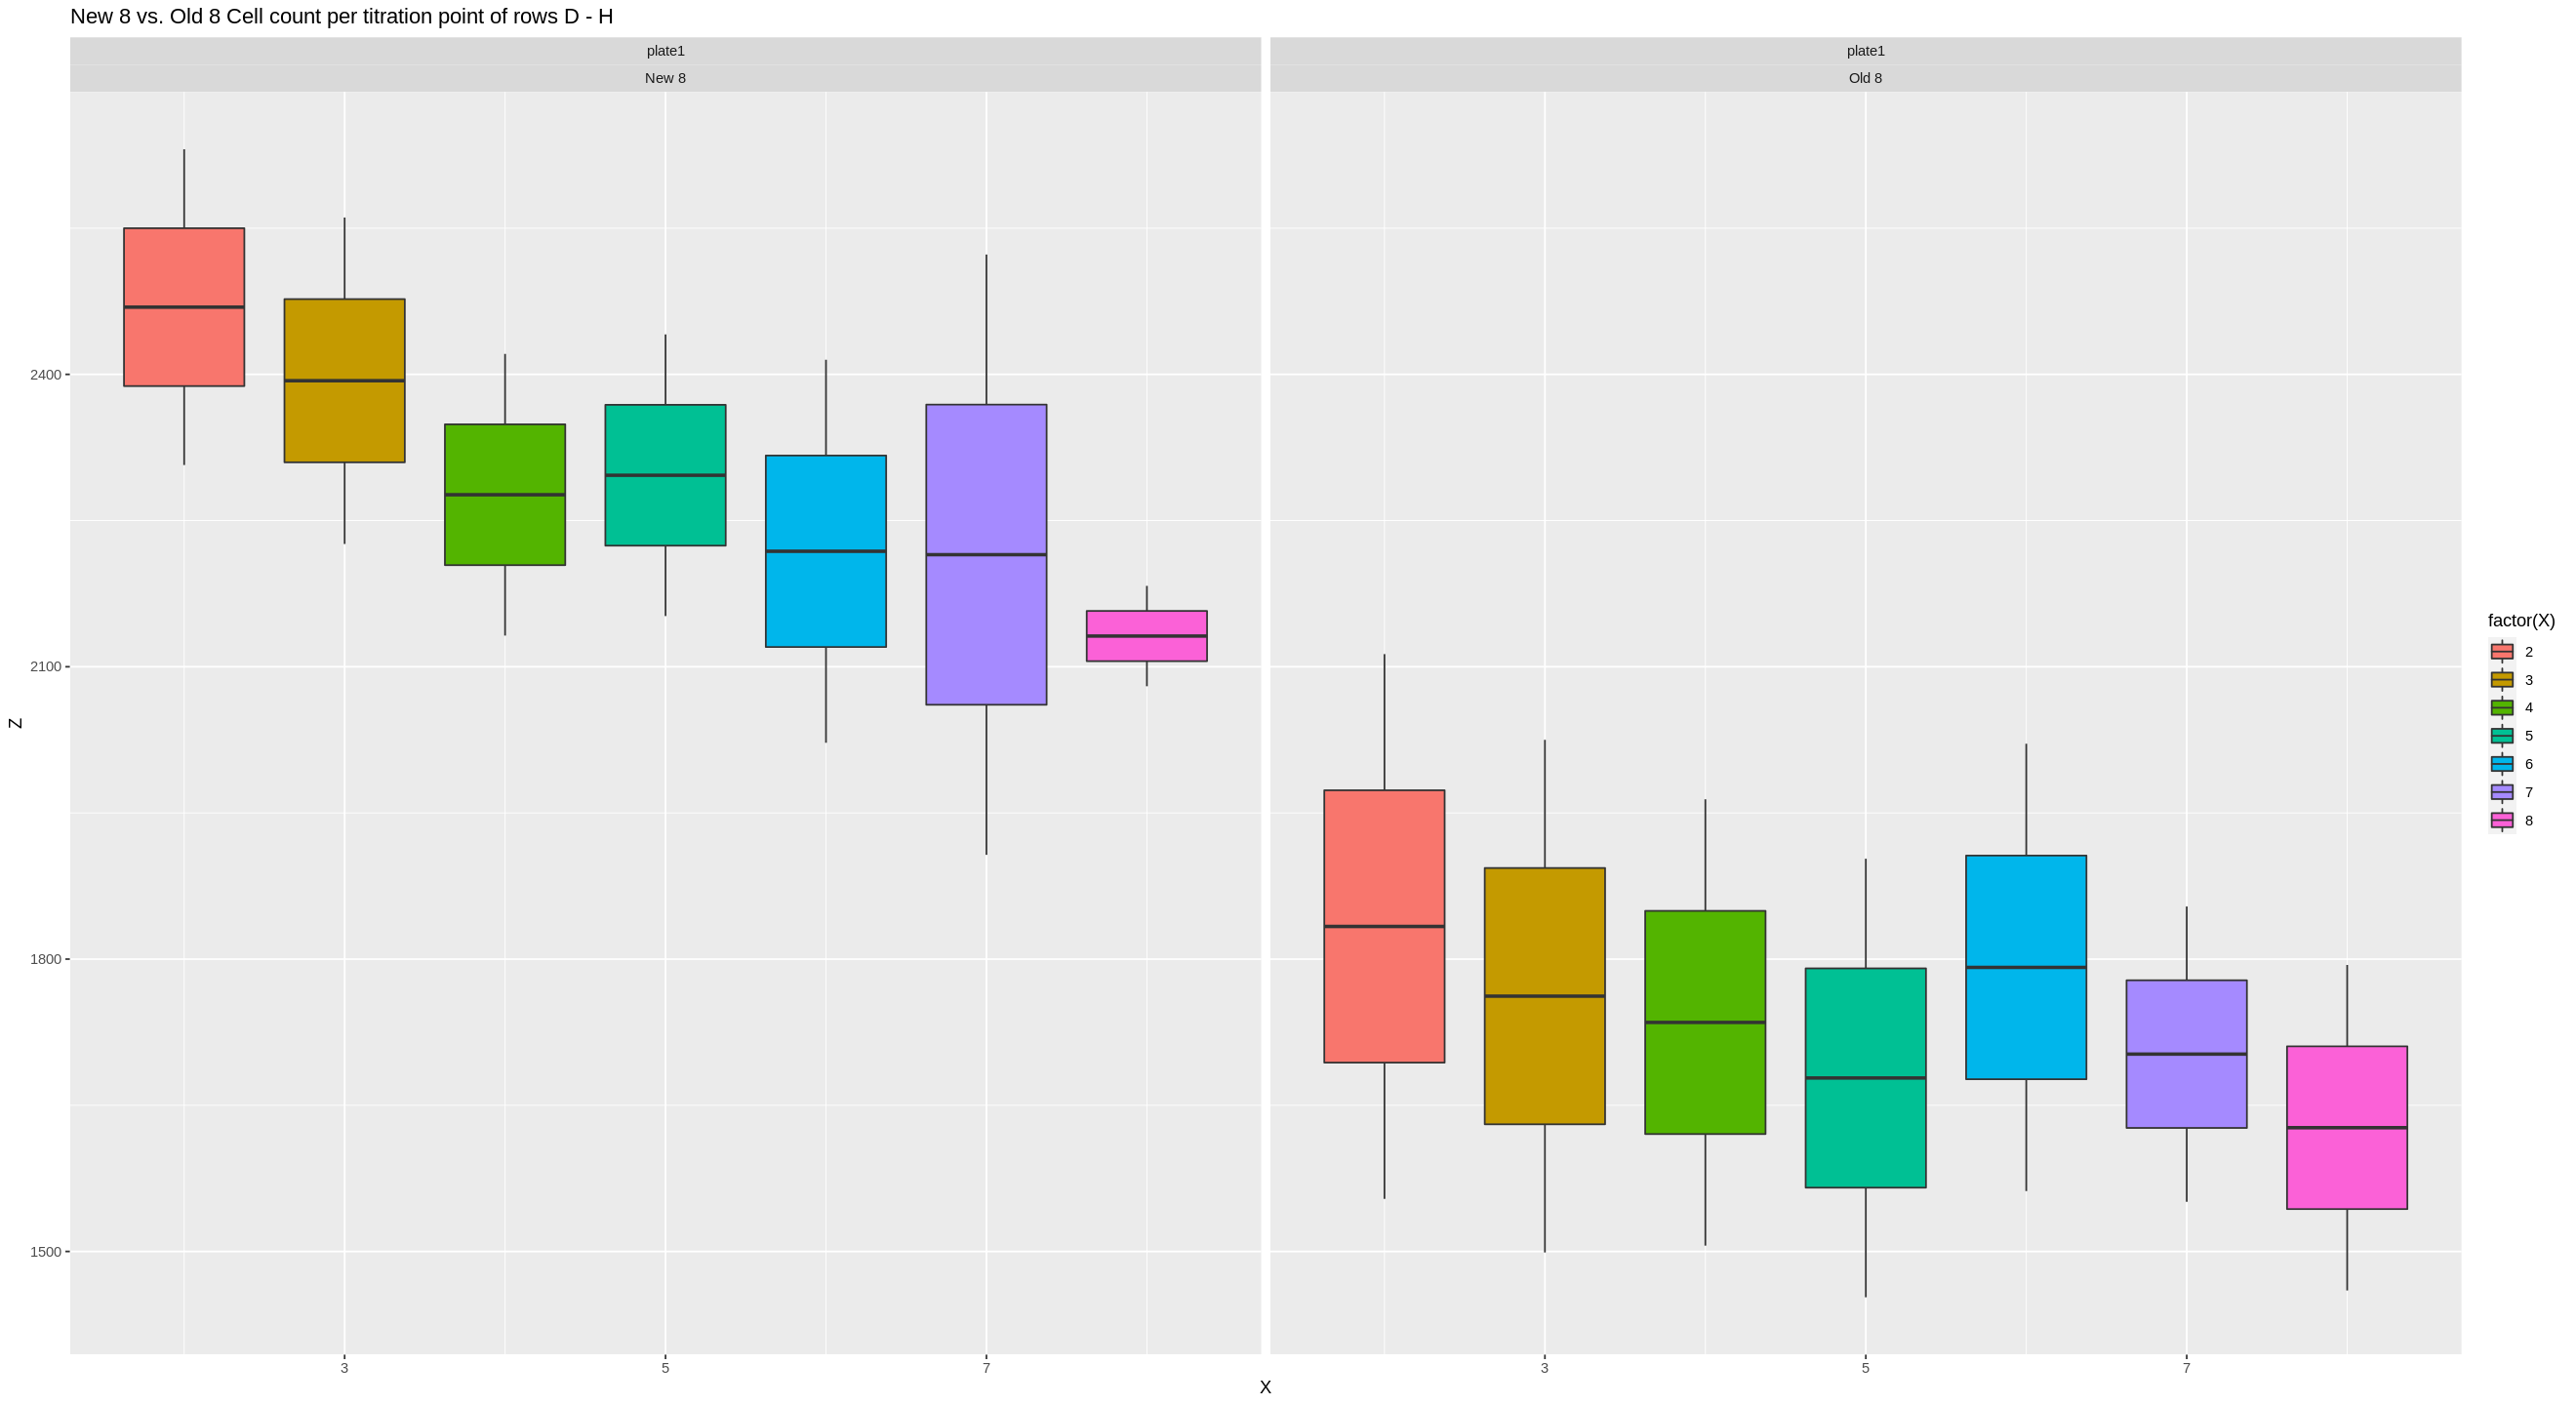

In [74]:
# D-H old 8 vs new 8
idx = c(4,8,12)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste("New 8 vs. Old 8 rows:", pat1, "-", pat2))

dff <- bind_rows(df.old, df.new)  %>% filter(Y == pat1 | Y == pat2)

ggplot(dff, aes(x=X,y=Z, group = X, fill = factor(X))) +
  geom_boxplot() + 
  labs(title=paste("New 8 vs. Old 8 Cell count per titration point of rows", pat1, "-", pat2)) +
  facet_wrap(plate~method, ncol = 2)

In [11]:
#df_boxp_new8_ls <- do.call(rbind, df_boxp_new8_ls) %>% 
#                    mutate(method = "New")
#
#df_boxp_old8_ls <- do.call(rbind, df_boxp_old8_ls) %>% 
#                    mutate(method = "Old")
#
#dff <- rbind(df_boxp_new8_ls, df_boxp_old8_ls)

[1] "New 8 vs. Old 8 rows: C - G"


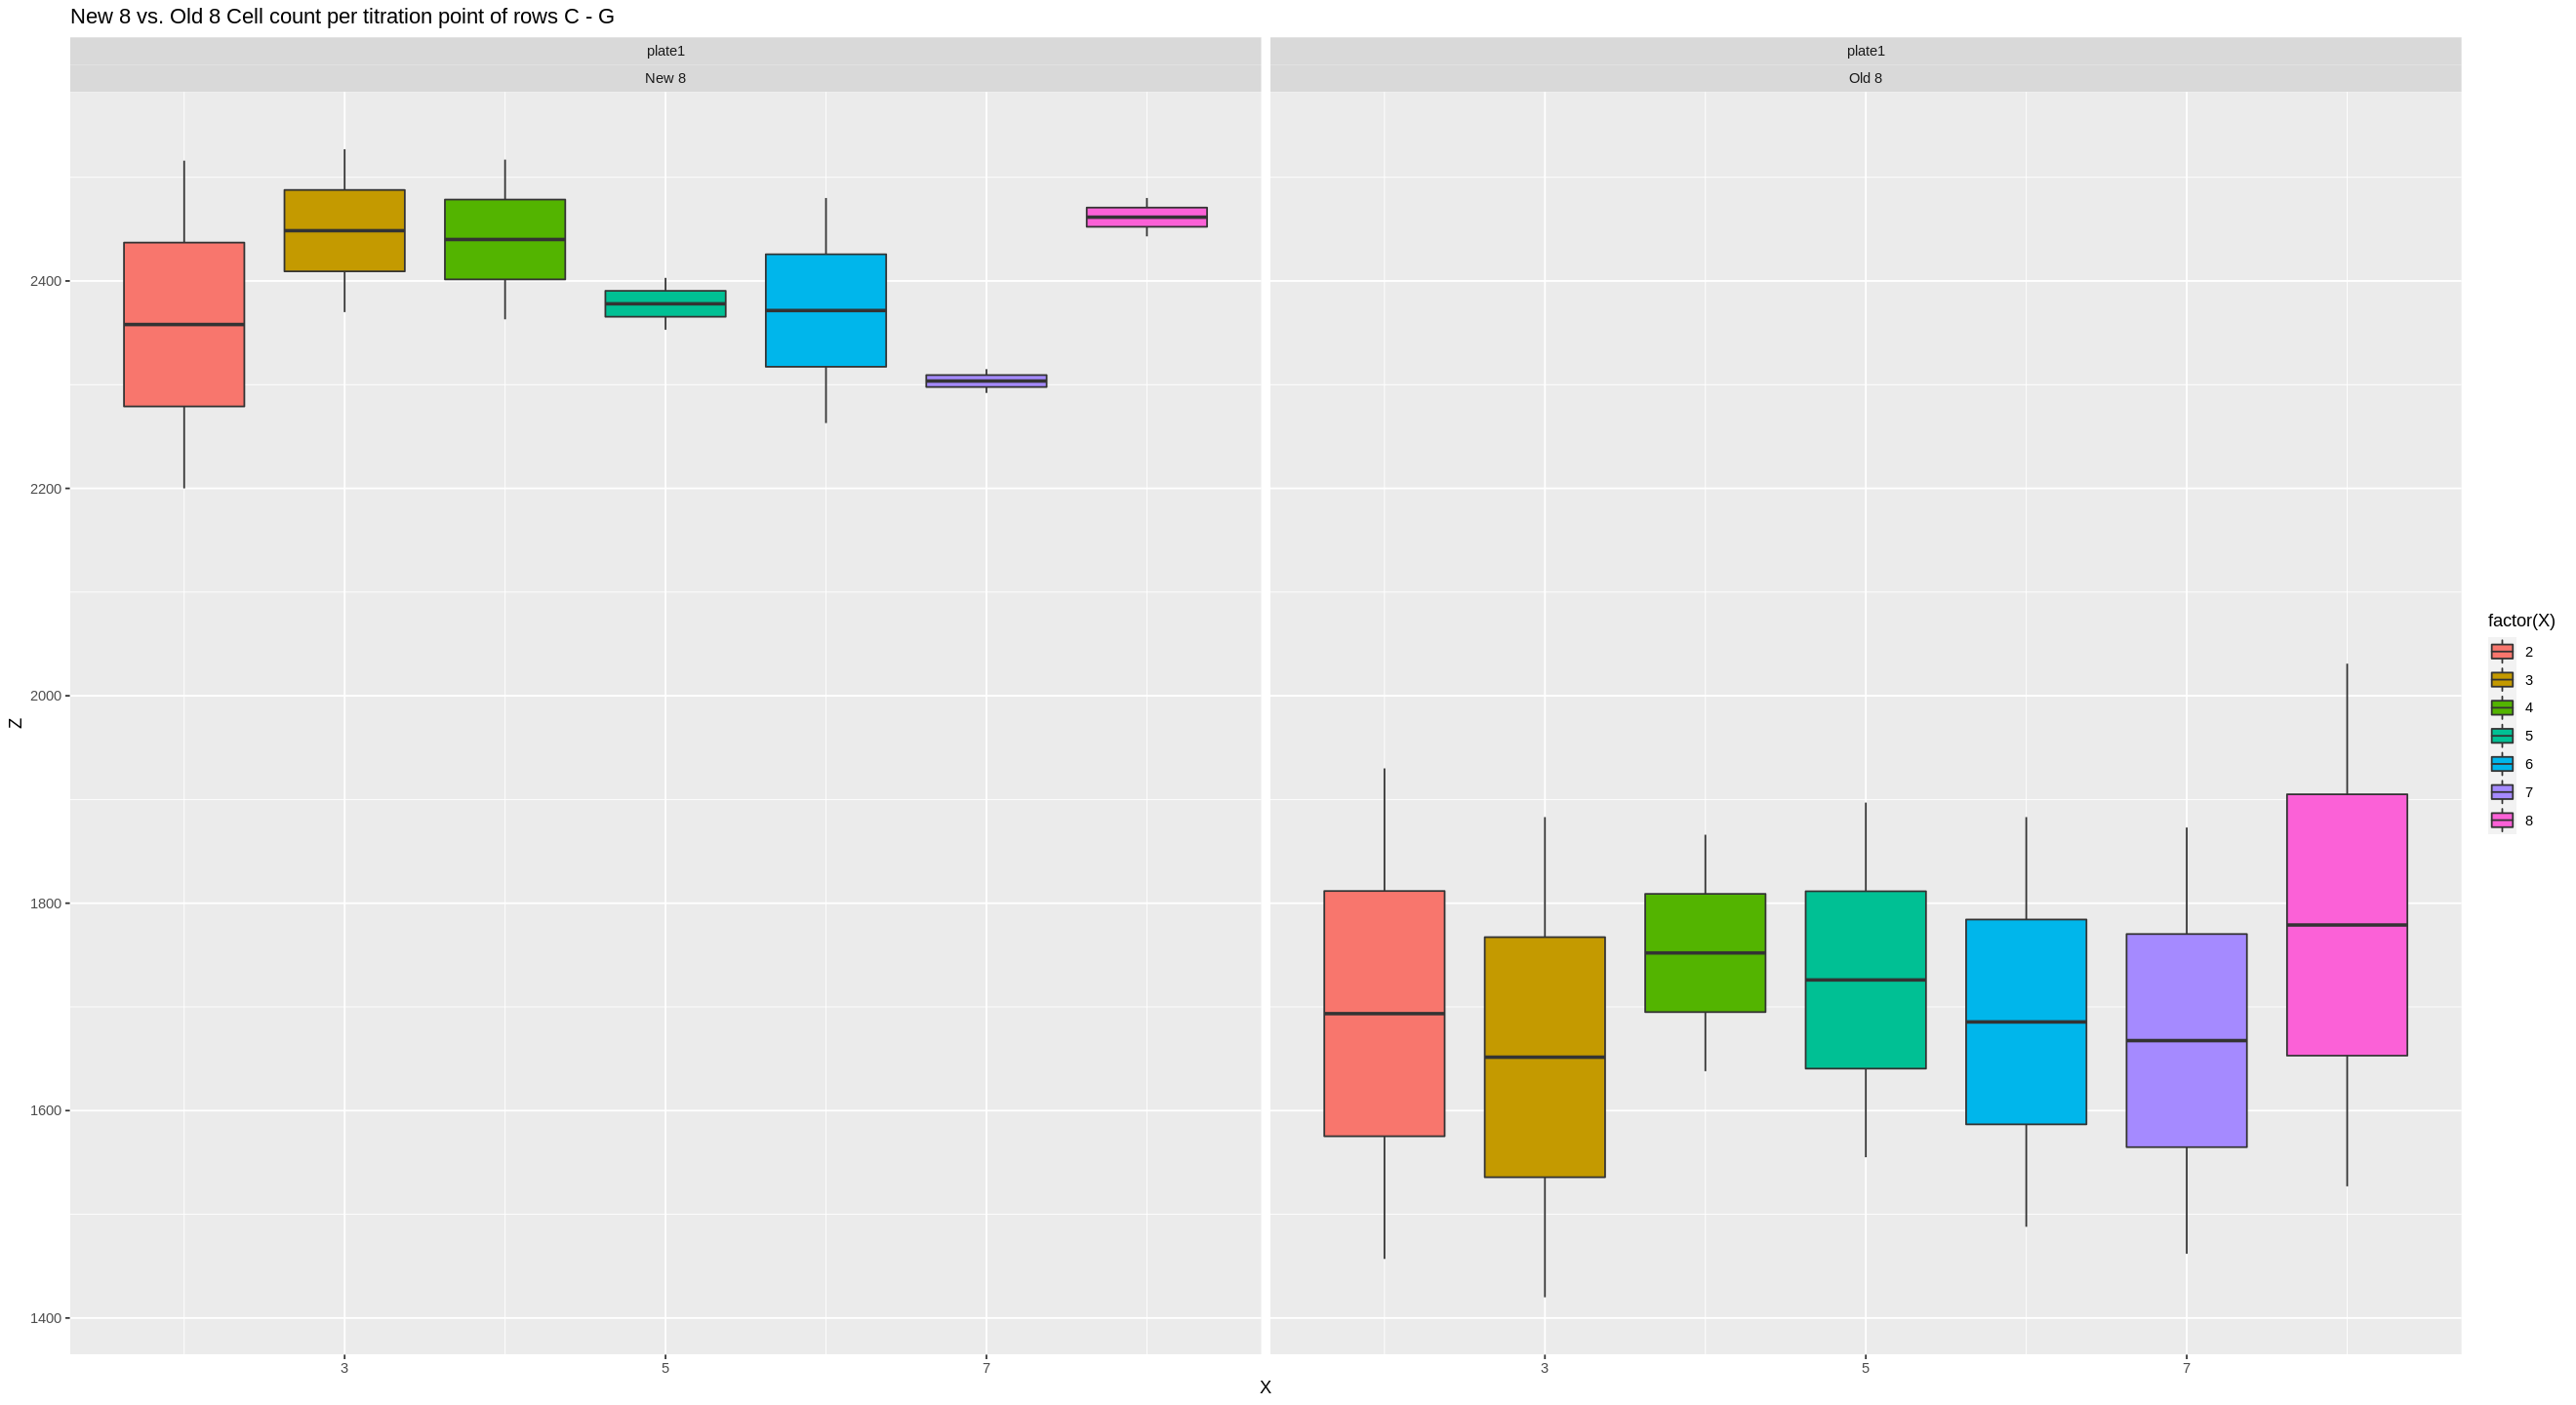

In [75]:
# C-G old 8 vs new 8
idx = c(3,7,11)
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste("New 8 vs. Old 8 rows:", pat1, "-", pat2))

dff <- bind_rows(df.old, df.new)  %>% filter(Y == pat1 | Y == pat2)

ggplot(dff, aes(x=X,y=Z, group = X, fill = factor(X))) +
  geom_boxplot() + 
  labs(title=paste("New 8 vs. Old 8 Cell count per titration point of rows", pat1, "-", pat2)) +
  facet_wrap(plate~method, ncol = 2)

[1] "New 8 vs. Old 8 rows: B - F"


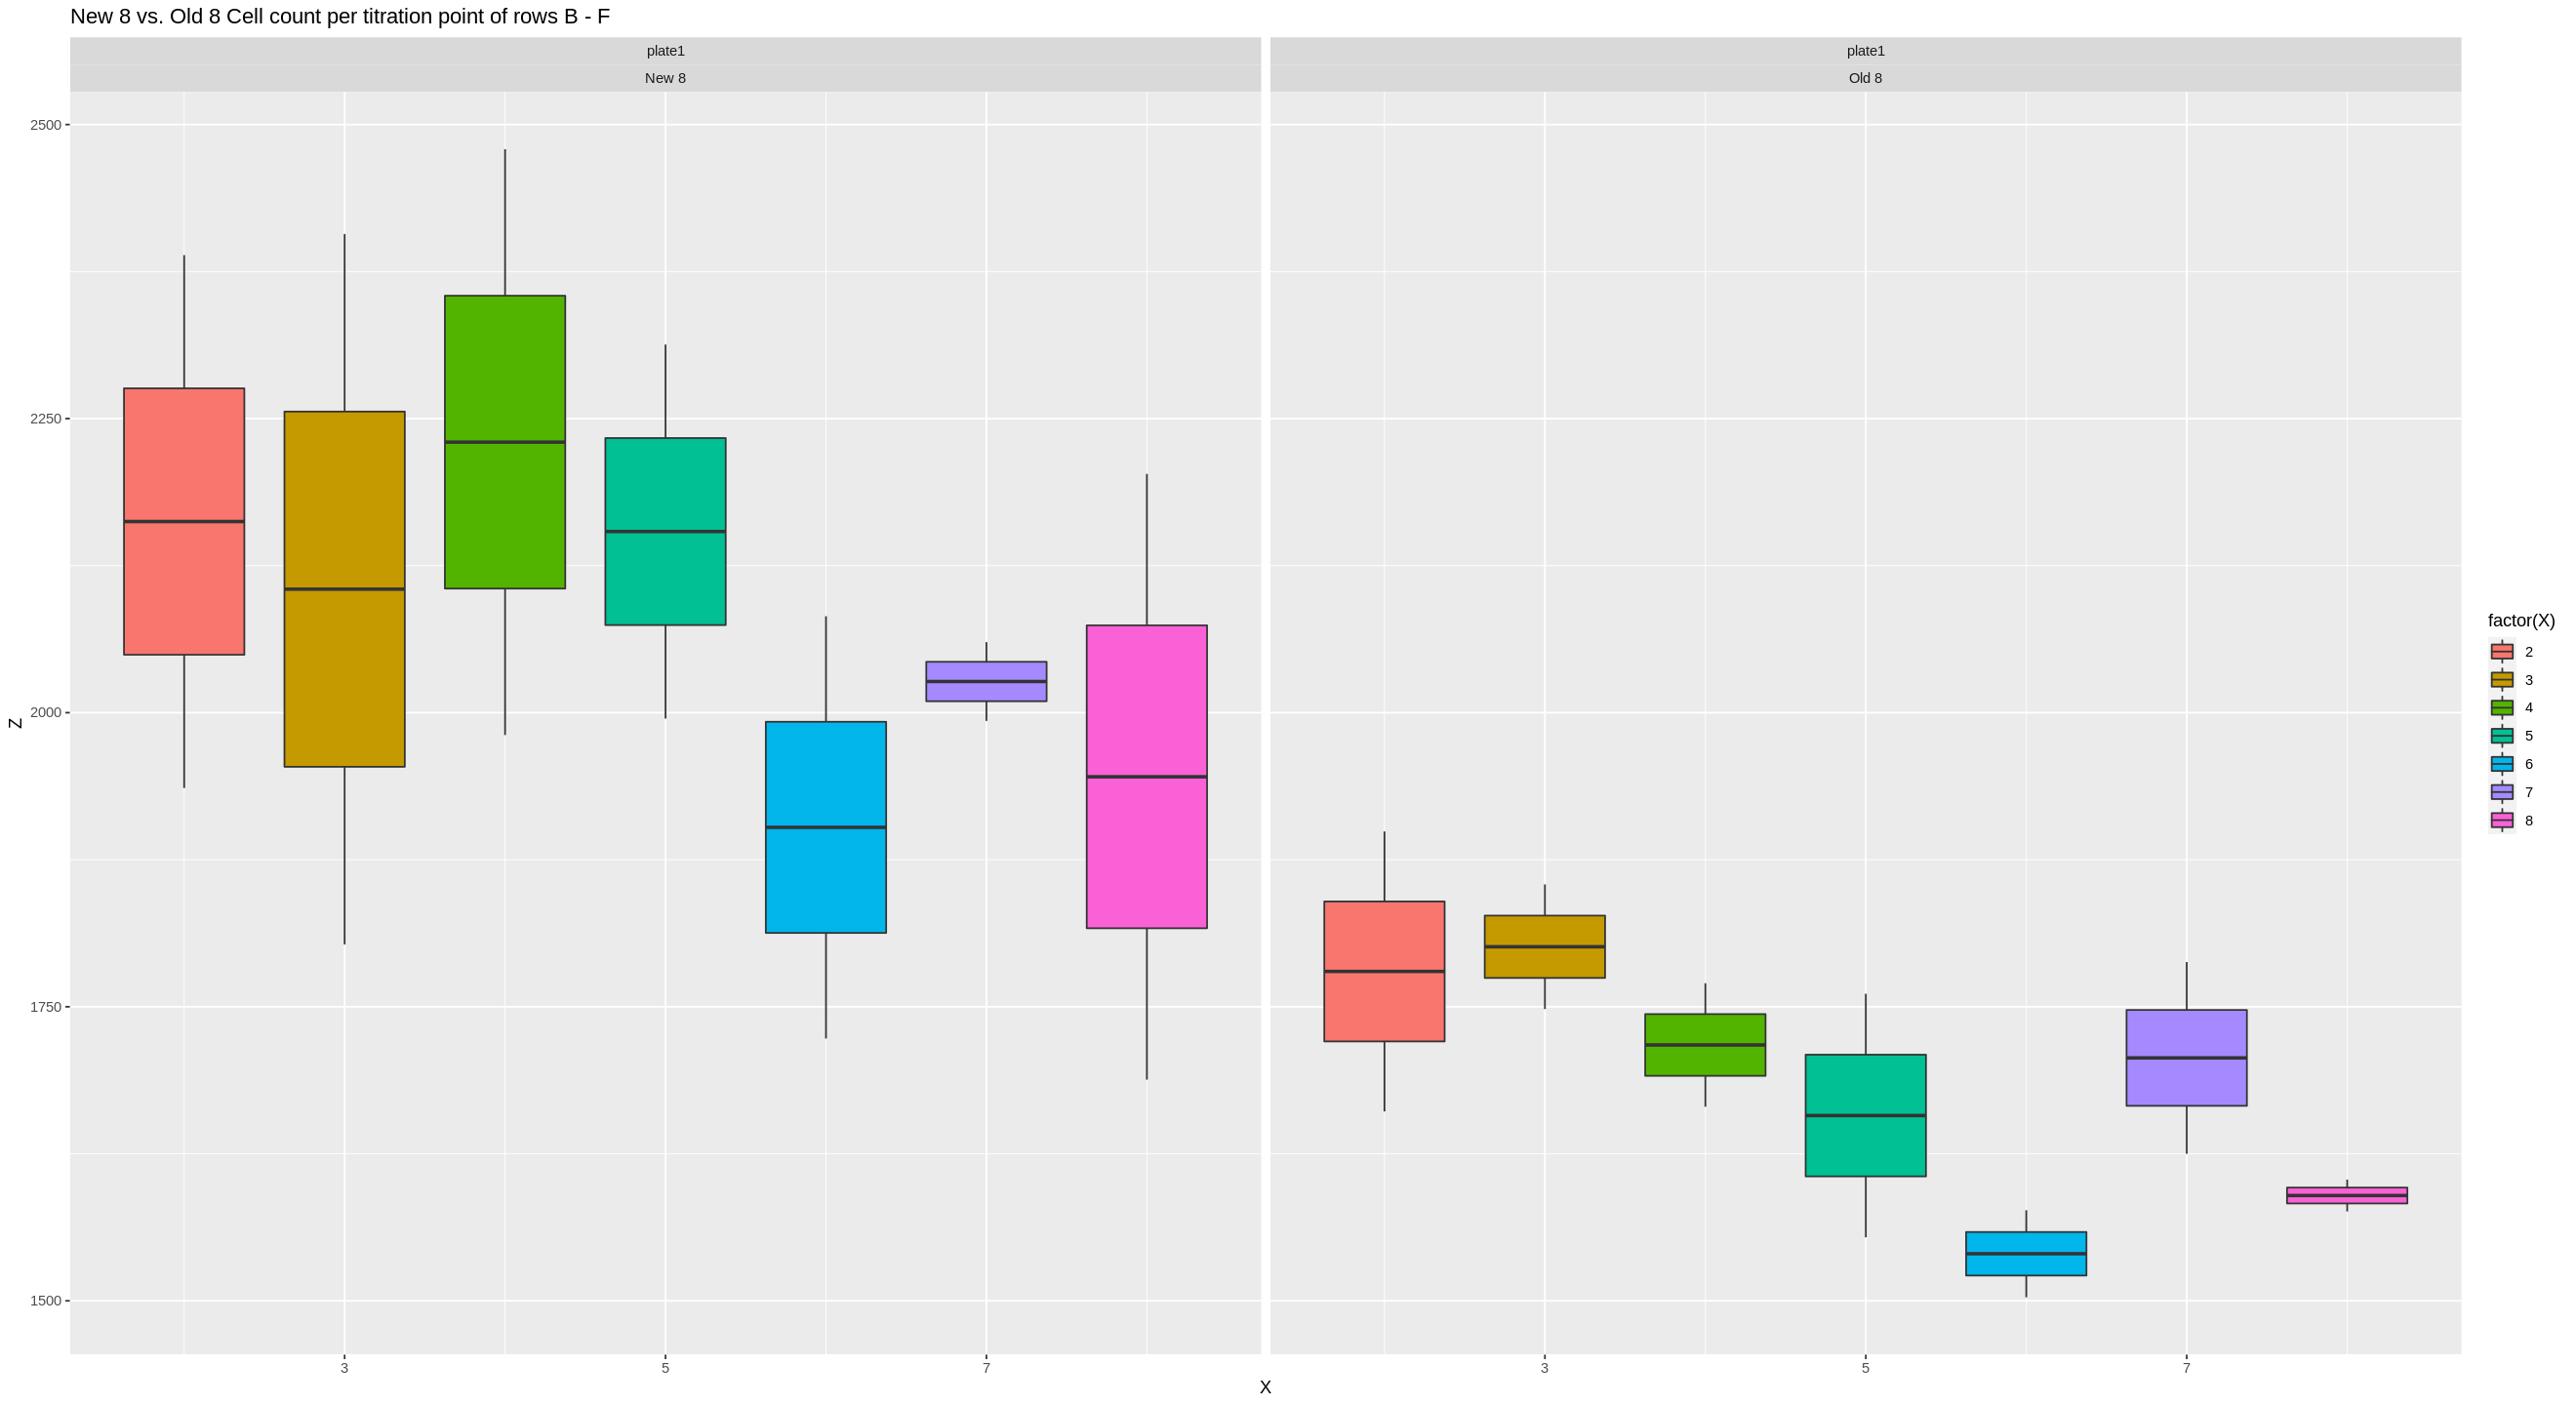

In [76]:
# B-F old 8 vs new 8
idx = c(2,6,10)
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste("New 8 vs. Old 8 rows:", pat1, "-", pat2))

dff <- bind_rows(df.old, df.new)  %>% filter(Y == pat1 | Y == pat2)

ggplot(dff, aes(x=X,y=Z, group = X, fill = factor(X))) +
  geom_boxplot() + 
  labs(title=paste("New 8 vs. Old 8 Cell count per titration point of rows", pat1, "-", pat2)) +
  facet_wrap(plate~method, ncol = 2)

[1] "New 8 vs. Old 8 rows: A - E"


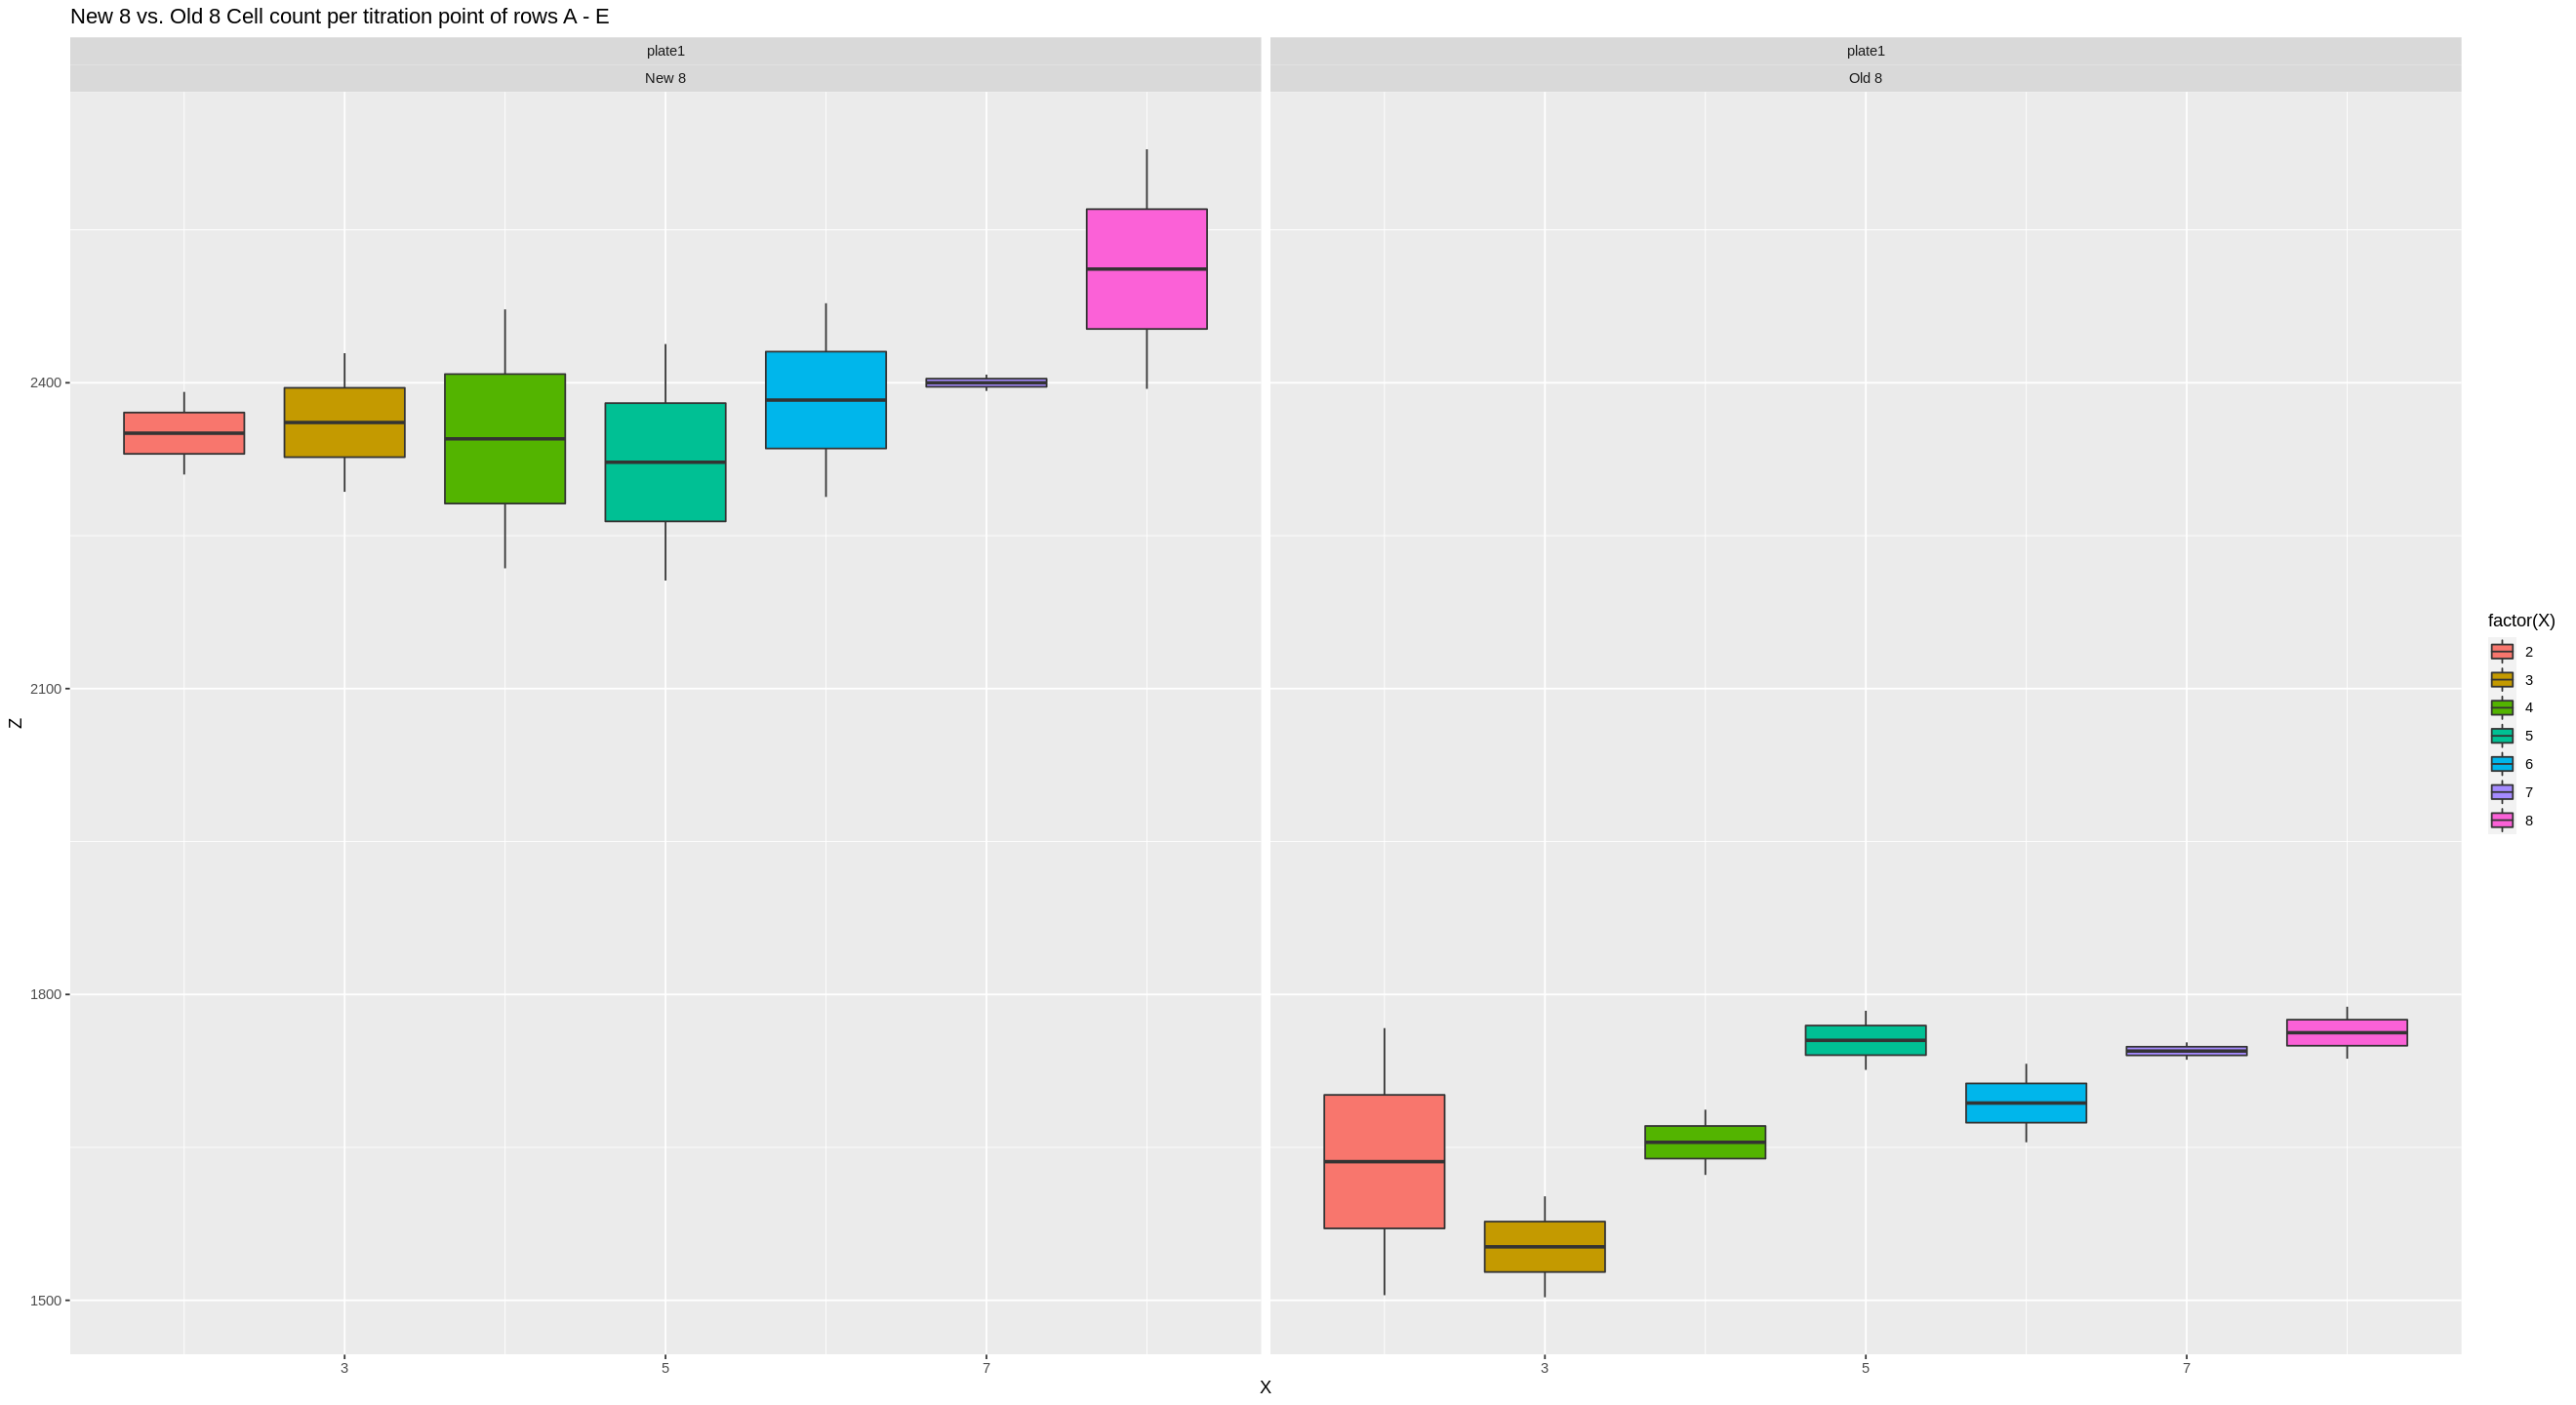

In [77]:
# A-E old 8 vs new 8
idx = c(1,5,9)
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste("New 8 vs. Old 8 rows:", pat1, "-", pat2))

dff <- bind_rows(df.old, df.new)  %>% filter(Y == pat1 | Y == pat2)

ggplot(dff, aes(x=X,y=Z, group = X, fill = factor(X))) +
  geom_boxplot() + 
  labs(title=paste("New 8 vs. Old 8 Cell count per titration point of rows", pat1, "-", pat2)) +
  facet_wrap(plate~method, ncol = 2)

### combine all data to make general boxplot

In [190]:
dff <- rbind(do.call(rbind, dfn_sub_ls) %>%
             mutate(method = "NEW 8"), do.call(rbind, dfo_sub_ls) %>%
             mutate(method = "OLD 8")) %>%
        
       mutate(subgroup = case_when(
           Y == "A" & X == 2 ~ "A2-E2",
           Y == "A" & X == 3 ~ "A3-E3",
           Y == "A" & X == 4 ~ "A4-E4",
           Y == "A" & X == 5 ~ "A5-E5",
           Y == "A" & X == 6 ~ "A6-E6",
           Y == "A" & X == 7 ~ "A7-E7",
           Y == "A" & X == 8 ~ "A8-E8",
           Y == "B" & X == 2 ~ "B2-F2",
           Y == "B" & X == 3 ~ "B3-F3",
           Y == "B" & X == 4 ~ "B4-F4",
           Y == "B" & X == 5 ~ "B5-F5",
           Y == "B" & X == 6 ~ "B6-F6",
           Y == "B" & X == 7 ~ "B7-F7",
           Y == "B" & X == 8 ~ "B8-F8",
           Y == "C" & X == 2 ~ "C2-G2",
           Y == "C" & X == 3 ~ "C3-G3",
           Y == "C" & X == 4 ~ "C4-G4",
           Y == "C" & X == 5 ~ "C5-G5",
           Y == "C" & X == 6 ~ "C6-G6",
           Y == "C" & X == 7 ~ "C7-G7",
           Y == "C" & X == 8 ~ "C8-G8",
           Y == "D" & X == 2 ~ "D2-H2",
           Y == "D" & X == 3 ~ "D3-H3",
           Y == "D" & X == 4 ~ "D4-H4",
           Y == "D" & X == 5 ~ "D5-H5",
           Y == "D" & X == 6 ~ "D6-H6",
           Y == "D" & X == 7 ~ "D7-H7",
           Y == "D" & X == 8 ~ "D8-H8",
           Y == "E" & X == 2 ~ "A2-E2",
           Y == "E" & X == 3 ~ "A3-E3",
           Y == "E" & X == 4 ~ "A4-E4",
           Y == "E" & X == 5 ~ "A5-E5",
           Y == "E" & X == 6 ~ "A6-E6",
           Y == "E" & X == 7 ~ "A7-E7",
           Y == "E" & X == 8 ~ "A8-E8",
           Y == "F" & X == 2 ~ "B2-F2",
           Y == "F" & X == 3 ~ "B3-F3",
           Y == "F" & X == 4 ~ "B4-F4",
           Y == "F" & X == 5 ~ "B5-F5",
           Y == "F" & X == 6 ~ "B6-F6",
           Y == "F" & X == 7 ~ "B7-F7",
           Y == "F" & X == 8 ~ "B8-F8",
           Y == "G" & X == 2 ~ "C2-G2",
           Y == "G" & X == 3 ~ "C3-G3",
           Y == "G" & X == 4 ~ "C4-G4",
           Y == "G" & X == 5 ~ "C5-G5",
           Y == "G" & X == 6 ~ "C6-G6",
           Y == "G" & X == 7 ~ "C7-G7",
           Y == "G" & X == 8 ~ "C8-G8",
           Y == "H" & X == 2 ~ "D2-H2",
           Y == "H" & X == 3 ~ "D3-H3",
           Y == "H" & X == 4 ~ "D4-H4",
           Y == "H" & X == 5 ~ "D5-H5",
           Y == "H" & X == 6 ~ "D6-H6",
           Y == "H" & X == 7 ~ "D7-H7",
           Y == "H" & X == 8 ~ "D8-H8"
           )
          ) %>%
    mutate(wellid = paste0(Y, X))

In [191]:
head(dff)

X Y Z    method subgroup wellid
1 2 A 2391 NEW 8  A2-E2    A2    
2 3 A 2429 NEW 8  A3-E3    A3    
3 4 A 2472 NEW 8  A4-E4    A4    
4 5 A 2438 NEW 8  A5-E5    A5    
5 6 A 2478 NEW 8  A6-E6    A6    
6 7 A 2392 NEW 8  A7-E7    A7

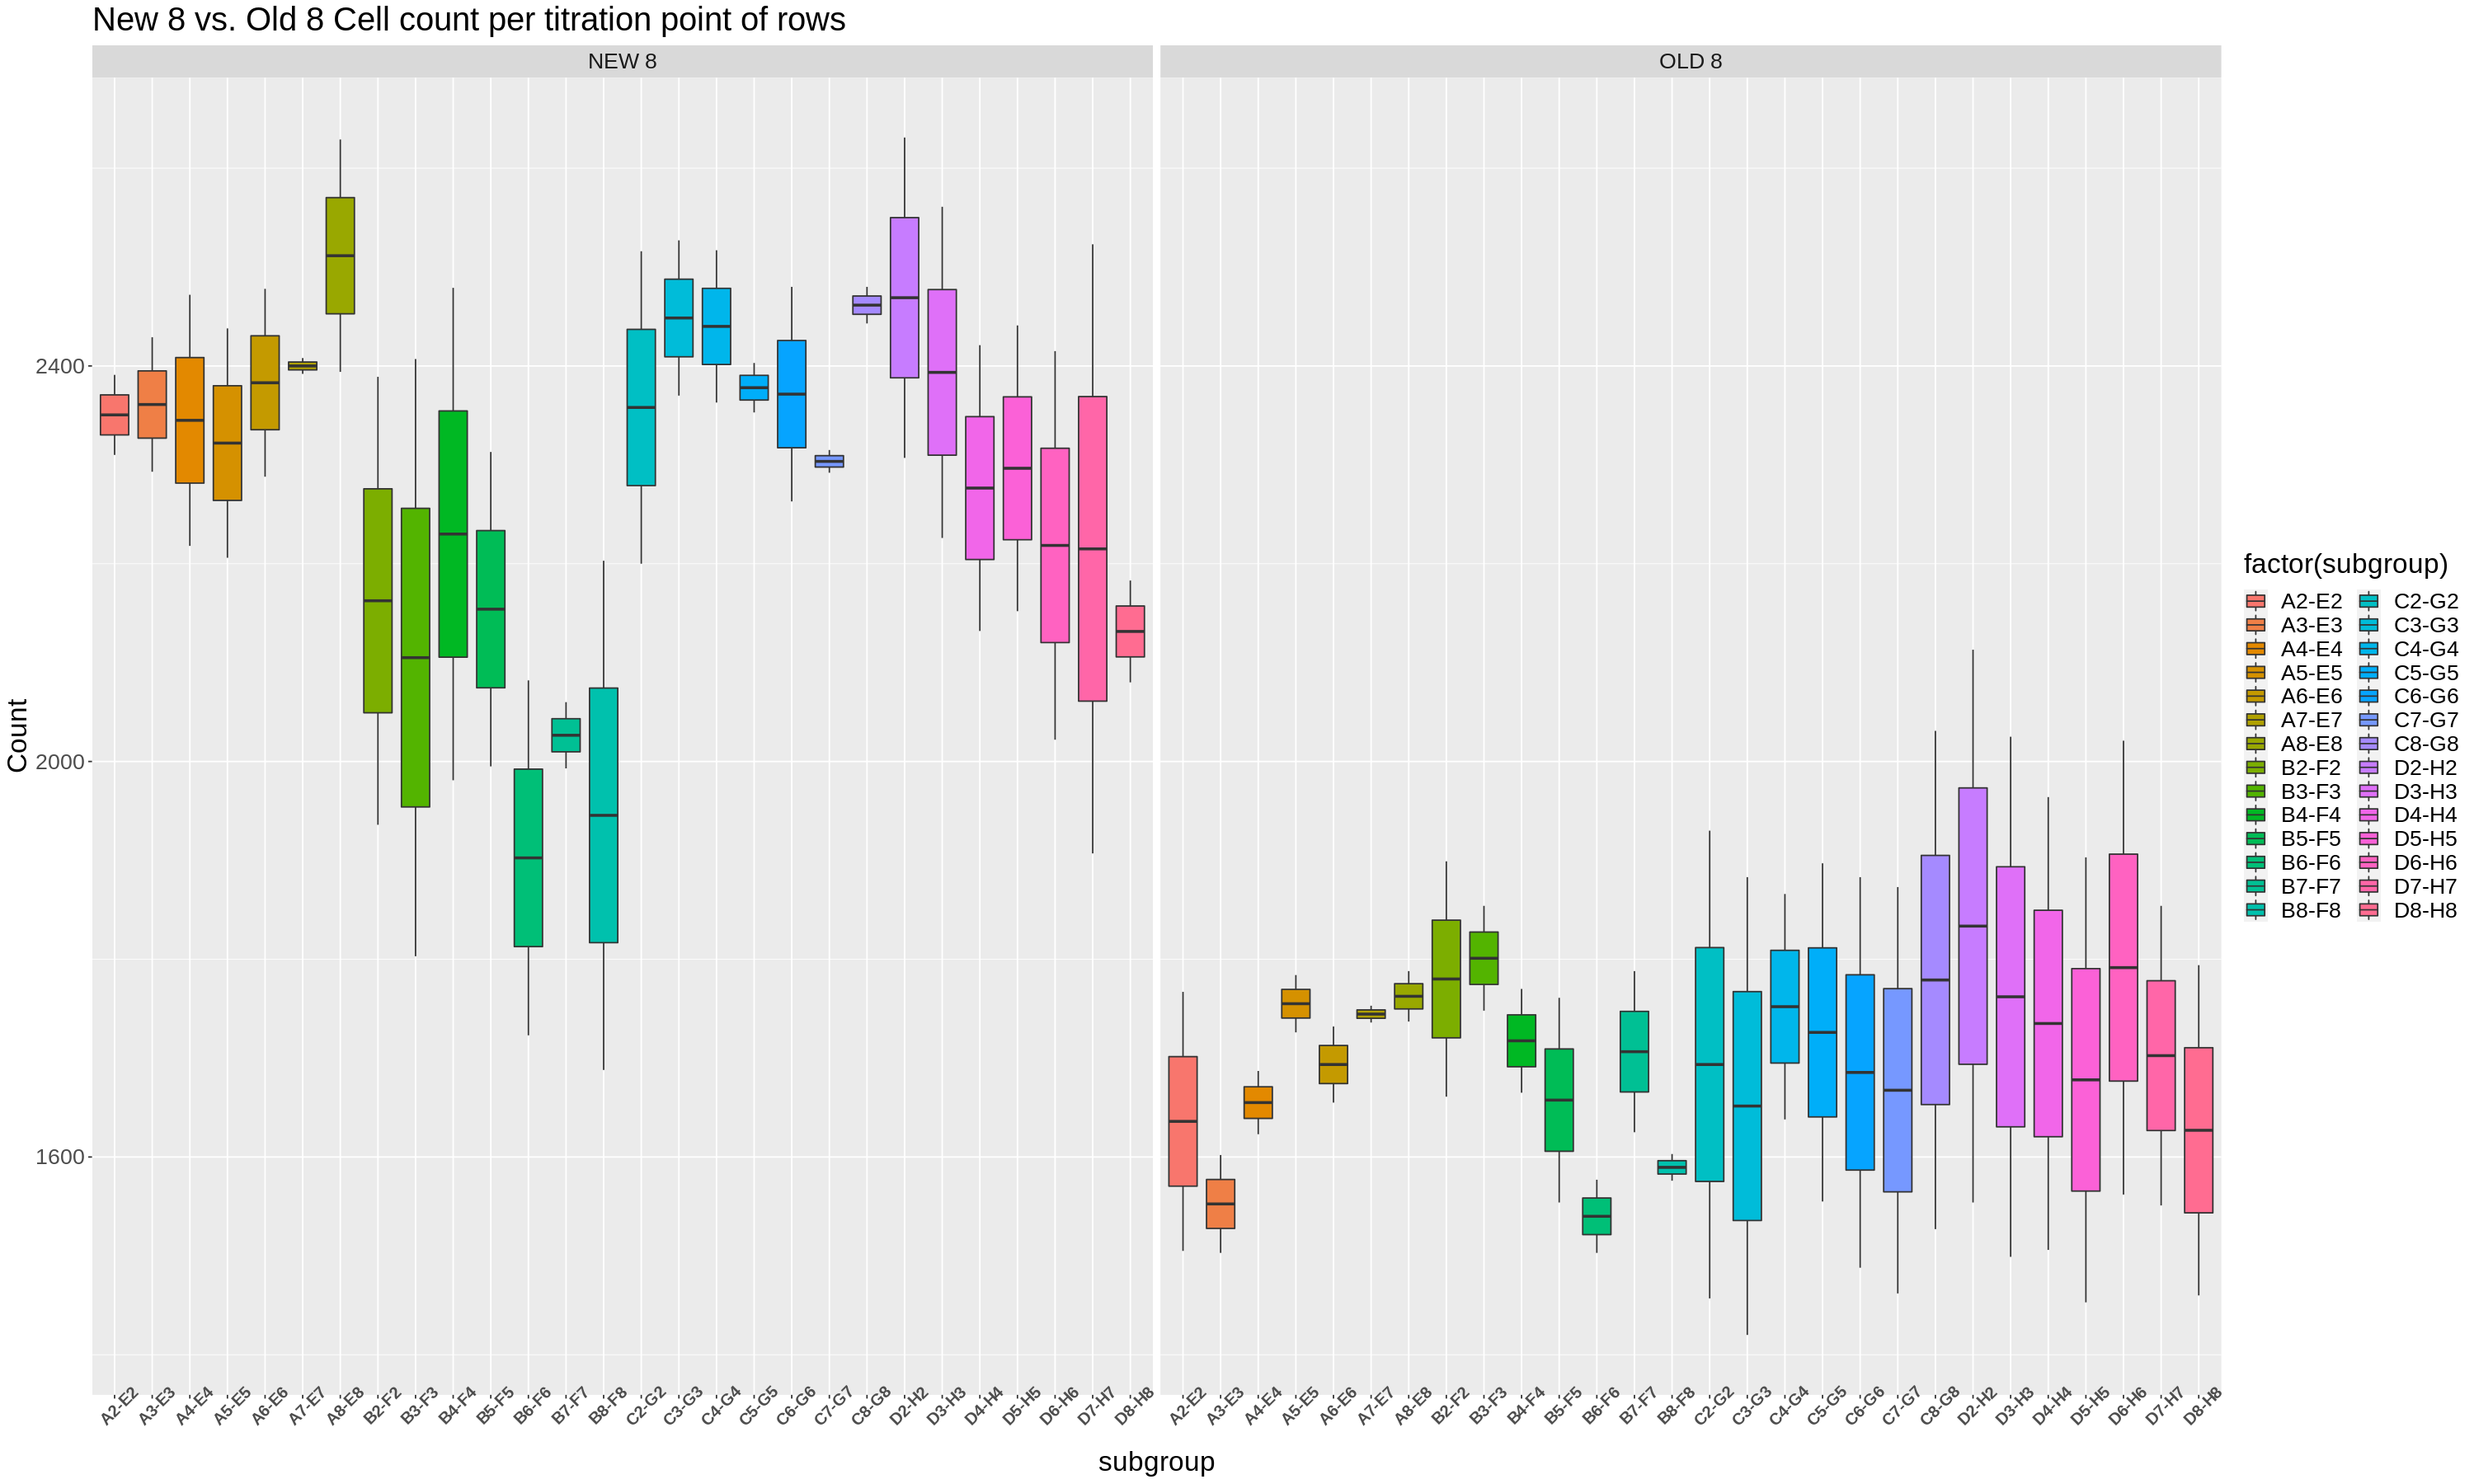

In [197]:
ggplot(dff, aes(x=subgroup,y=Z, fill = factor(subgroup))) +
  geom_boxplot() + 
  labs(title="New 8 vs. Old 8 Cell count per titration point of rows") +
  ylab("Count") +
  facet_wrap(~method) + 
  theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12, angle = 45)) 

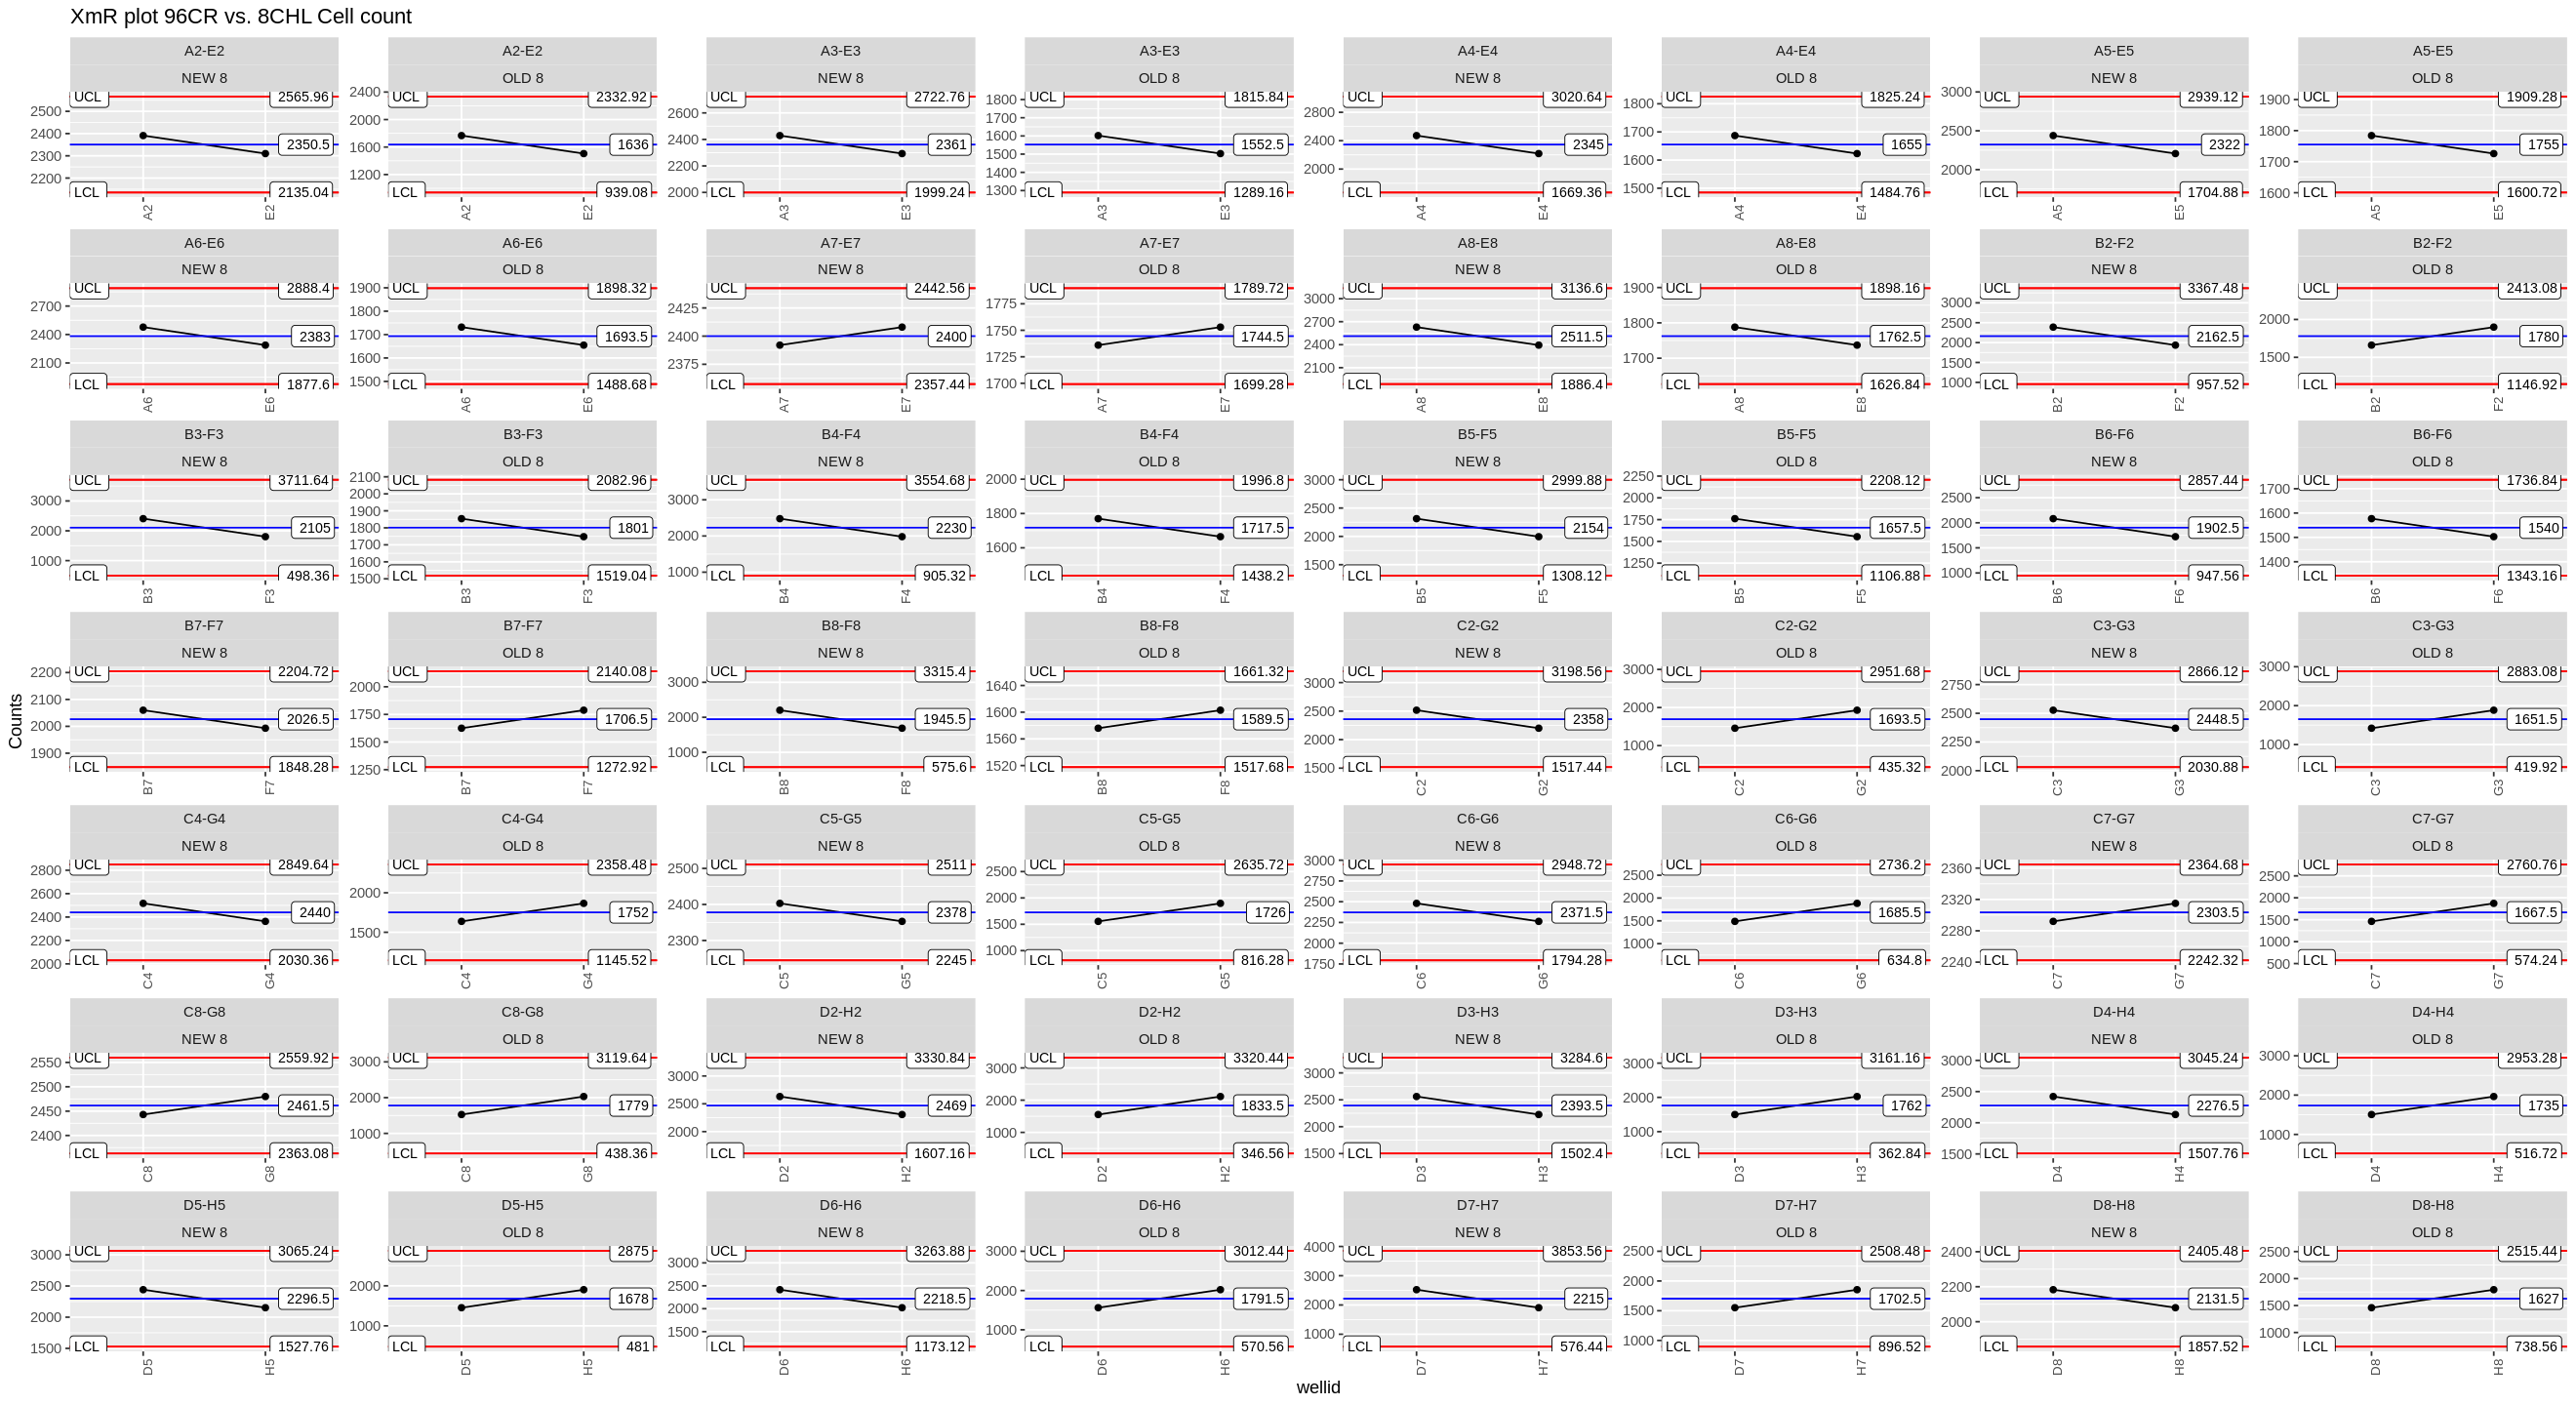

In [81]:
ggplot(dff, aes(x=wellid, y=Z, group=subgroup)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 4) + 
  ylab("Counts") +
  facet_wrap(subgroup~method, scales = "free") +
  ggtitle("XmR plot 96CR vs. 8CHL Cell count") + 
  theme(axis.text.x = element_text(size = 8, angle = 90))

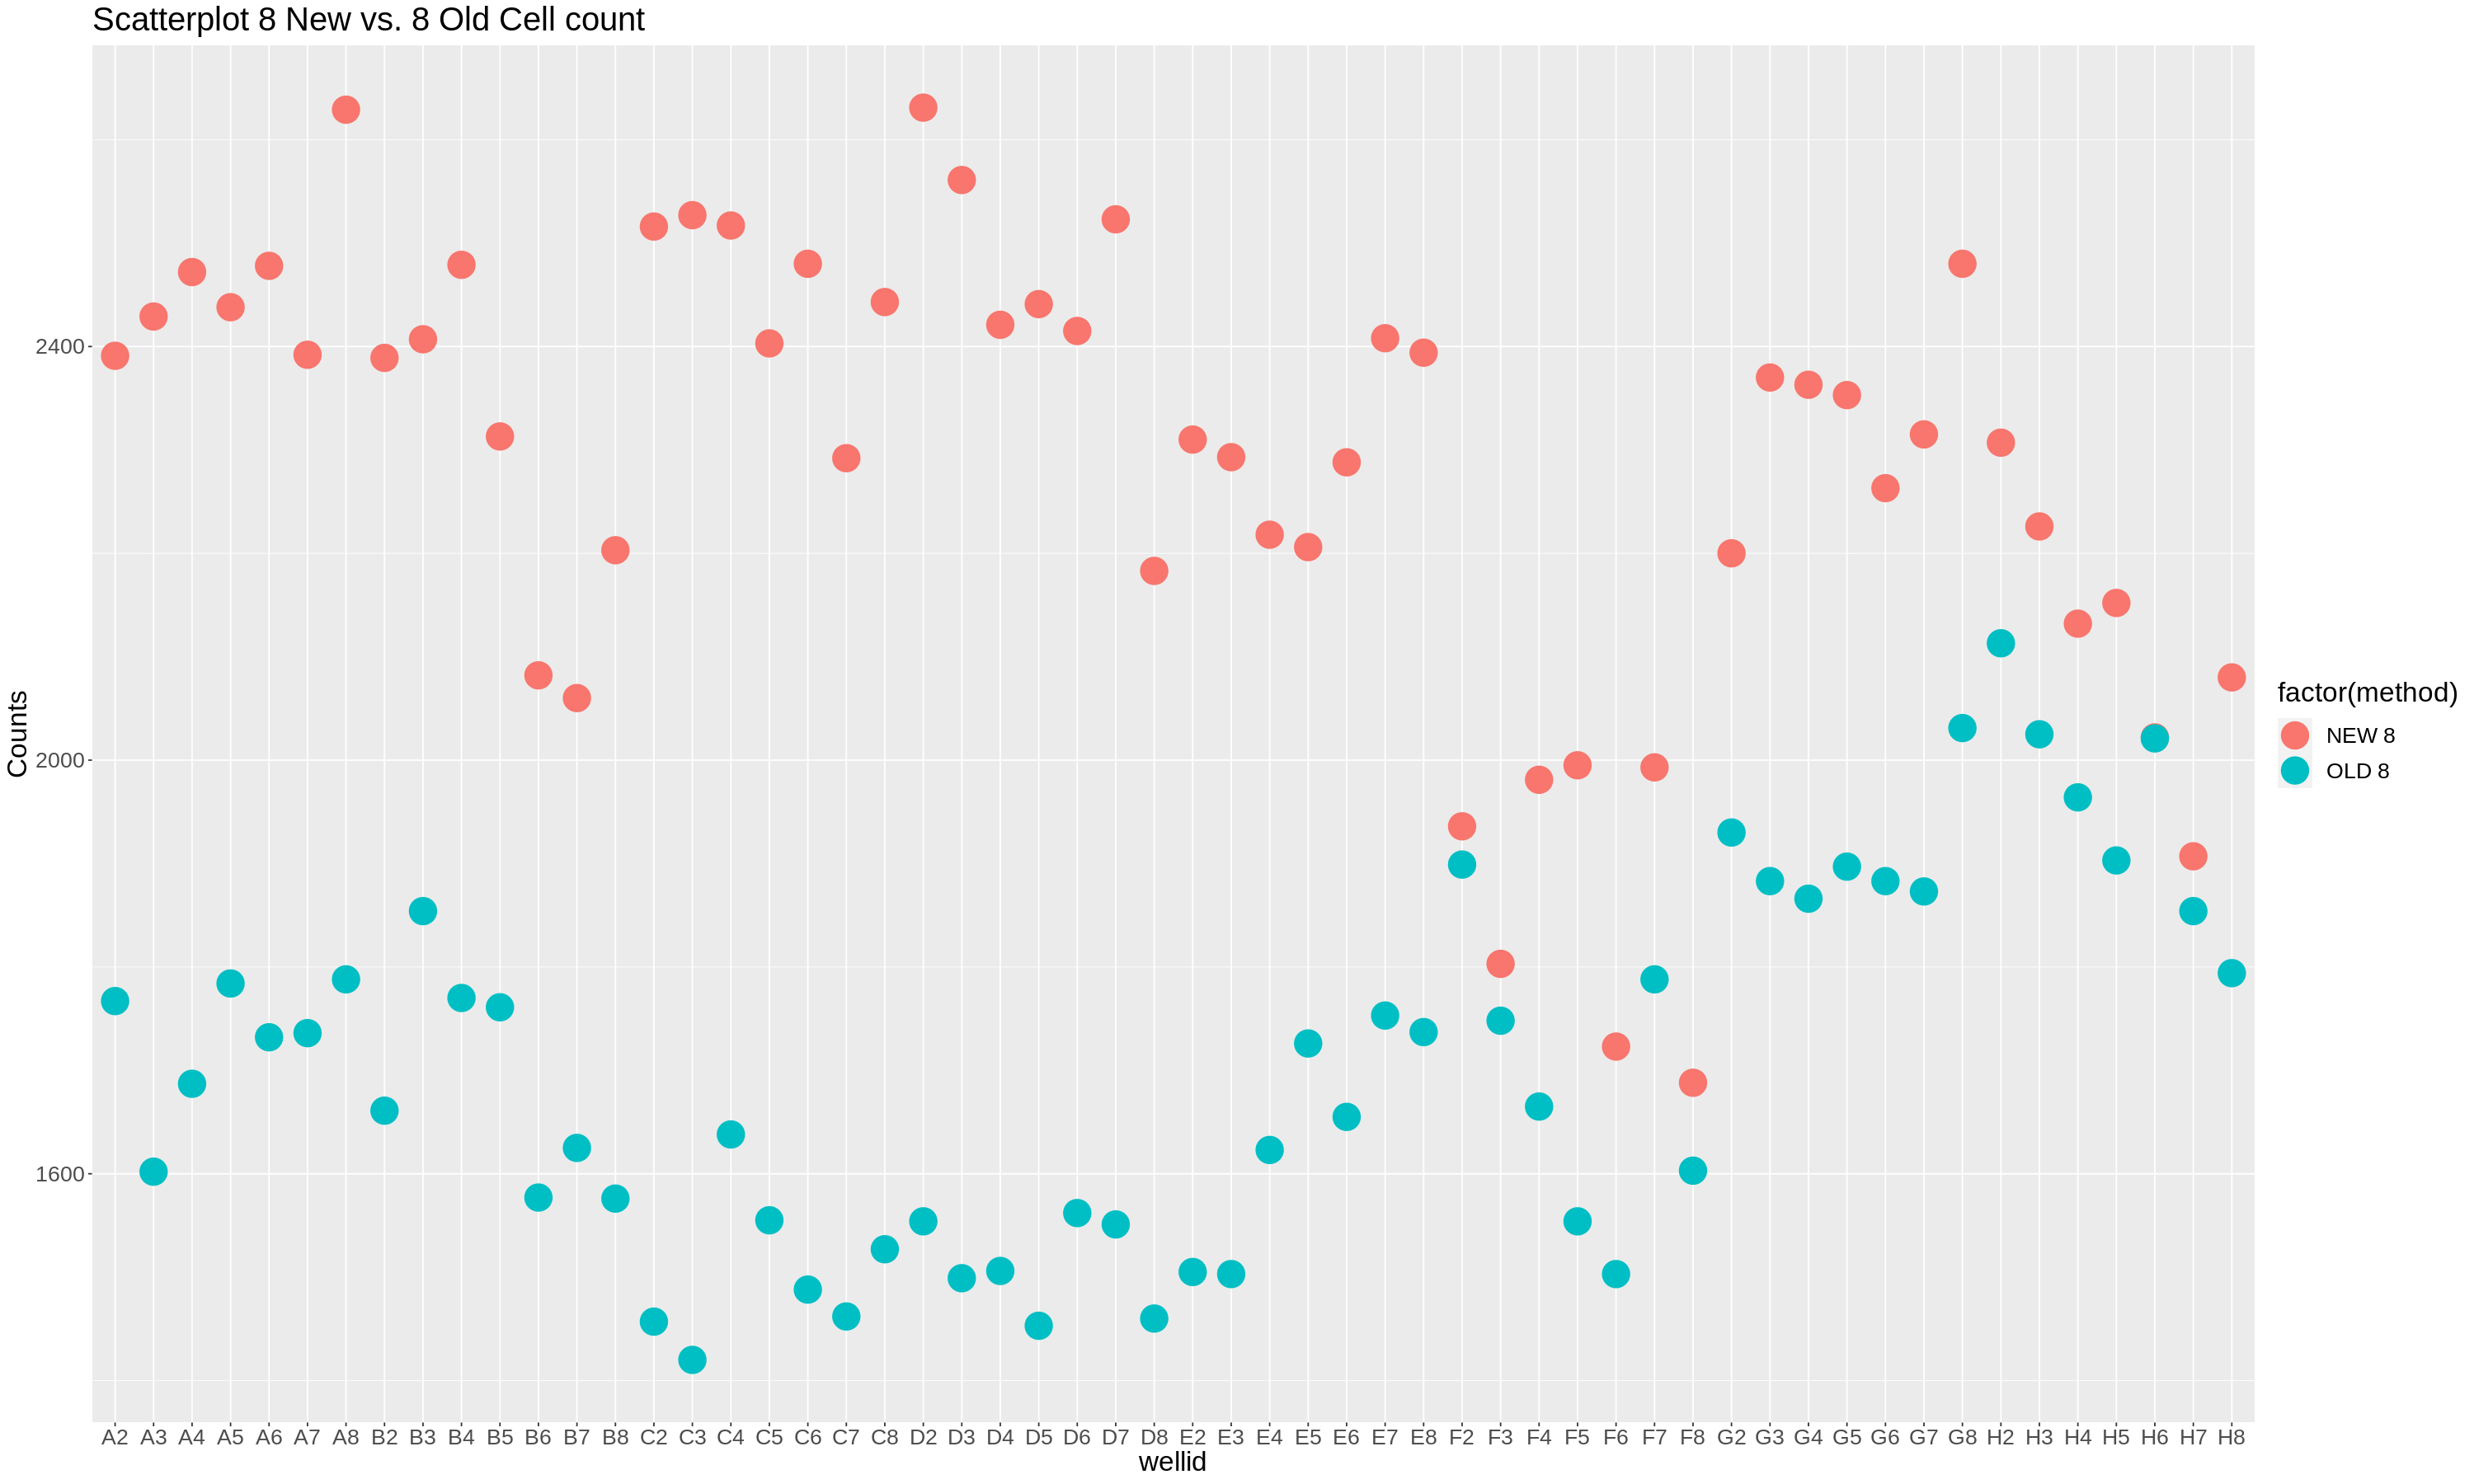

In [198]:
ggplot(dff, aes(x=wellid, y=Z) ) +
  geom_point(size = 9, aes(colour = factor(method))) + 
  ylab("Counts") +
  ggtitle("Scatterplot 8 New vs. 8 Old Cell count") +
  theme(text = element_text(size=20))

#### Summary statistics for new 8 

In [83]:
# A-E new 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(1,5,9)
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

print(paste("New 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.new %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "New 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "New 8, 8 rows: A - E"
[1] "A / E : 2"
       Z       
 Min.   :2310  
 1st Qu.:2330  
 Median :2350  
 Mean   :2350  
 3rd Qu.:2371  
 Max.   :2391  
[1] "A / E : 3"
       Z       
 Min.   :2293  
 1st Qu.:2327  
 Median :2361  
 Mean   :2361  
 3rd Qu.:2395  
 Max.   :2429  
[1] "A / E : 4"
       Z       
 Min.   :2218  
 1st Qu.:2282  
 Median :2345  
 Mean   :2345  
 3rd Qu.:2408  
 Max.   :2472  
[1] "A / E : 5"
       Z       
 Min.   :2206  
 1st Qu.:2264  
 Median :2322  
 Mean   :2322  
 3rd Qu.:2380  
 Max.   :2438  
[1] "A / E : 6"
       Z       
 Min.   :2288  
 1st Qu.:2336  
 Median :2383  
 Mean   :2383  
 3rd Qu.:2430  
 Max.   :2478  
[1] "A / E : 7"
       Z       
 Min.   :2392  
 1st Qu.:2396  
 Median :2400  
 Mean   :2400  
 3rd Qu.:2404  
 Max.   :2408  
[1] "A / E : 8"
       Z       
 Min.   :2394  
 1st Qu.:2453  
 Median :2512  
 Mean   :2512  
 3rd Qu.:2570  
 Max.   :2629  


In [84]:
# A-E old 8
summary_ls <- list()
print('summary of each row pair data for old 8')
idx = c(1,5,9)
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste("Old 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.old %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "Old 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for old 8"
[1] "Old 8, 8 rows: A - E"
[1] "A / E : 2"
       Z       
 Min.   :1505  
 1st Qu.:1570  
 Median :1636  
 Mean   :1636  
 3rd Qu.:1702  
 Max.   :1767  
[1] "A / E : 3"
       Z       
 Min.   :1503  
 1st Qu.:1528  
 Median :1552  
 Mean   :1552  
 3rd Qu.:1577  
 Max.   :1602  
[1] "A / E : 4"
       Z       
 Min.   :1623  
 1st Qu.:1639  
 Median :1655  
 Mean   :1655  
 3rd Qu.:1671  
 Max.   :1687  
[1] "A / E : 5"
       Z       
 Min.   :1726  
 1st Qu.:1740  
 Median :1755  
 Mean   :1755  
 3rd Qu.:1770  
 Max.   :1784  
[1] "A / E : 6"
       Z       
 Min.   :1655  
 1st Qu.:1674  
 Median :1694  
 Mean   :1694  
 3rd Qu.:1713  
 Max.   :1732  
[1] "A / E : 7"
       Z       
 Min.   :1736  
 1st Qu.:1740  
 Median :1744  
 Mean   :1744  
 3rd Qu.:1749  
 Max.   :1753  
[1] "A / E : 8"
       Z       
 Min.   :1737  
 1st Qu.:1750  
 Median :1762  
 Mean   :1762  
 3rd Qu.:1775  
 Max.   :1788  


In [85]:
# B-F new 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(2,6,10)
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

print(paste("New 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.new %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "New 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "New 8, 8 rows: B - F"
[1] "B / F : 2"
       Z       
 Min.   :1936  
 1st Qu.:2049  
 Median :2162  
 Mean   :2162  
 3rd Qu.:2276  
 Max.   :2389  
[1] "B / F : 3"
       Z       
 Min.   :1803  
 1st Qu.:1954  
 Median :2105  
 Mean   :2105  
 3rd Qu.:2256  
 Max.   :2407  
[1] "B / F : 4"
       Z       
 Min.   :1981  
 1st Qu.:2106  
 Median :2230  
 Mean   :2230  
 3rd Qu.:2354  
 Max.   :2479  
[1] "B / F : 5"
       Z       
 Min.   :1995  
 1st Qu.:2074  
 Median :2154  
 Mean   :2154  
 3rd Qu.:2234  
 Max.   :2313  
[1] "B / F : 6"
       Z       
 Min.   :1723  
 1st Qu.:1813  
 Median :1902  
 Mean   :1902  
 3rd Qu.:1992  
 Max.   :2082  
[1] "B / F : 7"
       Z       
 Min.   :1993  
 1st Qu.:2010  
 Median :2026  
 Mean   :2026  
 3rd Qu.:2043  
 Max.   :2060  
[1] "B / F : 8"
       Z       
 Min.   :1688  
 1st Qu.:1817  
 Median :1946  
 Mean   :1946  
 3rd Qu.:2074  
 Max.   :2203  


In [86]:
# B-F old 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(2,6,10)
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste("Old 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.old %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "Old 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "Old 8, 8 rows: B - F"
[1] "B / F : 2"
       Z       
 Min.   :1661  
 1st Qu.:1720  
 Median :1780  
 Mean   :1780  
 3rd Qu.:1840  
 Max.   :1899  
[1] "B / F : 3"
       Z       
 Min.   :1748  
 1st Qu.:1774  
 Median :1801  
 Mean   :1801  
 3rd Qu.:1828  
 Max.   :1854  
[1] "B / F : 4"
       Z       
 Min.   :1665  
 1st Qu.:1691  
 Median :1718  
 Mean   :1718  
 3rd Qu.:1744  
 Max.   :1770  
[1] "B / F : 5"
       Z       
 Min.   :1554  
 1st Qu.:1606  
 Median :1658  
 Mean   :1658  
 3rd Qu.:1709  
 Max.   :1761  
[1] "B / F : 6"
       Z       
 Min.   :1503  
 1st Qu.:1522  
 Median :1540  
 Mean   :1540  
 3rd Qu.:1558  
 Max.   :1577  
[1] "B / F : 7"
       Z       
 Min.   :1625  
 1st Qu.:1666  
 Median :1706  
 Mean   :1706  
 3rd Qu.:1747  
 Max.   :1788  
[1] "B / F : 8"
       Z       
 Min.   :1576  
 1st Qu.:1583  
 Median :1590  
 Mean   :1590  
 3rd Qu.:1596  
 Max.   :1603  


In [87]:
# C-G new 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(3,7,11)
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

print(paste("New 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.new %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "New 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "New 8, 8 rows: C - G"
[1] "C / G : 2"
       Z       
 Min.   :2200  
 1st Qu.:2279  
 Median :2358  
 Mean   :2358  
 3rd Qu.:2437  
 Max.   :2516  
[1] "C / G : 3"
       Z       
 Min.   :2370  
 1st Qu.:2409  
 Median :2448  
 Mean   :2448  
 3rd Qu.:2488  
 Max.   :2527  
[1] "C / G : 4"
       Z       
 Min.   :2363  
 1st Qu.:2402  
 Median :2440  
 Mean   :2440  
 3rd Qu.:2478  
 Max.   :2517  
[1] "C / G : 5"
       Z       
 Min.   :2353  
 1st Qu.:2366  
 Median :2378  
 Mean   :2378  
 3rd Qu.:2390  
 Max.   :2403  
[1] "C / G : 6"
       Z       
 Min.   :2263  
 1st Qu.:2317  
 Median :2372  
 Mean   :2372  
 3rd Qu.:2426  
 Max.   :2480  
[1] "C / G : 7"
       Z       
 Min.   :2292  
 1st Qu.:2298  
 Median :2304  
 Mean   :2304  
 3rd Qu.:2309  
 Max.   :2315  
[1] "C / G : 8"
       Z       
 Min.   :2443  
 1st Qu.:2452  
 Median :2462  
 Mean   :2462  
 3rd Qu.:2471  
 Max.   :2480  


In [88]:
# C-G old 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(3,7,11)
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste("Old 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.old %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "Old 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "Old 8, 8 rows: C - G"
[1] "C / G : 2"
       Z       
 Min.   :1457  
 1st Qu.:1575  
 Median :1694  
 Mean   :1694  
 3rd Qu.:1812  
 Max.   :1930  
[1] "C / G : 3"
       Z       
 Min.   :1420  
 1st Qu.:1536  
 Median :1652  
 Mean   :1652  
 3rd Qu.:1767  
 Max.   :1883  
[1] "C / G : 4"
       Z       
 Min.   :1638  
 1st Qu.:1695  
 Median :1752  
 Mean   :1752  
 3rd Qu.:1809  
 Max.   :1866  
[1] "C / G : 5"
       Z       
 Min.   :1555  
 1st Qu.:1640  
 Median :1726  
 Mean   :1726  
 3rd Qu.:1812  
 Max.   :1897  
[1] "C / G : 6"
       Z       
 Min.   :1488  
 1st Qu.:1587  
 Median :1686  
 Mean   :1686  
 3rd Qu.:1784  
 Max.   :1883  
[1] "C / G : 7"
       Z       
 Min.   :1462  
 1st Qu.:1565  
 Median :1668  
 Mean   :1668  
 3rd Qu.:1770  
 Max.   :1873  
[1] "C / G : 8"
       Z       
 Min.   :1527  
 1st Qu.:1653  
 Median :1779  
 Mean   :1779  
 3rd Qu.:1905  
 Max.   :2031  


In [89]:
# D-H new 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(4,8,12)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8")

print(paste("New 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.new %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "New 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "New 8, 8 rows: D - H"
[1] "D / H : 2"
       Z       
 Min.   :2307  
 1st Qu.:2388  
 Median :2469  
 Mean   :2469  
 3rd Qu.:2550  
 Max.   :2631  
[1] "D / H : 3"
       Z       
 Min.   :2226  
 1st Qu.:2310  
 Median :2394  
 Mean   :2394  
 3rd Qu.:2477  
 Max.   :2561  
[1] "D / H : 4"
       Z       
 Min.   :2132  
 1st Qu.:2204  
 Median :2276  
 Mean   :2276  
 3rd Qu.:2349  
 Max.   :2421  
[1] "D / H : 5"
       Z       
 Min.   :2152  
 1st Qu.:2224  
 Median :2296  
 Mean   :2296  
 3rd Qu.:2369  
 Max.   :2441  
[1] "D / H : 6"
       Z       
 Min.   :2022  
 1st Qu.:2120  
 Median :2218  
 Mean   :2218  
 3rd Qu.:2317  
 Max.   :2415  
[1] "D / H : 7"
       Z       
 Min.   :1907  
 1st Qu.:2061  
 Median :2215  
 Mean   :2215  
 3rd Qu.:2369  
 Max.   :2523  
[1] "D / H : 8"
       Z       
 Min.   :2080  
 1st Qu.:2106  
 Median :2132  
 Mean   :2132  
 3rd Qu.:2157  
 Max.   :2183  


In [90]:
# D-H old 8
summary_ls <- list()
print('summary of each row pair data for new 8')
idx = c(4,8,12)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8")

print(paste("Old 8, 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    summary_ls[[i-1]] <- summary(
        df.old %>% 
        filter(X == i & (Y == pat1 | Y == pat2) & method == "Old 8") %>% 
        select(Z)
    )
    print(summary_ls[[i-1]])
    }

[1] "summary of each row pair data for new 8"
[1] "Old 8, 8 rows: D - H"
[1] "D / H : 2"
       Z       
 Min.   :1554  
 1st Qu.:1694  
 Median :1834  
 Mean   :1834  
 3rd Qu.:1973  
 Max.   :2113  
[1] "D / H : 3"
       Z       
 Min.   :1499  
 1st Qu.:1630  
 Median :1762  
 Mean   :1762  
 3rd Qu.:1894  
 Max.   :2025  
[1] "D / H : 4"
       Z       
 Min.   :1506  
 1st Qu.:1620  
 Median :1735  
 Mean   :1735  
 3rd Qu.:1850  
 Max.   :1964  
[1] "D / H : 5"
       Z       
 Min.   :1453  
 1st Qu.:1566  
 Median :1678  
 Mean   :1678  
 3rd Qu.:1790  
 Max.   :1903  
[1] "D / H : 6"
       Z       
 Min.   :1562  
 1st Qu.:1677  
 Median :1792  
 Mean   :1792  
 3rd Qu.:1906  
 Max.   :2021  
[1] "D / H : 7"
       Z       
 Min.   :1551  
 1st Qu.:1627  
 Median :1702  
 Mean   :1702  
 3rd Qu.:1778  
 Max.   :1854  
[1] "D / H : 8"
       Z       
 Min.   :1460  
 1st Qu.:1544  
 Median :1627  
 Mean   :1627  
 3rd Qu.:1710  
 Max.   :1794  


#### ANOVA test for each set of three plates
- Compute the analysis of variance for new 8 channel rows A-E
- Summary of the analysis
- As the p-value is less than the significance level 0.05, 
- we can conclude that there are significant differences between the 
- groups highlighted with “*" in the model summary
- In one-way ANOVA test, a significant p-value indicates that some of the group means are different, but we don’t know which pairs of groups are different.
- It’s possible to perform multiple pairwise-comparison, to determine if the mean difference between specific pairs of group are statistically significant.
- Use the Tukey to conduct this
- anova shows high p-value meaning all 12 rows in total are similar
- pairewise.t.test() can be also used to calculate pairwise comparisons 
- between group levels with corrections for multiple testing
- The result is a table of p-values for the pairwise comparisons. 
- Here, the p-values have been adjusted by the Benjamini-Hochberg method.

In [91]:
rbind(df.new, df.old)

X Y Z    plate  method
1  2 D 2631 plate1 New 8 
2  3 D 2561 plate1 New 8 
3  4 D 2421 plate1 New 8 
4  5 D 2441 plate1 New 8 
5  6 D 2415 plate1 New 8 
6  7 D 2523 plate1 New 8 
7  8 D 2183 plate1 New 8 
8  2 H 2307 plate1 New 8 
9  3 H 2226 plate1 New 8 
10 4 H 2132 plate1 New 8 
11 5 H 2152 plate1 New 8 
12 6 H 2022 plate1 New 8 
13 7 H 1907 plate1 New 8 
14 8 H 2080 plate1 New 8 
15 2 D 1554 plate1 Old 8 
16 3 D 1499 plate1 Old 8 
17 4 D 1506 plate1 Old 8 
18 5 D 1453 plate1 Old 8 
19 6 D 1562 plate1 Old 8 
20 7 D 1551 plate1 Old 8 
21 8 D 1460 plate1 Old 8 
22 2 H 2113 plate1 Old 8 
23 3 H 2025 plate1 Old 8 
24 4 H 1964 plate1 Old 8 
25 5 H 1903 plate1 Old 8 
26 6 H 2021 plate1 Old 8 
27 7 H 1854 plate1 Old 8 
28 8 H 1794 plate1 Old 8

In [92]:
# A-E
idx = c(1,5,9)
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame() 

df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8", anova = paste0(Y,X))

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8", anova = paste0(Y,X))

print(paste("ANOVA 8 rows:", pat1, "-", pat2))

dff <- rbind(df.old, df.new)

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% filter(X == i & (Y == pat1 | Y == pat2))
    res.aov <- aov(Z ~ anova, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$anova[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$Z, df.t$anova,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: A - E"
[1] "A / E : 2"
            Df Sum Sq Mean Sq F value Pr(>F)
anova        1  29412   29412   0.113  0.768
Residuals    2 518701  259350               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
        diff       lwr      upr     p adj
E2-A2 -171.5 -2360.804 2017.804 0.7683455

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$Z and df.t$anova 

   A2  
E2 0.77

P value adjustment method: BH 
[1] "A / E : 3"
            Df Sum Sq Mean Sq F value Pr(>F)
anova        1  13806   13806   0.042  0.856
Residuals    2 654015  327007               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
        diff       lwr      upr     p adj
E3-A3 -117.5 -2575.837 

In [93]:
# B-F
idx = c(2,6,10)
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8", anova = paste0(Y,X))

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8", anova = paste0(Y,X))

print(paste("ANOVA 8 rows:", pat1, "-", pat2))

dff <- rbind(df.old, df.new)
for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% filter(X == i & (Y == pat1 | Y == pat2))
    res.aov <- aov(Z ~ anova, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$anova[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$Z, df.t$anova,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: B - F"
[1] "B / F : 2"
            Df Sum Sq Mean Sq F value Pr(>F)
anova        1  11556   11556   0.087  0.796
Residuals    2 265677  132838               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
        diff       lwr      upr     p adj
F2-B2 -107.5 -1674.339 1459.339 0.7958273

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$Z and df.t$anova 

   B2 
F2 0.8

P value adjustment method: BH 
[1] "B / F : 3"
            Df Sum Sq Mean Sq F value Pr(>F)
anova        1 126025  126025   1.632   0.33
Residuals    2 154417   77208               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
      diff       lwr     upr     p adj
F3-B3 -355 -1549.525 839.525

In [94]:
# C-G
idx = c(3,7,11)
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8", anova = paste0(Y,X))

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8", anova = paste0(Y,X))
print(paste("ANOVA 8 rows:", pat1, "-", pat2))
dff <- rbind(df.old, df.new)
for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% filter(X == i & (Y == pat1 | Y == pat2))
    res.aov <- aov(Z ~ anova, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$anova[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$Z, df.t$anova,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: C - G"
[1] "C / G : 2"
            Df Sum Sq Mean Sq F value Pr(>F)
anova        1   6162    6162   0.021  0.899
Residuals    2 597190  298595               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
      diff       lwr      upr     p adj
G2-C2 78.5 -2270.614 2427.614 0.8989363

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$Z and df.t$anova 

   C2 
G2 0.9

P value adjustment method: BH 
[1] "C / G : 3"
            Df Sum Sq Mean Sq F value Pr(>F)
anova        1  23409   23409   0.064  0.824
Residuals    2 731309  365654               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
      diff      lwr     upr     p adj
G3-C3  153 -2446.55 2752.55 0.823

In [95]:
# D-H
idx = c(4,8,12)
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df.new <- dfn_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "New 8", anova = paste0(Y,X))

df.old <- dfo_sub_ls[[idx[1]]] %>% 
    mutate(plate = paste0("plate", jj[1])) %>% 
    mutate(method = "Old 8", anova = paste0(Y,X))
print(paste("ANOVA 8 rows:", pat1, "-", pat2))
dff <- rbind(df.old, df.new)
for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% filter(X == i & (Y == pat1 | Y == pat2))
    res.aov <- aov(Z ~ anova, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$anova[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$Z, df.t$anova,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: D - H"
[1] "D / H : 2"
            Df Sum Sq Mean Sq F value Pr(>F)
anova        1  13806   13806   0.046   0.85
Residuals    2 598782  299391               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
       diff       lwr      upr     p adj
H2-D2 117.5 -2234.743 2469.743 0.8498709

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$Z and df.t$anova 

   D2  
H2 0.85

P value adjustment method: BH 
[1] "D / H : 3"
            Df Sum Sq Mean Sq F value Pr(>F)
anova        1   9120    9120   0.031  0.876
Residuals    2 584123  292061               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = Z ~ anova, data = df.t)

$anova
      diff      lwr     upr     p adj
H3-D3 95.5 -2227.77 2418.77 0

### "residuals versus fits plot" is the most frequently created plot. It is a scatter plot of residuals on the y axis and fitted values (estimated responses) on the x axis. The plot is used to detect non-linearity, unequal error variances, and outliers.

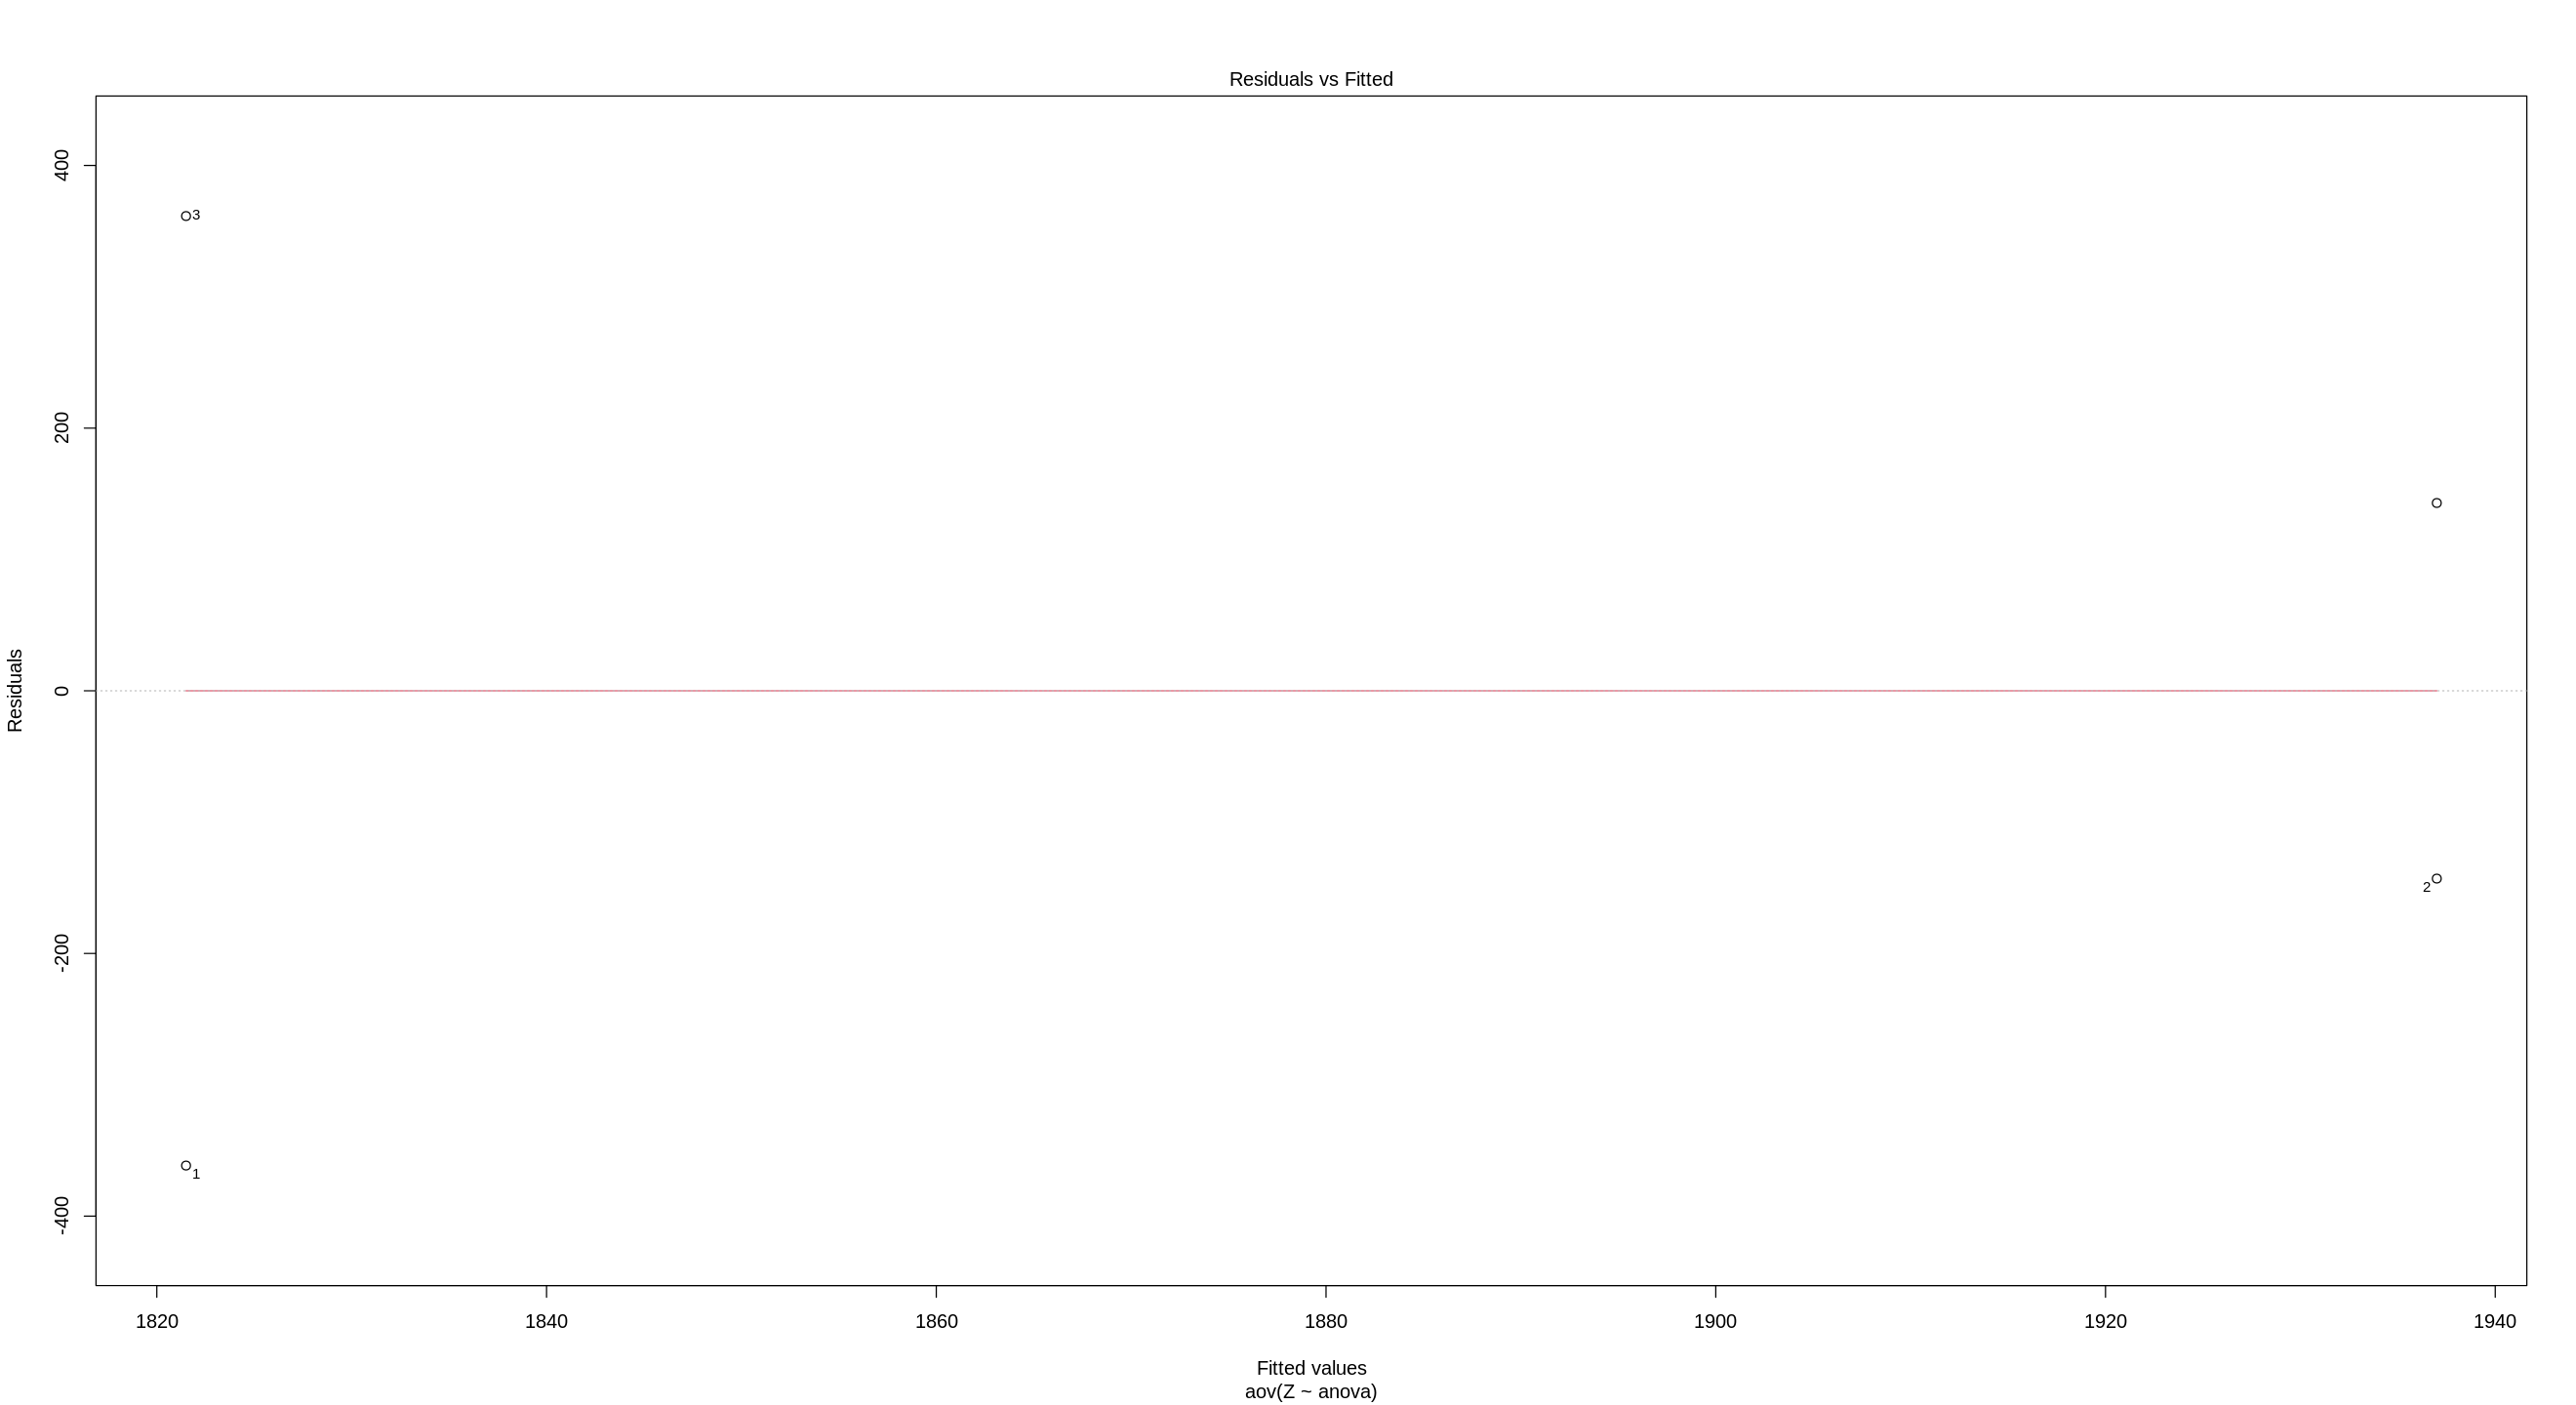

In [96]:
plot(res.aov, 1)

#### USE SI AS SAMPLE DATA

In [143]:
dfsi_new8 <- list()
dfsi_old8 <- list()
new8_file <- list.files(parentdir, pattern = "2021-07-20.*NEW8_DF.*")
old8_file <- list.files(parentdir, pattern = "2021-07-20.*OLD8_DF.*")
for (i in seq(1)) {
    dfsi_new8[[i]] <- read.csv(paste0(parentdir, new8_file[i])) %>% 
                        na.omit() %>% select(SAMPLE_NAME, 
                            MFI.,
                            MFI..1,
                            SI,
                            SN) %>%
                        filter(grepl("[A-H]0[2-9]|1[0-1]", SAMPLE_NAME)) %>%
                        mutate_at(vars(MFI., MFI..1, SI, SN), funs(as.numeric))
    dfsi_old8[[i]] <- read.csv(paste0(parentdir, old8_file[i])) %>% 
                        na.omit() %>% 
                        filter(grepl("[A-H]0[2-9]|1[0-1]", SAMPLE_NAME)) %>%
                        mutate_at(vars(MFI., MFI..1, SI, SN), funs(as.numeric))
    }

In [231]:
si.pos.new8 <- list()
si.pos.old8 <- list()

for (i in seq(1)) {
    si.pos.new8[[i]] <- dfsi_new8[[i]] %>% select(SI, SAMPLE_NAME ) %>% mutate(wellid = substr(SAMPLE_NAME, 17,19), plate = paste("plate", i), method = "New 8")
    si.pos.old8[[i]] <- dfsi_old8[[i]] %>% select(SI, SAMPLE_NAME ) %>% mutate(wellid = substr(SAMPLE_NAME, 17,19), plate = paste("plate", i), method = "Old 8")
    }

dfm <- do.call(rbind, si.pos.new8) %>% bind_rows(
        do.call(rbind, si.pos.old8)
        )

#### F test for normality
- The p values are big, meaning the variances do not change more from plate 1 to 3

#### Anderson-Darling test
- goodness of fit test that measures how well your data fit a specified distribution.
- H_0: The data follow a specified distribution

#### Shapiro test, bonett test, qq plot to show normality
- shapiro-wilk test - tell if a random sample comes from a normal distribution
- bonett test - measure of kurtosis for normally distributed data
- under the hypothesis of normality, data should have Geary's kurtosis equal to sqrt(2/pi) (0.7979)
- the kurtosis is near .7979, with p-value barely above 0.05, indicating it is slightly normal

In [145]:
# A-E new 8 vs old 8
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame()

for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dfm %>% filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i))
    print(paste0(rep("-", 25),collapse=""))
    stat <- var.test(SI ~ method, df.t)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    #stat <- ad.test(df.t$SI)
    #df_stats[i-1, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    #print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- shapiro.test(df.t$SI)
    df_stats[i-1, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- bonett.test(df.t$SI)
    df_stats[i-1, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    print("geary result:")
    stat <- geary(df.t$SI)
    df_stats[i-1, "GEARY"] = formatC(stat, format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "A / E : 2"
[1] "-------------------------"

	F test to compare two variances

data:  SI by method
F = 13.66, num df = 1, denom df = 1, p-value = 0.3364
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 2.108704e-02 8.848769e+03
sample estimates:
ratio of variances 
          13.65996 

[1] "-------------------------"
[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.t$SI
W = 0.81805, p-value = 0.1387

[1] "-------------------------"

	Bonett-Seier test for Geary kurtosis

data:  df.t$SI
tau = 17.7896, z = -0.5229, p-value = 0.601
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "-------------------------"
[1] "geary result:"
[1] 0.8446172
[1] "A / E : 3"
[1] "-------------------------"

	F test to compare two variances

data:  SI by method
F = 0.059319, num df = 1, denom df = 1, p-value = 0.3042
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 9

In [146]:
# B-F new 8 vs old 8
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame()

for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dfm %>% filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i))
    print(paste0(rep("-", 25),collapse=""))
    stat <- var.test(SI ~ method, df.t)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
   # stat <- ad.test(df.t$SI)
   # df_stats[i-1, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
   # print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- shapiro.test(df.t$SI)
    df_stats[i-1, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- bonett.test(df.t$SI)
    df_stats[i-1, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    print("geary result:")
    stat <- geary(df.t$SI)
    df_stats[i-1, "GEARY"] = formatC(stat, format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "B / F : 2"
[1] "-------------------------"

	F test to compare two variances

data:  SI by method
F = 4.6399, num df = 1, denom df = 1, p-value = 0.5534
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 7.162705e-03 3.005690e+03
sample estimates:
ratio of variances 
          4.639922 

[1] "-------------------------"
[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.t$SI
W = 0.96631, p-value = 0.8185

[1] "-------------------------"

	Bonett-Seier test for Geary kurtosis

data:  df.t$SI
tau = 3.46266, z = -0.97735, p-value = 0.3284
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "-------------------------"
[1] "geary result:"
[1] 0.8874055
[1] "B / F : 3"
[1] "-------------------------"

	F test to compare two variances

data:  SI by method
F = 3.328, num df = 1, denom df = 1, p-value = 0.6384
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 5

In [147]:
# C-G new 8 vs old 8
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame()

for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dfm %>% filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i))
    print(paste0(rep("-", 25),collapse=""))
    stat <- var.test(SI ~ method, df.t)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    #stat <- ad.test(df.t$SI)
    #df_stats[i-1, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    #print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- shapiro.test(df.t$SI)
    df_stats[i-1, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- bonett.test(df.t$SI)
    df_stats[i-1, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    print("geary result:")
    stat <- geary(df.t$SI)
    df_stats[i-1, "GEARY"] = formatC(stat, format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "C / G : 2"
[1] "-------------------------"

	F test to compare two variances

data:  SI by method
F = 63.347, num df = 1, denom df = 1, p-value = 0.1591
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 9.778949e-02 4.103546e+04
sample estimates:
ratio of variances 
          63.34696 

[1] "-------------------------"
[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.t$SI
W = 0.79411, p-value = 0.09207

[1] "-------------------------"

	Bonett-Seier test for Geary kurtosis

data:  df.t$SI
tau = 2.93693, z = -0.58571, p-value = 0.5581
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "-------------------------"
[1] "geary result:"
[1] 0.8504058
[1] "C / G : 3"
[1] "-------------------------"

	F test to compare two variances

data:  SI by method
F = 0.020026, num df = 1, denom df = 1, p-value = 0.179
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:

In [148]:
# D-H new 8 vs old 8
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame()

for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dfm %>% filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i))
    print(paste0(rep("-", 25),collapse=""))
    stat <- var.test(SI ~ method, df.t)
    df_stats[i-1, "F_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
#    stat <- ad.test(df.t$SI)
#    df_stats[i-1, "AD_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
#    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- shapiro.test(df.t$SI)
    df_stats[i-1, "SHAPIRO_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    stat <- bonett.test(df.t$SI)
    df_stats[i-1, "BONETT_TEST"] = formatC(stat$p.value, format = "e", digits = 2)
    print(stat)
    print(paste0(rep("-", 25),collapse=""))
    print("geary result:")
    stat <- geary(df.t$SI)
    df_stats[i-1, "GEARY"] = formatC(stat, format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "D / H : 2"
[1] "-------------------------"

	F test to compare two variances

data:  SI by method
F = 6.0982, num df = 1, denom df = 1, p-value = 0.4899
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 9.413832e-03 3.950332e+03
sample estimates:
ratio of variances 
          6.098177 

[1] "-------------------------"
[1] "-------------------------"

	Shapiro-Wilk normality test

data:  df.t$SI
W = 0.91233, p-value = 0.4949

[1] "-------------------------"

	Bonett-Seier test for Geary kurtosis

data:  df.t$SI
tau = 33.3188, z = -1.6831, p-value = 0.09235
alternative hypothesis: kurtosis is not equal to sqrt(2/pi)

[1] "-------------------------"
[1] "geary result:"
[1] 0.9581919
[1] "D / H : 3"
[1] "-------------------------"

	F test to compare two variances

data:  SI by method
F = 0.41157, num df = 1, denom df = 1, p-value = 0.7263
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:


### Summary stats

In [149]:
# for NEW 8 A-E
j = 1
pat1 = rows[[j]][1]
pat2 = rows[[j]][2]

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    print(summary(
        dfm %>% 
        filter((grepl(x = wellid, pattern = pat1) | grepl(x = wellid, pattern = pat2)) & method == "New 8") %>% 
        select(SI)
    ))
    }

[1] "A / E : 2"
       SI        
 Min.   : 97.16  
 1st Qu.:127.54  
 Median :194.30  
 Mean   :192.57  
 3rd Qu.:250.32  
 Max.   :304.62  
[1] "A / E : 3"
       SI        
 Min.   : 97.16  
 1st Qu.:127.54  
 Median :194.30  
 Mean   :192.57  
 3rd Qu.:250.32  
 Max.   :304.62  
[1] "A / E : 4"
       SI        
 Min.   : 97.16  
 1st Qu.:127.54  
 Median :194.30  
 Mean   :192.57  
 3rd Qu.:250.32  
 Max.   :304.62  
[1] "A / E : 5"
       SI        
 Min.   : 97.16  
 1st Qu.:127.54  
 Median :194.30  
 Mean   :192.57  
 3rd Qu.:250.32  
 Max.   :304.62  
[1] "A / E : 6"
       SI        
 Min.   : 97.16  
 1st Qu.:127.54  
 Median :194.30  
 Mean   :192.57  
 3rd Qu.:250.32  
 Max.   :304.62  
[1] "A / E : 7"
       SI        
 Min.   : 97.16  
 1st Qu.:127.54  
 Median :194.30  
 Mean   :192.57  
 3rd Qu.:250.32  
 Max.   :304.62  
[1] "A / E : 8"
       SI        
 Min.   : 97.16  
 1st Qu.:127.54  
 Median :194.30  
 Mean   :192.57  
 3rd Qu.:250.32  
 Max.   :304.62  


In [150]:
# for OLD A-E
j = 1
pat1 = rows[[j]][1]
pat2 = rows[[j]][2]

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    print(summary(
        dfm %>% 
        filter((grepl(x = wellid, pattern = pat1) | grepl(x = wellid, pattern = pat2)) & method == "Old 8") %>% 
        select(SI)
    ))
    }

[1] "A / E : 2"
       SI        
 Min.   : 93.89  
 1st Qu.:131.74  
 Median :225.27  
 Mean   :215.25  
 3rd Qu.:292.96  
 Max.   :333.75  
[1] "A / E : 3"
       SI        
 Min.   : 93.89  
 1st Qu.:131.74  
 Median :225.27  
 Mean   :215.25  
 3rd Qu.:292.96  
 Max.   :333.75  
[1] "A / E : 4"
       SI        
 Min.   : 93.89  
 1st Qu.:131.74  
 Median :225.27  
 Mean   :215.25  
 3rd Qu.:292.96  
 Max.   :333.75  
[1] "A / E : 5"
       SI        
 Min.   : 93.89  
 1st Qu.:131.74  
 Median :225.27  
 Mean   :215.25  
 3rd Qu.:292.96  
 Max.   :333.75  
[1] "A / E : 6"
       SI        
 Min.   : 93.89  
 1st Qu.:131.74  
 Median :225.27  
 Mean   :215.25  
 3rd Qu.:292.96  
 Max.   :333.75  
[1] "A / E : 7"
       SI        
 Min.   : 93.89  
 1st Qu.:131.74  
 Median :225.27  
 Mean   :215.25  
 3rd Qu.:292.96  
 Max.   :333.75  
[1] "A / E : 8"
       SI        
 Min.   : 93.89  
 1st Qu.:131.74  
 Median :225.27  
 Mean   :215.25  
 3rd Qu.:292.96  
 Max.   :333.75  


In [151]:
# for NEW 8 B-F
j = 2
pat1 = rows[[j]][1]
pat2 = rows[[j]][2]

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    print(summary(
        dfm %>% 
        filter((grepl(x = wellid, pattern = pat1) | grepl(x = wellid, pattern = pat2)) & method == "New 8") %>% 
        select(SI)
    ))
    }

[1] "B / F : 2"
       SI       
 Min.   :32.01  
 1st Qu.:51.48  
 Median :59.34  
 Mean   :56.88  
 3rd Qu.:64.51  
 Max.   :77.54  
[1] "B / F : 3"
       SI       
 Min.   :32.01  
 1st Qu.:51.48  
 Median :59.34  
 Mean   :56.88  
 3rd Qu.:64.51  
 Max.   :77.54  
[1] "B / F : 4"
       SI       
 Min.   :32.01  
 1st Qu.:51.48  
 Median :59.34  
 Mean   :56.88  
 3rd Qu.:64.51  
 Max.   :77.54  
[1] "B / F : 5"
       SI       
 Min.   :32.01  
 1st Qu.:51.48  
 Median :59.34  
 Mean   :56.88  
 3rd Qu.:64.51  
 Max.   :77.54  
[1] "B / F : 6"
       SI       
 Min.   :32.01  
 1st Qu.:51.48  
 Median :59.34  
 Mean   :56.88  
 3rd Qu.:64.51  
 Max.   :77.54  
[1] "B / F : 7"
       SI       
 Min.   :32.01  
 1st Qu.:51.48  
 Median :59.34  
 Mean   :56.88  
 3rd Qu.:64.51  
 Max.   :77.54  
[1] "B / F : 8"
       SI       
 Min.   :32.01  
 1st Qu.:51.48  
 Median :59.34  
 Mean   :56.88  
 3rd Qu.:64.51  
 Max.   :77.54  


In [152]:
# for OLD 8 B-F
j = 2
pat1 = rows[[j]][1]
pat2 = rows[[j]][2]

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    print(summary(
        dfm %>% 
        filter((grepl(x = wellid, pattern = pat1) | grepl(x = wellid, pattern = pat2)) & method == "Old 8") %>% 
        select(SI)
    ))
    }

[1] "B / F : 2"
       SI       
 Min.   :26.32  
 1st Qu.:48.34  
 Median :61.48  
 Mean   :57.89  
 3rd Qu.:69.28  
 Max.   :76.39  
[1] "B / F : 3"
       SI       
 Min.   :26.32  
 1st Qu.:48.34  
 Median :61.48  
 Mean   :57.89  
 3rd Qu.:69.28  
 Max.   :76.39  
[1] "B / F : 4"
       SI       
 Min.   :26.32  
 1st Qu.:48.34  
 Median :61.48  
 Mean   :57.89  
 3rd Qu.:69.28  
 Max.   :76.39  
[1] "B / F : 5"
       SI       
 Min.   :26.32  
 1st Qu.:48.34  
 Median :61.48  
 Mean   :57.89  
 3rd Qu.:69.28  
 Max.   :76.39  
[1] "B / F : 6"
       SI       
 Min.   :26.32  
 1st Qu.:48.34  
 Median :61.48  
 Mean   :57.89  
 3rd Qu.:69.28  
 Max.   :76.39  
[1] "B / F : 7"
       SI       
 Min.   :26.32  
 1st Qu.:48.34  
 Median :61.48  
 Mean   :57.89  
 3rd Qu.:69.28  
 Max.   :76.39  
[1] "B / F : 8"
       SI       
 Min.   :26.32  
 1st Qu.:48.34  
 Median :61.48  
 Mean   :57.89  
 3rd Qu.:69.28  
 Max.   :76.39  


In [153]:
# for NEW 8 C-G
j = 3
pat1 = rows[[j]][1]
pat2 = rows[[j]][2]

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    print(summary(
        dfm %>% 
        filter((grepl(x = wellid, pattern = pat1) | grepl(x = wellid, pattern = pat2)) & method == "New 8") %>% 
        select(SI)
    ))
    }

[1] "C / G : 2"
       SI        
 Min.   : 7.665  
 1st Qu.:16.333  
 Median :17.086  
 Mean   :17.203  
 3rd Qu.:19.039  
 Max.   :25.008  
[1] "C / G : 3"
       SI        
 Min.   : 7.665  
 1st Qu.:16.333  
 Median :17.086  
 Mean   :17.203  
 3rd Qu.:19.039  
 Max.   :25.008  
[1] "C / G : 4"
       SI        
 Min.   : 7.665  
 1st Qu.:16.333  
 Median :17.086  
 Mean   :17.203  
 3rd Qu.:19.039  
 Max.   :25.008  
[1] "C / G : 5"
       SI        
 Min.   : 7.665  
 1st Qu.:16.333  
 Median :17.086  
 Mean   :17.203  
 3rd Qu.:19.039  
 Max.   :25.008  
[1] "C / G : 6"
       SI        
 Min.   : 7.665  
 1st Qu.:16.333  
 Median :17.086  
 Mean   :17.203  
 3rd Qu.:19.039  
 Max.   :25.008  
[1] "C / G : 7"
       SI        
 Min.   : 7.665  
 1st Qu.:16.333  
 Median :17.086  
 Mean   :17.203  
 3rd Qu.:19.039  
 Max.   :25.008  
[1] "C / G : 8"
       SI        
 Min.   : 7.665  
 1st Qu.:16.333  
 Median :17.086  
 Mean   :17.203  
 3rd Qu.:19.039  
 Max.   :25.008  


In [154]:
# for OLD 8 C-G
j = 3
pat1 = rows[[j]][1]
pat2 = rows[[j]][2]

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    print(summary(
        dfm %>% 
        filter((grepl(x = wellid, pattern = pat1) | grepl(x = wellid, pattern = pat2)) & method == "Old 8") %>% 
        select(SI)
    ))
    }

[1] "C / G : 2"
       SI       
 Min.   :12.10  
 1st Qu.:17.29  
 Median :18.53  
 Mean   :17.87  
 3rd Qu.:19.50  
 Max.   :20.71  
[1] "C / G : 3"
       SI       
 Min.   :12.10  
 1st Qu.:17.29  
 Median :18.53  
 Mean   :17.87  
 3rd Qu.:19.50  
 Max.   :20.71  
[1] "C / G : 4"
       SI       
 Min.   :12.10  
 1st Qu.:17.29  
 Median :18.53  
 Mean   :17.87  
 3rd Qu.:19.50  
 Max.   :20.71  
[1] "C / G : 5"
       SI       
 Min.   :12.10  
 1st Qu.:17.29  
 Median :18.53  
 Mean   :17.87  
 3rd Qu.:19.50  
 Max.   :20.71  
[1] "C / G : 6"
       SI       
 Min.   :12.10  
 1st Qu.:17.29  
 Median :18.53  
 Mean   :17.87  
 3rd Qu.:19.50  
 Max.   :20.71  
[1] "C / G : 7"
       SI       
 Min.   :12.10  
 1st Qu.:17.29  
 Median :18.53  
 Mean   :17.87  
 3rd Qu.:19.50  
 Max.   :20.71  
[1] "C / G : 8"
       SI       
 Min.   :12.10  
 1st Qu.:17.29  
 Median :18.53  
 Mean   :17.87  
 3rd Qu.:19.50  
 Max.   :20.71  


In [155]:
# for NEW 8 D-H
j = 4
pat1 = rows[[j]][1]
pat2 = rows[[j]][2]

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    print(summary(
        dfm %>% 
        filter((grepl(x = wellid, pattern = pat1) | grepl(x = wellid, pattern = pat2)) & method == "New 8") %>% 
        select(SI)
    ))
    }

[1] "D / H : 2"
       SI        
 Min.   : 63.05  
 1st Qu.:105.01  
 Median :169.80  
 Mean   :188.54  
 3rd Qu.:257.98  
 Max.   :360.79  
[1] "D / H : 3"
       SI        
 Min.   : 63.05  
 1st Qu.:105.01  
 Median :169.80  
 Mean   :188.54  
 3rd Qu.:257.98  
 Max.   :360.79  
[1] "D / H : 4"
       SI        
 Min.   : 63.05  
 1st Qu.:105.01  
 Median :169.80  
 Mean   :188.54  
 3rd Qu.:257.98  
 Max.   :360.79  
[1] "D / H : 5"
       SI        
 Min.   : 63.05  
 1st Qu.:105.01  
 Median :169.80  
 Mean   :188.54  
 3rd Qu.:257.98  
 Max.   :360.79  
[1] "D / H : 6"
       SI        
 Min.   : 63.05  
 1st Qu.:105.01  
 Median :169.80  
 Mean   :188.54  
 3rd Qu.:257.98  
 Max.   :360.79  
[1] "D / H : 7"
       SI        
 Min.   : 63.05  
 1st Qu.:105.01  
 Median :169.80  
 Mean   :188.54  
 3rd Qu.:257.98  
 Max.   :360.79  
[1] "D / H : 8"
       SI        
 Min.   : 63.05  
 1st Qu.:105.01  
 Median :169.80  
 Mean   :188.54  
 3rd Qu.:257.98  
 Max.   :360.79  


In [156]:
# for OLD 8 D-H
j = 4
pat1 = rows[[j]][1]
pat2 = rows[[j]][2]

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    print(summary(
        dfm %>% 
        filter((grepl(x = wellid, pattern = pat1) | grepl(x = wellid, pattern = pat2)) & method == "Old 8") %>% 
        select(SI)
    ))
    }

[1] "D / H : 2"
       SI        
 Min.   : 49.35  
 1st Qu.:116.74  
 Median :205.03  
 Mean   :222.60  
 3rd Qu.:329.77  
 Max.   :419.67  
[1] "D / H : 3"
       SI        
 Min.   : 49.35  
 1st Qu.:116.74  
 Median :205.03  
 Mean   :222.60  
 3rd Qu.:329.77  
 Max.   :419.67  
[1] "D / H : 4"
       SI        
 Min.   : 49.35  
 1st Qu.:116.74  
 Median :205.03  
 Mean   :222.60  
 3rd Qu.:329.77  
 Max.   :419.67  
[1] "D / H : 5"
       SI        
 Min.   : 49.35  
 1st Qu.:116.74  
 Median :205.03  
 Mean   :222.60  
 3rd Qu.:329.77  
 Max.   :419.67  
[1] "D / H : 6"
       SI        
 Min.   : 49.35  
 1st Qu.:116.74  
 Median :205.03  
 Mean   :222.60  
 3rd Qu.:329.77  
 Max.   :419.67  
[1] "D / H : 7"
       SI        
 Min.   : 49.35  
 1st Qu.:116.74  
 Median :205.03  
 Mean   :222.60  
 3rd Qu.:329.77  
 Max.   :419.67  
[1] "D / H : 8"
       SI        
 Min.   : 49.35  
 1st Qu.:116.74  
 Median :205.03  
 Mean   :222.60  
 3rd Qu.:329.77  
 Max.   :419.67  


In [157]:
# A-E
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
dft <- list()
for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    dft[[i-1]] <- dfm %>% 
                    filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i)) %>%
                    mutate(group = case_when(
                        as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
                        as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
                        as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
                        as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
                        as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
                        as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
                        as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
                        )
                      )
}

df.t <- do.call(rbind, dft)

p_qq_si <- ggplot(df.t, aes(sample = SI, group = group)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(group~ method) +
                ggtitle(paste("new 8 vs. old 8 q-q plot", pat1, "-", pat2))

p_hst_si <- ggplot(data = df.t, aes(group = group, x = SI)) +
    geom_histogram(aes(y = ..density..), binwidth = 12, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(group~ method) +
    ggtitle(paste("new 8 vs. old 8 histogram", pat1, "-", pat2))

p_violin_si <- ggplot(df.t, aes(wellid, SI)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 violing plot rows:", pat1, "-", pat2, "column:", i) ) +
    facet_wrap(group~ method)

[1] "A / E : 2"
[1] "A / E : 3"
[1] "A / E : 4"
[1] "A / E : 5"
[1] "A / E : 6"
[1] "A / E : 7"
[1] "A / E : 8"


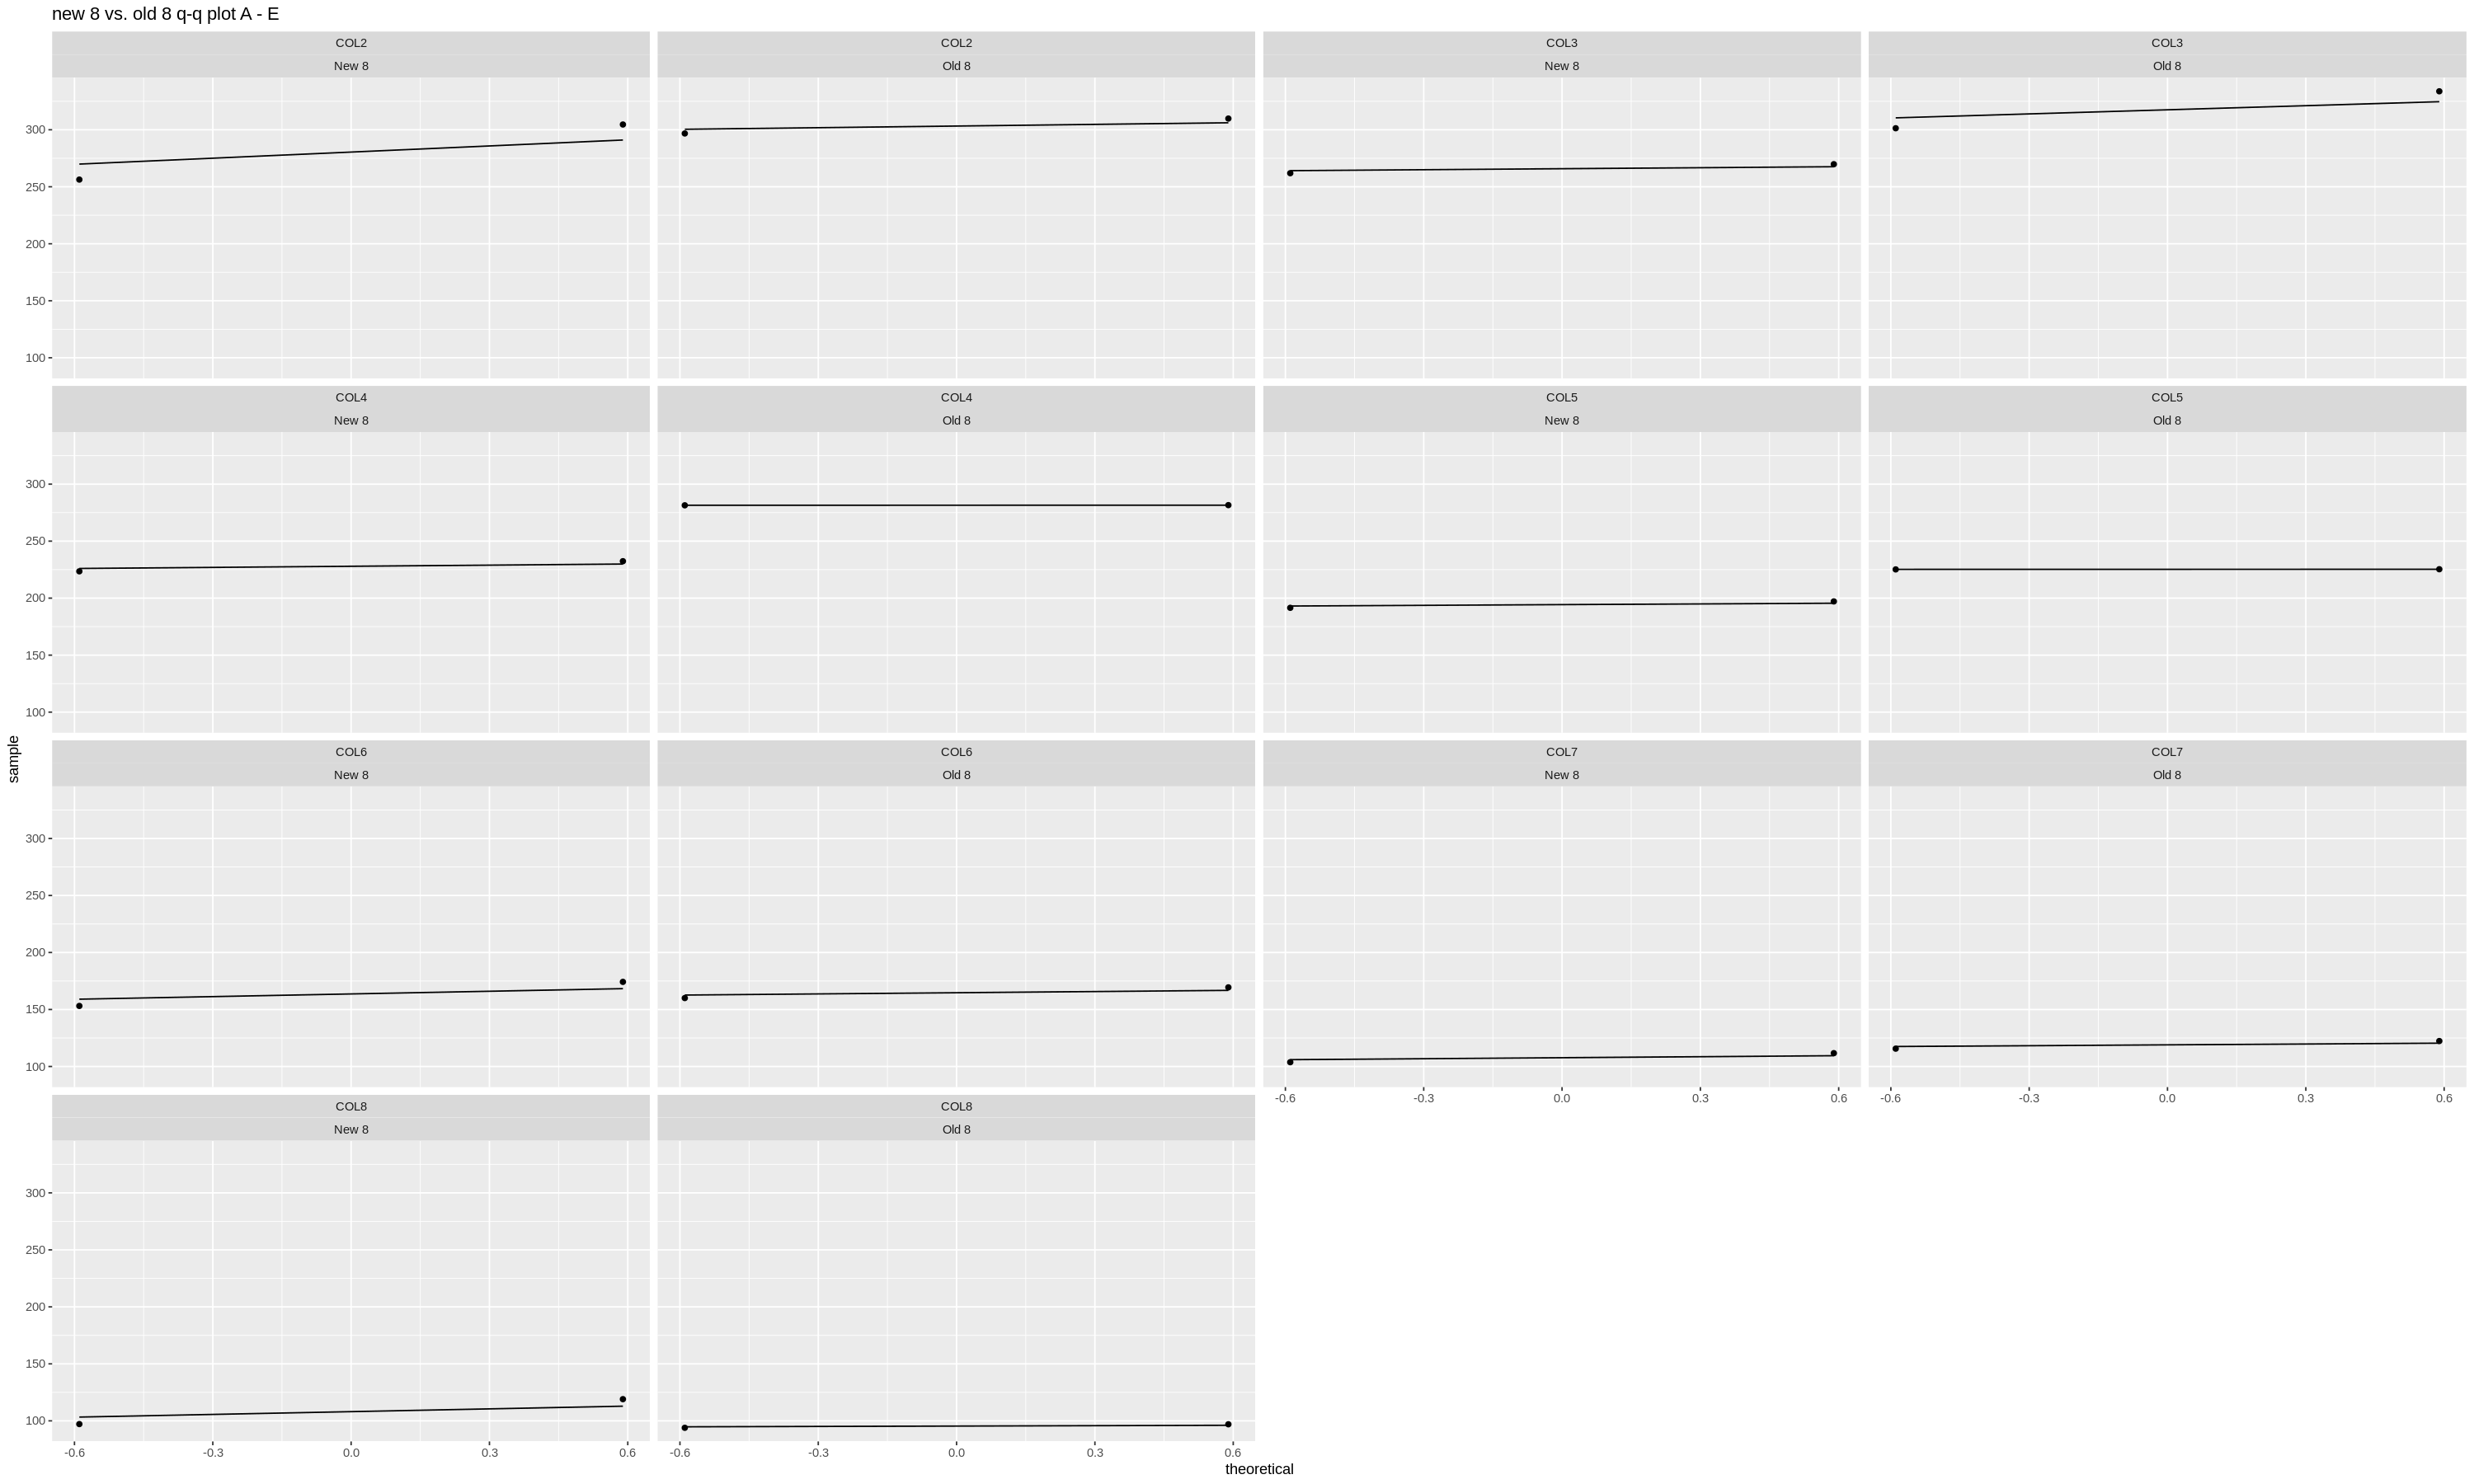

In [158]:
p_qq_si

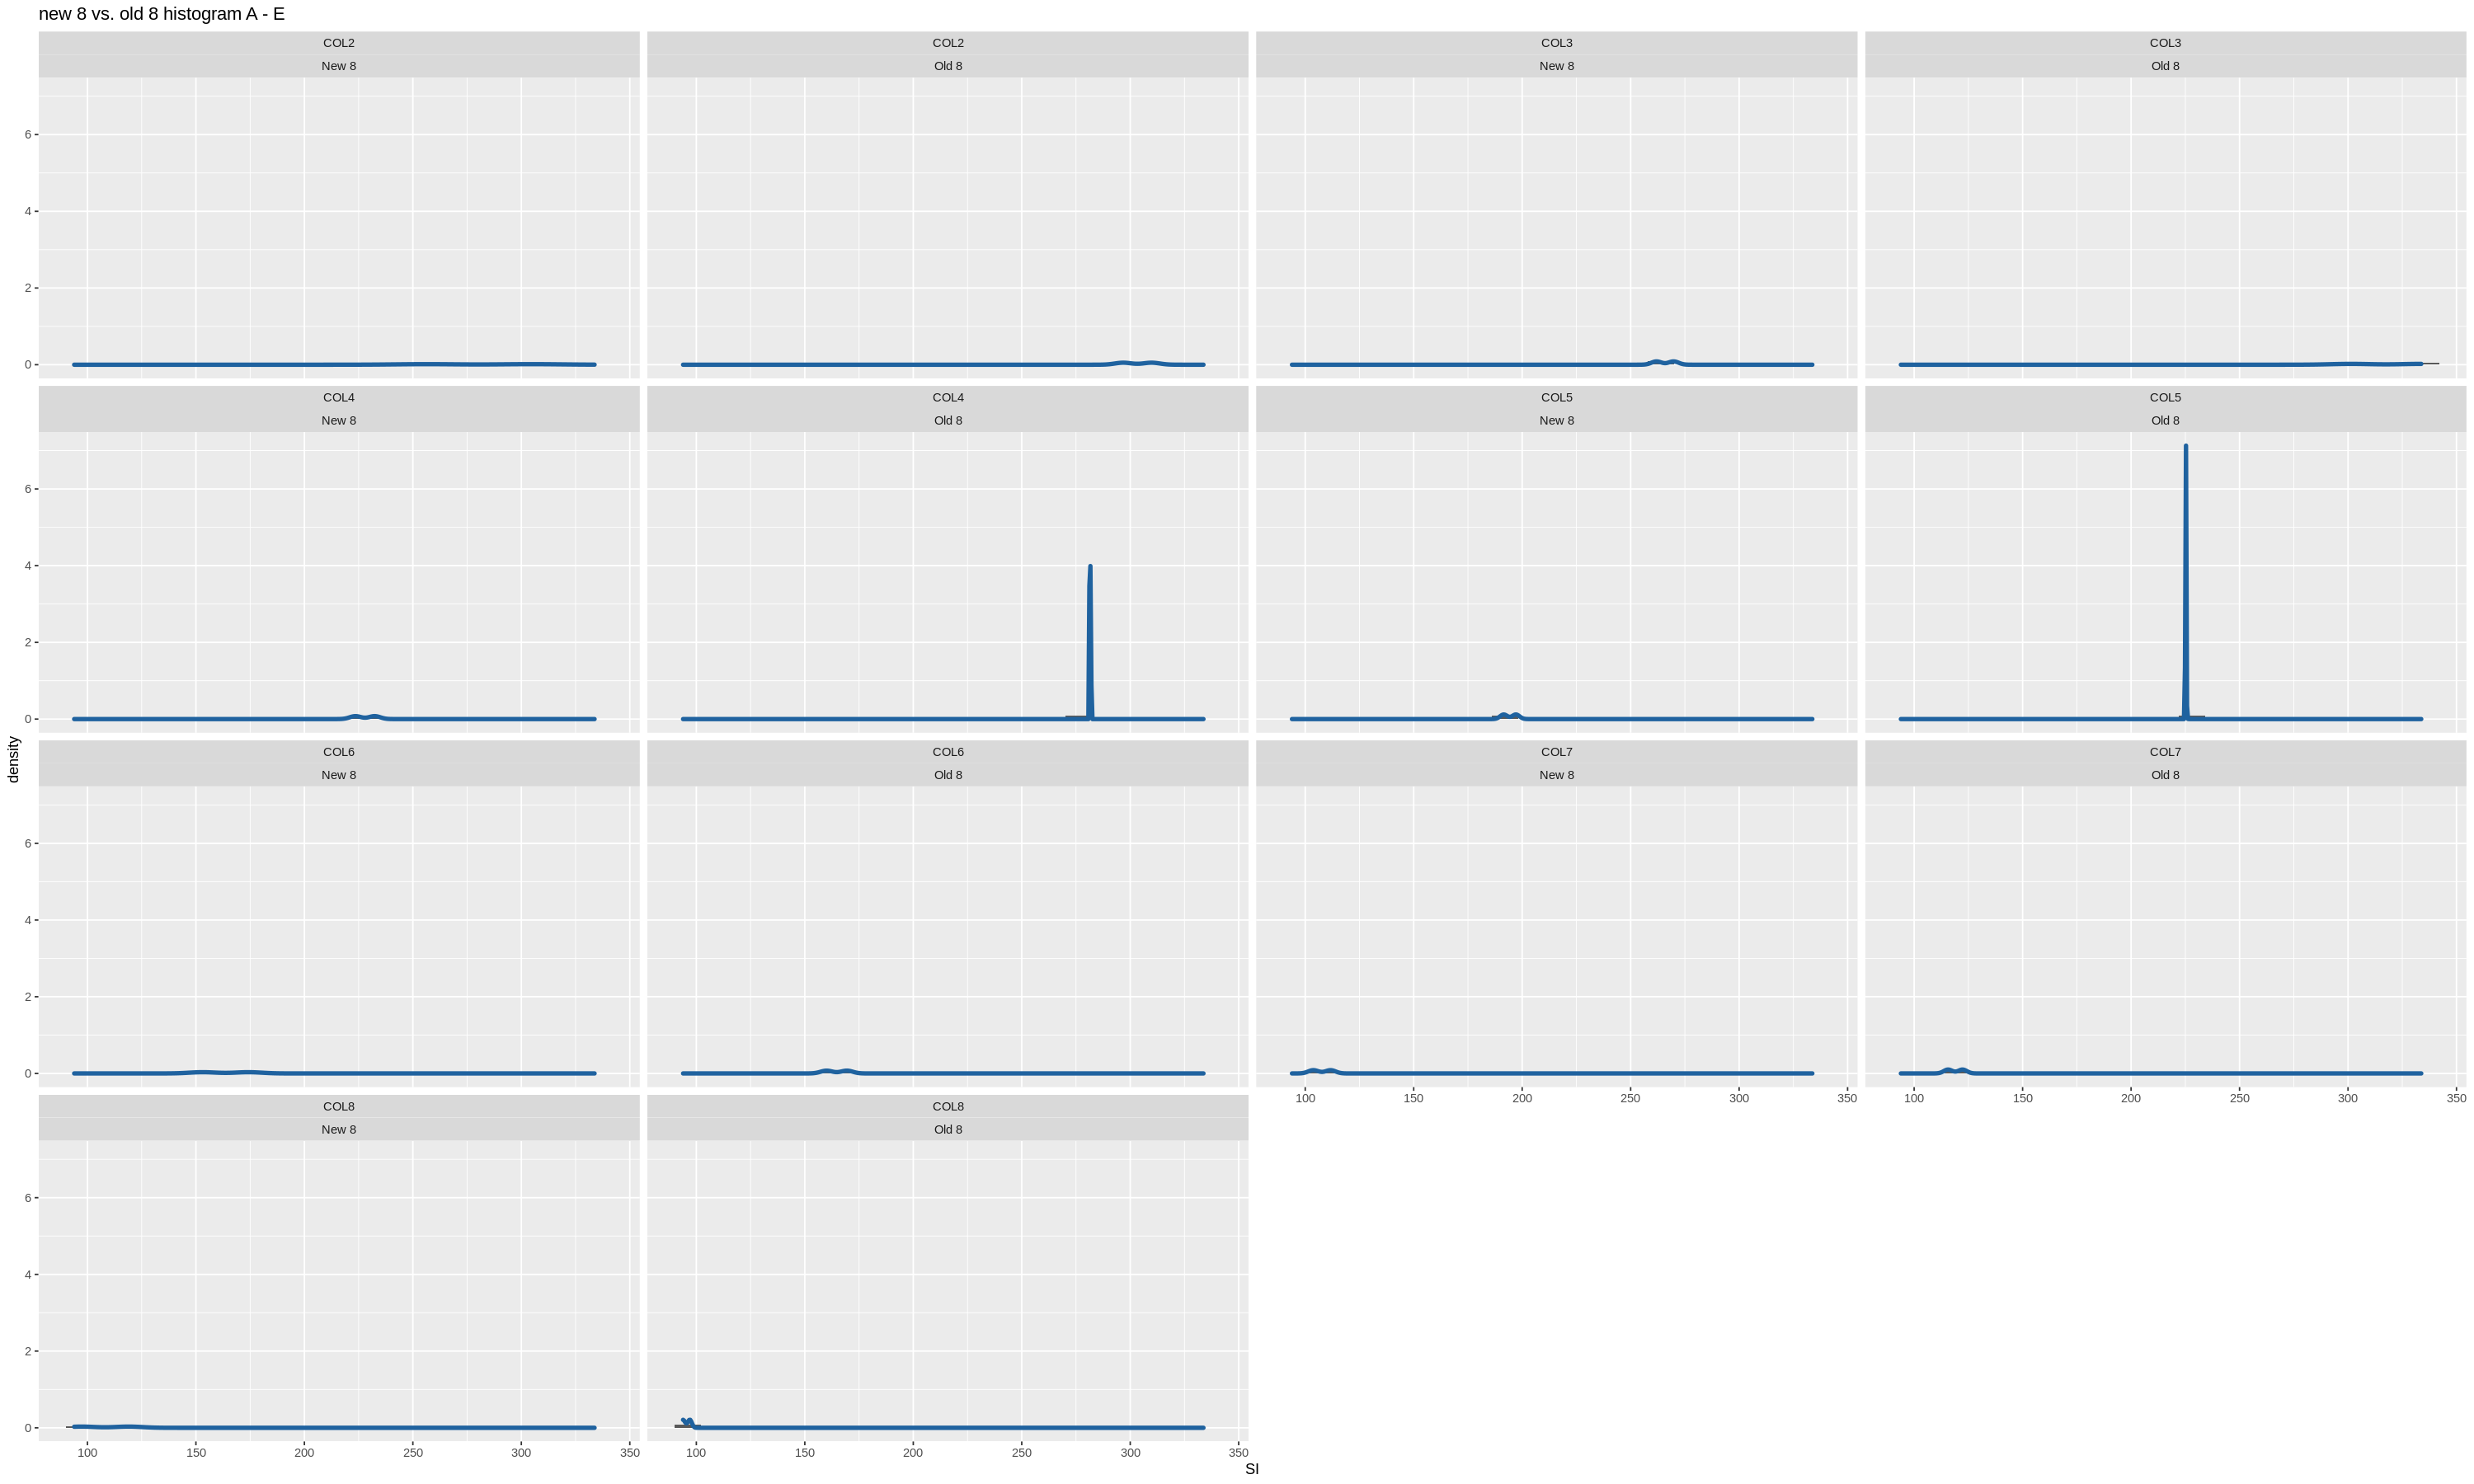

In [159]:
p_hst_si

Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Wa

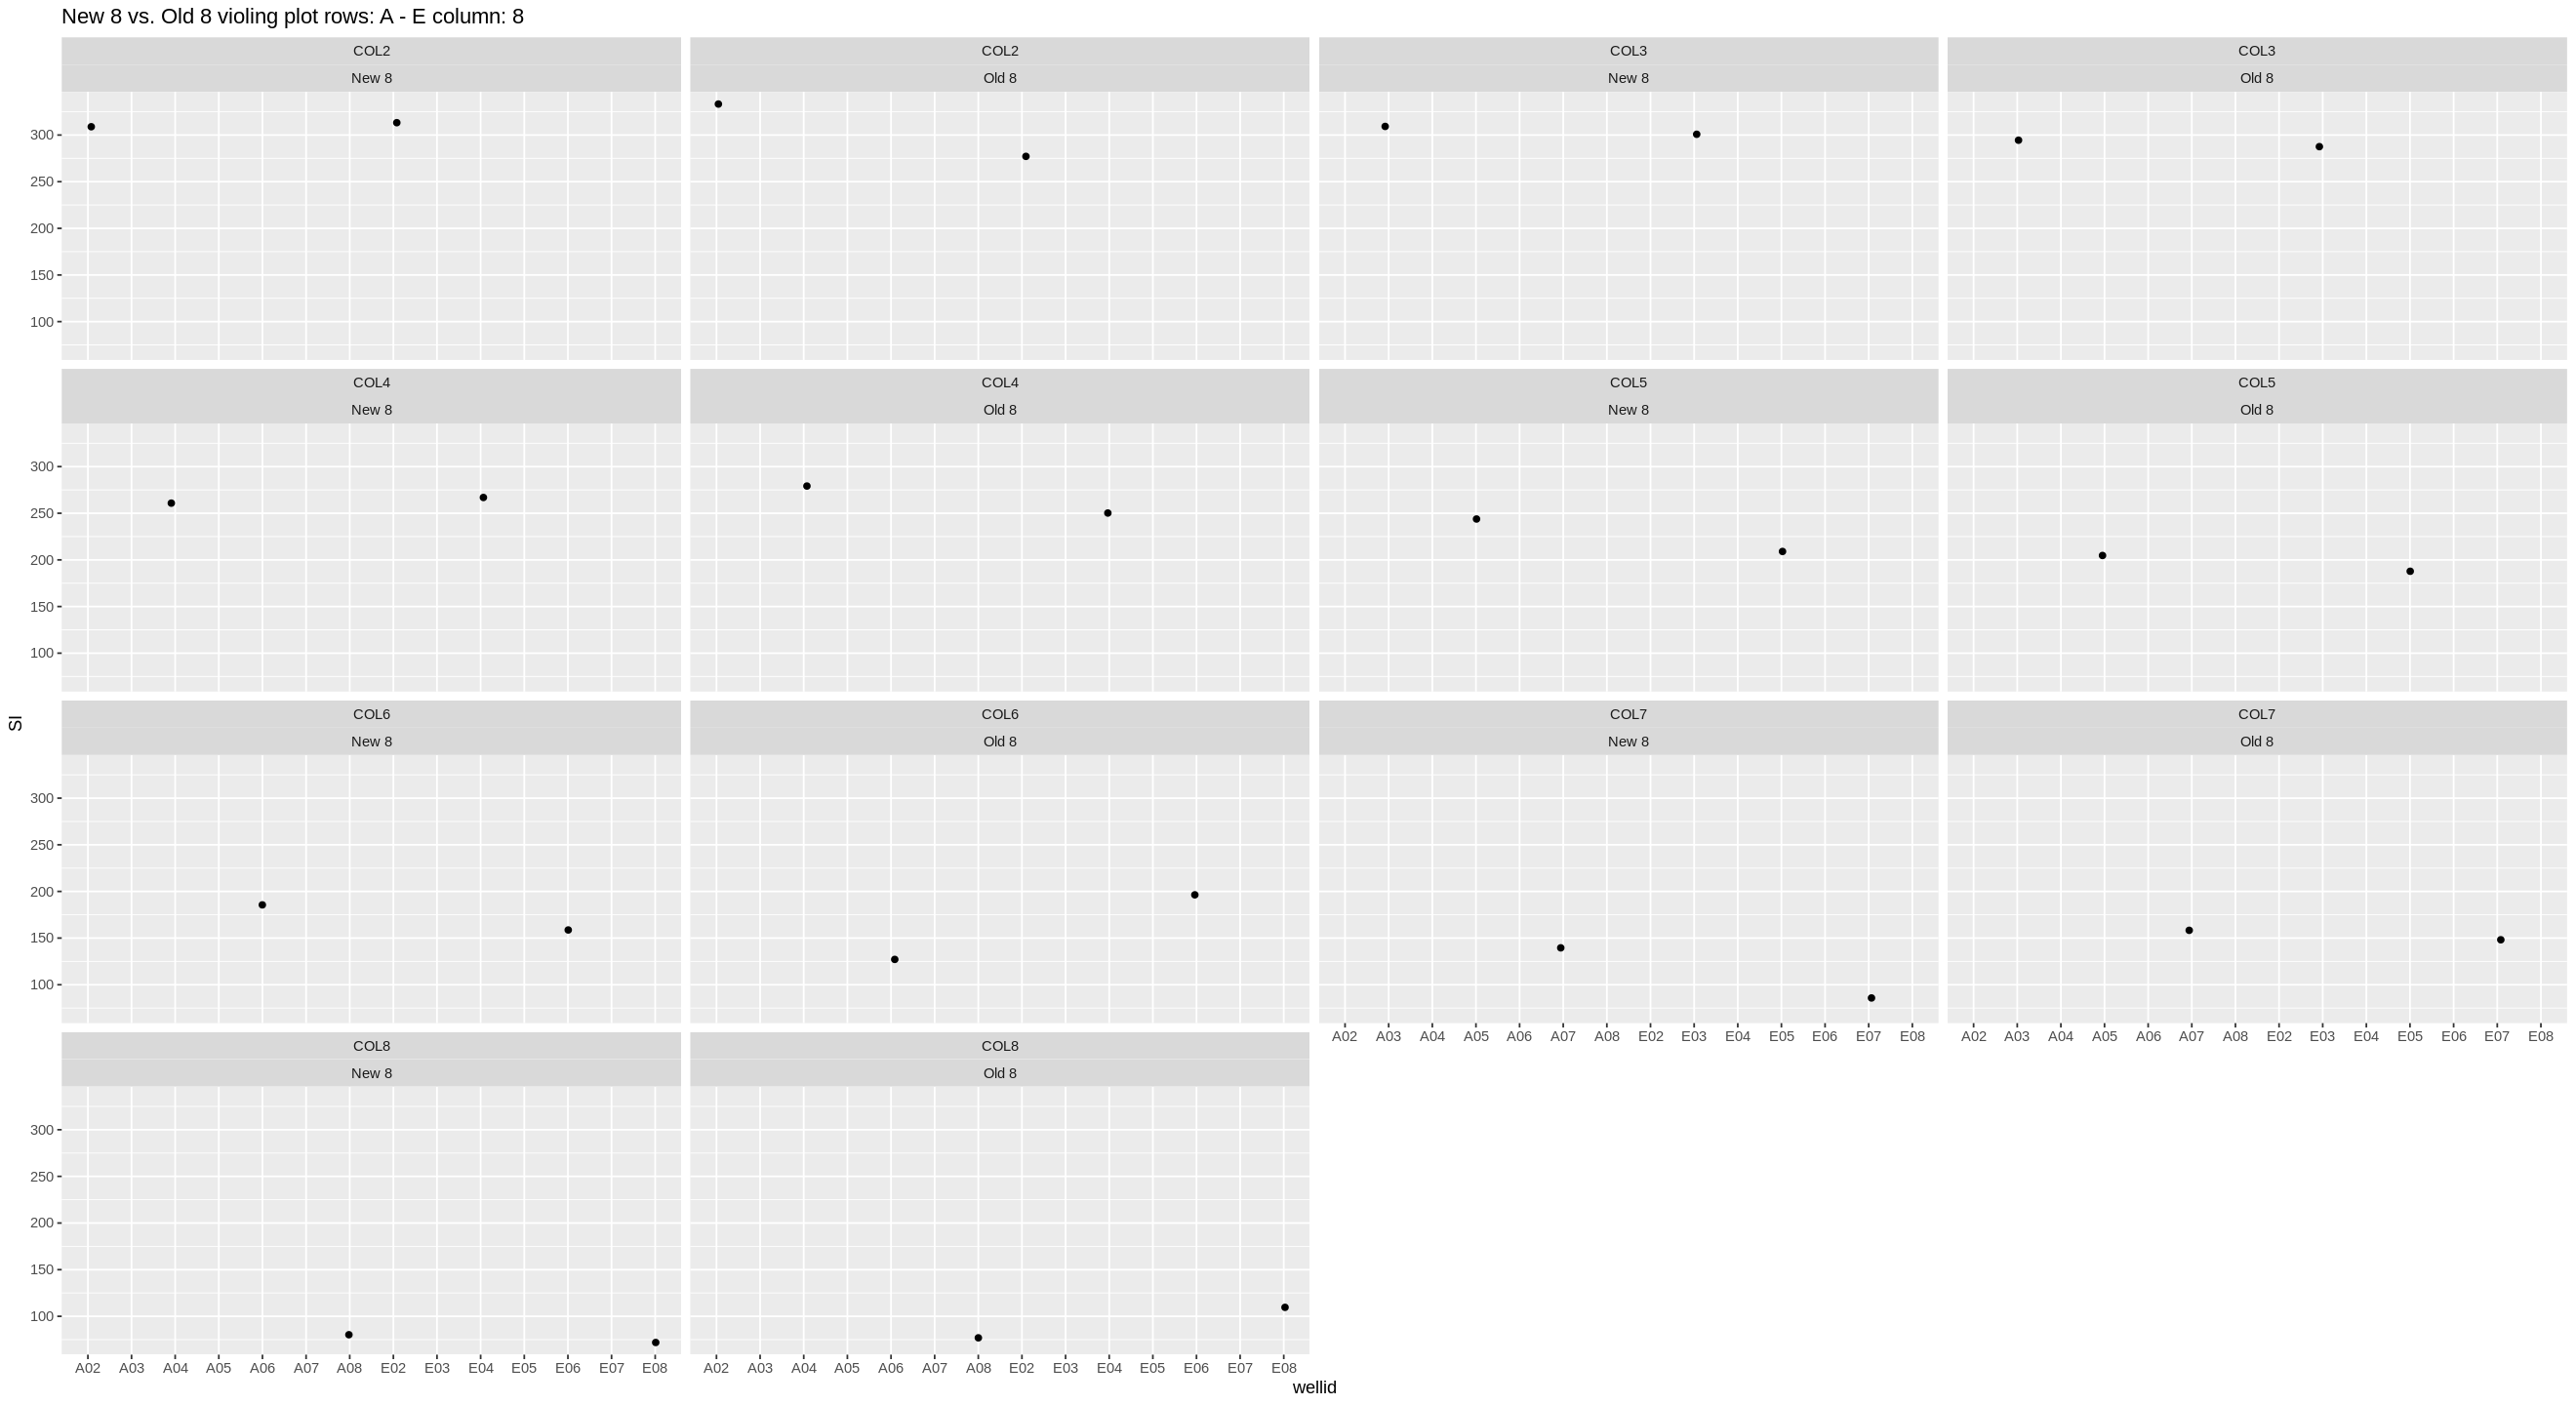

In [114]:
p_violin_si

In [160]:
# B-F
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
dft <- list()
for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    dft[[i-1]] <- dfm %>% 
                    filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i)) %>%
                    mutate(group = case_when(
                        as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
                        as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
                        as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
                        as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
                        as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
                        as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
                        as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
                        )
                      )
}

df.t <- do.call(rbind, dft)

p_qq_si <- ggplot(df.t, aes(sample = SI, group = group)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(group~ method) +
                ggtitle(paste("new 8 vs. old 8 q-q plot", pat1, "-", pat2))

p_hst_si <- ggplot(data = df.t, aes(group = group, x = SI)) +
    geom_histogram(aes(y = ..density..), binwidth = 12, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(group~ method) +
    ggtitle(paste("new 8 vs. old 8 histogram", pat1, "-", pat2))

p_violin_si <- ggplot(df.t, aes(wellid, SI)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 violing plot rows:", pat1, "-", pat2, "column:", i) ) +
    facet_wrap(group~ method)

[1] "B / F : 2"
[1] "B / F : 3"
[1] "B / F : 4"
[1] "B / F : 5"
[1] "B / F : 6"
[1] "B / F : 7"
[1] "B / F : 8"


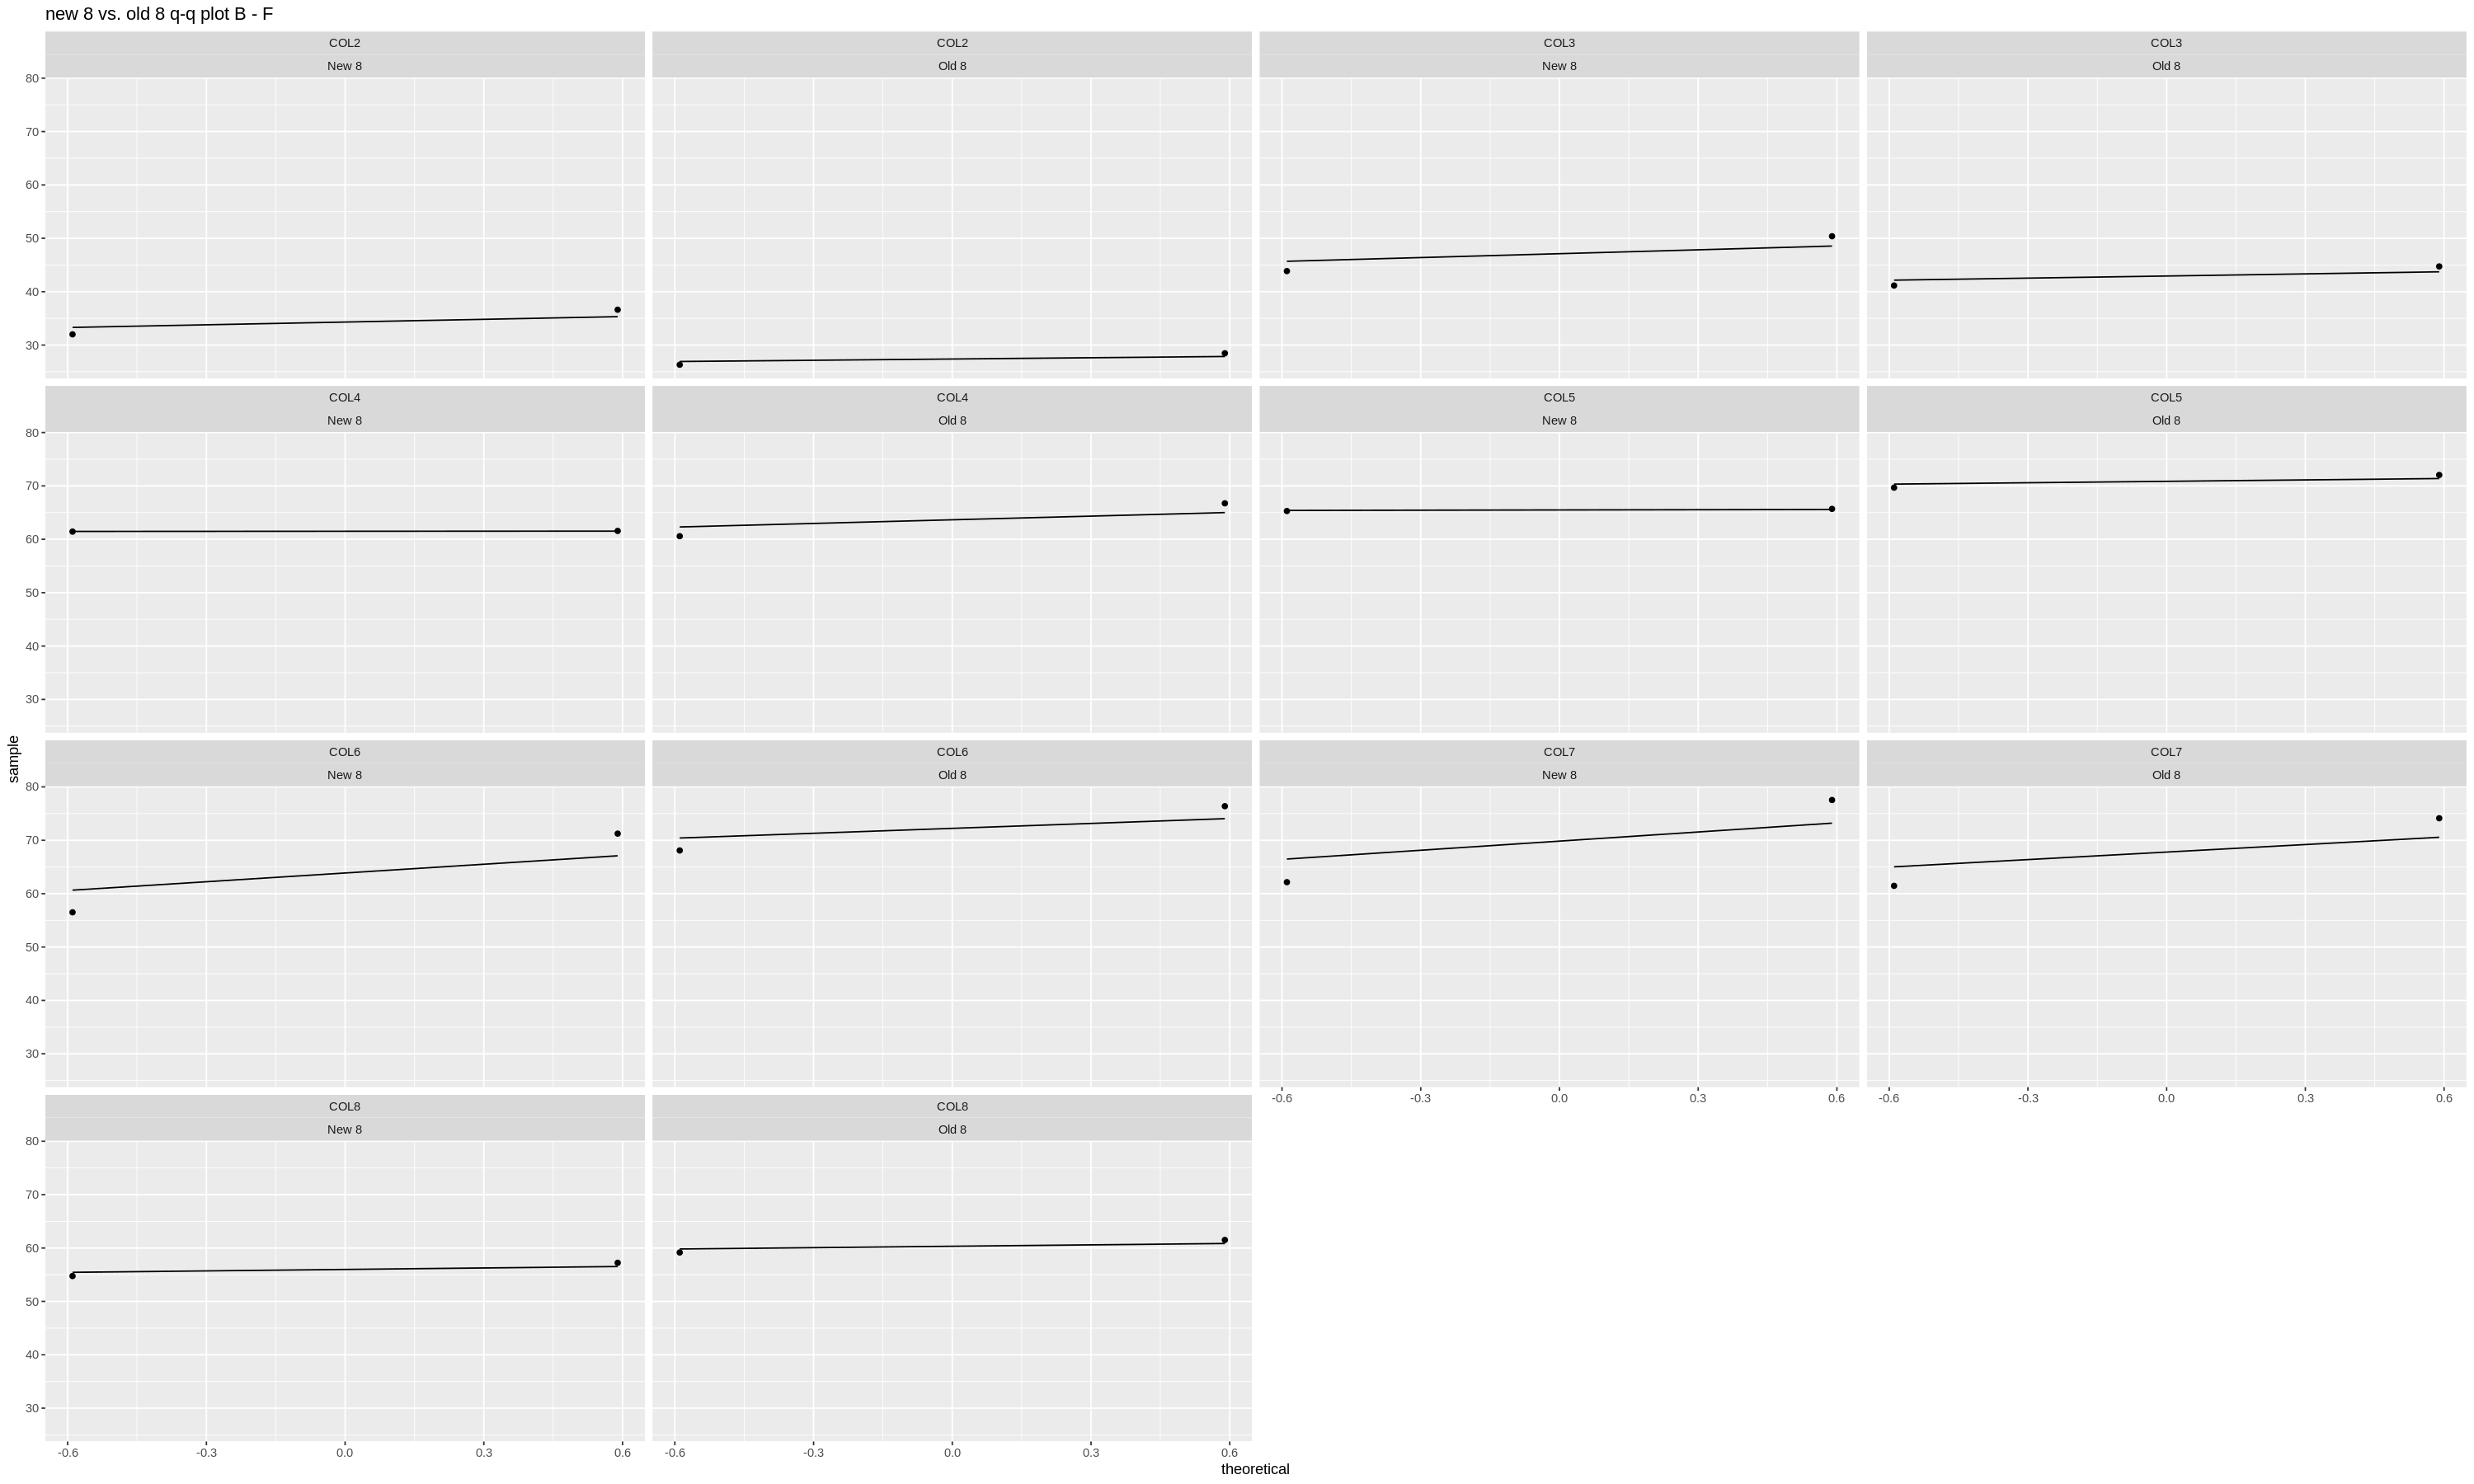

In [161]:
p_qq_si

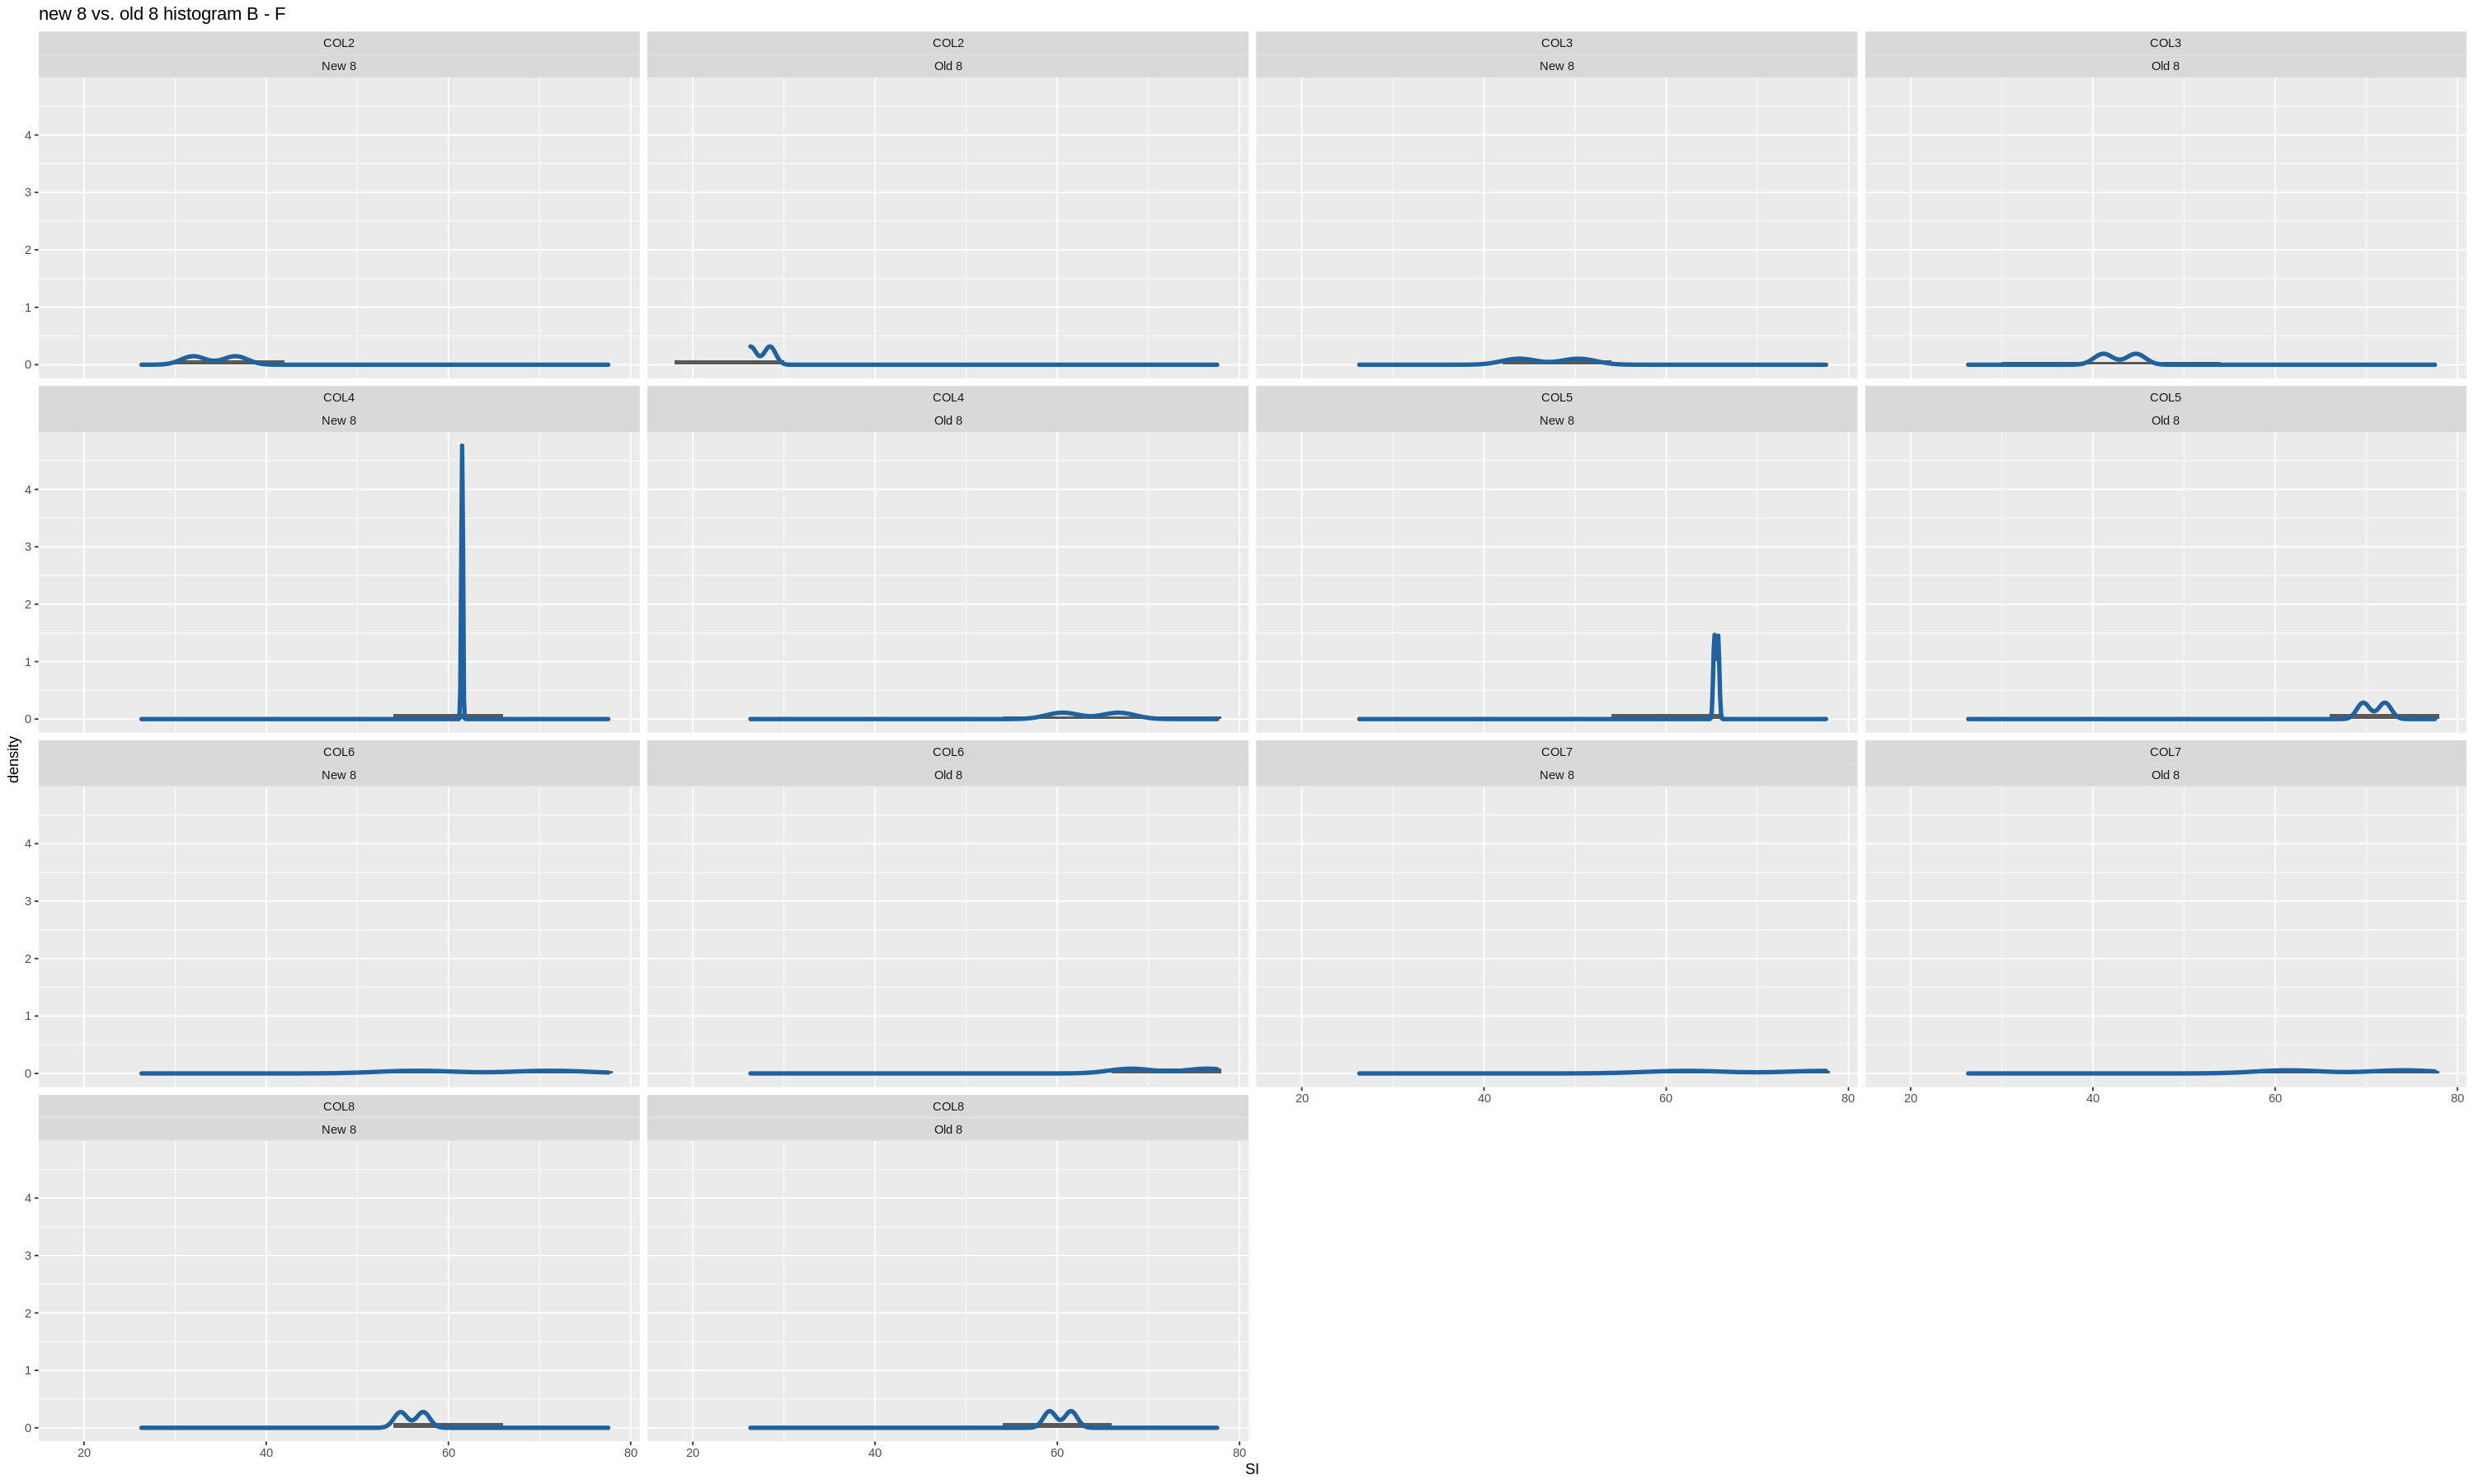

In [162]:
p_hst_si

Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Wa

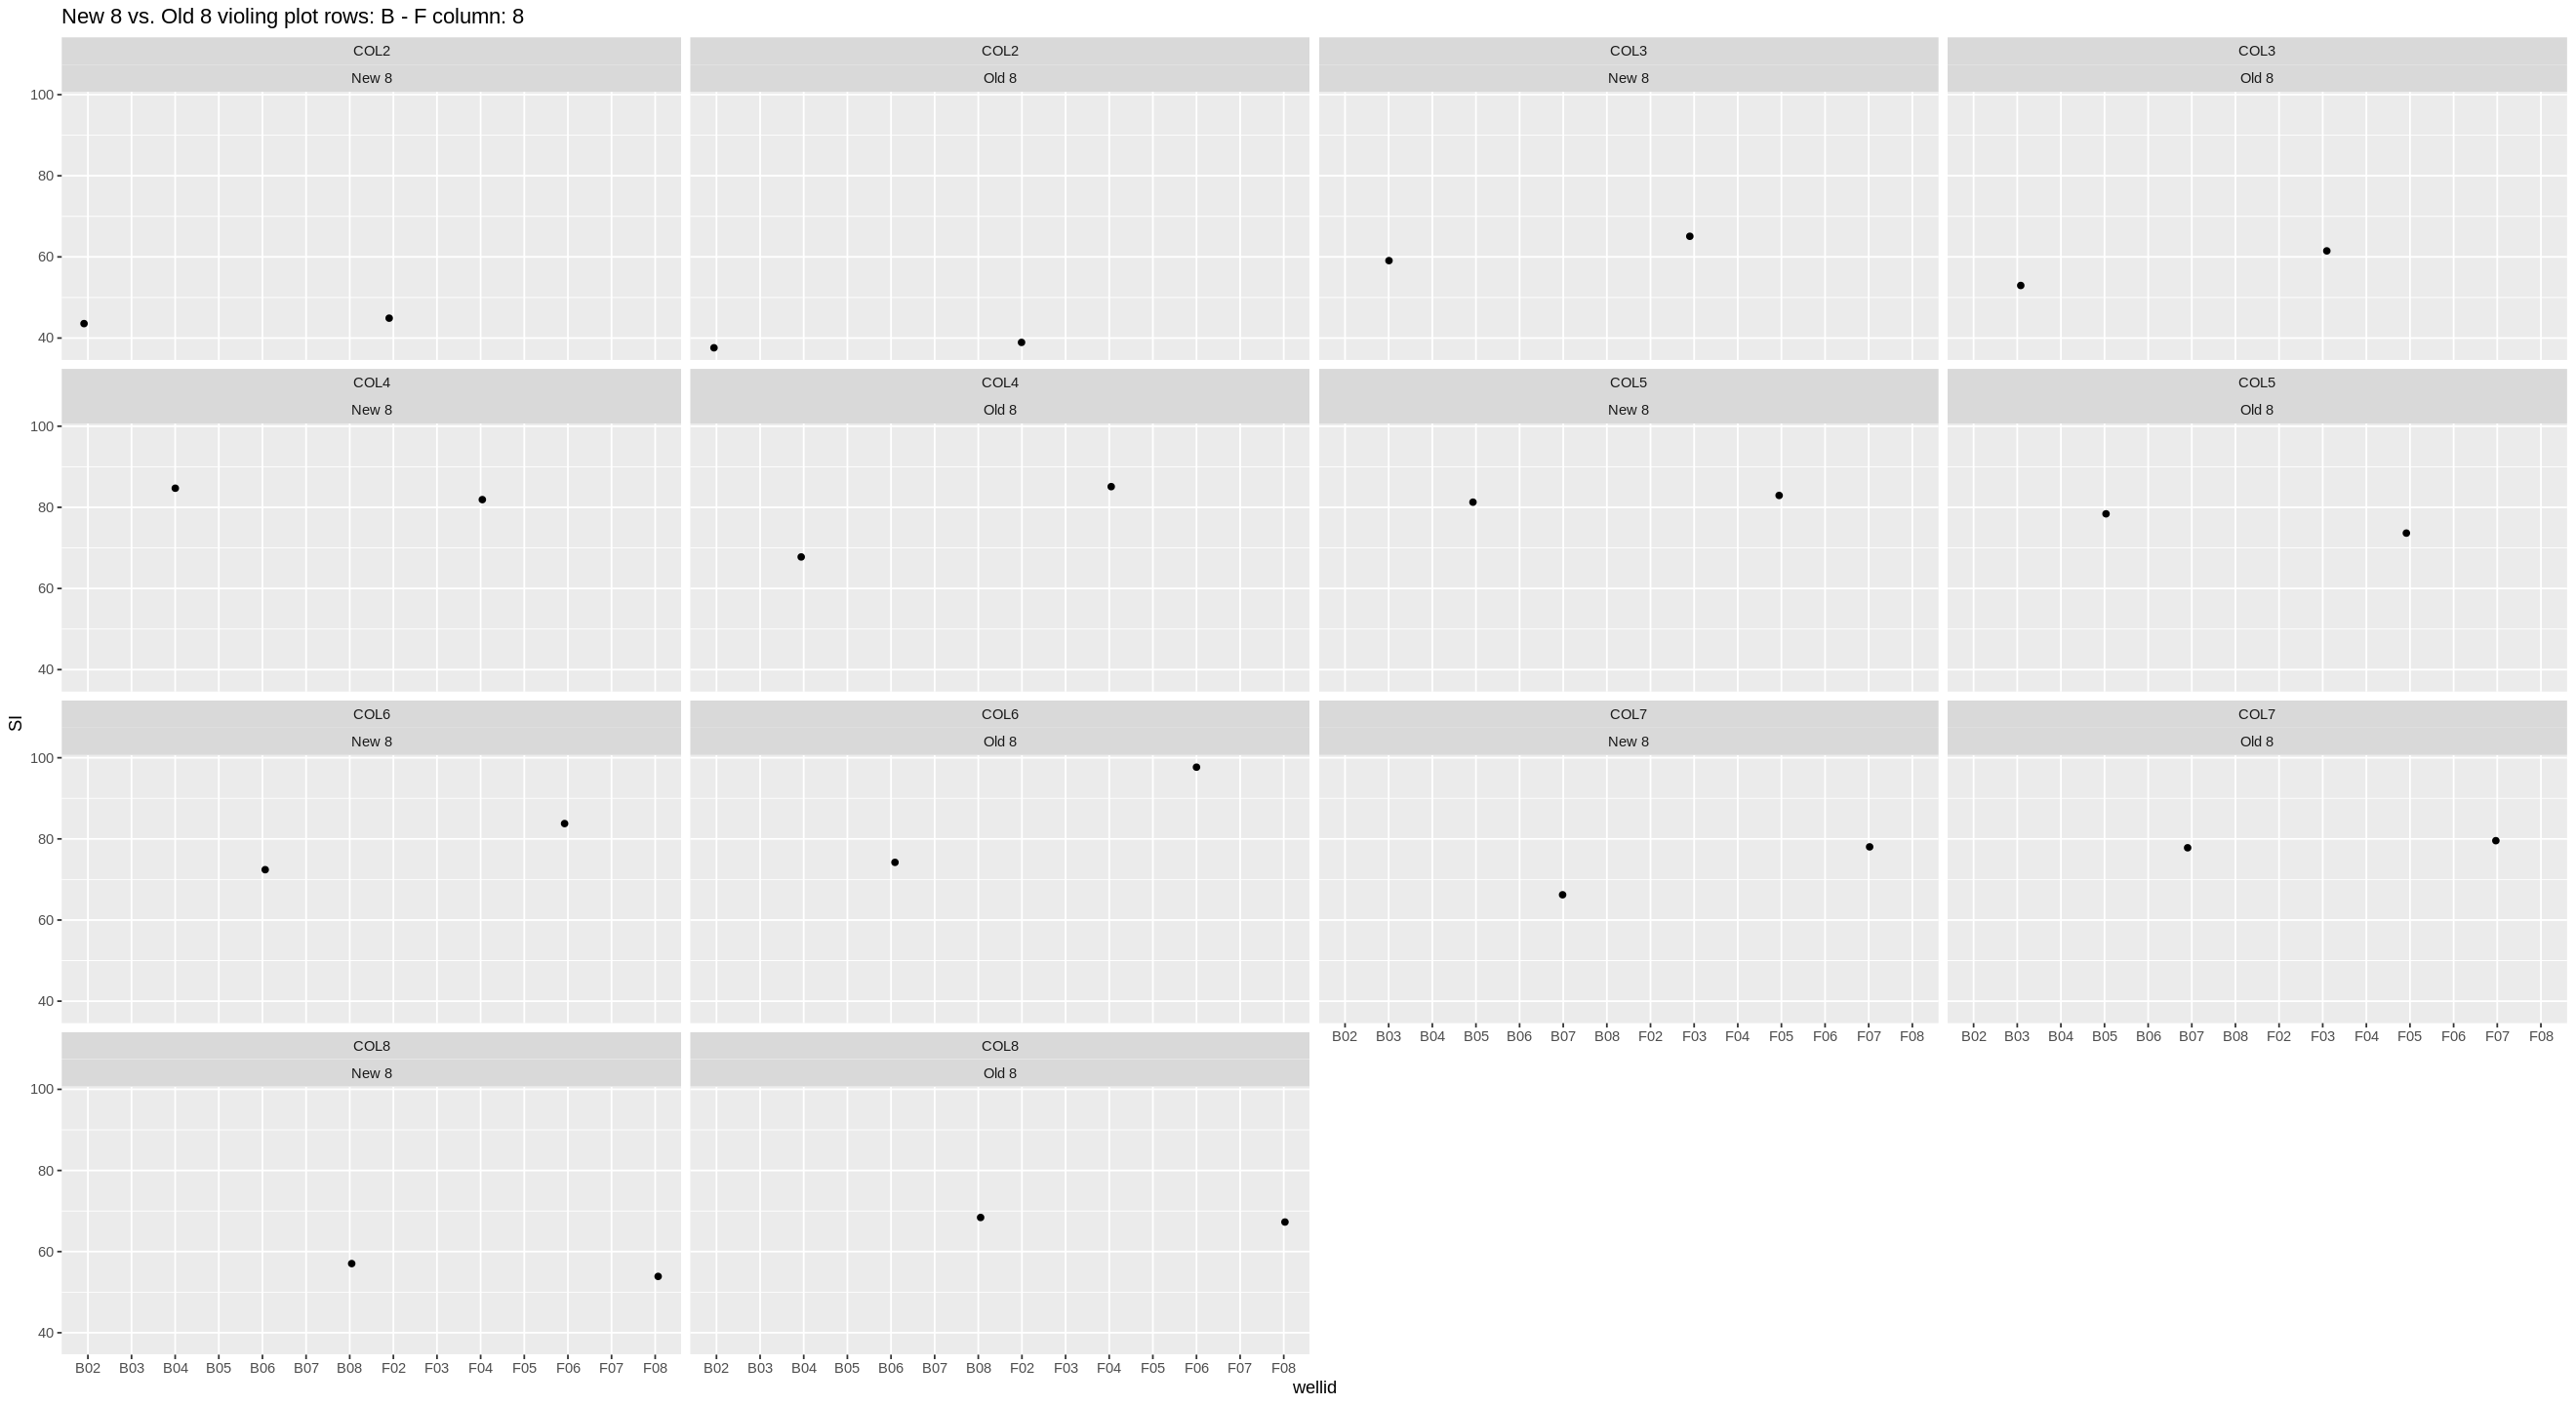

In [75]:
p_violin_si

In [163]:
# C-G
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
dft <- list()
for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    dft[[i-1]] <- dfm %>% 
                    filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i)) %>%
                    mutate(group = case_when(
                        as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
                        as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
                        as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
                        as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
                        as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
                        as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
                        as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
                        )
                      )
}

df.t <- do.call(rbind, dft)

p_qq_si <- ggplot(df.t, aes(sample = SI, group = group)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(group~ method) +
                ggtitle(paste("new 8 vs. old 8 q-q plot", pat1, "-", pat2))

p_hst_si <- ggplot(data = df.t, aes(group = group, x = SI)) +
    geom_histogram(aes(y = ..density..), binwidth = 12, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(group~ method) +
    ggtitle(paste("new 8 vs. old 8 histogram", pat1, "-", pat2))

p_violin_si <- ggplot(df.t, aes(wellid, SI)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 violing plot rows:", pat1, "-", pat2, "column:", i) ) +
    facet_wrap(group~ method)

[1] "C / G : 2"
[1] "C / G : 3"
[1] "C / G : 4"
[1] "C / G : 5"
[1] "C / G : 6"
[1] "C / G : 7"
[1] "C / G : 8"


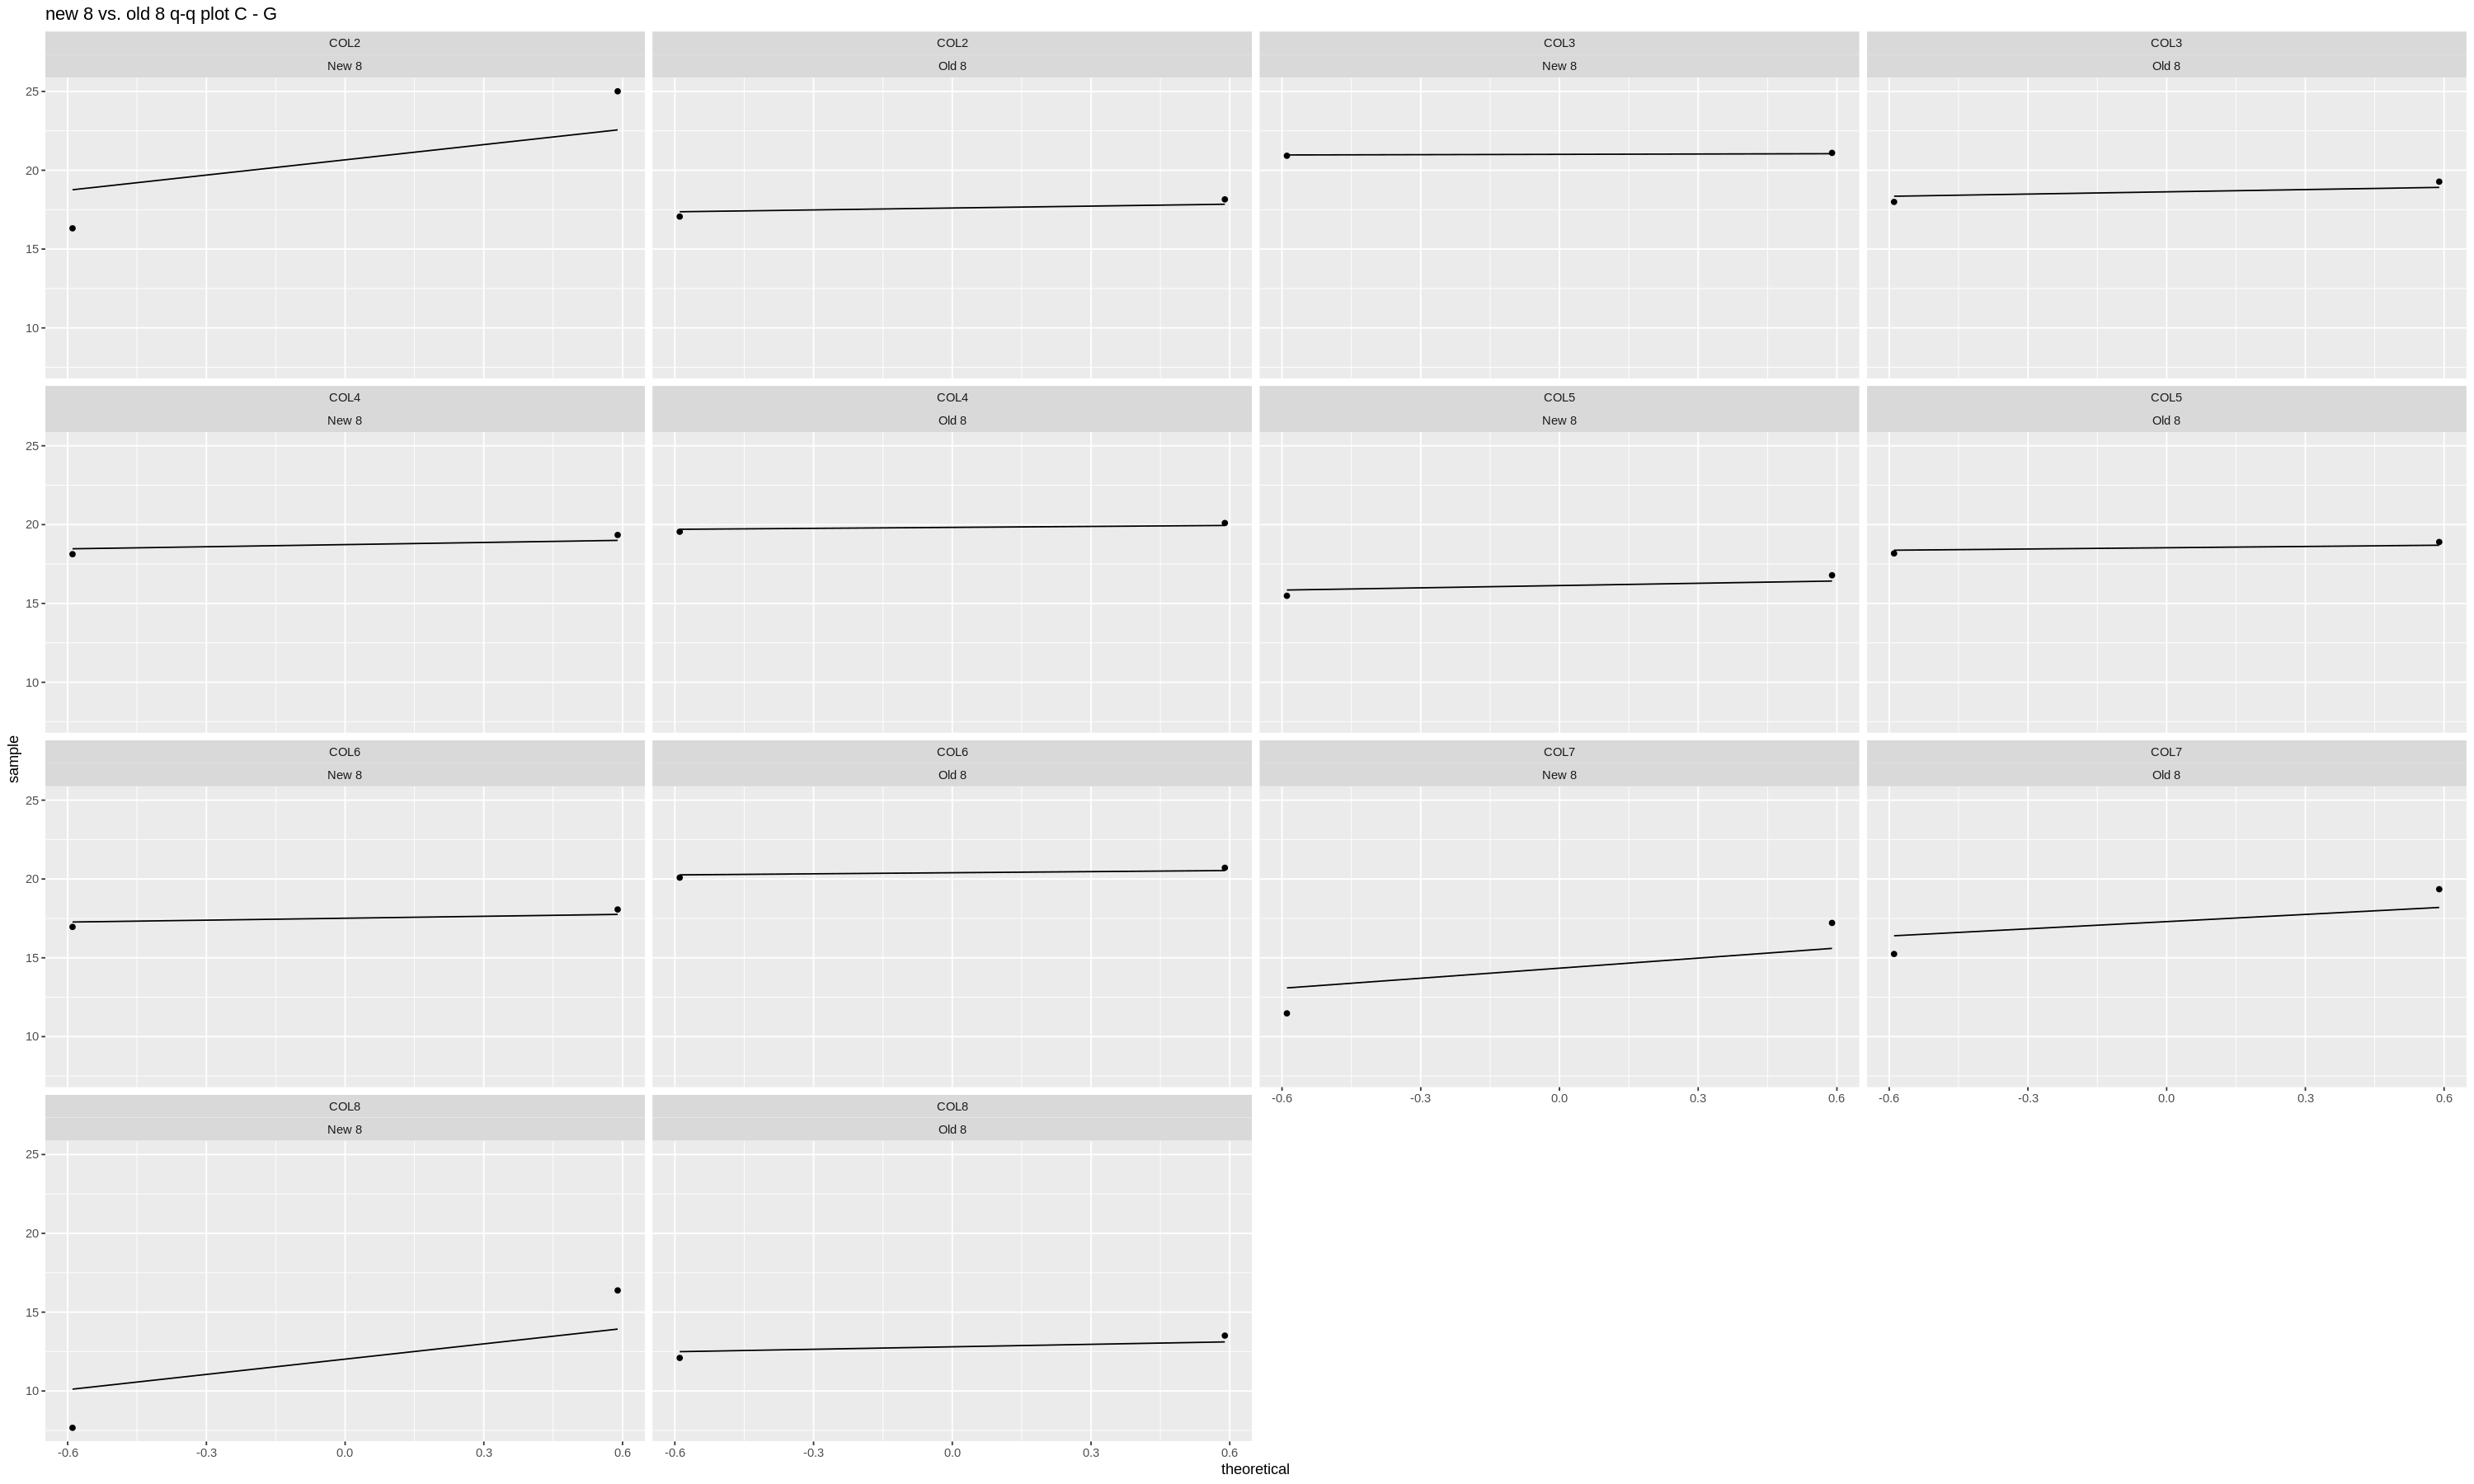

In [164]:
p_qq_si

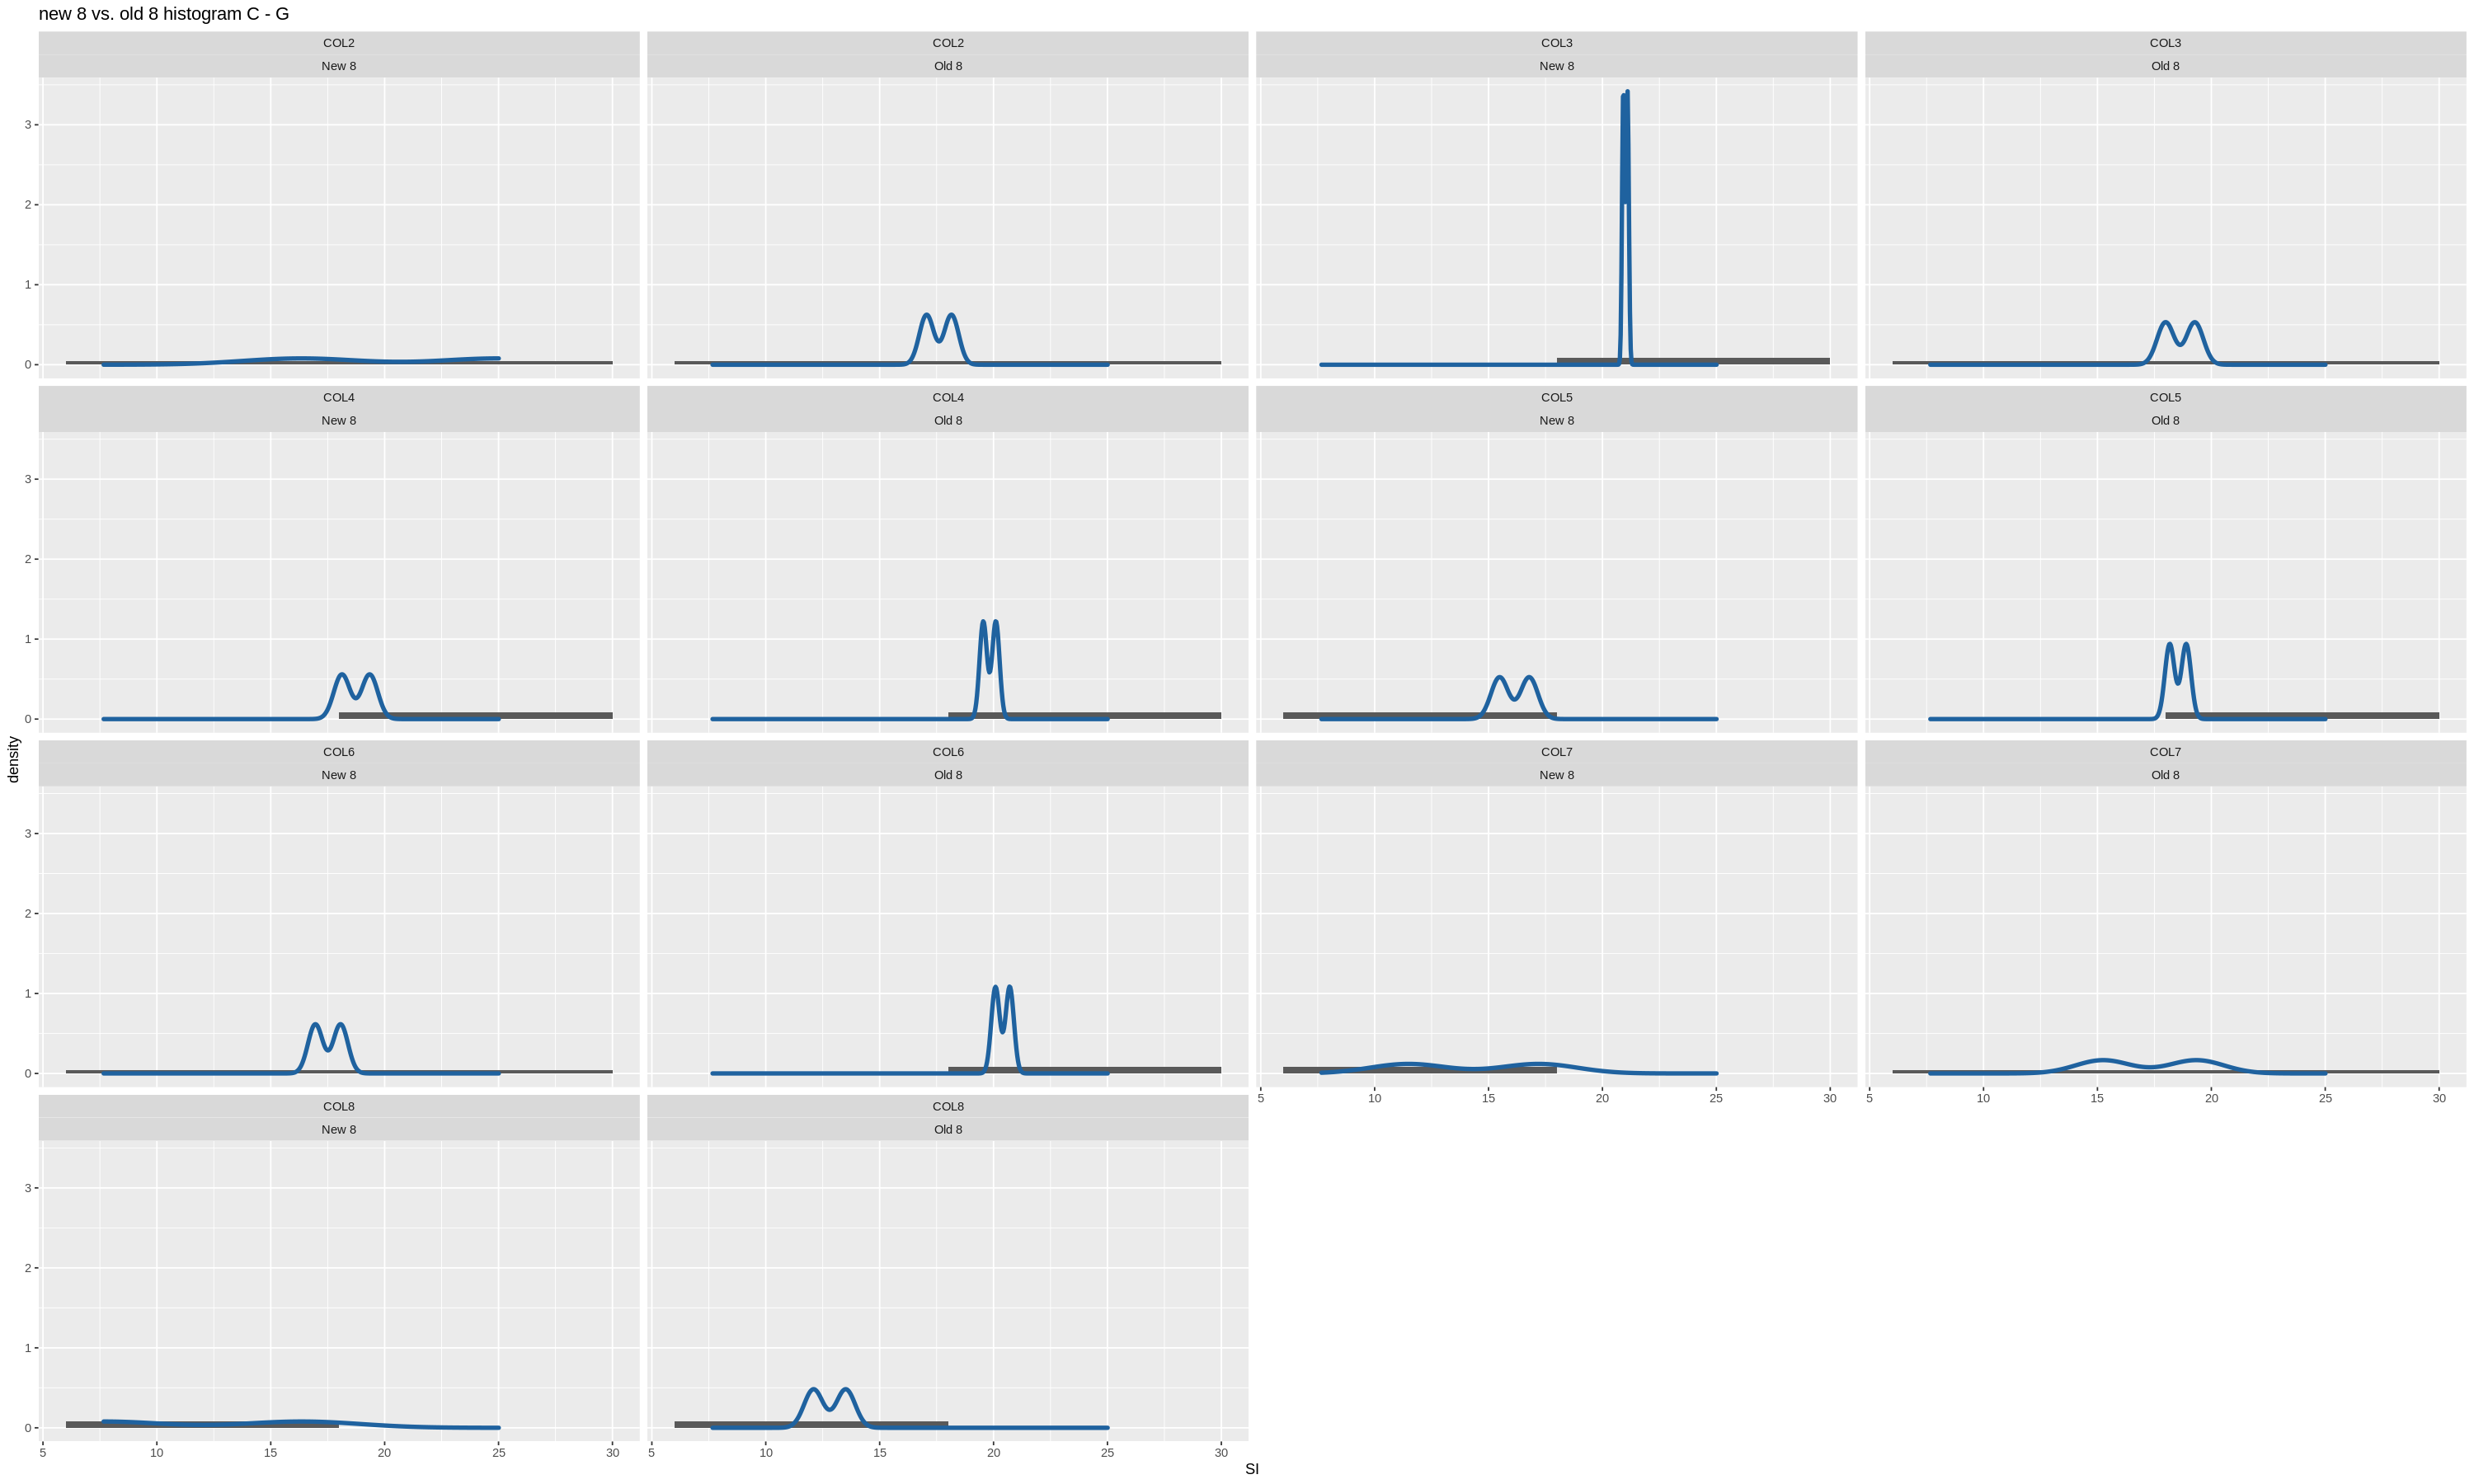

In [165]:
p_hst_si

Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Wa

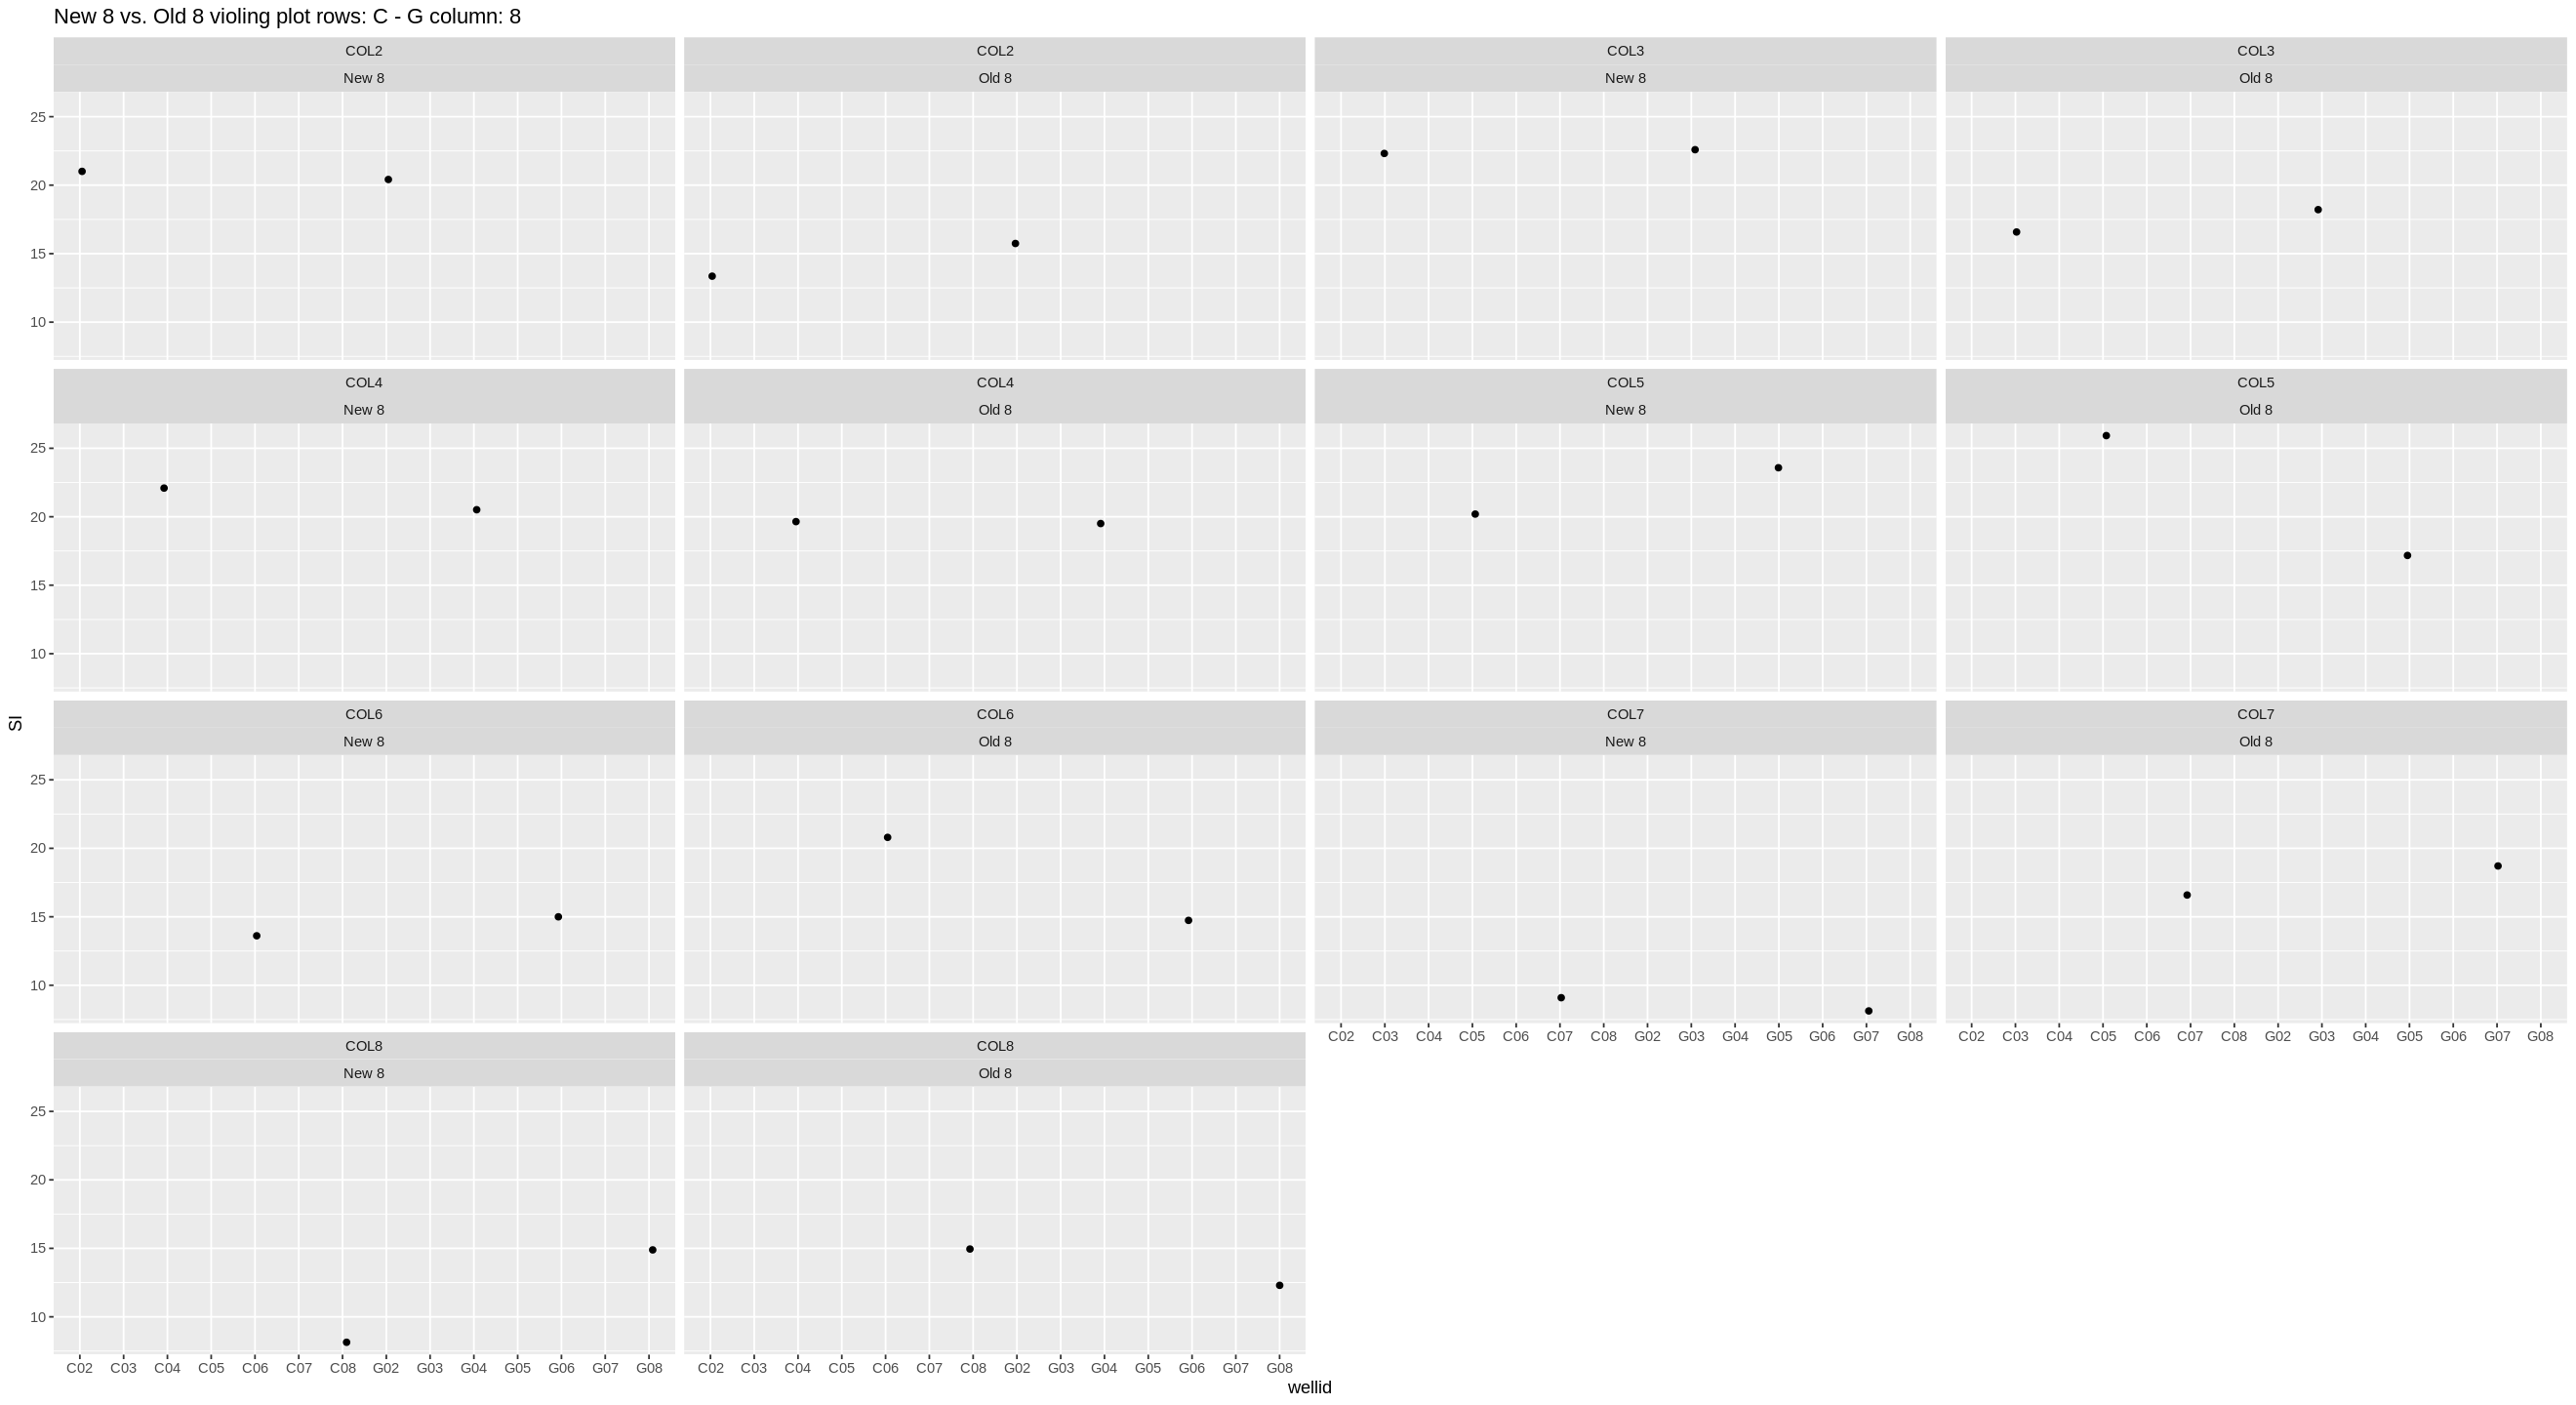

In [79]:
p_violin_si

In [166]:
# D-H
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
dft <- list()
for (i in seq(2,8)){
    print(paste(pat1,"/",pat2, ":", i))
    dft[[i-1]] <- dfm %>% 
                    filter(wellid == paste0(pat1,"0", i) | wellid == paste0(pat2,"0",i)) %>%
                    mutate(group = case_when(
                        as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
                        as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
                        as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
                        as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
                        as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
                        as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
                        as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
                        )
                      )
}

df.t <- do.call(rbind, dft)

p_qq_si <- ggplot(df.t, aes(sample = SI, group = group)) + 
                stat_qq() + stat_qq_line() +
                facet_wrap(group~ method) +
                ggtitle(paste("new 8 vs. old 8 q-q plot", pat1, "-", pat2))

p_hst_si <- ggplot(data = df.t, aes(group = group, x = SI)) +
    geom_histogram(aes(y = ..density..), binwidth = 12, position = "identity") + 
    geom_density(alpha=0.5, colour = '#1F629F', lwd = 1.5) + 
    facet_wrap(group~ method) +
    ggtitle(paste("new 8 vs. old 8 histogram", pat1, "-", pat2))

p_violin_si <- ggplot(df.t, aes(wellid, SI)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 violing plot rows:", pat1, "-", pat2, "column:", i) ) +
    facet_wrap(group~ method)

[1] "D / H : 2"
[1] "D / H : 3"
[1] "D / H : 4"
[1] "D / H : 5"
[1] "D / H : 6"
[1] "D / H : 7"
[1] "D / H : 8"


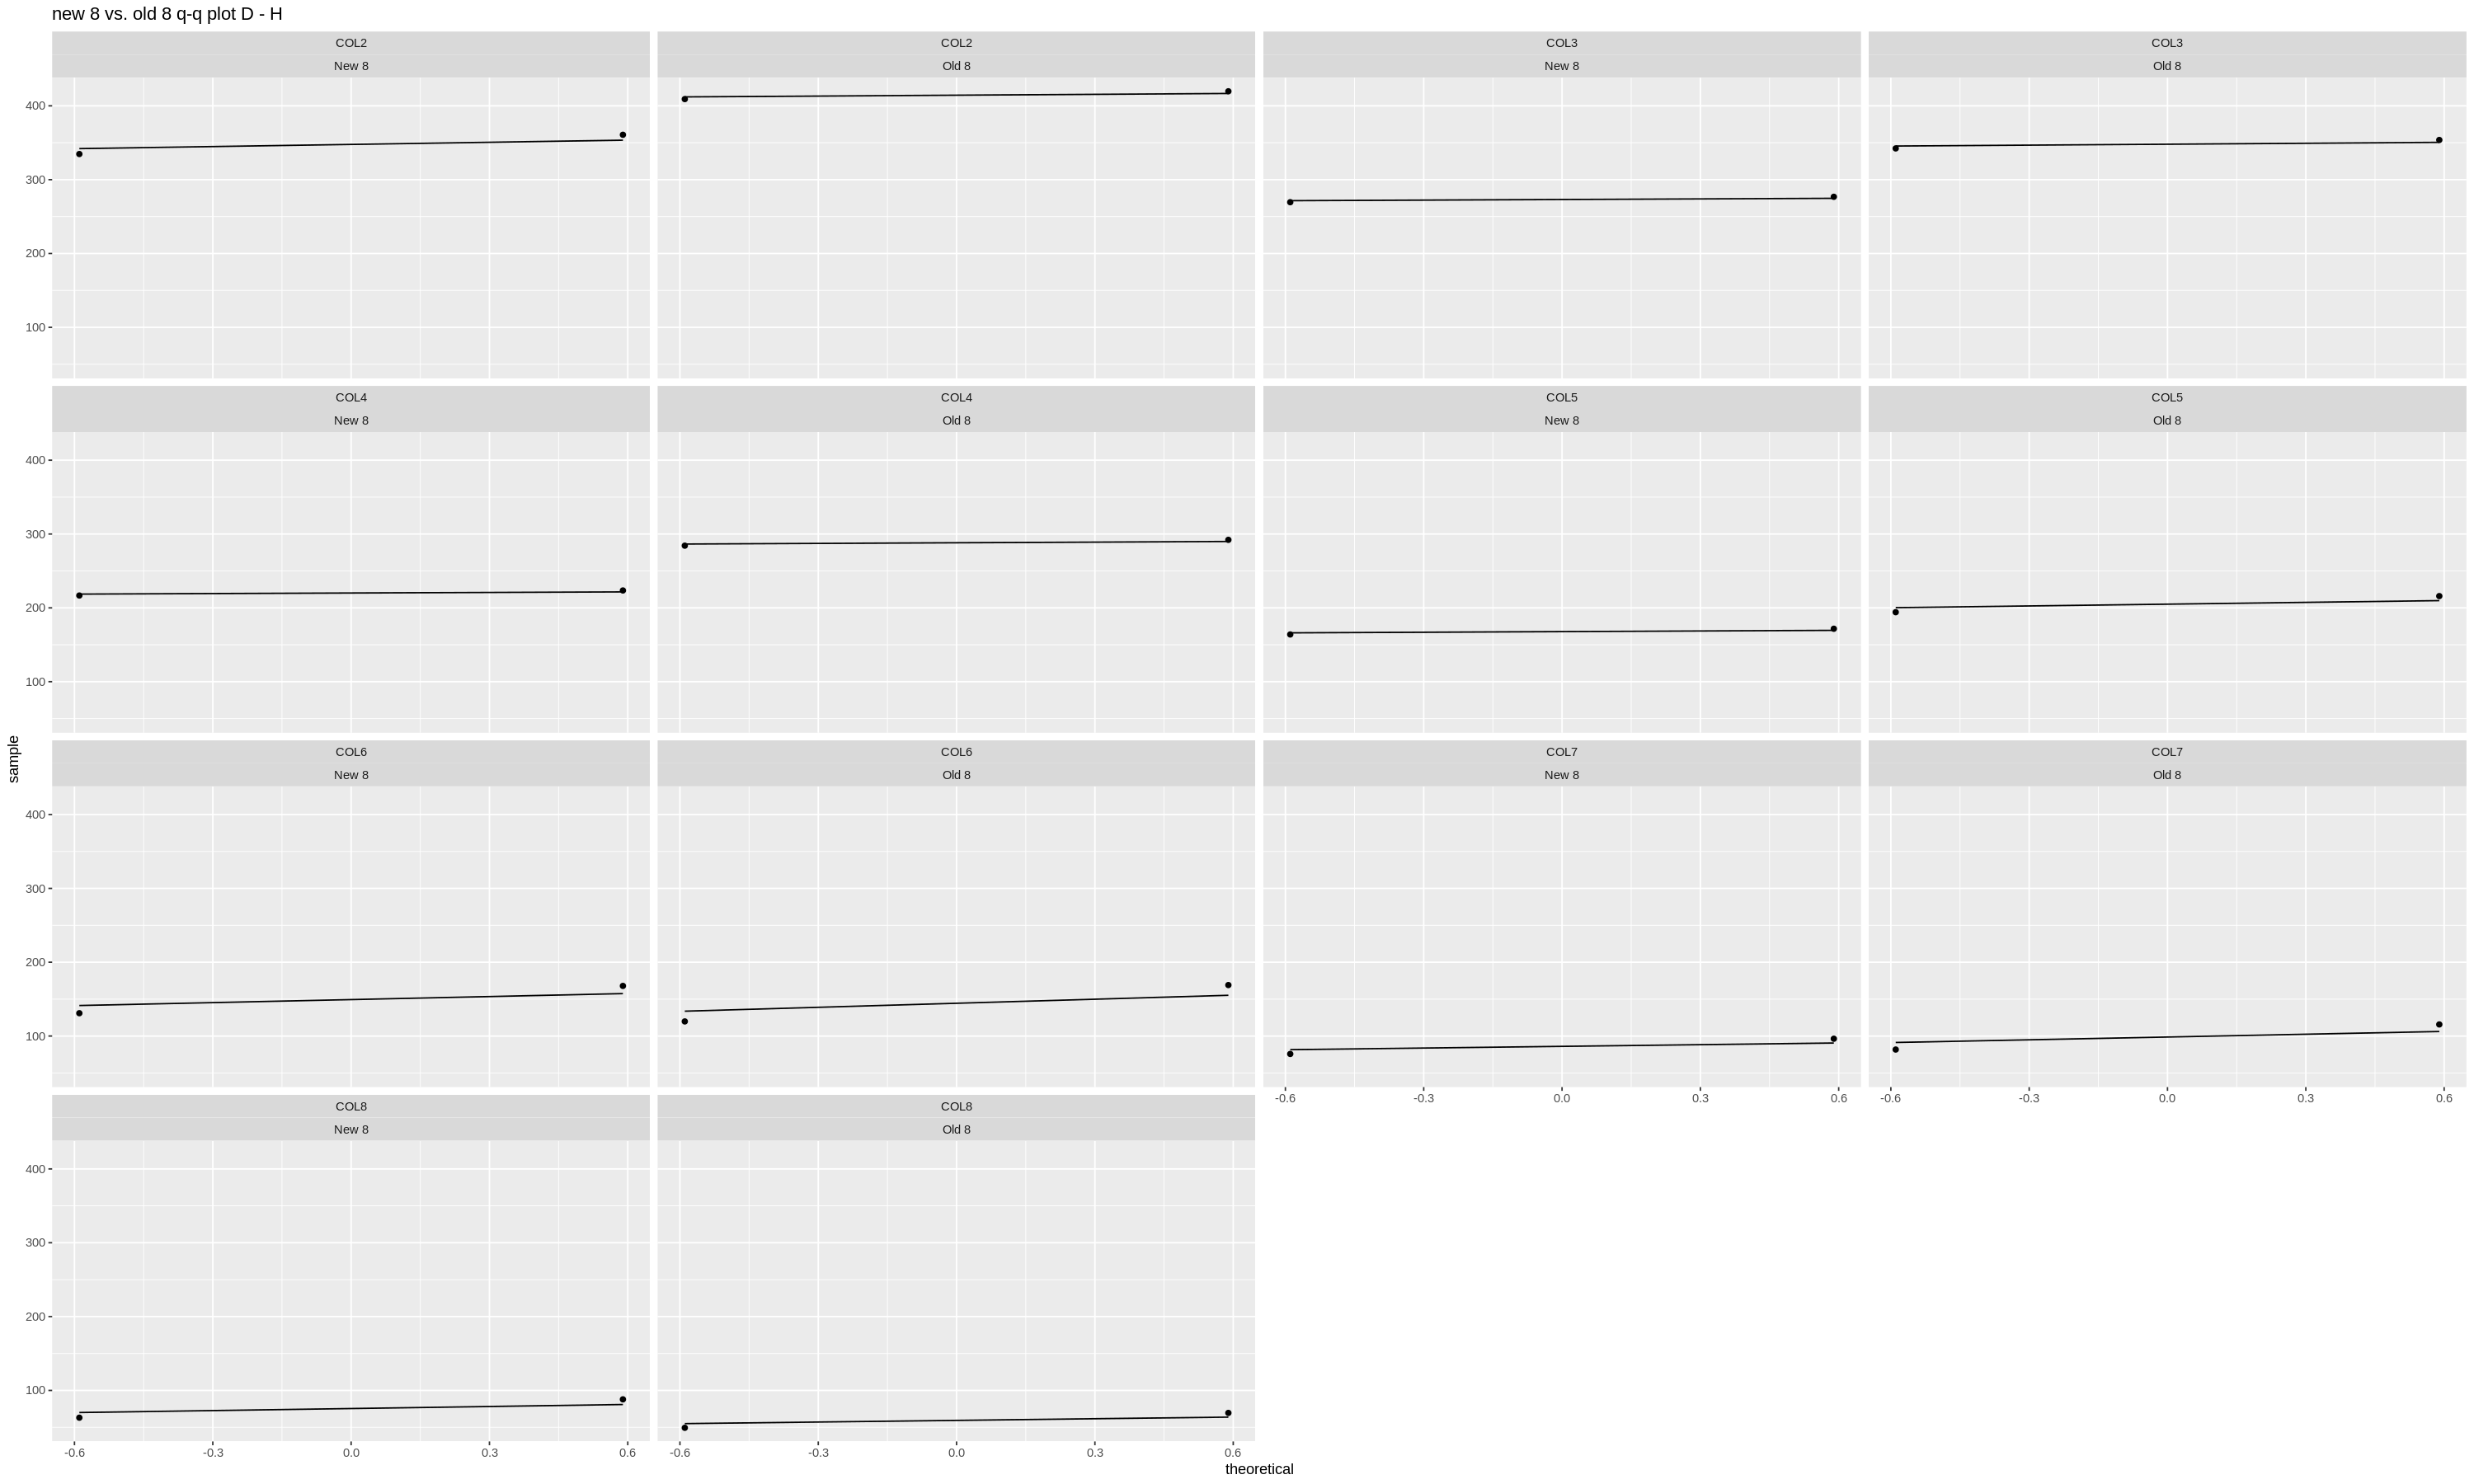

In [167]:
p_qq_si

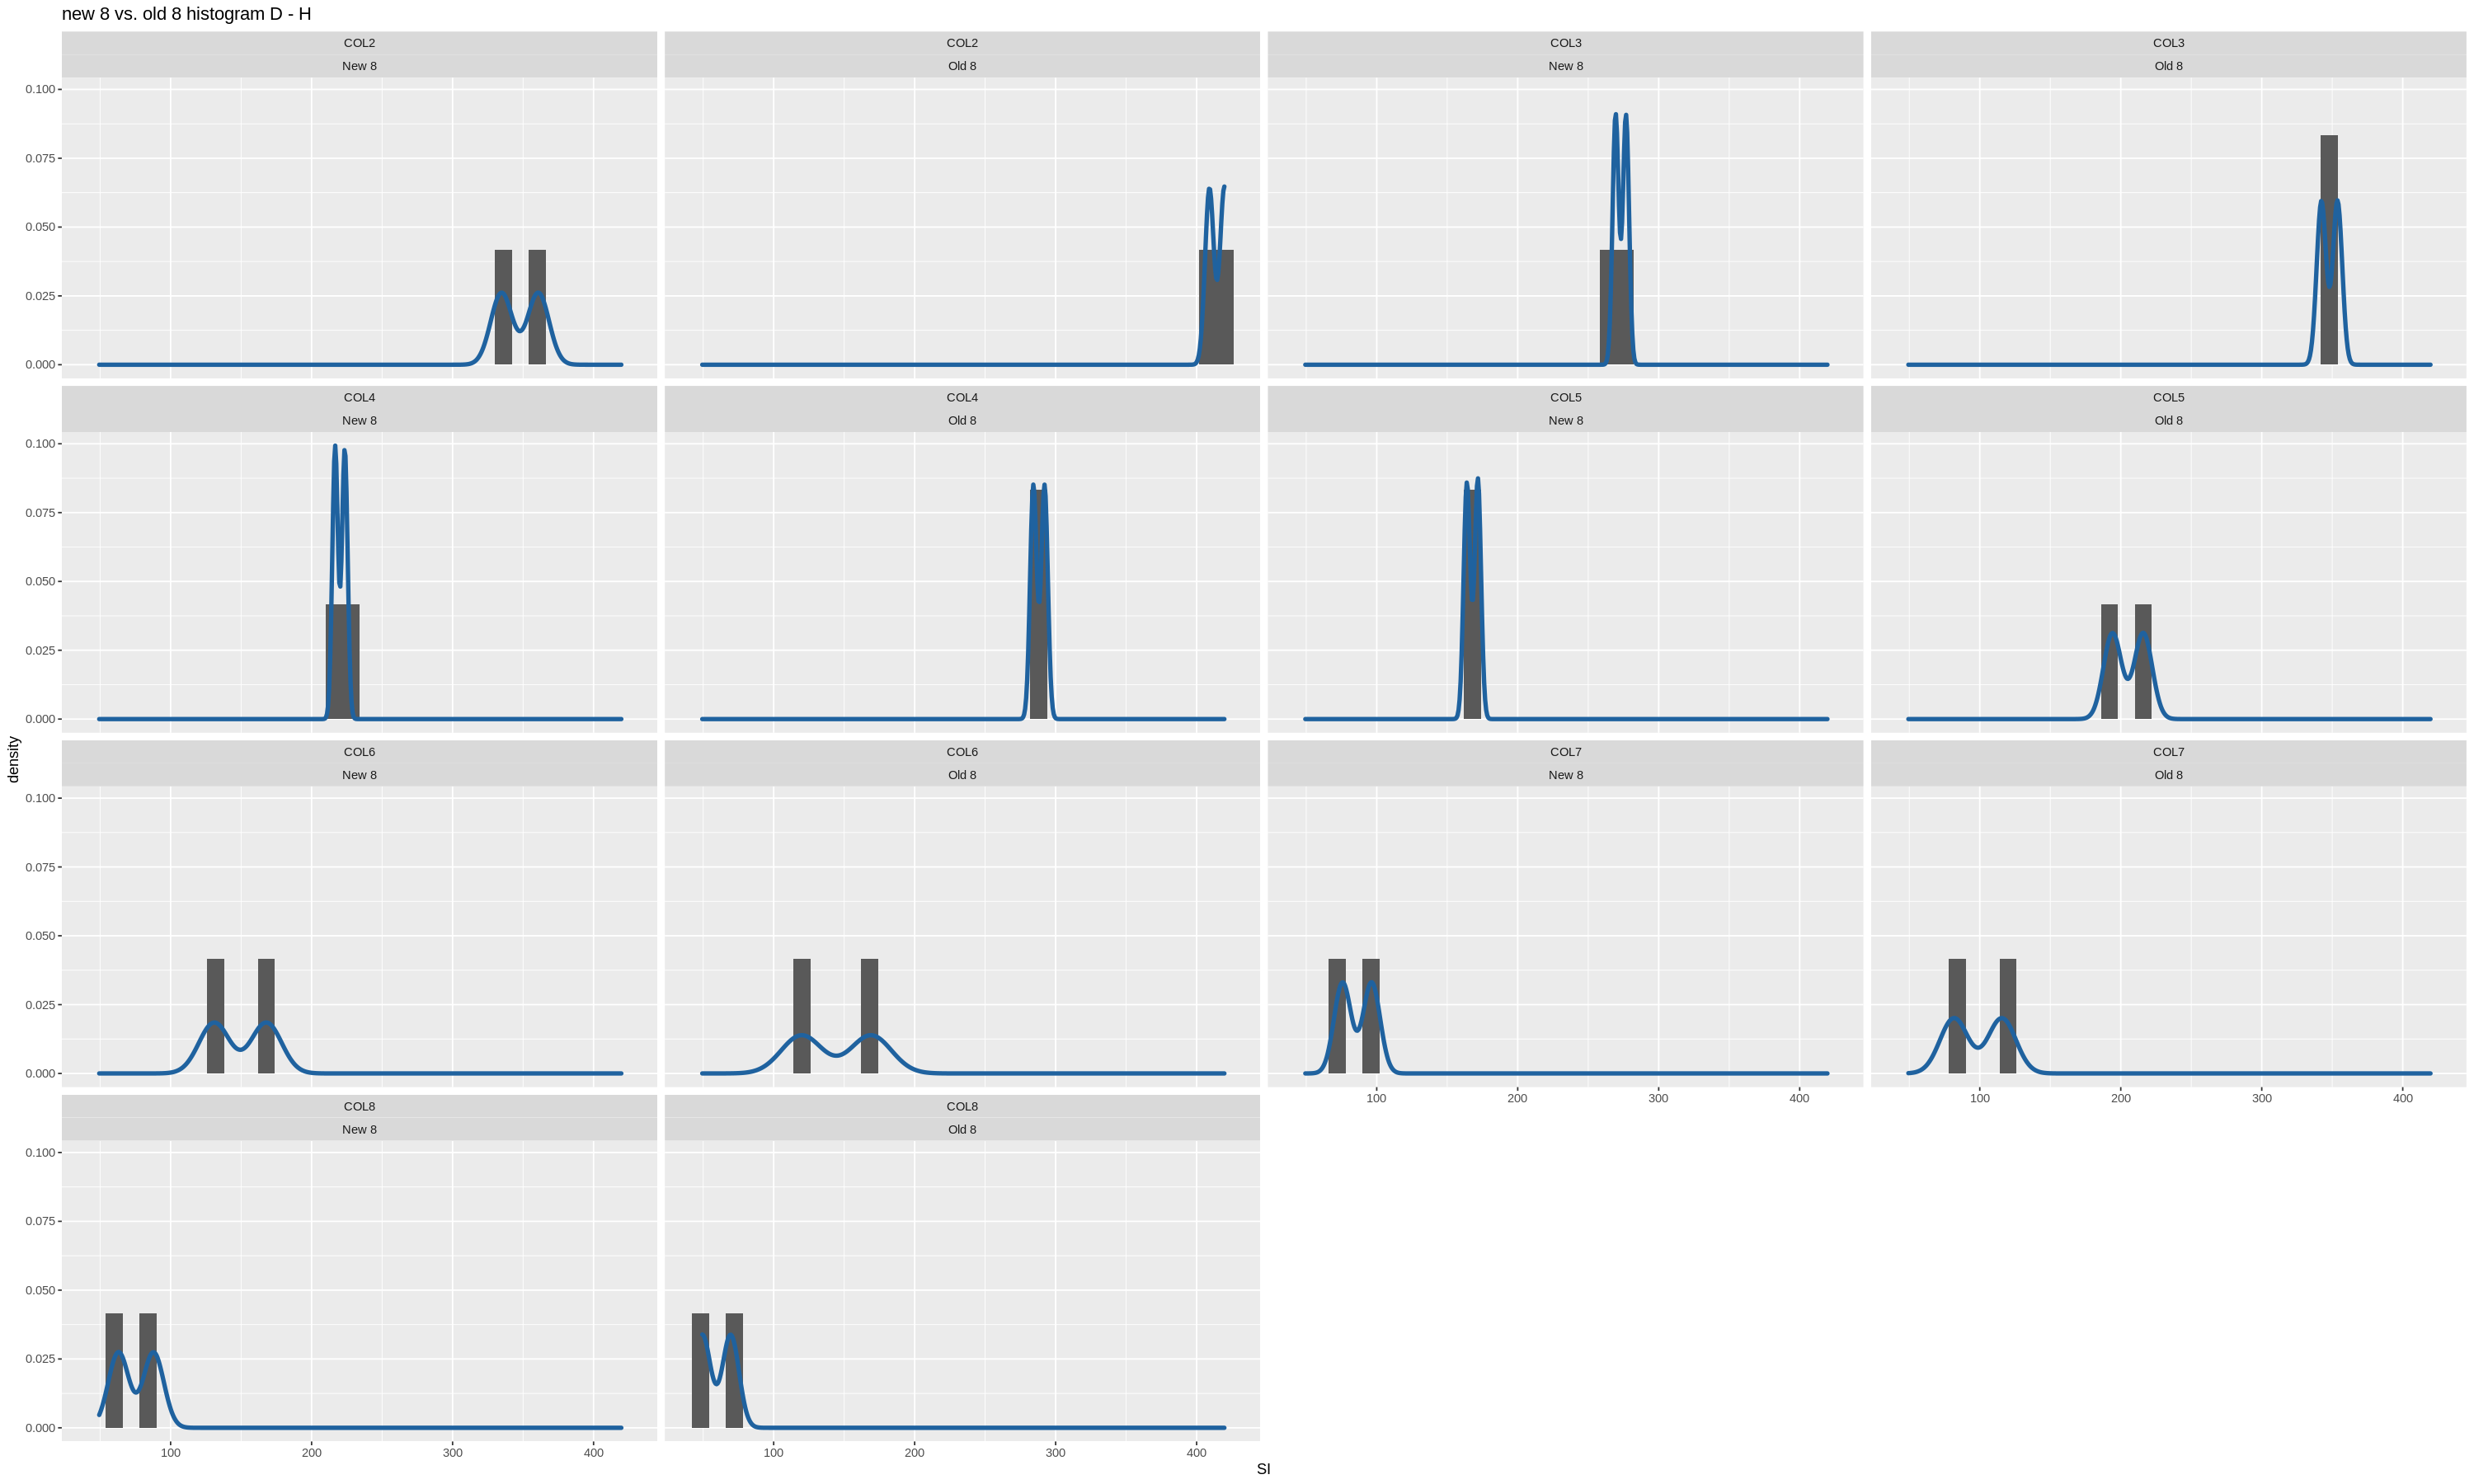

In [168]:
p_hst_si

Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Wa

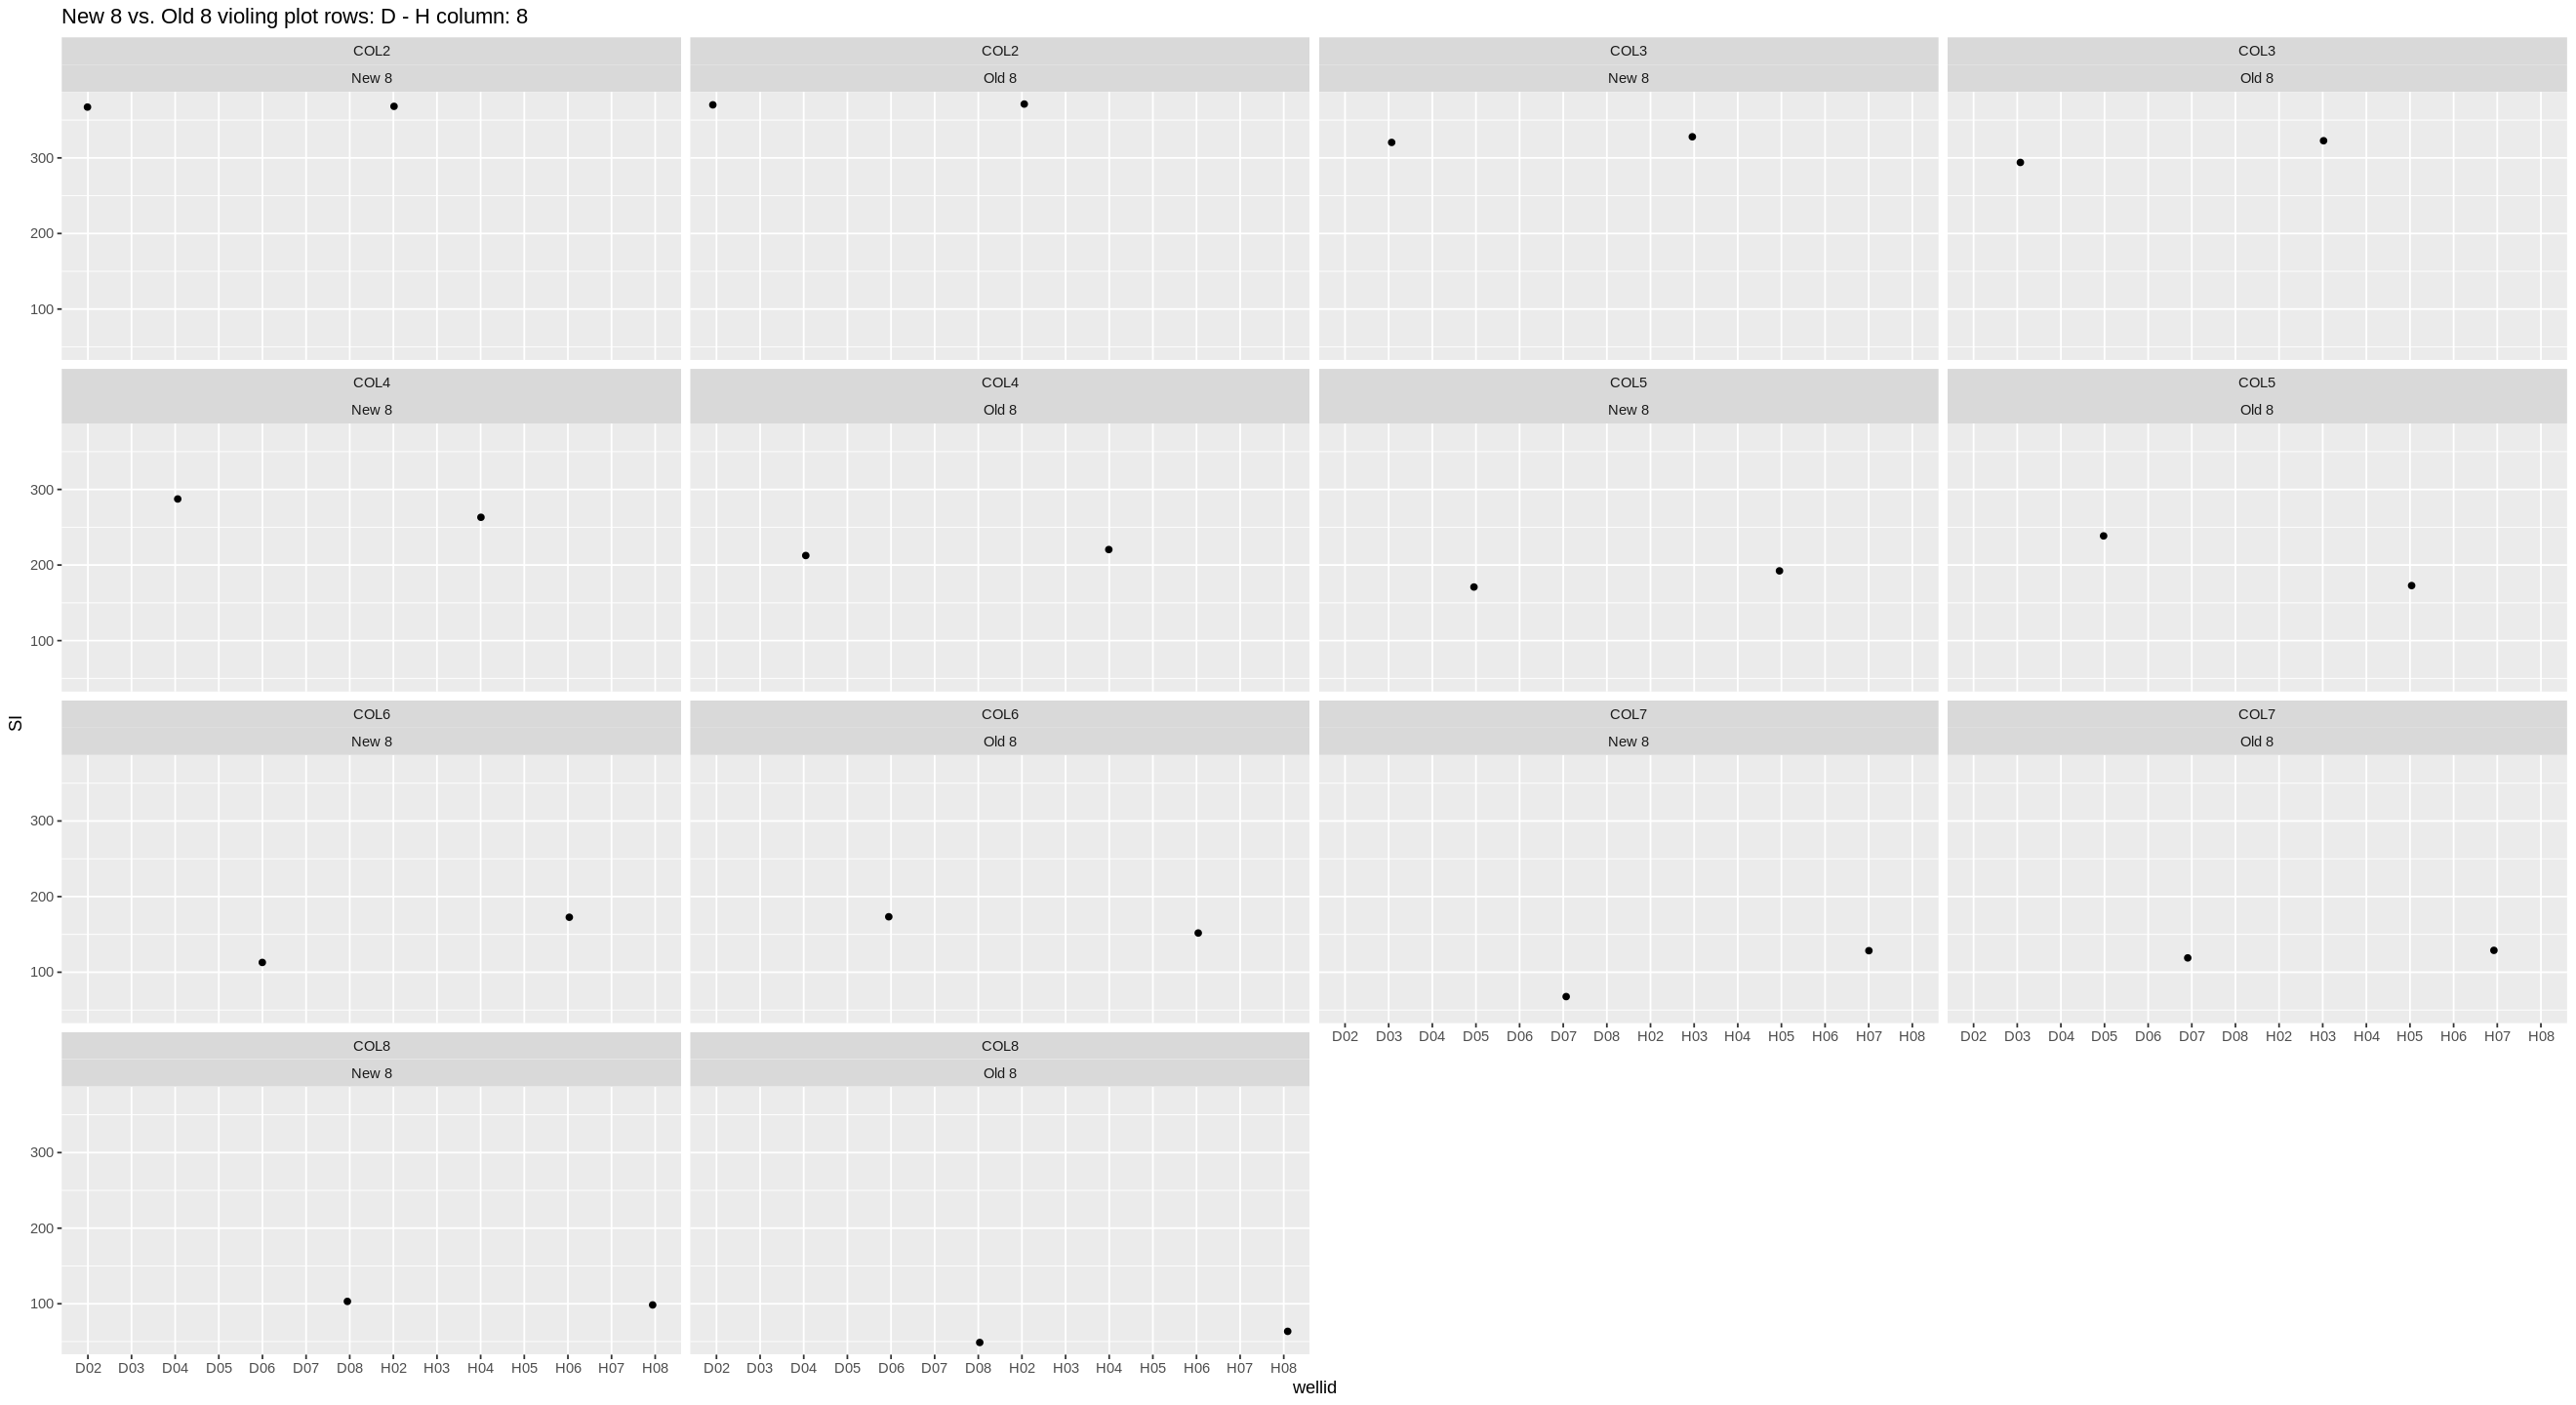

In [84]:
p_violin_si
#ggsave(filename = "violin_4rows_new8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

In [85]:
save_gg <- function(p, ncol, filename) {
    pp <- arrangeGrob(grobs = p, ncol=ncol)
    ggsave(filename = paste0(filename, ".png"), plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)
}

#### Violin plots
-  It is similar to a box plot, with the addition of a rotated kernel density plot on each side

Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”


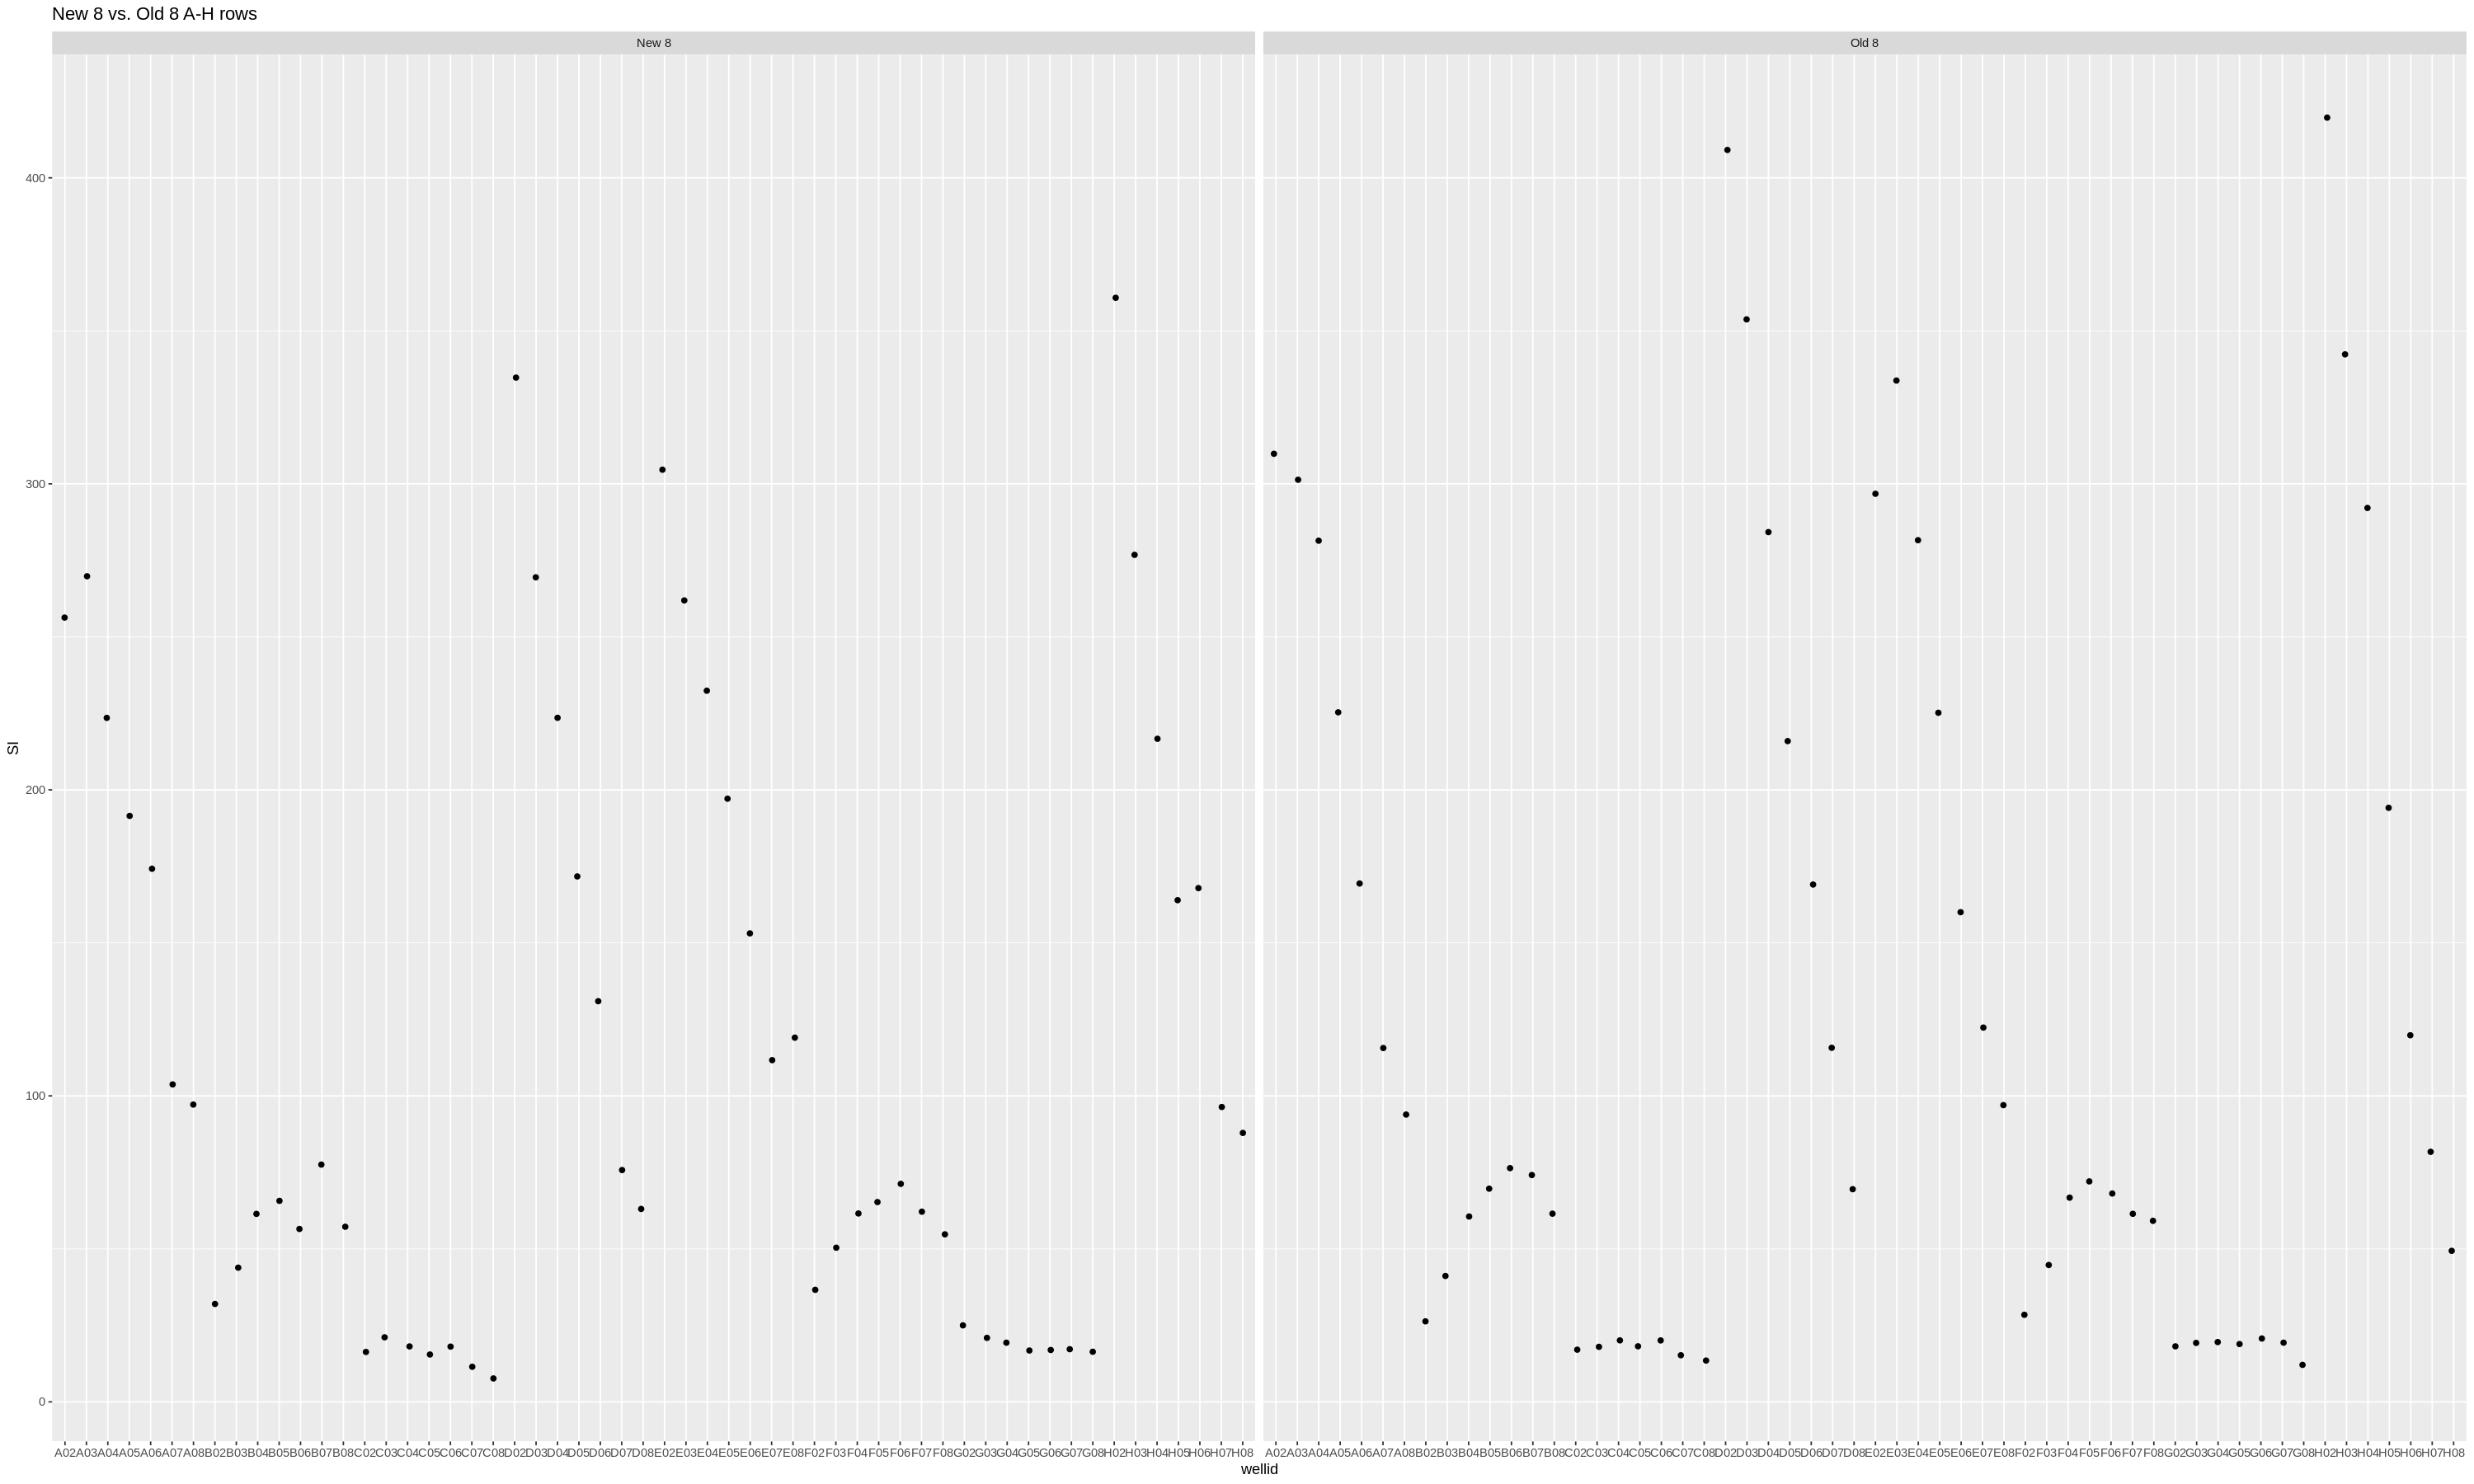

In [169]:
ggplot(dfm, aes(wellid, SI)) + 
    geom_violin(aes(colour = wellid)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 A-H rows") ) +
    facet_wrap(~ method)
#ggsave(filename = "violin_4rows_new8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

In [233]:
dff <- dfm %>% 
    mutate(group = case_when(
       as.numeric(substr(wellid,3,3)) == 2 ~ "COL2",
       as.numeric(substr(wellid,3,3)) == 3 ~ "COL3",
       as.numeric(substr(wellid,3,3)) == 4 ~ "COL4",
       as.numeric(substr(wellid,3,3)) == 5 ~ "COL5",
       as.numeric(substr(wellid,3,3)) == 6 ~ "COL6",
       as.numeric(substr(wellid,3,3)) == 7 ~ "COL7",
       as.numeric(substr(wellid,3,3)) == 8 ~ "COL8"
        ),
           row = case_when(
       substr(wellid, 1,1) == "A" ~ "A-E",
       substr(wellid, 1,1) == "B" ~ "B-F",
       substr(wellid, 1,1) == "C" ~ "C-G",
       substr(wellid, 1,1) == "D" ~ "D-H",
       substr(wellid, 1,1) == "E" ~ "A-E",
       substr(wellid, 1,1) == "F" ~ "B-F",
       substr(wellid, 1,1) == "G" ~ "C-G",
       substr(wellid, 1,1) == "H" ~ "D-H"
       ),
           subgroup = case_when(
       row == "A-E" & group == "COL2" ~ "A2-E2",
       row == "A-E" & group == "COL3" ~ "A3-E3",
       row == "A-E" & group == "COL4" ~ "A4-E4",
       row == "A-E" & group == "COL5" ~ "A5-E5",
       row == "A-E" & group == "COL6" ~ "A6-E6",
       row == "A-E" & group == "COL7" ~ "A7-E7",
       row == "A-E" & group == "COL8" ~ "A8-E8",
       row == "B-F" & group == "COL2" ~ "B2-F2",
       row == "B-F" & group == "COL3" ~ "B3-F3",
       row == "B-F" & group == "COL4" ~ "B4-F4",
       row == "B-F" & group == "COL5" ~ "B5-F5",
       row == "B-F" & group == "COL6" ~ "B6-F6",
       row == "B-F" & group == "COL7" ~ "B7-F7",
       row == "B-F" & group == "COL8" ~ "B8-F8",
       row == "C-G" & group == "COL2" ~ "C2-G2",
       row == "C-G" & group == "COL3" ~ "C3-G3",
       row == "C-G" & group == "COL4" ~ "C4-G4",
       row == "C-G" & group == "COL5" ~ "C5-G5",
       row == "C-G" & group == "COL6" ~ "C6-G6",
       row == "C-G" & group == "COL7" ~ "C7-G7",
       row == "C-G" & group == "COL8" ~ "C8-G8",
       row == "D-H" & group == "COL2" ~ "D2-H2",
       row == "D-H" & group == "COL3" ~ "D3-H3",
       row == "D-H" & group == "COL4" ~ "D4-H4",
       row == "D-H" & group == "COL5" ~ "D5-H5",
       row == "D-H" & group == "COL6" ~ "D6-H6",
       row == "D-H" & group == "COL7" ~ "D7-H7",
       row == "D-H" & group == "COL8" ~ "D8-H8"
           )
      )

In [234]:
head(dff)

SI       SAMPLE_NAME                 wellid plate   method group row subgroup
1 256.2940 Specimen_001_A2_A02_001.fcs A02    plate 1 New 8  COL2  A-E A2-E2   
2 269.7985 Specimen_001_A3_A03_002.fcs A03    plate 1 New 8  COL3  A-E A3-E3   
3 223.5190 Specimen_001_A4_A04_003.fcs A04    plate 1 New 8  COL4  A-E A4-E4   
4 191.4912 Specimen_001_A5_A05_004.fcs A05    plate 1 New 8  COL5  A-E A5-E5   
5 174.2166 Specimen_001_A6_A06_005.fcs A06    plate 1 New 8  COL6  A-E A6-E6   
6 103.7435 Specimen_001_A7_A07_006.fcs A07    plate 1 New 8  COL7  A-E A7-E7

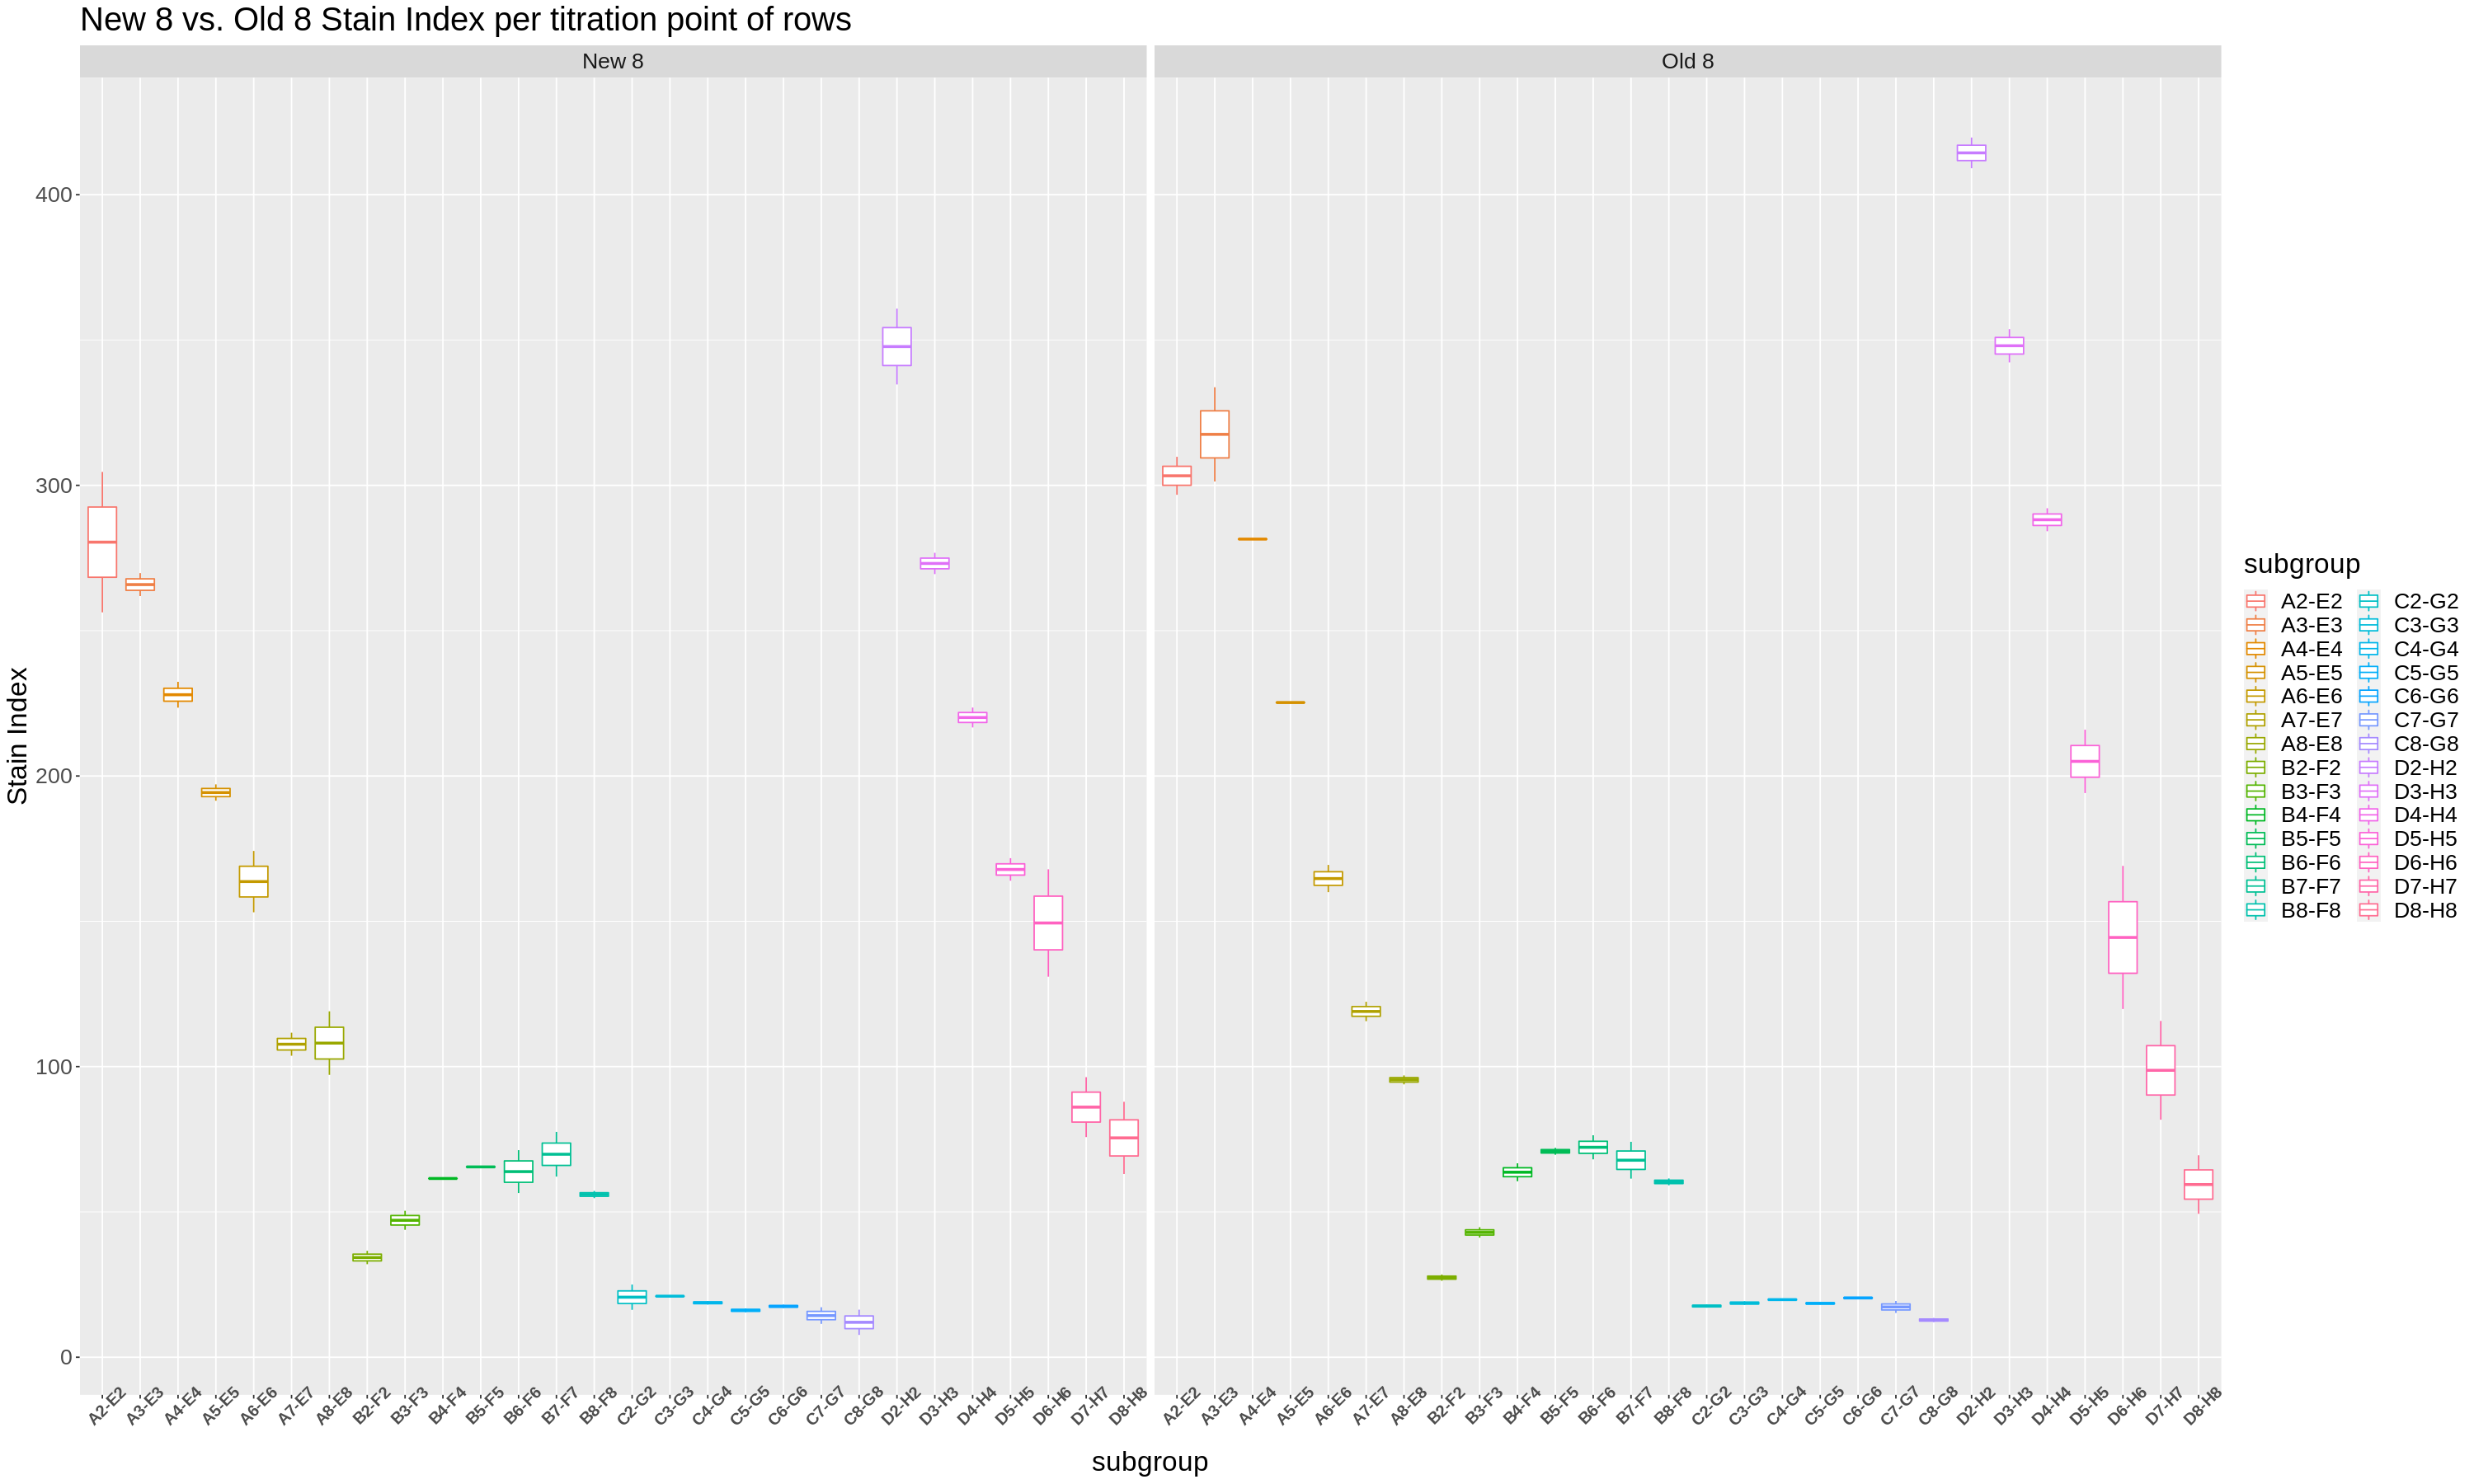

In [215]:
ggplot(dff, aes(subgroup, SI, colour = subgroup)) + 
  geom_boxplot() + 
  labs(title="New 8 vs. Old 8 Stain Index per titration point of rows") +
  ylab("Stain Index") +
  facet_wrap(~method) + 
  theme(text = element_text(size=20),
        axis.text.x = element_text(face = "bold", 
                           size = 12, angle = 45)) 

Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”
Warning message in max(data$density):
“no non-missing arguments to max; returning -Inf”
Warning message:
“Computation failed in `stat_ydensity()`:
replacement has 1 row, data has 0”


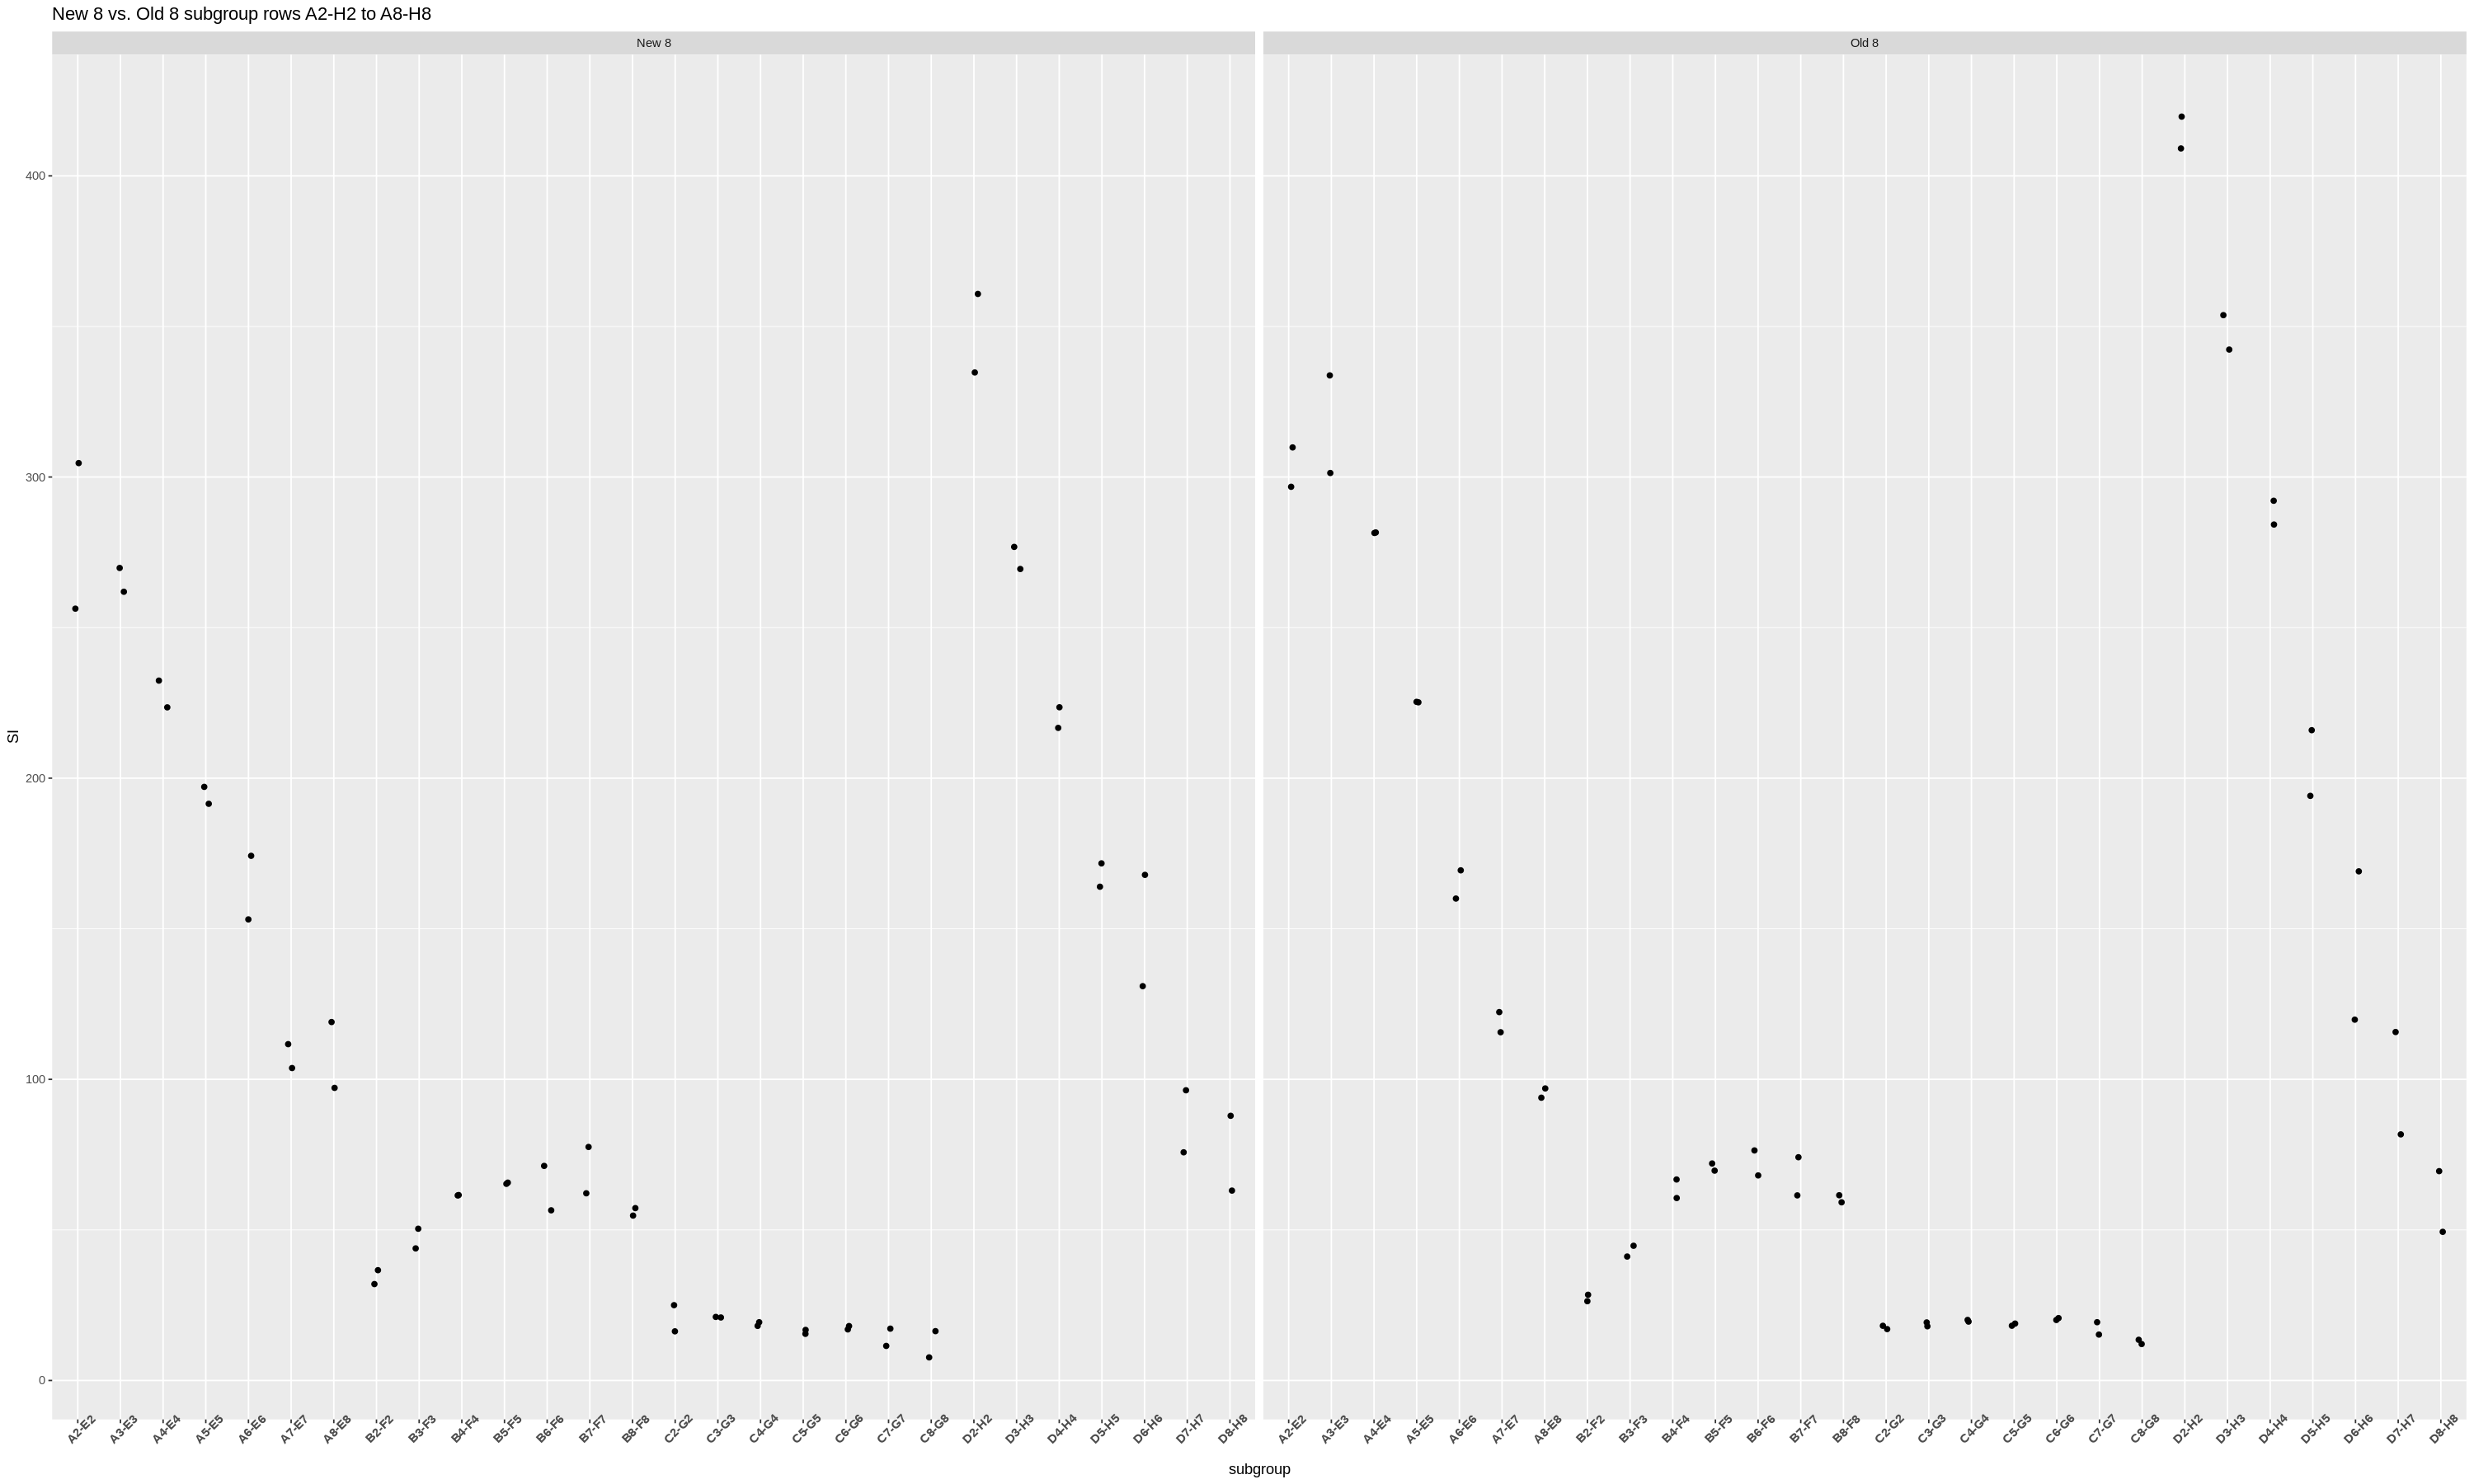

In [171]:
ggplot(dff, aes(subgroup, SI,)) + 
    geom_violin(aes(colour = subgroup)) + 
    geom_jitter(height = 0, width = 0.1) +
    ggtitle(paste("New 8 vs. Old 8 subgroup rows A2-H2 to A8-H8") ) +
    facet_wrap( ~ method) + 
    theme(axis.text.x = element_text(face = "bold", 
                           size = 8.75, angle = 45)) 

In [172]:
head(dff)

SI       SAMPLE_NAME                 wellid plate   method group row subgroup
1 256.2940 Specimen_001_A2_A02_001.fcs A02    plate 1 New 8  COL2  A-E A2-E2   
2 269.7985 Specimen_001_A3_A03_002.fcs A03    plate 1 New 8  COL3  A-E A3-E3   
3 223.5190 Specimen_001_A4_A04_003.fcs A04    plate 1 New 8  COL4  A-E A4-E4   
4 191.4912 Specimen_001_A5_A05_004.fcs A05    plate 1 New 8  COL5  A-E A5-E5   
5 174.2166 Specimen_001_A6_A06_005.fcs A06    plate 1 New 8  COL6  A-E A6-E6   
6 103.7435 Specimen_001_A7_A07_006.fcs A07    plate 1 New 8  COL7  A-E A7-E7

In [173]:
dff %>% filter(group=="COL2" & row == "A-E")

SI       SAMPLE_NAME                 wellid plate   method group row subgroup
1 256.2940 Specimen_001_A2_A02_001.fcs A02    plate 1 New 8  COL2  A-E A2-E2   
2 304.6173 Specimen_001_E2_E02_049.fcs E02    plate 1 New 8  COL2  A-E A2-E2   
3 309.8282 Specimen_001_A2_A02_097.fcs A02    plate 1 Old 8  COL2  A-E A2-E2   
4 296.7535 Specimen_001_E2_E02_145.fcs E02    plate 1 Old 8  COL2  A-E A2-E2

### simple stats

In [252]:
# old 8 vs new 8 (change j from 1-4)
j = 1
reagents <- c("BV-421","BUV-395","BB-515","PE")
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- setNames(data.frame(matrix(ncol = 8, nrow = 0)), c("MEAN.O", "SD.O", "MIN.O", "MAX.O", "MEAN.N", "SD.N", "MIN.N", "MAX.N"))

print(paste(pat1, "-", pat2, "old vs. new" ))
for (i in seq(2,8)) {
    print(paste0(pat1, i," - ", pat2, i ))
    dfn<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "New 8")
    dfo<- dfm %>% 
        filter((wellid == paste0(pat1,"0",i) | wellid == paste0(pat2,"0",i)) & method == "Old 8")
    df_stats[i-1, "MEAN.O"] = formatC(mean(dfo$SI), format = "e", digits = 2)
    df_stats[i-1, "MEAN.N"] = formatC(mean(dfn$SI), format = "e", digits = 2)
    df_stats[i-1, "MIN.O"] = formatC(min(dfo$SI), format = "e", digits = 2)
    df_stats[i-1, "MIN.N"] = formatC(min(dfn$SI), format = "e", digits = 2)
    df_stats[i-1, "MAX.O"] = formatC(max(dfo$SI), format = "e", digits = 2)
    df_stats[i-1, "MAX.N"] = formatC(max(dfn$SI), format = "e", digits = 2)
    df_stats[i-1, "SD.O"] = formatC(sd(dfo$SI), format = "e", digits = 2)
    df_stats[i-1, "SD.N"] = formatC(sd(dfn$SI), format = "e", digits = 2)
    pctdiff = (abs(as.numeric(df_stats[i-1, "MEAN.O"]) - as.numeric(df_stats[i-1,"MEAN.N"])))/mean(as.numeric(df_stats[i-1, "MEAN.O"]), as.numeric(df_stats[i-1, "MEAN.N"]))/2
    print(pctdiff)
    df_stats[i-1, "PCT.DIFF"] = paste0(round(pctdiff*100,2), "%")
    df_stats[i-1, "CV.O"] = formatC(as.numeric(df_stats[i-1,"SD.O"])/as.numeric(df_stats[i-1, "MEAN.O"]), format = "e", digits = 2)
    df_stats[i-1, "CV.N"] = formatC(as.numeric(df_stats[i-1,"SD.N"])/as.numeric(df_stats[i-1, "MEAN.N"]), format = "e", digits = 2)
    df_stats[i-1, "ROW.GROUP"] = paste0(pat1,i,"-",pat2,i)
    df_stats[i-1, "REAGENT"] = reagents[j]
}
write.csv(df_stats, paste0("8v8_stats3_si_2plt_", pat1, pat2,".csv"), row.names = FALSE)

[1] "A - E old vs. new"
[1] "A2 - E2"
[1] 0.0379538
[1] "A3 - E3"
[1] 0.08176101
[1] "A4 - E4"
[1] 0.09574468
[1] "A5 - E5"
[1] 0.06888889
[1] "A6 - E6"
[1] 0.003030303
[1] "A7 - E7"
[1] 0.04621849
[1] "A8 - E8"
[1] 0.06603774


In [241]:
df_stats[i-1, "SD.O"]

[1] "1.84e+01"

### ANOVA

In [175]:
# A-E
j = 1
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame() 

print(paste("ANOVA 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% 
            filter( group == paste0("COL", i) & row == paste0(pat1,"-",pat2) )
    
    res.aov <- aov(SI ~ wellid, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$wellid[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$SI, df.t$wellid,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: A - E"
[1] "A / E : 2"
            Df Sum Sq Mean Sq F value Pr(>F)
wellid       1  310.6   310.6   0.424  0.582
Residuals    2 1463.9   731.9               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SI ~ wellid, data = df.t)

$wellid
           diff       lwr      upr     p adj
E02-A02 17.6243 -98.68118 133.9298 0.5816045

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$SI and df.t$wellid 

    A02 
E02 0.58

P value adjustment method: BH 
[1] "A / E : 3"
            Df Sum Sq Mean Sq F value Pr(>F)
wellid       1  150.3   150.3   0.098  0.784
Residuals    2 3078.1  1539.1               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SI ~ wellid, data = df.t)

$wellid
            diff       lwr      upr     p adj
E03

In [176]:
# B-F
j = 2
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame() 

print(paste("ANOVA 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% 
            filter( group == paste0("COL", i) & row == paste0(pat1,"-",pat2) )
    
    res.aov <- aov(SI ~ wellid, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$wellid[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$SI, df.t$wellid,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: B - F"
[1] "B / F : 2"
            Df Sum Sq Mean Sq F value Pr(>F)
wellid       1  11.41   11.41   0.461  0.567
Residuals    2  49.49   24.74               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SI ~ wellid, data = df.t)

$wellid
            diff       lwr      upr     p adj
F02-B02 3.378512 -18.00594 24.76297 0.5670672

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$SI and df.t$wellid 

    B02 
F02 0.57

P value adjustment method: BH 
[1] "B / F : 3"
            Df Sum Sq Mean Sq F value Pr(>F)
wellid       1  25.54  25.537   2.598  0.248
Residuals    2  19.66   9.828               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SI ~ wellid, data = df.t)

$wellid
            diff      lwr      upr     p adj
F0

In [177]:
# C-G
j = 3
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame() 

print(paste("ANOVA 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% 
            filter( group == paste0("COL", i) & row == paste0(pat1,"-",pat2) )
    
    res.aov <- aov(SI ~ wellid, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$wellid[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$SI, df.t$wellid,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: C - G"
[1] "C / G : 2"
            Df Sum Sq Mean Sq F value Pr(>F)
wellid       1  23.93   23.93   2.013  0.292
Residuals    2  23.78   11.89               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SI ~ wellid, data = df.t)

$wellid
            diff       lwr      upr     p adj
G02-C02 4.891875 -9.931056 19.71481 0.2917373

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$SI and df.t$wellid 

    C02 
G02 0.29

P value adjustment method: BH 
[1] "C / G : 3"
            Df Sum Sq Mean Sq F value Pr(>F)
wellid       1  0.304  0.3036   0.098  0.784
Residuals    2  6.187  3.0933               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SI ~ wellid, data = df.t)

$wellid
             diff       lwr      upr    p adj
G

In [178]:
# D-H
j = 4
pat1 <- rows[[j]][1]
pat2 <- rows[[j]][2]
df_stats <- data.frame() 

print(paste("ANOVA 8 rows:", pat1, "-", pat2))

for (i in seq(2,8)) {
    print(paste(pat1,"/",pat2, ":", i))
    df.t <- dff %>% 
            filter( group == paste0("COL", i) & row == paste0(pat1,"-",pat2) )
    
    res.aov <- aov(SI ~ wellid, data = df.t)
    stat <- summary(res.aov)
    df_stats[i-1, "ANOVA"] = formatC(stat[[1]]$`Pr(>F)`[1], format = "e", digits = 2)
    print(stat)
    print("Tukey")
    print(paste0(rep("-", 25), collapse=""))
    stat <- TukeyHSD(res.aov)
    df_stats[i-1, "TUKEY"] = formatC(stat$wellid[4], format = "e", digits = 2)
    print(stat)
    print("Pairwise")
    print(paste0(rep("-", 25), collapse=""))
    stat <- pairwise.t.test(df.t$SI, df.t$wellid,
                 p.adjust.method = "BH")
    df_stats[i-1, "PAIRWISE"] = formatC(stat$p.value[[1]], format = "e", digits = 2)
    print(stat)
}

write.csv(df_stats, paste0("8v8_stats2_anova_SI_", pat1, pat2,".csv"), row.names = FALSE)

[1] "ANOVA 8 rows: D - H"
[1] "D / H : 2"
            Df Sum Sq Mean Sq F value Pr(>F)
wellid       1    336   335.7   0.149  0.737
Residuals    2   4501  2250.4               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SI ~ wellid, data = df.t)

$wellid
            diff       lwr      upr     p adj
H02-D02 18.32299 -185.6122 222.2581 0.7365238

[1] "Pairwise"
[1] "-------------------------"

	Pairwise comparisons using t tests with pooled SD 

data:  df.t$SI and df.t$wellid 

    D02 
H02 0.74

P value adjustment method: BH 
[1] "D / H : 3"
            Df Sum Sq Mean Sq F value Pr(>F)
wellid       1      4     4.2   0.001  0.973
Residuals    2   5699  2849.5               
[1] "Tukey"
[1] "-------------------------"
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = SI ~ wellid, data = df.t)

$wellid
            diff       lwr      upr     p adj
H

### Find Outliers using Tietjen Moore Test
- detect multiple outliers in a univariate data set that follows an approximately normal distribution
- If there are no outliers in the data, the test statistic is close to 1. If there are outliers in the data, the test statistic will be closer to zero

In [89]:
# A-E new 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("A", i, "-E", i) & method == "New 8") %>% select(SI) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 



In [90]:
# B-F new 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("B", i, "-F", i) & method == "New 8") %>% select(SI) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 



In [91]:
# C-G new 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("C", i, "-G", i) & method == "New 8") %>% select(SI) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 



In [92]:
# D-H new 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("D", i, "-H", i) & method == "New 8") %>% select(SI) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 



In [93]:
# A-E old 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("A", i, "-E", i) & method == "Old 8") %>% select(SI) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 



In [94]:
# B-F old 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("B", i, "-F", i) & method == "Old 8") %>% select(SI) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 



In [95]:
# C-G old 
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("C", i, "-G", i) & method == "Old 8") %>% select(SI) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 



In [96]:
# D-H Old  
for (i in seq(2,8)) {
    df.t <- dff %>% filter(subgroup == paste0("D", i, "-H", i) & method == "Old 8") %>% select(SI) %>% pull()
    print(FindOutliersTietjenMooreTest(df.t,2))
    }

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 

$T
[1] 0

$Talpha
5% 
 0 



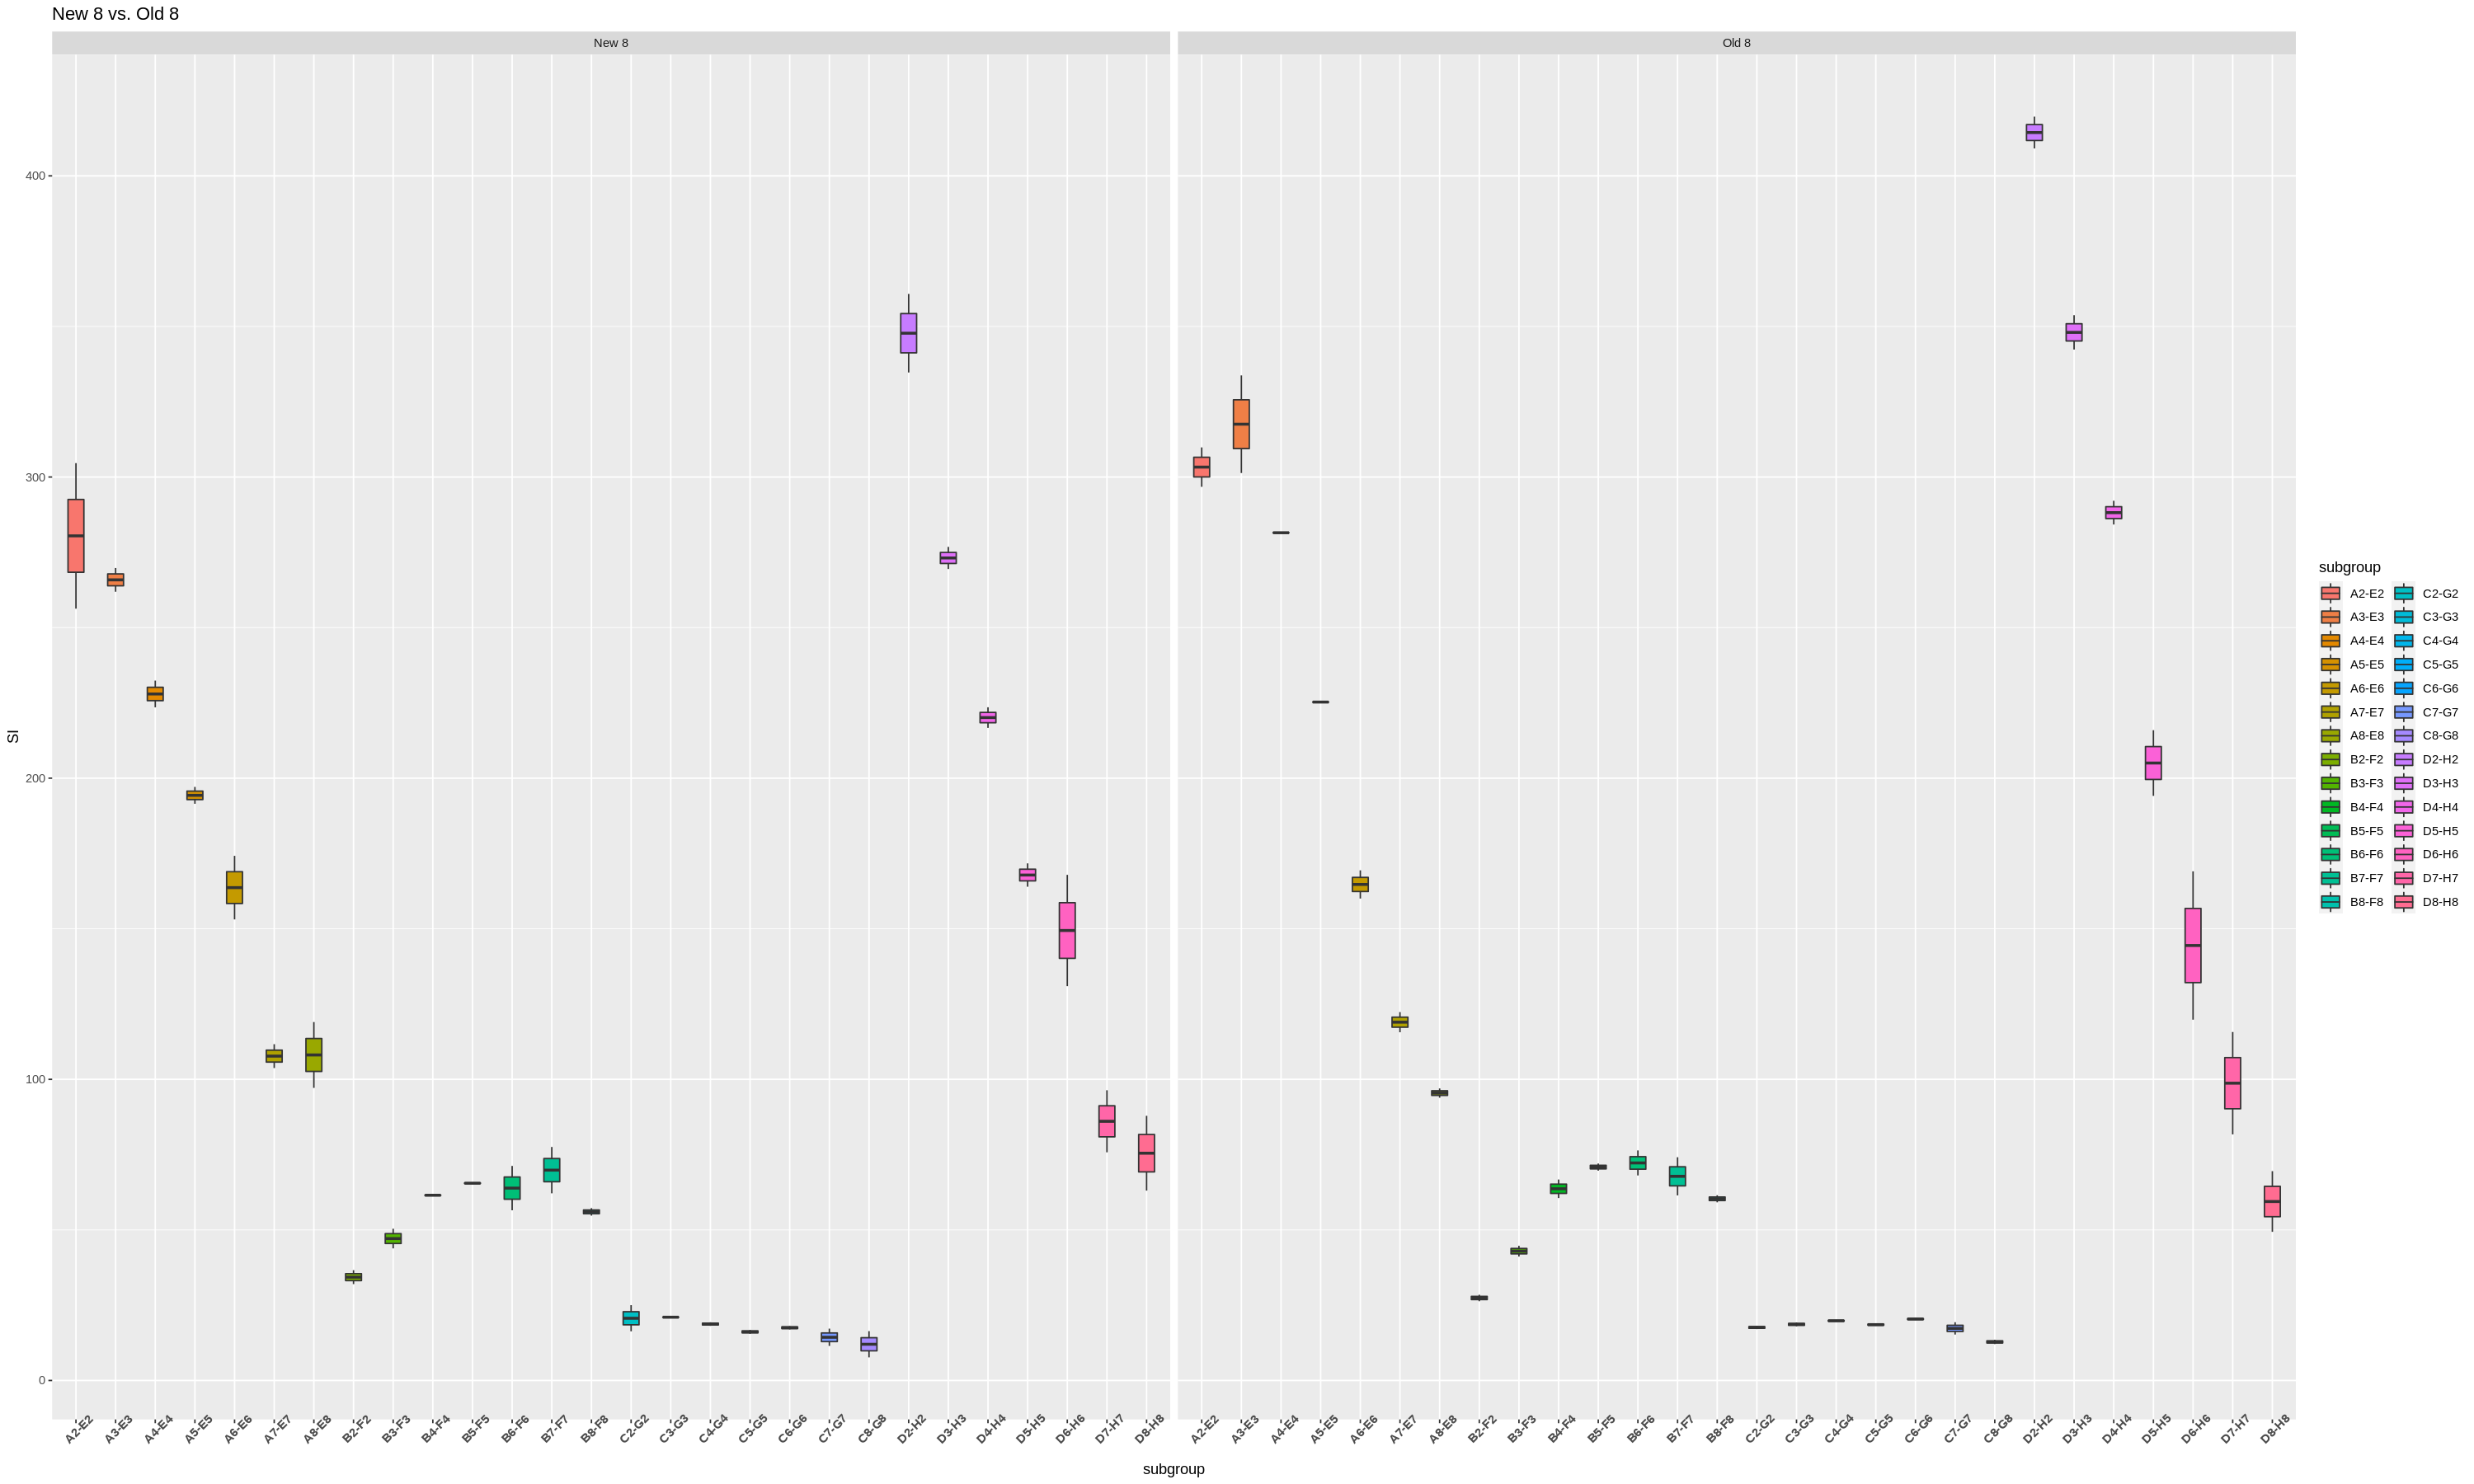

In [179]:
ggplot(dff, aes(subgroup, SI, fill=subgroup)) +
    geom_boxplot(width = 0.4) + 
#    stat_summary(geom="text", fun=quantile,
#           aes(label=sprintf("%1.1f", ..y..), color=subgroup),
#           position=position_nudge(x=0.4), size=3.25) +
    ggtitle("New 8 vs. Old 8") + 
    facet_wrap( ~ method) +
    theme(axis.text.x = element_text(face = "bold", 
                           size = 8.75, angle = 45)) 
#ggsave(filename = "boxplt_new8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

In [232]:
# linear regression 
dfn <- dff %>% filter(method == "New 8")
dfo <- dff %>% filter(method == "Old 8")
dfm <- inner_join(x = dfn, y = dfo, by = "wellid")
reg <- lm(SI.y~SI.x,data=dfm) 
dfm <- dfm %>% mutate(regline = reg[[1]][2]*SI.x + reg[[1]][1])
summary(reg)

ERROR: Error: Problem with `filter()` input `..1`.
[31m✖[39m object 'method' not found
[34mℹ[39m Input `..1` is `method == "New 8"`.


In [218]:
head(dfm)

SI.x     SAMPLE_NAME.x               wellid plate.x method.x group.x row.x
1 256.2940 Specimen_001_A2_A02_001.fcs A02    plate 1 New 8    COL2    A-E  
2 269.7985 Specimen_001_A3_A03_002.fcs A03    plate 1 New 8    COL3    A-E  
3 223.5190 Specimen_001_A4_A04_003.fcs A04    plate 1 New 8    COL4    A-E  
4 191.4912 Specimen_001_A5_A05_004.fcs A05    plate 1 New 8    COL5    A-E  
5 174.2166 Specimen_001_A6_A06_005.fcs A06    plate 1 New 8    COL6    A-E  
6 103.7435 Specimen_001_A7_A07_006.fcs A07    plate 1 New 8    COL7    A-E  
  subgroup.x SI.y     SAMPLE_NAME.y               plate.y method.y group.y
1 A2-E2      309.8282 Specimen_001_A2_A02_097.fcs plate 1 Old 8    COL2   
2 A3-E3      301.3359 Specimen_001_A3_A03_098.fcs plate 1 Old 8    COL3   
3 A4-E4      281.4199 Specimen_001_A4_A04_099.fcs plate 1 Old 8    COL4   
4 A5-E5      225.3455 Specimen_001_A5_A05_100.fcs plate 1 Old 8    COL5   
5 A6-E6      169.3957 Specimen_001_A6_A06_101.fcs plate 1 Old 8    COL6   
6 A7-E7      115.6354 Specimen_001_A7_A07_102.fcs plate 1 Old 8    COL7   
  row.y subgroup.y regline 
1 A-E   A2-E2      300.2639
2 A-E   A3-E3      316.5516
3 A-E   A4-E4      260.7342
4 A-E   A5-E5      222.1056
5 A-E   A6-E6      201.2708
6 A-E   A7-E7      116.2736

ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'SI.x' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(cap

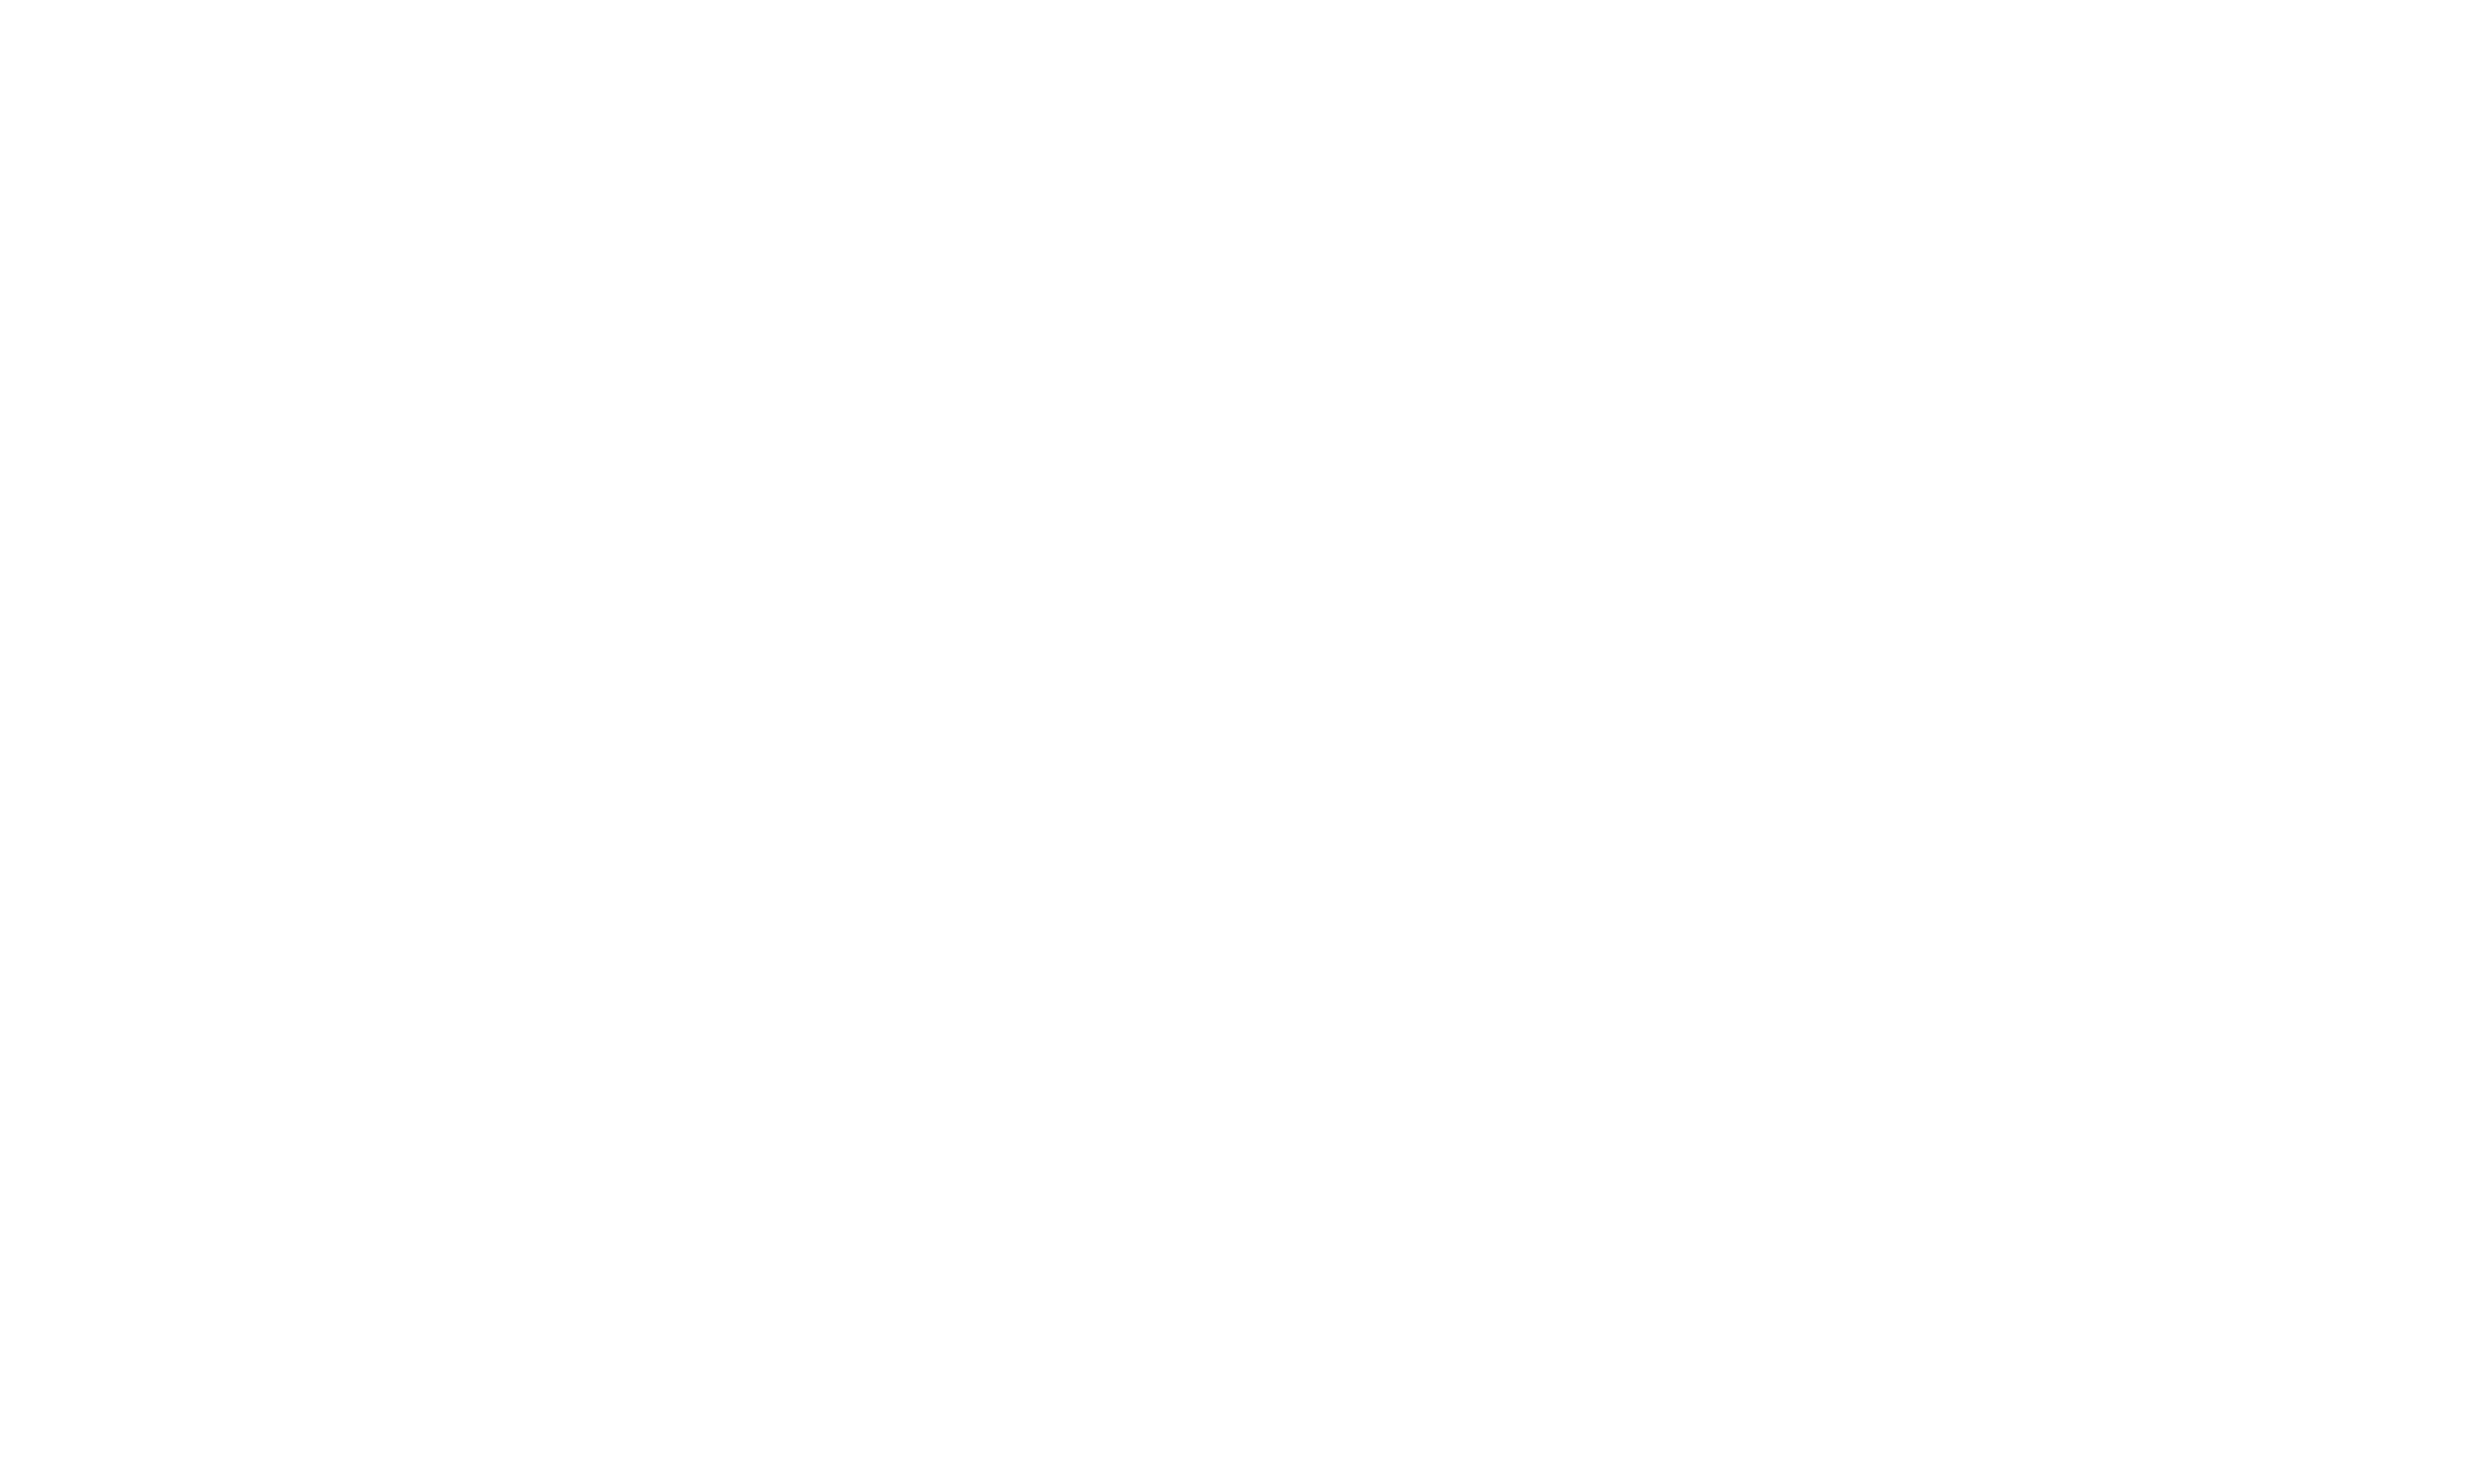

In [253]:
ggplot(dfm) + 
    geom_point(size = 8, aes(x = SI.x, 
                   y = SI.y, 
                   color=subgroup.x)) + 
    geom_line(aes(x = SI.x, 
                  y = regline)) + 
    ggtitle("New 8 vs. Old 8 SI") + 
    xlab("New 8 SI") + 
    ylab("Old 8 SI") + 
    theme(text = element_text(size=20),
        axis.text.x = element_text(size = 12)) +
    annotate("text", 
             x = 175, 
             y = 50, 
             size = 9,
             label = paste("lin.reg y =", round(reg[[1]][2],2), "x +", 
                           round(reg[[1]][1],2))) + 
    annotate("text",
             x = 175,
             y = 30,
             size = 9,
             label = paste("R^2 =", round(summary(reg)$`r.squared`, 2)))


### XmR charts to show data series

In [14]:
row_pair_ls <- list()
for (i in seq(4)) {
    row_pair_ls[[i]] <- c(wellIDs[, rows[[i]][1]], wellIDs[, rows[[i]][2]])
}
row_pair_ls <- unlist(row_pair_ls)
row_pair_ls

ERROR: Error in eval(expr, envir, enclos): object 'wellIDs' not found


In [183]:
head(dff)

SI       SAMPLE_NAME                 wellid plate   method group row subgroup
1 256.2940 Specimen_001_A2_A02_001.fcs A02    plate 1 New 8  COL2  A-E A2-E2   
2 269.7985 Specimen_001_A3_A03_002.fcs A03    plate 1 New 8  COL3  A-E A3-E3   
3 223.5190 Specimen_001_A4_A04_003.fcs A04    plate 1 New 8  COL4  A-E A4-E4   
4 191.4912 Specimen_001_A5_A05_004.fcs A05    plate 1 New 8  COL5  A-E A5-E5   
5 174.2166 Specimen_001_A6_A06_005.fcs A06    plate 1 New 8  COL6  A-E A6-E6   
6 103.7435 Specimen_001_A7_A07_006.fcs A07    plate 1 New 8  COL7  A-E A7-E7

In [184]:
options(repr.plot.width=25, repr.plot.height=15)

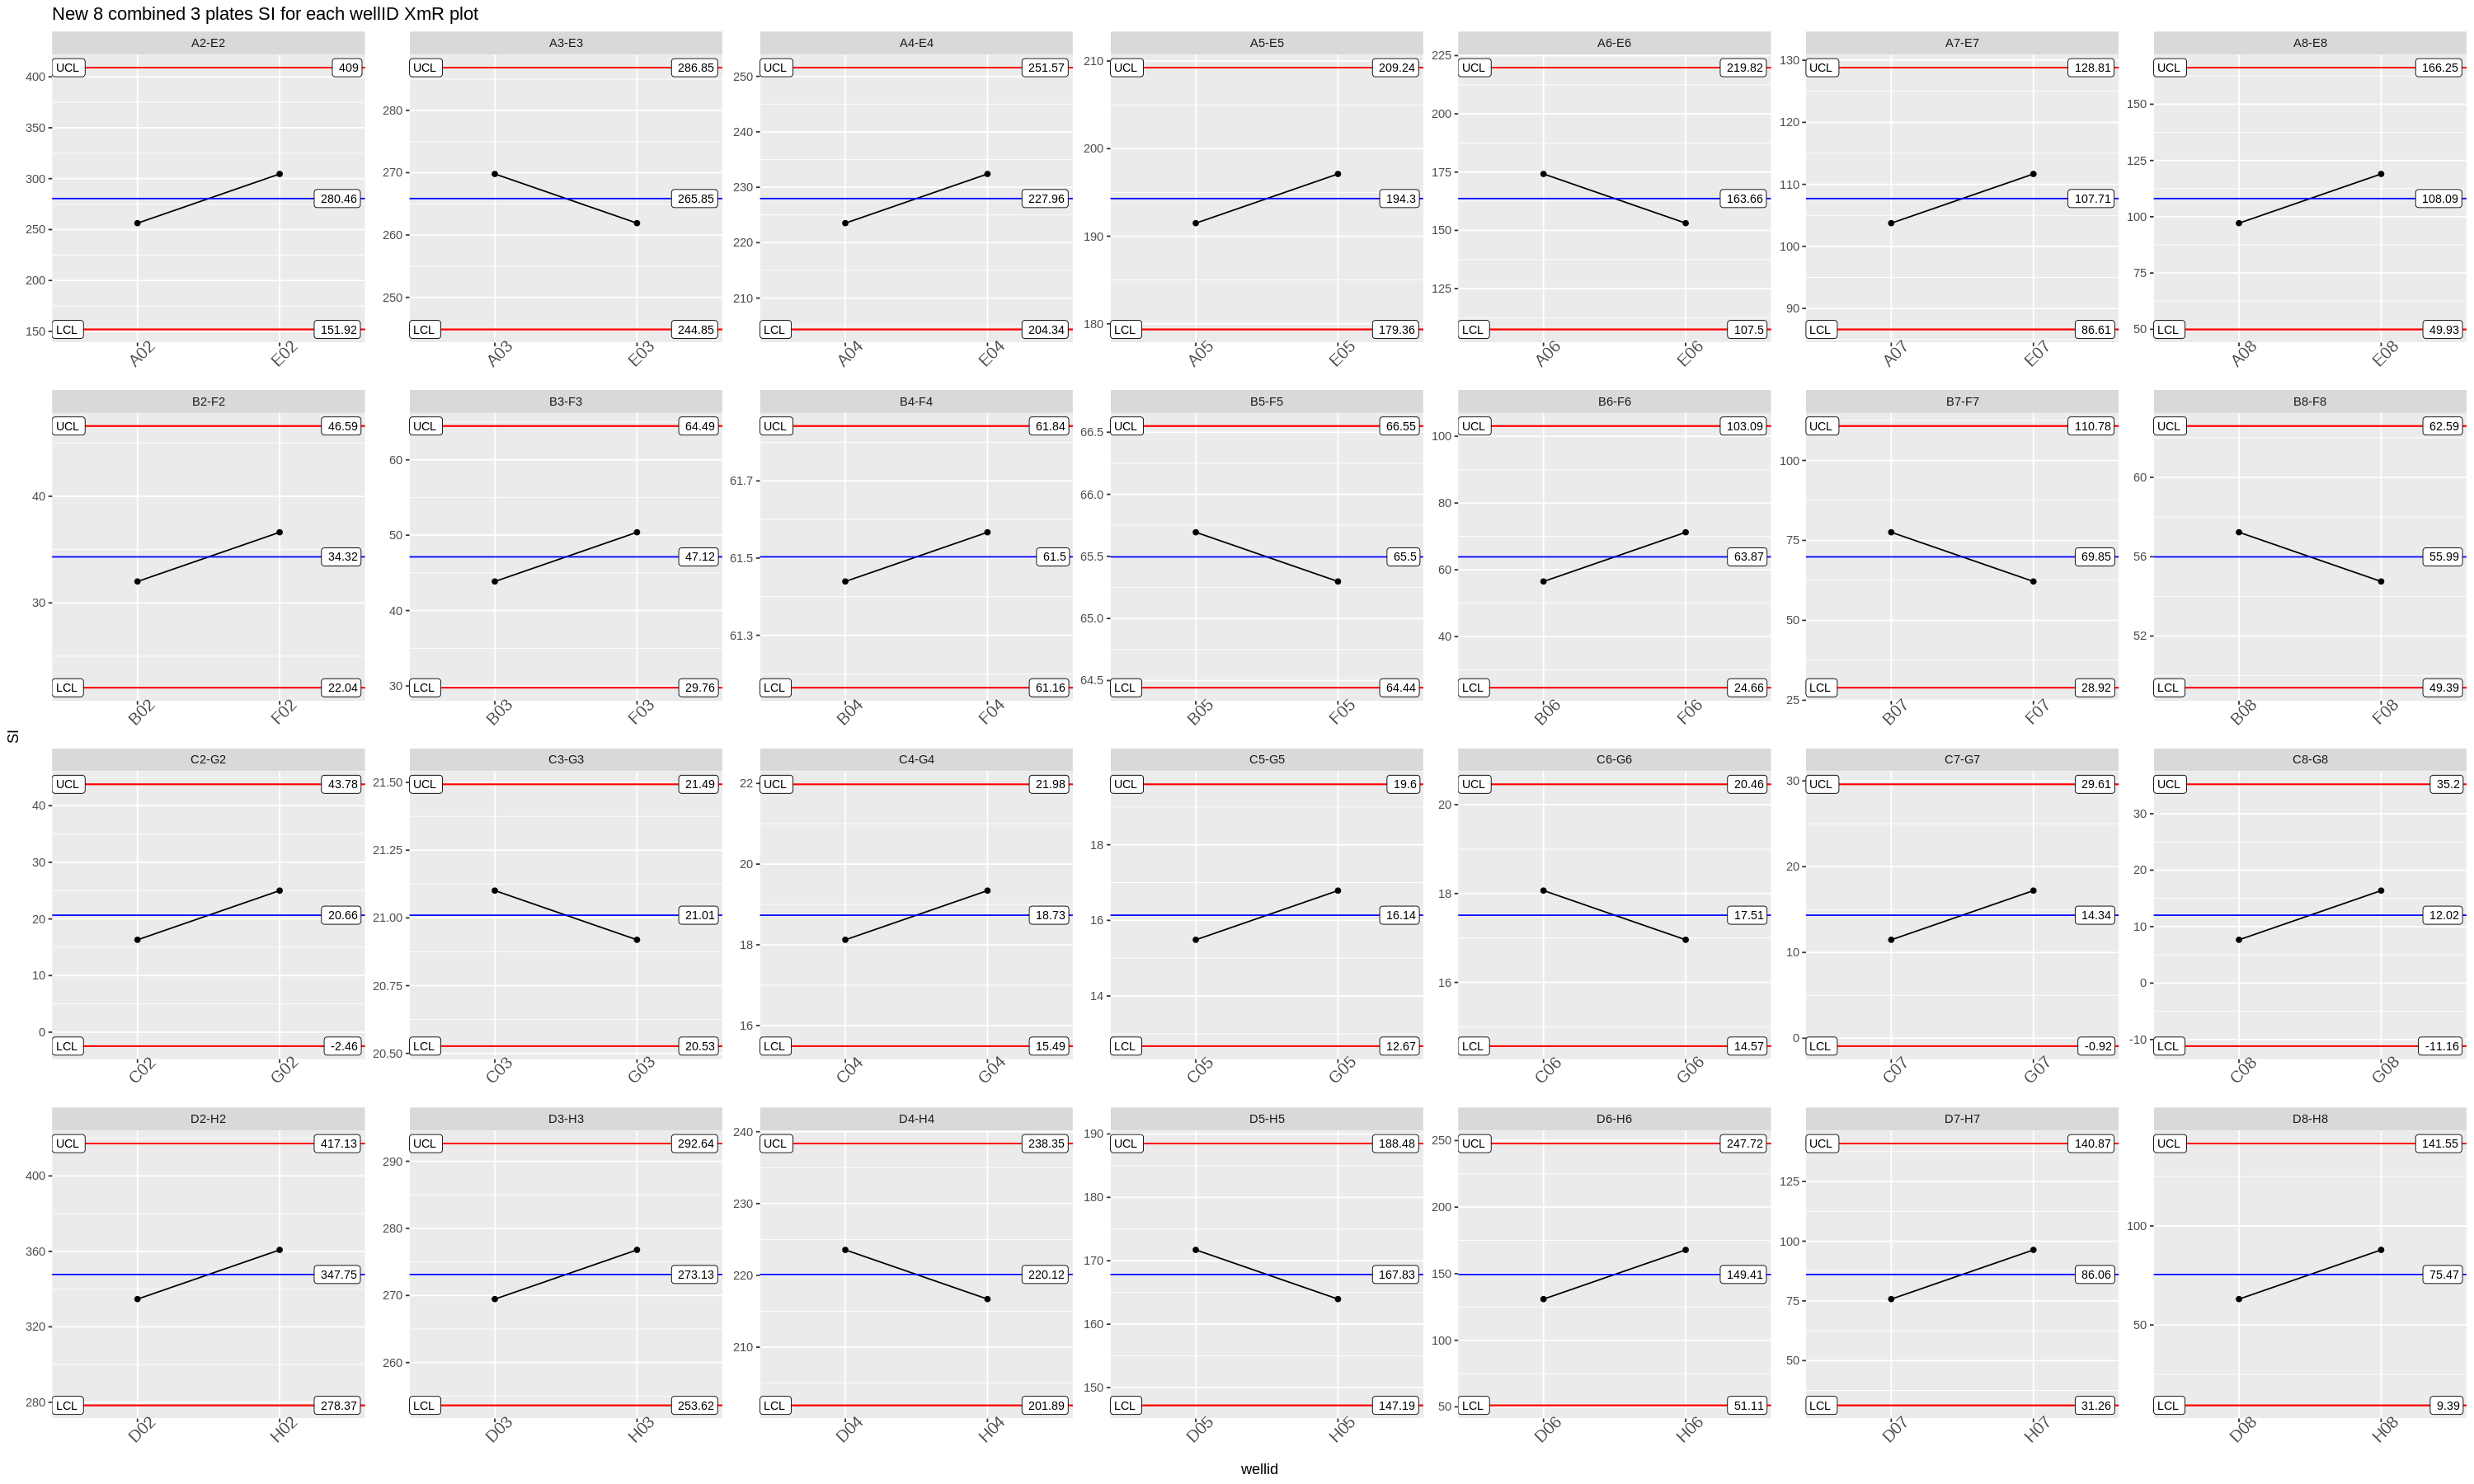

In [185]:
df.t <- dff %>% filter(method == "New 8")
ggplot(df.t, aes(x=wellid, y=SI, group = group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("SI") +
  #scale_x_discrete(breaks=1:16,
  #                 labels=labels) + 
  facet_wrap(~ subgroup, ncol = 7, scales = "free") + 
  ggtitle("New 8 combined 3 plates SI for each wellID XmR plot") +
  theme(axis.text.x = element_text(size = 12, angle = 45))

#ggsave(filename = "XmR_old8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

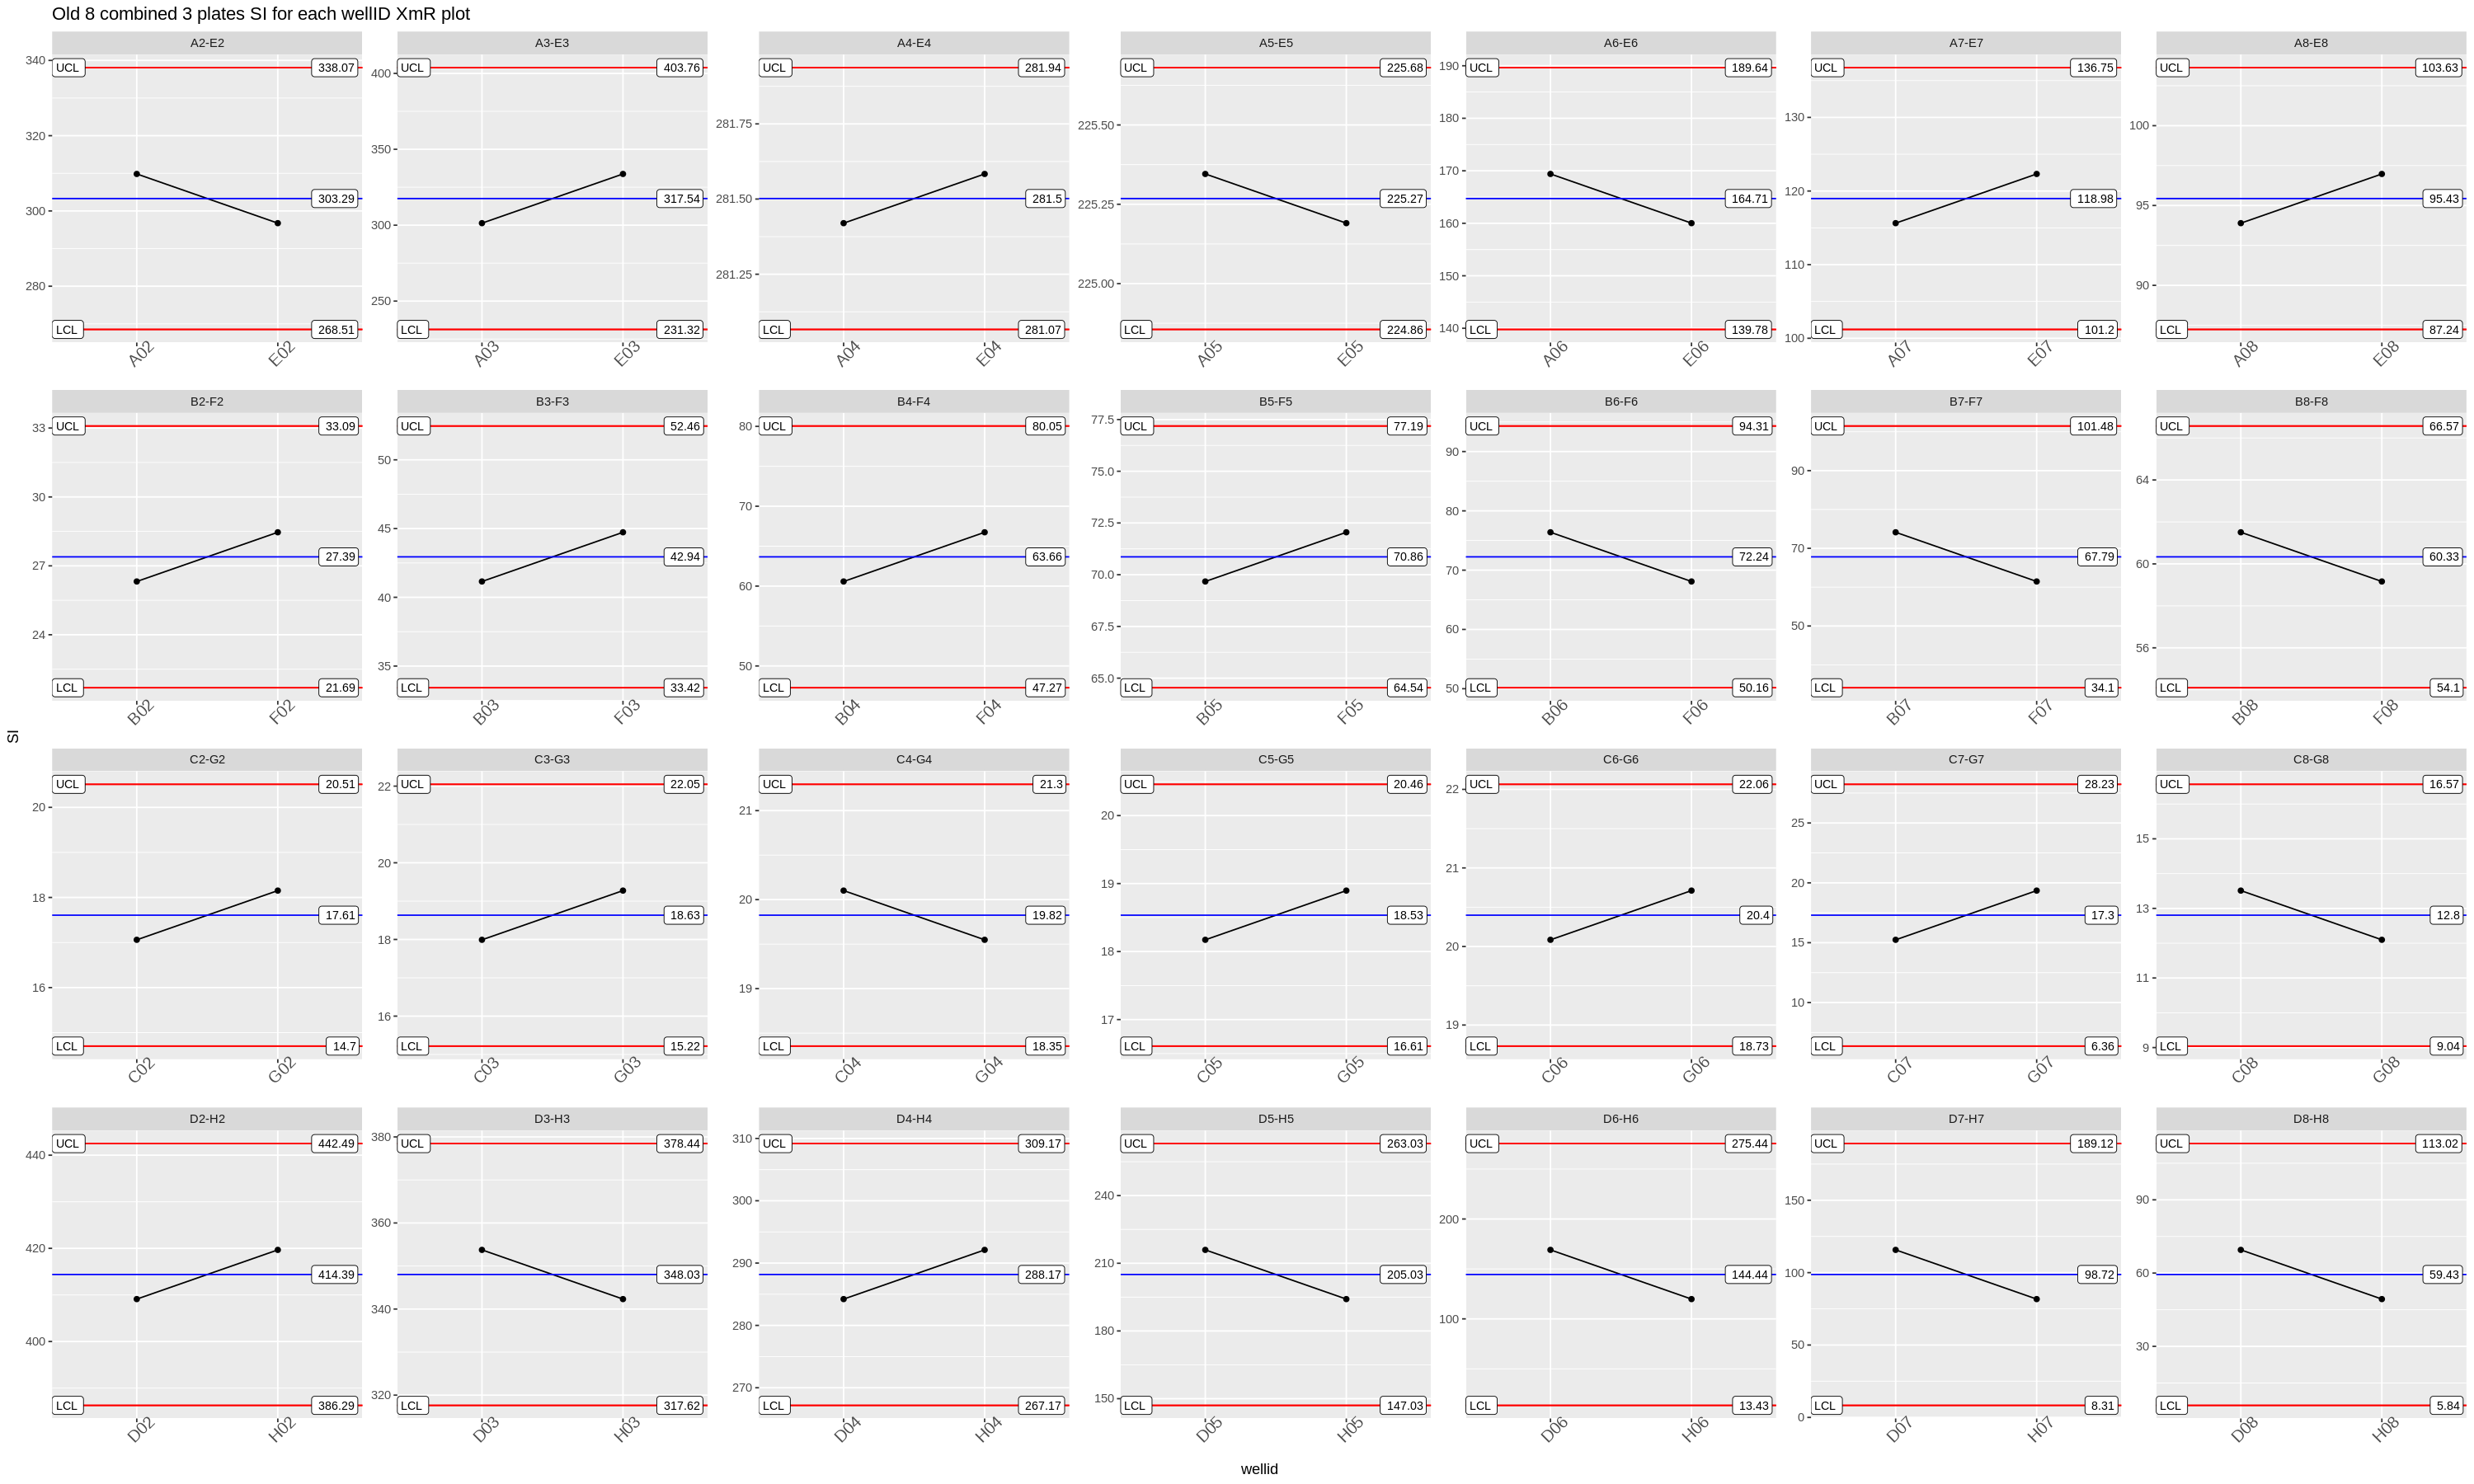

In [186]:
df.t <- dff %>% filter(method == "Old 8")
ggplot(df.t, aes(x=wellid, y=SI, group = group)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("SI") +
  #scale_x_discrete(expand =  expansion(mult = .04)) + 
  facet_wrap(~ subgroup, ncol = 7, scales = "free") + 
  ggtitle("Old 8 combined 3 plates SI for each wellID XmR plot") +
  theme(axis.text.x = element_text(size = 12, angle = 45))

#ggsave(filename = "XmR_old8_si.png", plot = pp, scale = 1, width = 350, units = "mm", dpi = 300)

In [160]:
dff

SI.x       SAMPLE_NAME.x               wellid plate.x method.x group.x row.x
1  308.896726 Specimen_001_A2_A02_003.fcs A02    plate 1 New 8    COL2    A-E  
2  309.241566 Specimen_001_A3_A03_004.fcs A03    plate 1 New 8    COL3    A-E  
3  260.839640 Specimen_001_A4_A04_005.fcs A04    plate 1 New 8    COL4    A-E  
4  243.821622 Specimen_001_A5_A05_006.fcs A05    plate 1 New 8    COL5    A-E  
5  185.604823 Specimen_001_A6_A06_007.fcs A06    plate 1 New 8    COL6    A-E  
6  139.532694 Specimen_001_A7_A07_008.fcs A07    plate 1 New 8    COL7    A-E  
7   80.240020 Specimen_001_A8_A08_009.fcs A08    plate 1 New 8    COL8    A-E  
8   43.561838 Specimen_001_B2_B02_015.fcs B02    plate 1 New 8    COL2    B-F  
9   59.085214 Specimen_001_B3_B03_016.fcs B03    plate 1 New 8    COL3    B-F  
10  84.712966 Specimen_001_B4_B04_017.fcs B04    plate 1 New 8    COL4    B-F  
11  81.276228 Specimen_001_B5_B05_018.fcs B05    plate 1 New 8    COL5    B-F  
12  72.411202 Specimen_001_B6_B06_019.fcs B06    plate 1 New 8    COL6    B-F  
13  66.227185 Specimen_001_B7_B07_020.fcs B07    plate 1 New 8    COL7    B-F  
14  57.044127 Specimen_001_B8_B08_021.fcs B08    plate 1 New 8    COL8    B-F  
15  21.007371 Specimen_001_C2_C02_027.fcs C02    plate 1 New 8    COL2    C-G  
16  22.316651 Specimen_001_C3_C03_028.fcs C03    plate 1 New 8    COL3    C-G  
17  22.091451 Specimen_001_C4_C04_029.fcs C04    plate 1 New 8    COL4    C-G  
18  20.193875 Specimen_001_C5_C05_030.fcs C05    plate 1 New 8    COL5    C-G  
19  13.611927 Specimen_001_C6_C06_031.fcs C06    plate 1 New 8    COL6    C-G  
20   9.090341 Specimen_001_C7_C07_032.fcs C07    plate 1 New 8    COL7    C-G  
21   8.140672 Specimen_001_C8_C08_033.fcs C08    plate 1 New 8    COL8    C-G  
22 367.201128 Specimen_001_D2_D02_039.fcs D02    plate 1 New 8    COL2    D-H  
23 320.447753 Specimen_001_D3_D03_040.fcs D03    plate 1 New 8    COL3    D-H  
24 287.392071 Specimen_001_D4_D04_041.fcs D04    plate 1 New 8    COL4    D-H  
25 170.927659 Specimen_001_D5_D05_042.fcs D05    plate 1 New 8    COL5    D-H  
26 112.915608 Specimen_001_D6_D06_043.fcs D06    plate 1 New 8    COL6    D-H  
27  67.719669 Specimen_001_D7_D07_044.fcs D07    plate 1 New 8    COL7    D-H  
28 103.116734 Specimen_001_D8_D08_045.fcs D08    plate 1 New 8    COL8    D-H  
29 313.247084 Specimen_001_E2_E02_051.fcs E02    plate 1 New 8    COL2    A-E  
30 300.829250 Specimen_001_E3_E03_052.fcs E03    plate 1 New 8    COL3    A-E  
31 266.903738 Specimen_001_E4_E04_053.fcs E04    plate 1 New 8    COL4    A-E  
32 209.025835 Specimen_001_E5_E05_054.fcs E05    plate 1 New 8    COL5    A-E  
33 158.694908 Specimen_001_E6_E06_055.fcs E06    plate 1 New 8    COL6    A-E  
34  85.812779 Specimen_001_E7_E07_056.fcs E07    plate 1 New 8    COL7    A-E  
35  71.925859 Specimen_001_E8_E08_057.fcs E08    plate 1 New 8    COL8    A-E  
36  44.898917 Specimen_001_F2_F02_063.fcs F02    plate 1 New 8    COL2    B-F  
37  65.081845 Specimen_001_F3_F03_064.fcs F03    plate 1 New 8    COL3    B-F  
38  81.905330 Specimen_001_F4_F04_065.fcs F04    plate 1 New 8    COL4    B-F  
39  82.933416 Specimen_001_F5_F05_066.fcs F05    plate 1 New 8    COL5    B-F  
40  83.781535 Specimen_001_F6_F06_067.fcs F06    plate 1 New 8    COL6    B-F  
41  78.037443 Specimen_001_F7_F07_068.fcs F07    plate 1 New 8    COL7    B-F  
42  53.881892 Specimen_001_F8_F08_069.fcs F08    plate 1 New 8    COL8    B-F  
43  20.415379 Specimen_001_G2_G02_075.fcs G02    plate 1 New 8    COL2    C-G  
44  22.590926 Specimen_001_G3_G03_076.fcs G03    plate 1 New 8    COL3    C-G  
45  20.511272 Specimen_001_G4_G04_077.fcs G04    plate 1 New 8    COL4    C-G  
46  23.577554 Specimen_001_G5_G05_078.fcs G05    plate 1 New 8    COL5    C-G  
47  14.996740 Specimen_001_G6_G06_079.fcs G06    plate 1 New 8    COL6    C-G  
48   8.125403 Specimen_001_G7_G07_080.fcs G07    plate 1 New 8    COL7    C-G  
49  14.885710 Specimen_001_G8_G08_081.fcs G08    plate 1 New 8    COL8    C-G  
50 

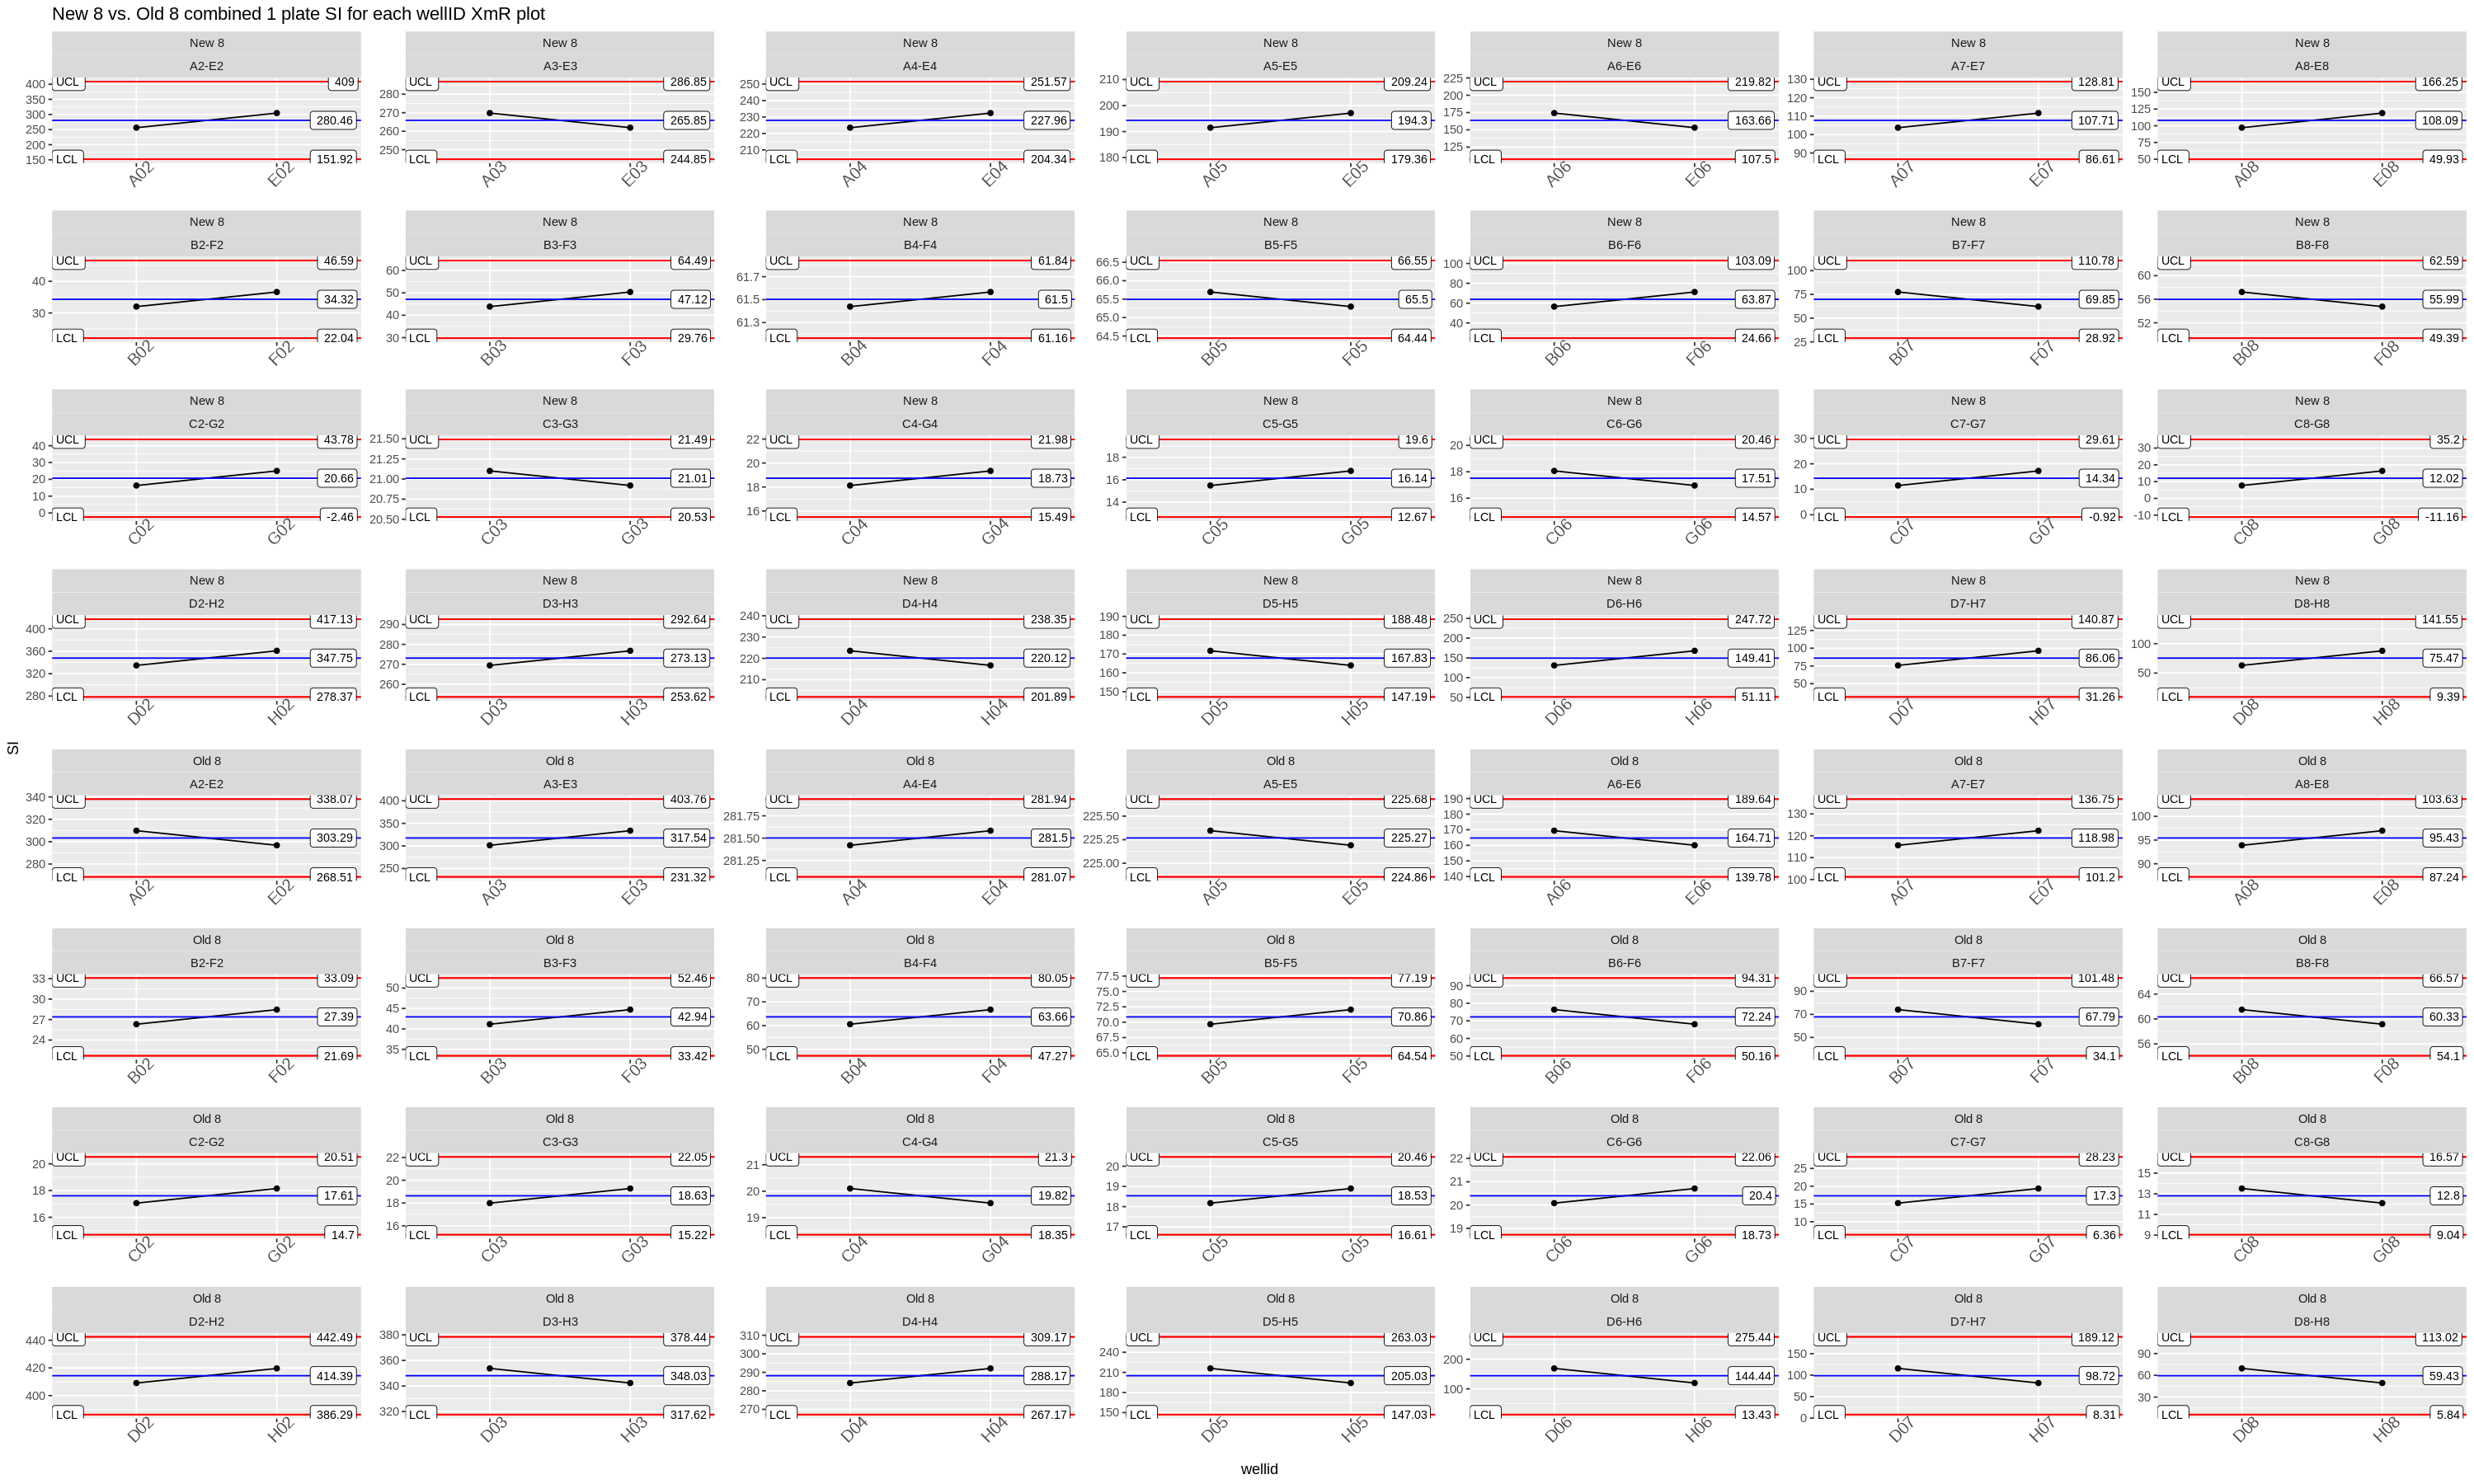

In [187]:
ggplot(dff, aes(x=wellid, y=SI, group = subgroup)) +
  geom_point() + geom_line() +
  stat_QC(method="XmR", auto.label = T, label.digits = 2) + 
  ylab("SI") +
  facet_wrap(method~ subgroup, ncol = 7, scales = "free") + 
  ggtitle("New 8 vs. Old 8 combined 1 plate SI for each wellID XmR plot") +
  theme(axis.text.x = element_text(size = 12, angle = 45))

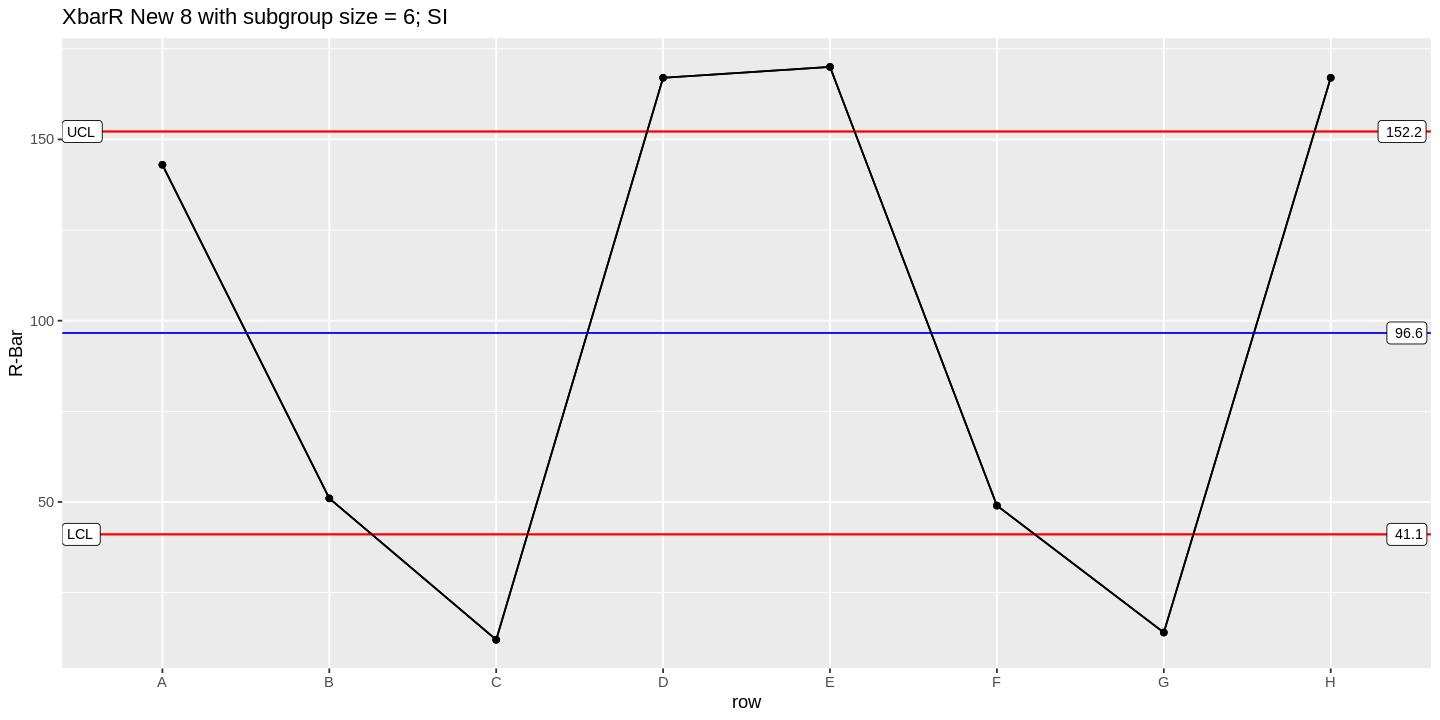

In [184]:
suppressWarnings(ggplot(dff.new8.si, aes(x = row, y = si., group = 1)) +
         stat_summary(fun = QCrange, geom = "point") +
         stat_summary(fun = QCrange, geom = "line") +
         stat_QC(method="rBar") +
         stat_QC_labels(method="rBar") + ylab("R-Bar") +
         ggtitle("XbarR New 8 with subgroup size = 6; SI"))

# Conclusion

- Seems as though the experiment is not setup for statistically convincing data
- May be inherent to flow cytometry experiments
- Or could design a new experiment:
    - Run 1 plate at a time, 2x for 8 channel and 96 core head
    - After each plate finishes, immediately wash and start on flow cytometer (use 2x cytometers; this will help even out inherent variances that can be pooled)
    - Perhaps use a real cell counter and count cells of a plate to compare against the X20
    - Append to current dataset cell count with n=3 prior to washing